In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
train_x = train.drop("revenue",axis=1)
train_y = pd.DataFrame(train["revenue"])

In [4]:
print(train_x.shape)
print(test.shape)

(137, 42)
(100000, 42)


In [5]:
data = pd.concat([train_x,test])
print(data.shape)
print(data.isnull().sum().sum())

(100137, 42)
0


In [6]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def feature_engineer(df):
    df = df.astype(float,errors="ignore")
    df["Open Date"] = pd.to_datetime(df["Open Date"], format='%m/%d/%Y')
    df = df.set_index("Open Date")
    df["Open_Year"] = df.index.year
    df["Open_Month"] = df.index.month
    df = df.reset_index(drop=True)
    df = create_dummies(df,"Type")
    df = create_dummies(df,"City Group")
    df = create_dummies(df,"City")
    df = create_dummies(df,"Open_Year")
    df = create_dummies(df,"Open_Month")
    df = df.drop(["City","City Group","Type","Open_Year","Open_Month"],axis=1)
    return df

In [8]:
data_rf = feature_engineer(data)

In [9]:
train_rf_x = data_rf[:137]
test_x = data_rf[137:]
print(train_rf_x.shape)
print(test_x.shape)

(137, 139)
(100000, 139)


In [10]:
train_rf_x = train_rf_x.drop("Id",axis=1)
Submission_id = pd.DataFrame(test_x["Id"]).astype(int).reset_index(drop=True)
test_rf_x = test_x.drop("Id",axis=1).reset_index(drop=True)

In [11]:
print(train_rf_x.shape) # Performed features normalization
print(train_y.shape)
print(test_rf_x.shape) # Performed features normalization
print(Submission_id.shape)

(137, 138)
(137, 1)
(100000, 138)
(100000, 1)


In [12]:
# Transform features only, and need no inverse_transform back
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
train_score_scaler = MinMaxScaler()
test_score_scaler = MinMaxScaler()
normalize_train = pd.DataFrame(train_score_scaler.fit_transform(train_rf_x.loc[:,"P1":"P37"]),columns = train_rf_x.loc[:,"P1":"P37"].columns)
normalize_test = pd.DataFrame(test_score_scaler.fit_transform(test_rf_x.loc[:,"P1":"P37"]),columns = test_rf_x.loc[:,"P1":"P37"].columns)
# z- score transformation for train_rf_x & test_rf_x
train_rf_x.loc[:,"P1":"P37"] = normalize_train
test_rf_x.loc[:,"P1":"P37"] = normalize_test
print(test_rf_x.isnull().sum().sum())
print(train_rf_x.loc[:,"P1":"P37"].equals(normalize_train))

0
True


In [13]:
# transformation for Train_y
train_y_scaler = StandardScaler()
normalize_train_y = pd.DataFrame(train_y_scaler.fit_transform(train_y),columns = train_y.columns)
log_transform_y = train_y.apply(np.log)
sqrt_log_y = train_y.apply(np.sqrt).apply(np.log)

# Feature Engineering Part: drop non-mutual features

In [14]:
drop_columns = (train_rf_x.sum()==0)
drop_columns = drop_columns[drop_columns].index

In [15]:
train_rf_x_drop = train_rf_x.drop(drop_columns,axis=1)
test_rf_x_drop = test_rf_x.drop(drop_columns,axis=1)
print(train_rf_x_drop.shape)
print(test_rf_x_drop.shape)

(137, 105)
(100000, 105)


In [16]:
drop_columns_months = train_rf_x_drop.iloc[:,-12:]
drop_columns_months = drop_columns_months.columns

In [17]:
train_rf_x_drop = train_rf_x_drop.drop(drop_columns_months,axis=1)
test_rf_x_drop = test_rf_x_drop.drop(drop_columns_months,axis=1)
print(train_rf_x_drop.shape)
print(test_rf_x_drop.shape)

(137, 93)
(100000, 93)


# Feature Engineering Part_2: Create N-way interaction features

In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
# The interaction features can be as 2-way interaction, 3 way or more by adjusting the polynomial degree
n_way_interactions = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [20]:
n_way_interactions_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

In [21]:
train_interactions = pd.DataFrame(n_way_interactions.fit_transform(train_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(train_rf_x[n_way_interactions_columns].columns))
test_interactions = pd.DataFrame(n_way_interactions.fit_transform(test_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(test_rf_x[n_way_interactions_columns].columns))

In [22]:
train_rf_x_interaction = pd.concat([train_rf_x_drop,train_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
test_rf_x_interaction = pd.concat([test_rf_x_drop,test_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
print(train_rf_x_interaction.shape)
print(test_rf_x_interaction.shape)

(137, 722)
(100000, 722)


# XGboost, Grid Search with Features without interaction & sqrt & log_transformation_y FULL MODEL

In [18]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle

In [19]:
hyperparameters_dict = {"learning_rate": [0.1,0.2,0.3],              # range: [0,1], default = 0.3
                   # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
                   # The larger gamma is, the more conservative the algorithm will be.                   
                   "gamma": [i/10.0 for i in range(1,10,2)],
                   # Maximum depth of a tree. 
                   # Increasing this value will make the model more complex and more likely to overfit
                   "max_depth": [6], 
                   # Used to control over-fitting
                   # Too high values can lead to under-fitting hence, it should be tuned using grid search
                   "min_child_weight": [1],
                   # Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced
                   "max_delta_step": [0],
                   # Denotes the fraction of observations to be randomly samples for each tree
                   # Typical values: 0.5-1
                   "subsample": [0.8],
                   # Similar to max_features in GBM, Typical values: 0.5 - 1
                   # Denotes the fraction of columns to be randomly samples for each tree.
                   "colsample_bytree": [0.8,1],
                   "colsample_bylevel": [1], # colsample_bytree will control the decision over this, default = 1
                   "colsample_bynode": [1],  # colsample_bytree will control the decision over this, default = 1
                   # L2 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_lambda": [1], # default = 1
                   # L1 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_alpha": [1],  # default = 0
                   # Control the balance of positive and negative weights, useful for unbalanced classes. 
                   # A typical value to consider: sum(negative instances) / sum(positive instances)
                   "scale_pos_weight": [1],
                   # No. of trees ensemble, too high sometimes still can cause overfitting
                   "n_estimators": [300,400], 
                   "booster": ["gbtree"],
                   "verbosity": [1],
                   "objective": ["reg:squarederror"],
                   "seed": [50]
                   }

In [20]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [112]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0.01],                       # 3rd
                          'max_depth': [8],                     # 1st to tune
                          'min_child_weight': [2.2],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.5],                   # 4th
                          'colsample_bytree': [0.1],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [1],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [90],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["reg:squarederror"],
                          "seed": [1]
                         }                

In [113]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBRegressor()

In [114]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 10, iid = False, scoring="neg_mean_squared_error")

In [115]:
xgboost_grid.fit(train_rf_x_drop,sqrt_log_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.001], 'gamma': [0.01], 'max_depth': [8], 'min_child_weight': [2.2], 'max_delta_step': [0], 'subsample': [0.5], 'colsample_bytree': [0.1], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [1], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [90], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['reg:squarederror'], 'seed': [1]},
       pre_dispatch='2*n_j

In [116]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_R2_score = best_rf.score(train_rf_x_drop,sqrt_log_y)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_R2_score)
print(best_score)
print(best_R2_score)
print(best_rf)

-0.048035184996555305
0.6324874084122539
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.1, gamma=0.01,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=2.2, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.5, verbosity=1)


In [117]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[-0.048100295367994636, -0.04739725139401582, -0.04666676522411547, -0.04666676522411547, -0.04666676522411547, -0.05068361933645571, -0.049734876720880866, -0.049641257670386636, -0.04838182344292745, -0.048185848022442676, -0.048035184996555305, -0.048035184996555305]
[0.7507428747136732, 0.6801445889210718, 0.6593217384040311, 0.6593217384040311, 0.6593217384040311, 0.7799348456732625, 0.8017089245619053, 0.7350322921084909, 0.5972505519618387, 0.5984369442473875, 0.6324874084122539, 0.6324874084122539]
[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0.001,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.6, verbosity=1), XGBRegressor(base_score=0.5

In [75]:
# Another way to easy the tuning process
# to tune parameter in smaller grid, conclusion decide by cv_score
# cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}
# To update hyperparameters tuning and fix the best choices be constant
# hyperparameters2["max_depth"] = grid.best_params_['max_depth']

# Create XGBoost's DMatrix, after fine tuning the parameters

In [118]:
trainDMat = xgb.DMatrix(data = train_rf_x_drop, label = sqrt_log_y)

In [119]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)

In [132]:
num_boost_round = 70000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [133]:
hyperparameters_boosting ={'learning_rate': 0.0001,               # 6th when boosting
                          'gamma': 0.01,                       # 3rd
                          'max_depth': 8,                     # 1st to tune
                          'min_child_weight': 2.2,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.5,                   # 4th
                          'colsample_bytree': 0.1,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 1,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 90,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "reg:squarederror",
                          "seed": 1
                         }

In [134]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 10, #same as CV
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-rmse:7.09693+0.00710652	test-rmse:7.09595+0.0637369
[1]	train-rmse:7.09623+0.00710651	test-rmse:7.09525+0.0637366
[2]	train-rmse:7.09553+0.00710559	test-rmse:7.09455+0.0637373
[3]	train-rmse:7.09484+0.00710449	test-rmse:7.09386+0.0637386
[4]	train-rmse:7.09414+0.00710379	test-rmse:7.09316+0.0637394
[5]	train-rmse:7.09344+0.00710417	test-rmse:7.09246+0.0637391
[6]	train-rmse:7.09275+0.00710384	test-rmse:7.09176+0.0637395
[7]	train-rmse:7.09205+0.00710487	test-rmse:7.09107+0.0637382
[8]	train-rmse:7.09135+0.00710481	test-rmse:7.09037+0.0637385
[9]	train-rmse:7.09066+0.00710313	test-rmse:7.08967+0.0637401
[10]	train-rmse:7.08996+0.00710224	test-rmse:7.08898+0.0637413
[11]	train-rmse:7.08926+0.00710212	test-rmse:7.08828+0.0637413
[12]	train-rmse:7.08857+0.00710141	test-rmse:7.08759+0.0637418
[13]	train-rmse:7.08787+0.00710004	test-rmse:7.08689+0.0637431
[14]	train-rmse:7.08717+0.00709915	test-rmse:7.08619+0.0637446
[15]	train-rmse:7.08648+0.00709789	test-rmse:7.08549+0.0637454
[1

[131]	train-rmse:7.00615+0.00700593	test-rmse:7.00517+0.0638406
[132]	train-rmse:7.00546+0.00700509	test-rmse:7.00448+0.0638419
[133]	train-rmse:7.00477+0.00700487	test-rmse:7.00379+0.0638417
[134]	train-rmse:7.00408+0.00700429	test-rmse:7.0031+0.0638426
[135]	train-rmse:7.0034+0.00700358	test-rmse:7.00241+0.0638435
[136]	train-rmse:7.00271+0.00700246	test-rmse:7.00172+0.0638442
[137]	train-rmse:7.00202+0.00700094	test-rmse:7.00103+0.063846
[138]	train-rmse:7.00133+0.00700024	test-rmse:7.00035+0.0638468
[139]	train-rmse:7.00064+0.00699881	test-rmse:6.99966+0.0638482
[140]	train-rmse:6.99996+0.0069994	test-rmse:6.99897+0.0638481
[141]	train-rmse:6.99927+0.00699674	test-rmse:6.99828+0.0638503
[142]	train-rmse:6.99858+0.00699594	test-rmse:6.9976+0.0638513
[143]	train-rmse:6.99789+0.00699593	test-rmse:6.99691+0.0638512
[144]	train-rmse:6.9972+0.00699521	test-rmse:6.99622+0.0638521
[145]	train-rmse:6.99652+0.00699475	test-rmse:6.99553+0.0638528
[146]	train-rmse:6.99583+0.00699438	test-rmse:

[260]	train-rmse:6.91788+0.00690182	test-rmse:6.9169+0.0639491
[261]	train-rmse:6.9172+0.00690138	test-rmse:6.91622+0.06395
[262]	train-rmse:6.91652+0.00690127	test-rmse:6.91554+0.0639498
[263]	train-rmse:6.91585+0.00689976	test-rmse:6.91486+0.0639514
[264]	train-rmse:6.91517+0.00689883	test-rmse:6.91418+0.0639521
[265]	train-rmse:6.91449+0.00689907	test-rmse:6.9135+0.0639522
[266]	train-rmse:6.91381+0.00689809	test-rmse:6.91282+0.0639533
[267]	train-rmse:6.91313+0.00689877	test-rmse:6.91214+0.0639527
[268]	train-rmse:6.91245+0.00689768	test-rmse:6.91146+0.0639537
[269]	train-rmse:6.91177+0.0068957	test-rmse:6.91078+0.0639552
[270]	train-rmse:6.91109+0.00689667	test-rmse:6.9101+0.0639545
[271]	train-rmse:6.91041+0.00689707	test-rmse:6.90942+0.0639549
[272]	train-rmse:6.90973+0.00689596	test-rmse:6.90874+0.0639553
[273]	train-rmse:6.90905+0.00689451	test-rmse:6.90807+0.0639567
[274]	train-rmse:6.90838+0.00689275	test-rmse:6.90739+0.0639586
[275]	train-rmse:6.9077+0.00689178	test-rmse:6.

[389]	train-rmse:6.83074+0.00681937	test-rmse:6.82975+0.0640349
[390]	train-rmse:6.83007+0.00681883	test-rmse:6.82908+0.064036
[391]	train-rmse:6.8294+0.00681852	test-rmse:6.82841+0.0640364
[392]	train-rmse:6.82873+0.00681812	test-rmse:6.82773+0.0640367
[393]	train-rmse:6.82805+0.00681616	test-rmse:6.82706+0.0640385
[394]	train-rmse:6.82738+0.00681435	test-rmse:6.82639+0.0640403
[395]	train-rmse:6.82671+0.00681335	test-rmse:6.82572+0.0640417
[396]	train-rmse:6.82604+0.00681219	test-rmse:6.82505+0.0640426
[397]	train-rmse:6.82537+0.00681165	test-rmse:6.82437+0.0640426
[398]	train-rmse:6.8247+0.00681134	test-rmse:6.8237+0.0640436
[399]	train-rmse:6.82403+0.00680966	test-rmse:6.82304+0.0640452
[400]	train-rmse:6.82336+0.00680943	test-rmse:6.82236+0.0640459
[401]	train-rmse:6.82268+0.00680842	test-rmse:6.82169+0.0640467
[402]	train-rmse:6.82201+0.00680788	test-rmse:6.82102+0.0640469
[403]	train-rmse:6.82134+0.00680765	test-rmse:6.82035+0.0640475
[404]	train-rmse:6.82067+0.00680761	test-rms

[518]	train-rmse:6.7447+0.00673008	test-rmse:6.7437+0.0641283
[519]	train-rmse:6.74403+0.0067287	test-rmse:6.74304+0.0641298
[520]	train-rmse:6.74337+0.00672797	test-rmse:6.74238+0.0641308
[521]	train-rmse:6.74271+0.00672682	test-rmse:6.74171+0.064132
[522]	train-rmse:6.74205+0.00672564	test-rmse:6.74105+0.0641332
[523]	train-rmse:6.74138+0.00672418	test-rmse:6.74039+0.0641349
[524]	train-rmse:6.74072+0.00672495	test-rmse:6.73973+0.0641342
[525]	train-rmse:6.74006+0.00672471	test-rmse:6.73906+0.0641347
[526]	train-rmse:6.7394+0.00672218	test-rmse:6.7384+0.0641368
[527]	train-rmse:6.73874+0.00672215	test-rmse:6.73774+0.0641368
[528]	train-rmse:6.73807+0.00672217	test-rmse:6.73708+0.0641363
[529]	train-rmse:6.73741+0.00672176	test-rmse:6.73642+0.0641372
[530]	train-rmse:6.73675+0.00672144	test-rmse:6.73576+0.0641377
[531]	train-rmse:6.73609+0.00672207	test-rmse:6.73509+0.0641372
[532]	train-rmse:6.73543+0.00672184	test-rmse:6.73443+0.0641375
[533]	train-rmse:6.73476+0.00672096	test-rmse:

[648]	train-rmse:6.65908+0.00663971	test-rmse:6.65809+0.0642224
[649]	train-rmse:6.65843+0.00664064	test-rmse:6.65743+0.0642221
[650]	train-rmse:6.65778+0.00663959	test-rmse:6.65678+0.0642231
[651]	train-rmse:6.65712+0.00663936	test-rmse:6.65612+0.0642231
[652]	train-rmse:6.65647+0.00663839	test-rmse:6.65547+0.0642242
[653]	train-rmse:6.65581+0.0066375	test-rmse:6.65482+0.0642248
[654]	train-rmse:6.65516+0.00663602	test-rmse:6.65416+0.0642266
[655]	train-rmse:6.65451+0.00663434	test-rmse:6.65351+0.0642284
[656]	train-rmse:6.65385+0.00663414	test-rmse:6.65285+0.0642286
[657]	train-rmse:6.6532+0.0066351	test-rmse:6.6522+0.0642279
[658]	train-rmse:6.65255+0.00663481	test-rmse:6.65155+0.0642281
[659]	train-rmse:6.65189+0.00663344	test-rmse:6.65089+0.0642293
[660]	train-rmse:6.65124+0.00663366	test-rmse:6.65024+0.0642296
[661]	train-rmse:6.65058+0.00663352	test-rmse:6.64958+0.0642293
[662]	train-rmse:6.64993+0.00663271	test-rmse:6.64893+0.0642299
[663]	train-rmse:6.64928+0.0066331	test-rmse

[777]	train-rmse:6.5752+0.00654594	test-rmse:6.5742+0.0643204
[778]	train-rmse:6.57456+0.00654489	test-rmse:6.57356+0.0643214
[779]	train-rmse:6.57391+0.00654565	test-rmse:6.57291+0.0643207
[780]	train-rmse:6.57327+0.00654411	test-rmse:6.57226+0.0643221
[781]	train-rmse:6.57262+0.00654247	test-rmse:6.57162+0.0643236
[782]	train-rmse:6.57197+0.00654178	test-rmse:6.57097+0.0643245
[783]	train-rmse:6.57133+0.00654113	test-rmse:6.57033+0.064325
[784]	train-rmse:6.57068+0.00654147	test-rmse:6.56968+0.0643253
[785]	train-rmse:6.57004+0.00654119	test-rmse:6.56904+0.0643257
[786]	train-rmse:6.56939+0.00653927	test-rmse:6.56839+0.0643272
[787]	train-rmse:6.56875+0.00653917	test-rmse:6.56775+0.0643274
[788]	train-rmse:6.5681+0.006539	test-rmse:6.5671+0.0643277
[789]	train-rmse:6.56746+0.00653931	test-rmse:6.56645+0.0643276
[790]	train-rmse:6.56681+0.00653915	test-rmse:6.56581+0.0643272
[791]	train-rmse:6.56617+0.00653895	test-rmse:6.56516+0.0643276
[792]	train-rmse:6.56552+0.00653918	test-rmse:6

[906]	train-rmse:6.49239+0.00646834	test-rmse:6.49138+0.0644022
[907]	train-rmse:6.49175+0.00646691	test-rmse:6.49074+0.0644033
[908]	train-rmse:6.49111+0.00646704	test-rmse:6.49011+0.0644037
[909]	train-rmse:6.49047+0.00646696	test-rmse:6.48947+0.0644037
[910]	train-rmse:6.48984+0.00646585	test-rmse:6.48883+0.064405
[911]	train-rmse:6.4892+0.00646357	test-rmse:6.48819+0.0644067
[912]	train-rmse:6.48856+0.00646338	test-rmse:6.48755+0.0644072
[913]	train-rmse:6.48792+0.00646393	test-rmse:6.48692+0.0644068
[914]	train-rmse:6.48729+0.00646323	test-rmse:6.48628+0.0644079
[915]	train-rmse:6.48665+0.00646114	test-rmse:6.48564+0.0644094
[916]	train-rmse:6.48601+0.00646051	test-rmse:6.48501+0.0644103
[917]	train-rmse:6.48537+0.00645974	test-rmse:6.48437+0.0644112
[918]	train-rmse:6.48474+0.00645841	test-rmse:6.48373+0.0644122
[919]	train-rmse:6.4841+0.00645932	test-rmse:6.48309+0.0644118
[920]	train-rmse:6.48346+0.00645882	test-rmse:6.48246+0.0644121
[921]	train-rmse:6.48282+0.00645783	test-rm

[1035]	train-rmse:6.4106+0.0063816	test-rmse:6.40959+0.0644932
[1036]	train-rmse:6.40997+0.00638098	test-rmse:6.40896+0.0644937
[1037]	train-rmse:6.40934+0.00638092	test-rmse:6.40833+0.0644939
[1038]	train-rmse:6.40871+0.00637989	test-rmse:6.4077+0.0644951
[1039]	train-rmse:6.40808+0.00637912	test-rmse:6.40707+0.0644957
[1040]	train-rmse:6.40745+0.00637796	test-rmse:6.40644+0.0644966
[1041]	train-rmse:6.40682+0.00637693	test-rmse:6.40581+0.0644977
[1042]	train-rmse:6.40619+0.00637664	test-rmse:6.40518+0.0644984
[1043]	train-rmse:6.40556+0.00637462	test-rmse:6.40455+0.0645003
[1044]	train-rmse:6.40493+0.0063755	test-rmse:6.40392+0.0644997
[1045]	train-rmse:6.4043+0.00637518	test-rmse:6.40329+0.0644999
[1046]	train-rmse:6.40367+0.00637255	test-rmse:6.40266+0.0645023
[1047]	train-rmse:6.40305+0.00637331	test-rmse:6.40204+0.0645019
[1048]	train-rmse:6.40241+0.00637316	test-rmse:6.40141+0.064502
[1049]	train-rmse:6.40179+0.00637311	test-rmse:6.40078+0.0645019
[1050]	train-rmse:6.40116+0.006

[1162]	train-rmse:6.33112+0.00629846	test-rmse:6.33011+0.0645806
[1163]	train-rmse:6.3305+0.00629855	test-rmse:6.32948+0.0645803
[1164]	train-rmse:6.32987+0.00629797	test-rmse:6.32886+0.0645806
[1165]	train-rmse:6.32925+0.00629706	test-rmse:6.32824+0.0645817
[1166]	train-rmse:6.32863+0.00629475	test-rmse:6.32762+0.0645837
[1167]	train-rmse:6.32801+0.00629598	test-rmse:6.327+0.0645832
[1168]	train-rmse:6.32739+0.00629641	test-rmse:6.32638+0.0645826
[1169]	train-rmse:6.32677+0.00629565	test-rmse:6.32576+0.0645838
[1170]	train-rmse:6.32615+0.00629468	test-rmse:6.32513+0.0645845
[1171]	train-rmse:6.32552+0.00629458	test-rmse:6.32451+0.0645845
[1172]	train-rmse:6.3249+0.00629507	test-rmse:6.32389+0.0645843
[1173]	train-rmse:6.32428+0.00629559	test-rmse:6.32327+0.0645839
[1174]	train-rmse:6.32366+0.0062941	test-rmse:6.32265+0.0645848
[1175]	train-rmse:6.32304+0.00629608	test-rmse:6.32203+0.0645837
[1176]	train-rmse:6.32242+0.00629507	test-rmse:6.3214+0.0645842
[1177]	train-rmse:6.3218+0.0062

[1289]	train-rmse:6.25261+0.00623988	test-rmse:6.25159+0.0646433
[1290]	train-rmse:6.252+0.00623831	test-rmse:6.25098+0.064645
[1291]	train-rmse:6.25138+0.00623885	test-rmse:6.25036+0.0646443
[1292]	train-rmse:6.25077+0.00623902	test-rmse:6.24975+0.0646442
[1293]	train-rmse:6.25015+0.00623953	test-rmse:6.24914+0.0646435
[1294]	train-rmse:6.24954+0.00623845	test-rmse:6.24852+0.0646449
[1295]	train-rmse:6.24892+0.00623753	test-rmse:6.24791+0.0646459
[1296]	train-rmse:6.24831+0.00623833	test-rmse:6.24729+0.0646453
[1297]	train-rmse:6.24769+0.00623705	test-rmse:6.24668+0.0646463
[1298]	train-rmse:6.24708+0.00623619	test-rmse:6.24606+0.0646471
[1299]	train-rmse:6.24646+0.00623544	test-rmse:6.24545+0.0646484
[1300]	train-rmse:6.24585+0.00623408	test-rmse:6.24483+0.0646489
[1301]	train-rmse:6.24523+0.00623314	test-rmse:6.24422+0.0646508
[1302]	train-rmse:6.24462+0.00623226	test-rmse:6.2436+0.0646514
[1303]	train-rmse:6.24401+0.00623373	test-rmse:6.24299+0.0646496
[1304]	train-rmse:6.24339+0.0

[1416]	train-rmse:6.17507+0.00617873	test-rmse:6.17405+0.064708
[1417]	train-rmse:6.17446+0.00617729	test-rmse:6.17344+0.0647096
[1418]	train-rmse:6.17386+0.00617817	test-rmse:6.17284+0.0647089
[1419]	train-rmse:6.17325+0.00617756	test-rmse:6.17223+0.0647095
[1420]	train-rmse:6.17264+0.00617729	test-rmse:6.17162+0.0647101
[1421]	train-rmse:6.17203+0.00617808	test-rmse:6.17101+0.0647099
[1422]	train-rmse:6.17143+0.00617739	test-rmse:6.17041+0.0647101
[1423]	train-rmse:6.17082+0.00617777	test-rmse:6.1698+0.0647095
[1424]	train-rmse:6.17022+0.00617815	test-rmse:6.16919+0.0647094
[1425]	train-rmse:6.16961+0.00617796	test-rmse:6.16859+0.0647098
[1426]	train-rmse:6.169+0.00617703	test-rmse:6.16798+0.0647104
[1427]	train-rmse:6.1684+0.00617633	test-rmse:6.16738+0.0647117
[1428]	train-rmse:6.16779+0.00617649	test-rmse:6.16677+0.0647113
[1429]	train-rmse:6.16718+0.00617671	test-rmse:6.16616+0.064711
[1430]	train-rmse:6.16658+0.0061755	test-rmse:6.16556+0.0647123
[1431]	train-rmse:6.16597+0.0061

[1543]	train-rmse:6.09849+0.00609486	test-rmse:6.09747+0.0647956
[1544]	train-rmse:6.09789+0.00609423	test-rmse:6.09687+0.0647962
[1545]	train-rmse:6.09729+0.00609351	test-rmse:6.09627+0.0647968
[1546]	train-rmse:6.09669+0.00609296	test-rmse:6.09567+0.0647976
[1547]	train-rmse:6.09609+0.00609155	test-rmse:6.09507+0.0647991
[1548]	train-rmse:6.0955+0.00609162	test-rmse:6.09447+0.0647991
[1549]	train-rmse:6.0949+0.00609065	test-rmse:6.09387+0.0647997
[1550]	train-rmse:6.0943+0.00609064	test-rmse:6.09328+0.0648001
[1551]	train-rmse:6.0937+0.00608932	test-rmse:6.09268+0.0648012
[1552]	train-rmse:6.0931+0.00608878	test-rmse:6.09208+0.0648023
[1553]	train-rmse:6.0925+0.00608789	test-rmse:6.09148+0.0648028
[1554]	train-rmse:6.0919+0.00608676	test-rmse:6.09088+0.0648041
[1555]	train-rmse:6.0913+0.00608606	test-rmse:6.09028+0.0648049
[1556]	train-rmse:6.09071+0.0060871	test-rmse:6.08968+0.0648042
[1557]	train-rmse:6.09011+0.00608483	test-rmse:6.08908+0.0648063
[1558]	train-rmse:6.08951+0.006085

[1670]	train-rmse:6.02286+0.00601753	test-rmse:6.02184+0.0648778
[1671]	train-rmse:6.02227+0.00601665	test-rmse:6.02124+0.064878
[1672]	train-rmse:6.02168+0.00601565	test-rmse:6.02065+0.0648797
[1673]	train-rmse:6.02109+0.00601414	test-rmse:6.02006+0.0648812
[1674]	train-rmse:6.0205+0.00601256	test-rmse:6.01947+0.0648828
[1675]	train-rmse:6.01991+0.00601135	test-rmse:6.01888+0.0648843
[1676]	train-rmse:6.01932+0.00601103	test-rmse:6.01829+0.0648848
[1677]	train-rmse:6.01872+0.00601067	test-rmse:6.0177+0.0648851
[1678]	train-rmse:6.01813+0.0060096	test-rmse:6.01711+0.064886
[1679]	train-rmse:6.01754+0.00600936	test-rmse:6.01651+0.0648861
[1680]	train-rmse:6.01695+0.00601027	test-rmse:6.01592+0.0648853
[1681]	train-rmse:6.01636+0.00600904	test-rmse:6.01533+0.0648862
[1682]	train-rmse:6.01577+0.00600811	test-rmse:6.01474+0.0648878
[1683]	train-rmse:6.01518+0.00600784	test-rmse:6.01415+0.0648876
[1684]	train-rmse:6.01459+0.00600794	test-rmse:6.01356+0.0648878
[1685]	train-rmse:6.014+0.0060

[1797]	train-rmse:5.94819+0.00594144	test-rmse:5.94716+0.0649576
[1798]	train-rmse:5.9476+0.00594216	test-rmse:5.94657+0.0649572
[1799]	train-rmse:5.94702+0.00594159	test-rmse:5.94599+0.064957
[1800]	train-rmse:5.94644+0.00594046	test-rmse:5.9454+0.0649587
[1801]	train-rmse:5.94585+0.00593893	test-rmse:5.94482+0.0649601
[1802]	train-rmse:5.94527+0.00593922	test-rmse:5.94424+0.0649601
[1803]	train-rmse:5.94468+0.00593834	test-rmse:5.94365+0.0649606
[1804]	train-rmse:5.9441+0.00593775	test-rmse:5.94307+0.0649616
[1805]	train-rmse:5.94352+0.00593775	test-rmse:5.94248+0.064962
[1806]	train-rmse:5.94293+0.00593796	test-rmse:5.9419+0.0649616
[1807]	train-rmse:5.94235+0.00593653	test-rmse:5.94132+0.0649631
[1808]	train-rmse:5.94176+0.00593512	test-rmse:5.94073+0.0649641
[1809]	train-rmse:5.94118+0.00593412	test-rmse:5.94015+0.0649653
[1810]	train-rmse:5.9406+0.00593297	test-rmse:5.93957+0.0649663
[1811]	train-rmse:5.94001+0.00593299	test-rmse:5.93898+0.0649669
[1812]	train-rmse:5.93943+0.0059

[1924]	train-rmse:5.87444+0.00586882	test-rmse:5.87341+0.0650349
[1925]	train-rmse:5.87387+0.00586841	test-rmse:5.87283+0.0650354
[1926]	train-rmse:5.87329+0.00586828	test-rmse:5.87225+0.0650357
[1927]	train-rmse:5.87271+0.00586748	test-rmse:5.87168+0.0650369
[1928]	train-rmse:5.87214+0.00586656	test-rmse:5.8711+0.0650376
[1929]	train-rmse:5.87156+0.00586516	test-rmse:5.87052+0.0650391
[1930]	train-rmse:5.87098+0.00586378	test-rmse:5.86995+0.06504
[1931]	train-rmse:5.87041+0.00586306	test-rmse:5.86937+0.0650413
[1932]	train-rmse:5.86983+0.00586139	test-rmse:5.86879+0.065043
[1933]	train-rmse:5.86925+0.00586121	test-rmse:5.86822+0.0650433
[1934]	train-rmse:5.86868+0.00585972	test-rmse:5.86764+0.0650446
[1935]	train-rmse:5.8681+0.0058581	test-rmse:5.86706+0.0650463
[1936]	train-rmse:5.86752+0.0058576	test-rmse:5.86649+0.0650468
[1937]	train-rmse:5.86695+0.00585863	test-rmse:5.86591+0.0650457
[1938]	train-rmse:5.86637+0.00585733	test-rmse:5.86533+0.065047
[1939]	train-rmse:5.86579+0.00585

[2051]	train-rmse:5.8016+0.00579501	test-rmse:5.80056+0.0651134
[2052]	train-rmse:5.80103+0.0057948	test-rmse:5.79999+0.0651136
[2053]	train-rmse:5.80046+0.00579417	test-rmse:5.79942+0.0651141
[2054]	train-rmse:5.79989+0.00579366	test-rmse:5.79885+0.0651149
[2055]	train-rmse:5.79932+0.00579245	test-rmse:5.79828+0.0651162
[2056]	train-rmse:5.79875+0.00579327	test-rmse:5.79771+0.0651151
[2057]	train-rmse:5.79818+0.00579311	test-rmse:5.79714+0.0651157
[2058]	train-rmse:5.79761+0.00579225	test-rmse:5.79657+0.0651167
[2059]	train-rmse:5.79704+0.00579176	test-rmse:5.796+0.0651171
[2060]	train-rmse:5.79647+0.00579007	test-rmse:5.79543+0.0651185
[2061]	train-rmse:5.7959+0.005789	test-rmse:5.79486+0.0651195
[2062]	train-rmse:5.79533+0.00578895	test-rmse:5.79429+0.0651201
[2063]	train-rmse:5.79476+0.00578887	test-rmse:5.79372+0.0651199
[2064]	train-rmse:5.79419+0.00578817	test-rmse:5.79315+0.0651211
[2065]	train-rmse:5.79362+0.00578642	test-rmse:5.79258+0.0651226
[2066]	train-rmse:5.79306+0.0057

[2178]	train-rmse:5.72966+0.00573583	test-rmse:5.72862+0.0651774
[2179]	train-rmse:5.7291+0.0057351	test-rmse:5.72806+0.065178
[2180]	train-rmse:5.72854+0.0057338	test-rmse:5.72749+0.065179
[2181]	train-rmse:5.72797+0.00573263	test-rmse:5.72693+0.0651807
[2182]	train-rmse:5.72741+0.00573191	test-rmse:5.72637+0.0651815
[2183]	train-rmse:5.72685+0.00573127	test-rmse:5.72581+0.0651816
[2184]	train-rmse:5.72629+0.00573155	test-rmse:5.72524+0.0651817
[2185]	train-rmse:5.72573+0.00573319	test-rmse:5.72468+0.0651797
[2186]	train-rmse:5.72516+0.00573202	test-rmse:5.72412+0.0651809
[2187]	train-rmse:5.7246+0.00573186	test-rmse:5.72356+0.0651814
[2188]	train-rmse:5.72404+0.00573166	test-rmse:5.72299+0.065182
[2189]	train-rmse:5.72348+0.00573071	test-rmse:5.72243+0.0651829
[2190]	train-rmse:5.72292+0.00572966	test-rmse:5.72187+0.0651838
[2191]	train-rmse:5.72235+0.00572857	test-rmse:5.72131+0.0651848
[2192]	train-rmse:5.72179+0.00572778	test-rmse:5.72075+0.0651861
[2193]	train-rmse:5.72123+0.0057

[2306]	train-rmse:5.65809+0.00568008	test-rmse:5.65704+0.0652368
[2307]	train-rmse:5.65754+0.0056798	test-rmse:5.65649+0.0652373
[2308]	train-rmse:5.65698+0.00567785	test-rmse:5.65593+0.065239
[2309]	train-rmse:5.65643+0.00567687	test-rmse:5.65538+0.0652402
[2310]	train-rmse:5.65587+0.00567728	test-rmse:5.65482+0.06524
[2311]	train-rmse:5.65532+0.00567813	test-rmse:5.65427+0.0652393
[2312]	train-rmse:5.65476+0.00567676	test-rmse:5.65371+0.0652404
[2313]	train-rmse:5.65421+0.00567728	test-rmse:5.65316+0.0652402
[2314]	train-rmse:5.65365+0.00567621	test-rmse:5.6526+0.065241
[2315]	train-rmse:5.6531+0.00567614	test-rmse:5.65205+0.065241
[2316]	train-rmse:5.65254+0.00567677	test-rmse:5.65149+0.0652407
[2317]	train-rmse:5.65199+0.00567733	test-rmse:5.65094+0.0652404
[2318]	train-rmse:5.65143+0.00567679	test-rmse:5.65038+0.0652409
[2319]	train-rmse:5.65088+0.00567625	test-rmse:5.64983+0.0652417
[2320]	train-rmse:5.65032+0.00567562	test-rmse:5.64927+0.065242
[2321]	train-rmse:5.64977+0.005675

[2433]	train-rmse:5.58794+0.00561424	test-rmse:5.58689+0.0653082
[2434]	train-rmse:5.58739+0.0056133	test-rmse:5.58634+0.0653089
[2435]	train-rmse:5.58684+0.00561306	test-rmse:5.58579+0.0653092
[2436]	train-rmse:5.58629+0.00561318	test-rmse:5.58524+0.065309
[2437]	train-rmse:5.58574+0.00561289	test-rmse:5.58469+0.0653093
[2438]	train-rmse:5.58519+0.00561219	test-rmse:5.58414+0.0653102
[2439]	train-rmse:5.58465+0.00561086	test-rmse:5.58359+0.0653112
[2440]	train-rmse:5.5841+0.00561142	test-rmse:5.58305+0.0653113
[2441]	train-rmse:5.58355+0.00560952	test-rmse:5.5825+0.0653134
[2442]	train-rmse:5.583+0.0056087	test-rmse:5.58195+0.065314
[2443]	train-rmse:5.58245+0.00560815	test-rmse:5.5814+0.0653147
[2444]	train-rmse:5.5819+0.0056078	test-rmse:5.58085+0.065315
[2445]	train-rmse:5.58135+0.00560667	test-rmse:5.5803+0.0653157
[2446]	train-rmse:5.5808+0.00560636	test-rmse:5.57975+0.0653164
[2447]	train-rmse:5.58026+0.00560686	test-rmse:5.5792+0.0653157
[2448]	train-rmse:5.57971+0.00560629	tes

[2561]	train-rmse:5.51813+0.00553787	test-rmse:5.51707+0.0653889
[2562]	train-rmse:5.51758+0.0055386	test-rmse:5.51653+0.0653878
[2563]	train-rmse:5.51704+0.00553798	test-rmse:5.51598+0.0653885
[2564]	train-rmse:5.5165+0.00553755	test-rmse:5.51544+0.065389
[2565]	train-rmse:5.51596+0.00553732	test-rmse:5.5149+0.0653893
[2566]	train-rmse:5.51542+0.00553581	test-rmse:5.51436+0.0653911
[2567]	train-rmse:5.51487+0.00553578	test-rmse:5.51382+0.0653909
[2568]	train-rmse:5.51433+0.00553519	test-rmse:5.51328+0.0653916
[2569]	train-rmse:5.51379+0.00553534	test-rmse:5.51274+0.0653914
[2570]	train-rmse:5.51325+0.00553606	test-rmse:5.51219+0.0653909
[2571]	train-rmse:5.51271+0.00553516	test-rmse:5.51165+0.0653918
[2572]	train-rmse:5.51217+0.00553438	test-rmse:5.51111+0.0653922
[2573]	train-rmse:5.51163+0.00553255	test-rmse:5.51057+0.0653942
[2574]	train-rmse:5.51108+0.00553212	test-rmse:5.51003+0.0653947
[2575]	train-rmse:5.51054+0.0055316	test-rmse:5.50949+0.065395
[2576]	train-rmse:5.51+0.005530

[2688]	train-rmse:5.44973+0.00546914	test-rmse:5.44866+0.065462
[2689]	train-rmse:5.44919+0.00546973	test-rmse:5.44813+0.0654614
[2690]	train-rmse:5.44866+0.00546897	test-rmse:5.4476+0.0654619
[2691]	train-rmse:5.44812+0.00546893	test-rmse:5.44706+0.065462
[2692]	train-rmse:5.44759+0.00546739	test-rmse:5.44653+0.0654637
[2693]	train-rmse:5.44705+0.00546697	test-rmse:5.44599+0.0654642
[2694]	train-rmse:5.44652+0.00546702	test-rmse:5.44546+0.0654642
[2695]	train-rmse:5.44598+0.00546499	test-rmse:5.44492+0.0654661
[2696]	train-rmse:5.44545+0.00546299	test-rmse:5.44439+0.0654681
[2697]	train-rmse:5.44491+0.00546316	test-rmse:5.44385+0.0654683
[2698]	train-rmse:5.44438+0.00546197	test-rmse:5.44332+0.0654693
[2699]	train-rmse:5.44384+0.00546223	test-rmse:5.44278+0.0654692
[2700]	train-rmse:5.44331+0.00546199	test-rmse:5.44225+0.0654697
[2701]	train-rmse:5.44277+0.00546097	test-rmse:5.44171+0.0654706
[2702]	train-rmse:5.44224+0.00546009	test-rmse:5.44118+0.0654715
[2703]	train-rmse:5.4417+0.0

[2816]	train-rmse:5.38165+0.0053916	test-rmse:5.38059+0.0655431
[2817]	train-rmse:5.38112+0.00539127	test-rmse:5.38006+0.0655434
[2818]	train-rmse:5.3806+0.00539076	test-rmse:5.37953+0.0655441
[2819]	train-rmse:5.38007+0.00539087	test-rmse:5.379+0.065544
[2820]	train-rmse:5.37954+0.00539162	test-rmse:5.37847+0.0655432
[2821]	train-rmse:5.37901+0.0053905	test-rmse:5.37795+0.065544
[2822]	train-rmse:5.37848+0.0053904	test-rmse:5.37742+0.0655446
[2823]	train-rmse:5.37796+0.00538928	test-rmse:5.37689+0.0655458
[2824]	train-rmse:5.37743+0.00538701	test-rmse:5.37636+0.0655479
[2825]	train-rmse:5.3769+0.00538583	test-rmse:5.37583+0.0655488
[2826]	train-rmse:5.37637+0.00538491	test-rmse:5.37531+0.0655502
[2827]	train-rmse:5.37584+0.00538312	test-rmse:5.37478+0.0655518
[2828]	train-rmse:5.37531+0.00538199	test-rmse:5.37425+0.0655532
[2829]	train-rmse:5.37479+0.00538279	test-rmse:5.37372+0.0655527
[2830]	train-rmse:5.37426+0.00538184	test-rmse:5.37319+0.065553
[2831]	train-rmse:5.37373+0.0053811

[2944]	train-rmse:5.31443+0.00531389	test-rmse:5.31336+0.0656253
[2945]	train-rmse:5.31391+0.00531393	test-rmse:5.31284+0.0656252
[2946]	train-rmse:5.31338+0.00531467	test-rmse:5.31231+0.0656252
[2947]	train-rmse:5.31286+0.00531337	test-rmse:5.31179+0.0656258
[2948]	train-rmse:5.31234+0.00531244	test-rmse:5.31127+0.065627
[2949]	train-rmse:5.31182+0.0053115	test-rmse:5.31075+0.0656282
[2950]	train-rmse:5.3113+0.00531003	test-rmse:5.31023+0.0656294
[2951]	train-rmse:5.31078+0.00530948	test-rmse:5.30971+0.0656298
[2952]	train-rmse:5.31025+0.00531156	test-rmse:5.30918+0.0656279
[2953]	train-rmse:5.30973+0.00531132	test-rmse:5.30866+0.0656278
[2954]	train-rmse:5.30921+0.00531121	test-rmse:5.30814+0.0656287
[2955]	train-rmse:5.30869+0.00530964	test-rmse:5.30762+0.0656305
[2956]	train-rmse:5.30817+0.00530839	test-rmse:5.3071+0.0656313
[2957]	train-rmse:5.30765+0.00530822	test-rmse:5.30658+0.0656313
[2958]	train-rmse:5.30713+0.00530622	test-rmse:5.30606+0.065633
[2959]	train-rmse:5.30661+0.00

[3071]	train-rmse:5.24856+0.00525916	test-rmse:5.24749+0.065685
[3072]	train-rmse:5.24805+0.00525924	test-rmse:5.24697+0.0656843
[3073]	train-rmse:5.24753+0.00525881	test-rmse:5.24646+0.0656851
[3074]	train-rmse:5.24701+0.00525857	test-rmse:5.24594+0.0656856
[3075]	train-rmse:5.2465+0.00525677	test-rmse:5.24543+0.0656869
[3076]	train-rmse:5.24598+0.00525519	test-rmse:5.24491+0.0656888
[3077]	train-rmse:5.24547+0.00525555	test-rmse:5.24439+0.0656883
[3078]	train-rmse:5.24495+0.00525462	test-rmse:5.24388+0.0656893
[3079]	train-rmse:5.24444+0.0052539	test-rmse:5.24336+0.06569
[3080]	train-rmse:5.24392+0.00525389	test-rmse:5.24285+0.0656898
[3081]	train-rmse:5.24341+0.00525417	test-rmse:5.24233+0.0656901
[3082]	train-rmse:5.24289+0.00525339	test-rmse:5.24182+0.0656907
[3083]	train-rmse:5.24238+0.00525379	test-rmse:5.2413+0.0656908
[3084]	train-rmse:5.24186+0.00525325	test-rmse:5.24079+0.0656908
[3085]	train-rmse:5.24135+0.00525167	test-rmse:5.24027+0.0656924
[3086]	train-rmse:5.24083+0.005

[3198]	train-rmse:5.18352+0.00519808	test-rmse:5.18244+0.06575
[3199]	train-rmse:5.18301+0.0051959	test-rmse:5.18194+0.0657523
[3200]	train-rmse:5.1825+0.00519506	test-rmse:5.18143+0.0657531
[3201]	train-rmse:5.182+0.00519498	test-rmse:5.18092+0.0657534
[3202]	train-rmse:5.18149+0.00519502	test-rmse:5.18041+0.0657535
[3203]	train-rmse:5.18098+0.00519511	test-rmse:5.1799+0.0657534
[3204]	train-rmse:5.18047+0.00519528	test-rmse:5.17939+0.0657532
[3205]	train-rmse:5.17996+0.00519493	test-rmse:5.17888+0.0657536
[3206]	train-rmse:5.17945+0.00519449	test-rmse:5.17838+0.0657539
[3207]	train-rmse:5.17895+0.00519424	test-rmse:5.17787+0.0657543
[3208]	train-rmse:5.17844+0.00519449	test-rmse:5.17736+0.0657542
[3209]	train-rmse:5.17793+0.00519486	test-rmse:5.17685+0.065754
[3210]	train-rmse:5.17742+0.00519334	test-rmse:5.17634+0.0657555
[3211]	train-rmse:5.17691+0.00519446	test-rmse:5.17583+0.0657543
[3212]	train-rmse:5.1764+0.00519451	test-rmse:5.17533+0.0657543
[3213]	train-rmse:5.1759+0.0051941

[3325]	train-rmse:5.11929+0.00513297	test-rmse:5.11821+0.0658206
[3326]	train-rmse:5.11879+0.00513197	test-rmse:5.11771+0.0658214
[3327]	train-rmse:5.11829+0.00513128	test-rmse:5.11721+0.0658222
[3328]	train-rmse:5.11778+0.00513187	test-rmse:5.1167+0.0658215
[3329]	train-rmse:5.11728+0.00513198	test-rmse:5.1162+0.0658212
[3330]	train-rmse:5.11678+0.00513165	test-rmse:5.1157+0.0658215
[3331]	train-rmse:5.11628+0.00512997	test-rmse:5.1152+0.0658233
[3332]	train-rmse:5.11577+0.00512987	test-rmse:5.11469+0.0658236
[3333]	train-rmse:5.11527+0.00512827	test-rmse:5.11419+0.0658253
[3334]	train-rmse:5.11477+0.00512787	test-rmse:5.11369+0.0658254
[3335]	train-rmse:5.11427+0.00512592	test-rmse:5.11318+0.0658275
[3336]	train-rmse:5.11376+0.0051251	test-rmse:5.11268+0.0658284
[3337]	train-rmse:5.11326+0.00512425	test-rmse:5.11218+0.0658293
[3338]	train-rmse:5.11276+0.00512489	test-rmse:5.11168+0.0658285
[3339]	train-rmse:5.11226+0.0051253	test-rmse:5.11117+0.0658283
[3340]	train-rmse:5.11175+0.005

[3452]	train-rmse:5.05585+0.00506678	test-rmse:5.05476+0.0658906
[3453]	train-rmse:5.05535+0.00506618	test-rmse:5.05427+0.065891
[3454]	train-rmse:5.05486+0.00506584	test-rmse:5.05377+0.0658916
[3455]	train-rmse:5.05436+0.00506489	test-rmse:5.05328+0.0658924
[3456]	train-rmse:5.05387+0.00506442	test-rmse:5.05278+0.0658931
[3457]	train-rmse:5.05337+0.00506366	test-rmse:5.05229+0.0658938
[3458]	train-rmse:5.05288+0.00506269	test-rmse:5.05179+0.0658947
[3459]	train-rmse:5.05238+0.00506246	test-rmse:5.05129+0.0658947
[3460]	train-rmse:5.05188+0.00506244	test-rmse:5.0508+0.0658951
[3461]	train-rmse:5.05139+0.00506181	test-rmse:5.0503+0.0658962
[3462]	train-rmse:5.05089+0.00506159	test-rmse:5.04981+0.0658961
[3463]	train-rmse:5.0504+0.00506116	test-rmse:5.04931+0.0658967
[3464]	train-rmse:5.0499+0.00505938	test-rmse:5.04882+0.0658986
[3465]	train-rmse:5.04941+0.00505796	test-rmse:5.04832+0.0659
[3466]	train-rmse:5.04891+0.00505686	test-rmse:5.04783+0.065901
[3467]	train-rmse:5.04842+0.005055

[3579]	train-rmse:4.9932+0.00499074	test-rmse:4.99211+0.0659712
[3580]	train-rmse:4.99271+0.00498943	test-rmse:4.99162+0.0659725
[3581]	train-rmse:4.99222+0.00498838	test-rmse:4.99113+0.0659738
[3582]	train-rmse:4.99173+0.00498829	test-rmse:4.99064+0.0659734
[3583]	train-rmse:4.99124+0.00498836	test-rmse:4.99015+0.0659735
[3584]	train-rmse:4.99075+0.00498713	test-rmse:4.98966+0.0659746
[3585]	train-rmse:4.99026+0.00498595	test-rmse:4.98917+0.0659764
[3586]	train-rmse:4.98977+0.0049848	test-rmse:4.98868+0.0659773
[3587]	train-rmse:4.98928+0.00498405	test-rmse:4.98819+0.0659782
[3588]	train-rmse:4.98879+0.00498264	test-rmse:4.9877+0.0659798
[3589]	train-rmse:4.98831+0.00498292	test-rmse:4.98721+0.0659797
[3590]	train-rmse:4.98782+0.00498136	test-rmse:4.98672+0.0659807
[3591]	train-rmse:4.98733+0.00498025	test-rmse:4.98623+0.0659818
[3592]	train-rmse:4.98684+0.0049809	test-rmse:4.98574+0.0659813
[3593]	train-rmse:4.98635+0.00498049	test-rmse:4.98526+0.0659818
[3594]	train-rmse:4.98586+0.0

[3706]	train-rmse:4.93135+0.00492472	test-rmse:4.93025+0.0660409
[3707]	train-rmse:4.93086+0.0049247	test-rmse:4.92977+0.0660414
[3708]	train-rmse:4.93038+0.00492401	test-rmse:4.92928+0.0660419
[3709]	train-rmse:4.9299+0.00492416	test-rmse:4.9288+0.0660416
[3710]	train-rmse:4.92941+0.00492355	test-rmse:4.92832+0.0660422
[3711]	train-rmse:4.92893+0.00492273	test-rmse:4.92783+0.0660432
[3712]	train-rmse:4.92844+0.00492255	test-rmse:4.92735+0.0660435
[3713]	train-rmse:4.92796+0.00492299	test-rmse:4.92686+0.0660433
[3714]	train-rmse:4.92748+0.0049226	test-rmse:4.92638+0.0660437
[3715]	train-rmse:4.92699+0.00492216	test-rmse:4.92589+0.0660442
[3716]	train-rmse:4.92651+0.00492127	test-rmse:4.92541+0.066045
[3717]	train-rmse:4.92602+0.00492018	test-rmse:4.92493+0.0660462
[3718]	train-rmse:4.92554+0.00491993	test-rmse:4.92444+0.0660467
[3719]	train-rmse:4.92506+0.00491858	test-rmse:4.92396+0.0660477
[3720]	train-rmse:4.92457+0.00491875	test-rmse:4.92348+0.0660477
[3721]	train-rmse:4.92409+0.00

[3833]	train-rmse:4.87025+0.00486172	test-rmse:4.86915+0.0661089
[3834]	train-rmse:4.86977+0.00486138	test-rmse:4.86867+0.0661088
[3835]	train-rmse:4.8693+0.00486102	test-rmse:4.86819+0.0661096
[3836]	train-rmse:4.86882+0.00486127	test-rmse:4.86772+0.0661088
[3837]	train-rmse:4.86834+0.00486095	test-rmse:4.86724+0.0661097
[3838]	train-rmse:4.86786+0.00485987	test-rmse:4.86676+0.0661107
[3839]	train-rmse:4.86738+0.00485837	test-rmse:4.86628+0.0661123
[3840]	train-rmse:4.86691+0.00485672	test-rmse:4.86581+0.0661139
[3841]	train-rmse:4.86643+0.00485579	test-rmse:4.86533+0.0661149
[3842]	train-rmse:4.86595+0.00485528	test-rmse:4.86485+0.066115
[3843]	train-rmse:4.86547+0.0048553	test-rmse:4.86437+0.0661152
[3844]	train-rmse:4.86499+0.00485604	test-rmse:4.86389+0.0661148
[3845]	train-rmse:4.86452+0.00485471	test-rmse:4.86341+0.066116
[3846]	train-rmse:4.86404+0.0048544	test-rmse:4.86294+0.0661167
[3847]	train-rmse:4.86356+0.00485459	test-rmse:4.86246+0.0661164
[3848]	train-rmse:4.86308+0.00

[3960]	train-rmse:4.80992+0.00480429	test-rmse:4.80881+0.066172
[3961]	train-rmse:4.80945+0.00480398	test-rmse:4.80834+0.066172
[3962]	train-rmse:4.80898+0.00480391	test-rmse:4.80787+0.0661722
[3963]	train-rmse:4.8085+0.00480217	test-rmse:4.8074+0.0661736
[3964]	train-rmse:4.80803+0.00480234	test-rmse:4.80693+0.0661733
[3965]	train-rmse:4.80756+0.00480151	test-rmse:4.80645+0.0661744
[3966]	train-rmse:4.80709+0.00480163	test-rmse:4.80598+0.0661747
[3967]	train-rmse:4.80662+0.00480044	test-rmse:4.80551+0.0661758
[3968]	train-rmse:4.80614+0.00480006	test-rmse:4.80504+0.0661765
[3969]	train-rmse:4.80567+0.00479966	test-rmse:4.80457+0.0661768
[3970]	train-rmse:4.8052+0.0047988	test-rmse:4.8041+0.0661775
[3971]	train-rmse:4.80473+0.00479716	test-rmse:4.80363+0.0661792
[3972]	train-rmse:4.80426+0.00479727	test-rmse:4.80315+0.0661792
[3973]	train-rmse:4.80379+0.0047975	test-rmse:4.80268+0.0661791
[3974]	train-rmse:4.80332+0.00479659	test-rmse:4.80221+0.0661799
[3975]	train-rmse:4.80284+0.00479

[4088]	train-rmse:4.74987+0.00474705	test-rmse:4.74876+0.066235
[4089]	train-rmse:4.74941+0.00474756	test-rmse:4.74829+0.0662339
[4090]	train-rmse:4.74894+0.00474821	test-rmse:4.74783+0.0662336
[4091]	train-rmse:4.74847+0.00474602	test-rmse:4.74736+0.0662356
[4092]	train-rmse:4.74801+0.00474578	test-rmse:4.7469+0.066236
[4093]	train-rmse:4.74754+0.00474423	test-rmse:4.74643+0.0662375
[4094]	train-rmse:4.74707+0.00474287	test-rmse:4.74596+0.0662389
[4095]	train-rmse:4.74661+0.00474474	test-rmse:4.7455+0.066237
[4096]	train-rmse:4.74614+0.00474569	test-rmse:4.74503+0.0662362
[4097]	train-rmse:4.74568+0.00474517	test-rmse:4.74457+0.0662367
[4098]	train-rmse:4.74521+0.0047438	test-rmse:4.7441+0.0662378
[4099]	train-rmse:4.74474+0.00474457	test-rmse:4.74363+0.0662377
[4100]	train-rmse:4.74428+0.00474434	test-rmse:4.74317+0.066238
[4101]	train-rmse:4.74381+0.00474491	test-rmse:4.7427+0.0662371
[4102]	train-rmse:4.74335+0.00474399	test-rmse:4.74224+0.0662377
[4103]	train-rmse:4.74288+0.004743

[4215]	train-rmse:4.69103+0.00469129	test-rmse:4.68992+0.0662951
[4216]	train-rmse:4.69057+0.00469139	test-rmse:4.68946+0.0662957
[4217]	train-rmse:4.69011+0.00469196	test-rmse:4.689+0.0662952
[4218]	train-rmse:4.68965+0.00469028	test-rmse:4.68854+0.0662968
[4219]	train-rmse:4.68919+0.00468909	test-rmse:4.68808+0.0662978
[4220]	train-rmse:4.68873+0.00468825	test-rmse:4.68762+0.0662989
[4221]	train-rmse:4.68827+0.00468763	test-rmse:4.68716+0.0662994
[4222]	train-rmse:4.68781+0.00468709	test-rmse:4.6867+0.0663001
[4223]	train-rmse:4.68735+0.00468559	test-rmse:4.68624+0.0663015
[4224]	train-rmse:4.68689+0.00468442	test-rmse:4.68578+0.0663025
[4225]	train-rmse:4.68643+0.00468467	test-rmse:4.68532+0.0663031
[4226]	train-rmse:4.68597+0.00468369	test-rmse:4.68486+0.0663038
[4227]	train-rmse:4.68551+0.00468284	test-rmse:4.6844+0.0663043
[4228]	train-rmse:4.68505+0.00468297	test-rmse:4.68394+0.0663048
[4229]	train-rmse:4.68459+0.00468178	test-rmse:4.68348+0.0663057
[4230]	train-rmse:4.68413+0.0

[4342]	train-rmse:4.63293+0.00463075	test-rmse:4.63181+0.0663606
[4343]	train-rmse:4.63248+0.0046308	test-rmse:4.63136+0.066361
[4344]	train-rmse:4.63203+0.00462998	test-rmse:4.63091+0.0663615
[4345]	train-rmse:4.63157+0.00462801	test-rmse:4.63045+0.0663636
[4346]	train-rmse:4.63112+0.00462687	test-rmse:4.63+0.0663647
[4347]	train-rmse:4.63066+0.0046262	test-rmse:4.62954+0.0663654
[4348]	train-rmse:4.63021+0.00462558	test-rmse:4.62909+0.0663661
[4349]	train-rmse:4.62976+0.00462469	test-rmse:4.62864+0.0663672
[4350]	train-rmse:4.6293+0.00462445	test-rmse:4.62818+0.0663669
[4351]	train-rmse:4.62885+0.00462314	test-rmse:4.62773+0.0663683
[4352]	train-rmse:4.62839+0.00462416	test-rmse:4.62727+0.0663676
[4353]	train-rmse:4.62794+0.00462447	test-rmse:4.62682+0.0663669
[4354]	train-rmse:4.62749+0.00462487	test-rmse:4.62637+0.0663669
[4355]	train-rmse:4.62703+0.00462398	test-rmse:4.62591+0.0663679
[4356]	train-rmse:4.62658+0.00462321	test-rmse:4.62546+0.0663683
[4357]	train-rmse:4.62612+0.0046

[4469]	train-rmse:4.57556+0.00457892	test-rmse:4.57444+0.0664175
[4470]	train-rmse:4.57512+0.00457956	test-rmse:4.57399+0.066417
[4471]	train-rmse:4.57467+0.00458012	test-rmse:4.57354+0.0664172
[4472]	train-rmse:4.57422+0.00457912	test-rmse:4.57309+0.0664177
[4473]	train-rmse:4.57377+0.00457804	test-rmse:4.57264+0.0664187
[4474]	train-rmse:4.57332+0.00457715	test-rmse:4.57219+0.0664197
[4475]	train-rmse:4.57287+0.00457765	test-rmse:4.57174+0.0664192
[4476]	train-rmse:4.57242+0.00457747	test-rmse:4.5713+0.0664197
[4477]	train-rmse:4.57197+0.00457627	test-rmse:4.57085+0.0664207
[4478]	train-rmse:4.57152+0.00457509	test-rmse:4.5704+0.0664219
[4479]	train-rmse:4.57108+0.00457431	test-rmse:4.56995+0.0664227
[4480]	train-rmse:4.57063+0.00457248	test-rmse:4.5695+0.0664245
[4481]	train-rmse:4.57018+0.00457228	test-rmse:4.56905+0.066425
[4482]	train-rmse:4.56973+0.00457147	test-rmse:4.56861+0.0664258
[4483]	train-rmse:4.56928+0.004572	test-rmse:4.56816+0.0664257
[4484]	train-rmse:4.56884+0.0045

[4596]	train-rmse:4.51889+0.00452607	test-rmse:4.51776+0.0664748
[4597]	train-rmse:4.51845+0.00452546	test-rmse:4.51732+0.0664757
[4598]	train-rmse:4.518+0.00452446	test-rmse:4.51687+0.0664766
[4599]	train-rmse:4.51756+0.00452394	test-rmse:4.51643+0.0664773
[4600]	train-rmse:4.51712+0.00452413	test-rmse:4.51599+0.0664772
[4601]	train-rmse:4.51668+0.00452294	test-rmse:4.51554+0.0664782
[4602]	train-rmse:4.51623+0.00452252	test-rmse:4.5151+0.0664787
[4603]	train-rmse:4.51579+0.00452267	test-rmse:4.51466+0.0664786
[4604]	train-rmse:4.51534+0.00452159	test-rmse:4.51421+0.0664798
[4605]	train-rmse:4.5149+0.00452193	test-rmse:4.51377+0.0664801
[4606]	train-rmse:4.51446+0.00452052	test-rmse:4.51333+0.066481
[4607]	train-rmse:4.51402+0.0045191	test-rmse:4.51288+0.0664829
[4608]	train-rmse:4.51357+0.00451741	test-rmse:4.51244+0.0664844
[4609]	train-rmse:4.51313+0.00451774	test-rmse:4.512+0.0664838
[4610]	train-rmse:4.51269+0.00451751	test-rmse:4.51155+0.066484
[4611]	train-rmse:4.51224+0.004517

[4723]	train-rmse:4.46294+0.0044685	test-rmse:4.4618+0.0665383
[4724]	train-rmse:4.4625+0.00446793	test-rmse:4.46136+0.0665386
[4725]	train-rmse:4.46206+0.004468	test-rmse:4.46093+0.0665386
[4726]	train-rmse:4.46162+0.00446758	test-rmse:4.46049+0.0665391
[4727]	train-rmse:4.46119+0.00446637	test-rmse:4.46005+0.0665402
[4728]	train-rmse:4.46075+0.00446561	test-rmse:4.45961+0.0665409
[4729]	train-rmse:4.46031+0.00446485	test-rmse:4.45917+0.0665418
[4730]	train-rmse:4.45987+0.00446371	test-rmse:4.45874+0.0665431
[4731]	train-rmse:4.45944+0.00446404	test-rmse:4.4583+0.066543
[4732]	train-rmse:4.459+0.00446385	test-rmse:4.45786+0.0665435
[4733]	train-rmse:4.45856+0.00446309	test-rmse:4.45743+0.066544
[4734]	train-rmse:4.45812+0.00446316	test-rmse:4.45699+0.0665442
[4735]	train-rmse:4.45769+0.00446297	test-rmse:4.45655+0.0665441
[4736]	train-rmse:4.45725+0.00446301	test-rmse:4.45611+0.0665439
[4737]	train-rmse:4.45681+0.00446347	test-rmse:4.45568+0.0665439
[4738]	train-rmse:4.45637+0.0044625

[4850]	train-rmse:4.40766+0.0044084	test-rmse:4.40652+0.0666043
[4851]	train-rmse:4.40723+0.00440775	test-rmse:4.40609+0.0666046
[4852]	train-rmse:4.4068+0.00440842	test-rmse:4.40566+0.0666041
[4853]	train-rmse:4.40637+0.00440695	test-rmse:4.40523+0.0666055
[4854]	train-rmse:4.40594+0.00440598	test-rmse:4.4048+0.0666067
[4855]	train-rmse:4.4055+0.00440534	test-rmse:4.40436+0.0666073
[4856]	train-rmse:4.40507+0.00440493	test-rmse:4.40393+0.0666076
[4857]	train-rmse:4.40464+0.00440493	test-rmse:4.4035+0.0666084
[4858]	train-rmse:4.40421+0.00440469	test-rmse:4.40307+0.0666077
[4859]	train-rmse:4.40378+0.0044038	test-rmse:4.40264+0.0666092
[4860]	train-rmse:4.40334+0.00440274	test-rmse:4.4022+0.0666101
[4861]	train-rmse:4.40291+0.00440224	test-rmse:4.40177+0.0666105
[4862]	train-rmse:4.40248+0.00440272	test-rmse:4.40134+0.0666104
[4863]	train-rmse:4.40205+0.00440144	test-rmse:4.40091+0.0666115
[4864]	train-rmse:4.40162+0.00440267	test-rmse:4.40047+0.0666105
[4865]	train-rmse:4.40118+0.0044

[4977]	train-rmse:4.35309+0.00435169	test-rmse:4.35194+0.0666667
[4978]	train-rmse:4.35266+0.00435128	test-rmse:4.35151+0.0666673
[4979]	train-rmse:4.35223+0.004351	test-rmse:4.35109+0.0666679
[4980]	train-rmse:4.3518+0.00434927	test-rmse:4.35066+0.0666689
[4981]	train-rmse:4.35138+0.00434812	test-rmse:4.35023+0.0666701
[4982]	train-rmse:4.35095+0.00434823	test-rmse:4.34981+0.0666706
[4983]	train-rmse:4.35053+0.00434741	test-rmse:4.34938+0.066671
[4984]	train-rmse:4.3501+0.00434686	test-rmse:4.34895+0.0666719
[4985]	train-rmse:4.34967+0.00434672	test-rmse:4.34852+0.0666721
[4986]	train-rmse:4.34924+0.00434537	test-rmse:4.3481+0.0666732
[4987]	train-rmse:4.34882+0.00434659	test-rmse:4.34767+0.0666722
[4988]	train-rmse:4.34839+0.00434653	test-rmse:4.34724+0.0666722
[4989]	train-rmse:4.34796+0.00434543	test-rmse:4.34682+0.0666734
[4990]	train-rmse:4.34754+0.0043464	test-rmse:4.34639+0.0666728
[4991]	train-rmse:4.34711+0.00434481	test-rmse:4.34596+0.0666742
[4992]	train-rmse:4.34668+0.0043

[5104]	train-rmse:4.29919+0.00430635	test-rmse:4.29803+0.066718
[5105]	train-rmse:4.29876+0.00430622	test-rmse:4.29761+0.0667182
[5106]	train-rmse:4.29834+0.00430595	test-rmse:4.29719+0.0667187
[5107]	train-rmse:4.29792+0.00430627	test-rmse:4.29677+0.0667188
[5108]	train-rmse:4.2975+0.00430549	test-rmse:4.29635+0.0667193
[5109]	train-rmse:4.29708+0.00430565	test-rmse:4.29593+0.0667191
[5110]	train-rmse:4.29666+0.00430341	test-rmse:4.2955+0.0667211
[5111]	train-rmse:4.29623+0.00430356	test-rmse:4.29508+0.0667213
[5112]	train-rmse:4.29581+0.00430273	test-rmse:4.29466+0.0667221
[5113]	train-rmse:4.29539+0.00430235	test-rmse:4.29424+0.0667225
[5114]	train-rmse:4.29497+0.00430209	test-rmse:4.29382+0.0667226
[5115]	train-rmse:4.29455+0.00430194	test-rmse:4.2934+0.0667229
[5116]	train-rmse:4.29413+0.00430051	test-rmse:4.29298+0.0667244
[5117]	train-rmse:4.29371+0.00429998	test-rmse:4.29256+0.0667251
[5118]	train-rmse:4.29329+0.00429891	test-rmse:4.29214+0.0667263
[5119]	train-rmse:4.29287+0.0

[5231]	train-rmse:4.24596+0.00424582	test-rmse:4.2448+0.0667838
[5232]	train-rmse:4.24554+0.0042469	test-rmse:4.24438+0.066783
[5233]	train-rmse:4.24512+0.00424755	test-rmse:4.24397+0.0667821
[5234]	train-rmse:4.24471+0.00424745	test-rmse:4.24355+0.0667825
[5235]	train-rmse:4.24429+0.00424622	test-rmse:4.24313+0.0667836
[5236]	train-rmse:4.24387+0.00424606	test-rmse:4.24272+0.0667837
[5237]	train-rmse:4.24346+0.00424569	test-rmse:4.2423+0.0667843
[5238]	train-rmse:4.24304+0.00424457	test-rmse:4.24188+0.0667851
[5239]	train-rmse:4.24262+0.00424426	test-rmse:4.24147+0.0667857
[5240]	train-rmse:4.24221+0.00424303	test-rmse:4.24105+0.0667868
[5241]	train-rmse:4.24179+0.00424304	test-rmse:4.24063+0.0667868
[5242]	train-rmse:4.24138+0.00424235	test-rmse:4.24022+0.0667875
[5243]	train-rmse:4.24096+0.00424139	test-rmse:4.2398+0.0667885
[5244]	train-rmse:4.24054+0.00424133	test-rmse:4.23939+0.066789
[5245]	train-rmse:4.24013+0.00424066	test-rmse:4.23897+0.0667893
[5246]	train-rmse:4.23971+0.004

[5358]	train-rmse:4.19339+0.00420241	test-rmse:4.19223+0.0668313
[5359]	train-rmse:4.19298+0.00420156	test-rmse:4.19182+0.0668323
[5360]	train-rmse:4.19257+0.00420141	test-rmse:4.19141+0.0668326
[5361]	train-rmse:4.19216+0.00420066	test-rmse:4.191+0.0668337
[5362]	train-rmse:4.19175+0.00419944	test-rmse:4.19059+0.0668346
[5363]	train-rmse:4.19134+0.0041995	test-rmse:4.19018+0.0668347
[5364]	train-rmse:4.19093+0.00419978	test-rmse:4.18977+0.0668346
[5365]	train-rmse:4.19052+0.00420002	test-rmse:4.18936+0.0668345
[5366]	train-rmse:4.19011+0.00419966	test-rmse:4.18895+0.0668347
[5367]	train-rmse:4.1897+0.00419996	test-rmse:4.18853+0.0668347
[5368]	train-rmse:4.18929+0.00420043	test-rmse:4.18812+0.0668345
[5369]	train-rmse:4.18888+0.0041984	test-rmse:4.18771+0.0668359
[5370]	train-rmse:4.18847+0.00419882	test-rmse:4.1873+0.0668361
[5371]	train-rmse:4.18805+0.00419868	test-rmse:4.18689+0.0668363
[5372]	train-rmse:4.18764+0.00419956	test-rmse:4.18648+0.0668354
[5373]	train-rmse:4.18723+0.004

[5485]	train-rmse:4.14148+0.00415655	test-rmse:4.14031+0.0668826
[5486]	train-rmse:4.14108+0.00415639	test-rmse:4.13991+0.066883
[5487]	train-rmse:4.14067+0.00415651	test-rmse:4.1395+0.0668829
[5488]	train-rmse:4.14026+0.00415701	test-rmse:4.13909+0.0668825
[5489]	train-rmse:4.13986+0.00415649	test-rmse:4.13869+0.0668831
[5490]	train-rmse:4.13945+0.00415642	test-rmse:4.13828+0.0668833
[5491]	train-rmse:4.13904+0.00415737	test-rmse:4.13787+0.0668822
[5492]	train-rmse:4.13864+0.00415594	test-rmse:4.13747+0.0668842
[5493]	train-rmse:4.13823+0.00415515	test-rmse:4.13706+0.0668846
[5494]	train-rmse:4.13782+0.00415428	test-rmse:4.13666+0.0668857
[5495]	train-rmse:4.13742+0.00415287	test-rmse:4.13625+0.0668872
[5496]	train-rmse:4.13701+0.00415224	test-rmse:4.13585+0.066888
[5497]	train-rmse:4.13661+0.00415212	test-rmse:4.13544+0.0668877
[5498]	train-rmse:4.1362+0.00415124	test-rmse:4.13503+0.0668889
[5499]	train-rmse:4.1358+0.00415057	test-rmse:4.13463+0.0668893
[5500]	train-rmse:4.13539+0.00

[5612]	train-rmse:4.09022+0.00411128	test-rmse:4.08904+0.0669344
[5613]	train-rmse:4.08981+0.00411005	test-rmse:4.08864+0.066936
[5614]	train-rmse:4.08941+0.00410865	test-rmse:4.08824+0.066938
[5615]	train-rmse:4.08901+0.00410842	test-rmse:4.08784+0.0669376
[5616]	train-rmse:4.08861+0.00410961	test-rmse:4.08744+0.0669368
[5617]	train-rmse:4.08821+0.00410981	test-rmse:4.08704+0.0669364
[5618]	train-rmse:4.08781+0.00411026	test-rmse:4.08664+0.0669359
[5619]	train-rmse:4.08741+0.00410978	test-rmse:4.08624+0.0669364
[5620]	train-rmse:4.08701+0.00410971	test-rmse:4.08584+0.0669366
[5621]	train-rmse:4.08661+0.00410935	test-rmse:4.08544+0.0669373
[5622]	train-rmse:4.08621+0.00410845	test-rmse:4.08504+0.066938
[5623]	train-rmse:4.08581+0.00410775	test-rmse:4.08464+0.0669386
[5624]	train-rmse:4.08541+0.00410636	test-rmse:4.08424+0.0669398
[5625]	train-rmse:4.08501+0.0041059	test-rmse:4.08383+0.0669406
[5626]	train-rmse:4.08461+0.00410537	test-rmse:4.08343+0.0669408
[5627]	train-rmse:4.08421+0.0

[5739]	train-rmse:4.0396+0.00405828	test-rmse:4.03842+0.0669928
[5740]	train-rmse:4.03921+0.00405918	test-rmse:4.03803+0.0669921
[5741]	train-rmse:4.03881+0.00405809	test-rmse:4.03763+0.0669928
[5742]	train-rmse:4.03841+0.00405809	test-rmse:4.03723+0.0669935
[5743]	train-rmse:4.03802+0.00405702	test-rmse:4.03684+0.066994
[5744]	train-rmse:4.03762+0.00405639	test-rmse:4.03644+0.0669948
[5745]	train-rmse:4.03723+0.00405789	test-rmse:4.03605+0.0669937
[5746]	train-rmse:4.03683+0.00405753	test-rmse:4.03565+0.0669938
[5747]	train-rmse:4.03643+0.00405795	test-rmse:4.03525+0.0669937
[5748]	train-rmse:4.03604+0.00405785	test-rmse:4.03486+0.0669936
[5749]	train-rmse:4.03564+0.0040588	test-rmse:4.03446+0.0669926
[5750]	train-rmse:4.03525+0.00405954	test-rmse:4.03407+0.066992
[5751]	train-rmse:4.03485+0.00405975	test-rmse:4.03367+0.0669921
[5752]	train-rmse:4.03445+0.00406083	test-rmse:4.03327+0.0669916
[5753]	train-rmse:4.03406+0.00406024	test-rmse:4.03288+0.0669916
[5754]	train-rmse:4.03366+0.0

[5866]	train-rmse:3.98962+0.00401646	test-rmse:3.98844+0.0670413
[5867]	train-rmse:3.98923+0.00401644	test-rmse:3.98805+0.0670417
[5868]	train-rmse:3.98884+0.00401493	test-rmse:3.98766+0.0670426
[5869]	train-rmse:3.98845+0.00401431	test-rmse:3.98727+0.0670435
[5870]	train-rmse:3.98806+0.00401367	test-rmse:3.98687+0.0670445
[5871]	train-rmse:3.98767+0.00401255	test-rmse:3.98648+0.0670455
[5872]	train-rmse:3.98728+0.00401236	test-rmse:3.98609+0.0670459
[5873]	train-rmse:3.98689+0.00401126	test-rmse:3.9857+0.0670467
[5874]	train-rmse:3.9865+0.00400982	test-rmse:3.98531+0.0670483
[5875]	train-rmse:3.98611+0.00400922	test-rmse:3.98492+0.0670487
[5876]	train-rmse:3.98571+0.004009	test-rmse:3.98453+0.0670493
[5877]	train-rmse:3.98533+0.00400891	test-rmse:3.98414+0.0670495
[5878]	train-rmse:3.98494+0.00400813	test-rmse:3.98375+0.0670501
[5879]	train-rmse:3.98455+0.00400871	test-rmse:3.98336+0.0670498
[5880]	train-rmse:3.98416+0.00400826	test-rmse:3.98297+0.0670504
[5881]	train-rmse:3.98377+0.0

[5993]	train-rmse:3.94026+0.00397087	test-rmse:3.93907+0.0670922
[5994]	train-rmse:3.93988+0.00397078	test-rmse:3.93868+0.0670921
[5995]	train-rmse:3.93949+0.00396985	test-rmse:3.9383+0.0670932
[5996]	train-rmse:3.9391+0.0039695	test-rmse:3.93791+0.0670937
[5997]	train-rmse:3.93872+0.00396871	test-rmse:3.93753+0.0670945
[5998]	train-rmse:3.93833+0.00396824	test-rmse:3.93714+0.0670952
[5999]	train-rmse:3.93794+0.00396719	test-rmse:3.93675+0.0670964
[6000]	train-rmse:3.93756+0.00396734	test-rmse:3.93637+0.0670961
[6001]	train-rmse:3.93717+0.00396723	test-rmse:3.93598+0.0670963
[6002]	train-rmse:3.93679+0.00396704	test-rmse:3.93559+0.0670969
[6003]	train-rmse:3.9364+0.00396691	test-rmse:3.93521+0.0670966
[6004]	train-rmse:3.93601+0.00396806	test-rmse:3.93482+0.0670957
[6005]	train-rmse:3.93563+0.00396761	test-rmse:3.93444+0.0670961
[6006]	train-rmse:3.93524+0.0039662	test-rmse:3.93405+0.0670975
[6007]	train-rmse:3.93486+0.00396587	test-rmse:3.93366+0.0670982
[6008]	train-rmse:3.93447+0.00

[6120]	train-rmse:3.89152+0.0039193	test-rmse:3.89032+0.0671502
[6121]	train-rmse:3.89114+0.00391633	test-rmse:3.88994+0.0671531
[6122]	train-rmse:3.89076+0.00391624	test-rmse:3.88956+0.0671536
[6123]	train-rmse:3.89038+0.0039154	test-rmse:3.88918+0.0671542
[6124]	train-rmse:3.89+0.00391491	test-rmse:3.8888+0.0671548
[6125]	train-rmse:3.88962+0.00391467	test-rmse:3.88842+0.067155
[6126]	train-rmse:3.88923+0.00391378	test-rmse:3.88804+0.0671557
[6127]	train-rmse:3.88885+0.00391363	test-rmse:3.88765+0.0671559
[6128]	train-rmse:3.88847+0.00391279	test-rmse:3.88727+0.0671566
[6129]	train-rmse:3.88809+0.0039134	test-rmse:3.88689+0.0671561
[6130]	train-rmse:3.88771+0.00391397	test-rmse:3.88651+0.0671556
[6131]	train-rmse:3.88733+0.00391368	test-rmse:3.88613+0.0671557
[6132]	train-rmse:3.88695+0.00391321	test-rmse:3.88575+0.0671563
[6133]	train-rmse:3.88657+0.00391305	test-rmse:3.88537+0.0671563
[6134]	train-rmse:3.88618+0.00391345	test-rmse:3.88499+0.0671565
[6135]	train-rmse:3.8858+0.003913

[6247]	train-rmse:3.84338+0.00387152	test-rmse:3.84218+0.0672048
[6248]	train-rmse:3.843+0.00387039	test-rmse:3.8418+0.0672059
[6249]	train-rmse:3.84263+0.00386904	test-rmse:3.84142+0.0672075
[6250]	train-rmse:3.84225+0.00386775	test-rmse:3.84105+0.0672088
[6251]	train-rmse:3.84187+0.00386774	test-rmse:3.84067+0.0672088
[6252]	train-rmse:3.8415+0.00386637	test-rmse:3.84029+0.0672102
[6253]	train-rmse:3.84112+0.0038648	test-rmse:3.83992+0.0672119
[6254]	train-rmse:3.84075+0.00386462	test-rmse:3.83954+0.0672119
[6255]	train-rmse:3.84037+0.00386378	test-rmse:3.83917+0.0672128
[6256]	train-rmse:3.83999+0.00386422	test-rmse:3.83879+0.0672124
[6257]	train-rmse:3.83962+0.00386493	test-rmse:3.83841+0.0672122
[6258]	train-rmse:3.83924+0.00386467	test-rmse:3.83804+0.0672123
[6259]	train-rmse:3.83886+0.0038647	test-rmse:3.83766+0.0672122
[6260]	train-rmse:3.83849+0.00386408	test-rmse:3.83728+0.0672126
[6261]	train-rmse:3.83811+0.00386334	test-rmse:3.83691+0.0672138
[6262]	train-rmse:3.83773+0.003

[6374]	train-rmse:3.79584+0.00381953	test-rmse:3.79463+0.0672623
[6375]	train-rmse:3.79546+0.00381848	test-rmse:3.79426+0.0672638
[6376]	train-rmse:3.79509+0.00381802	test-rmse:3.79388+0.067264
[6377]	train-rmse:3.79472+0.00381814	test-rmse:3.79351+0.0672643
[6378]	train-rmse:3.79435+0.00381678	test-rmse:3.79314+0.0672652
[6379]	train-rmse:3.79398+0.00381596	test-rmse:3.79277+0.067266
[6380]	train-rmse:3.7936+0.00381698	test-rmse:3.7924+0.0672653
[6381]	train-rmse:3.79323+0.00381687	test-rmse:3.79202+0.0672654
[6382]	train-rmse:3.79286+0.00381635	test-rmse:3.79165+0.067266
[6383]	train-rmse:3.79249+0.00381571	test-rmse:3.79128+0.0672667
[6384]	train-rmse:3.79212+0.00381548	test-rmse:3.79091+0.0672668
[6385]	train-rmse:3.79175+0.00381511	test-rmse:3.79054+0.0672669
[6386]	train-rmse:3.79137+0.00381458	test-rmse:3.79016+0.0672676
[6387]	train-rmse:3.791+0.00381514	test-rmse:3.78979+0.0672671
[6388]	train-rmse:3.79063+0.00381457	test-rmse:3.78942+0.0672674
[6389]	train-rmse:3.79026+0.0038

[6501]	train-rmse:3.74888+0.00377422	test-rmse:3.74766+0.067314
[6502]	train-rmse:3.74851+0.00377384	test-rmse:3.74729+0.0673144
[6503]	train-rmse:3.74814+0.0037747	test-rmse:3.74693+0.0673137
[6504]	train-rmse:3.74778+0.0037728	test-rmse:3.74656+0.0673156
[6505]	train-rmse:3.74741+0.00377266	test-rmse:3.74619+0.0673157
[6506]	train-rmse:3.74704+0.00377301	test-rmse:3.74583+0.0673153
[6507]	train-rmse:3.74667+0.00377189	test-rmse:3.74546+0.0673166
[6508]	train-rmse:3.74631+0.0037722	test-rmse:3.74509+0.0673164
[6509]	train-rmse:3.74594+0.00377215	test-rmse:3.74472+0.0673165
[6510]	train-rmse:3.74557+0.00377189	test-rmse:3.74436+0.0673166
[6511]	train-rmse:3.7452+0.00377122	test-rmse:3.74399+0.0673176
[6512]	train-rmse:3.74484+0.0037708	test-rmse:3.74362+0.067318
[6513]	train-rmse:3.74447+0.003771	test-rmse:3.74325+0.0673182
[6514]	train-rmse:3.7441+0.00377196	test-rmse:3.74289+0.0673173
[6515]	train-rmse:3.74373+0.00377162	test-rmse:3.74252+0.0673176
[6516]	train-rmse:3.74337+0.0037703

[6629]	train-rmse:3.70213+0.00372381	test-rmse:3.70091+0.0673706
[6630]	train-rmse:3.70177+0.00372358	test-rmse:3.70055+0.0673706
[6631]	train-rmse:3.70141+0.00372418	test-rmse:3.70019+0.0673705
[6632]	train-rmse:3.70105+0.00372485	test-rmse:3.69982+0.0673695
[6633]	train-rmse:3.70068+0.00372448	test-rmse:3.69946+0.0673699
[6634]	train-rmse:3.70032+0.00372366	test-rmse:3.6991+0.0673707
[6635]	train-rmse:3.69996+0.0037239	test-rmse:3.69873+0.0673707
[6636]	train-rmse:3.69959+0.0037234	test-rmse:3.69837+0.0673711
[6637]	train-rmse:3.69923+0.00372232	test-rmse:3.69801+0.0673721
[6638]	train-rmse:3.69887+0.00372114	test-rmse:3.69765+0.0673734
[6639]	train-rmse:3.69851+0.00372015	test-rmse:3.69729+0.0673746
[6640]	train-rmse:3.69815+0.00372006	test-rmse:3.69692+0.0673747
[6641]	train-rmse:3.69779+0.00371971	test-rmse:3.69656+0.067375
[6642]	train-rmse:3.69742+0.00371898	test-rmse:3.6962+0.0673759
[6643]	train-rmse:3.69706+0.00371815	test-rmse:3.69584+0.0673768
[6644]	train-rmse:3.6967+0.003

[6756]	train-rmse:3.65634+0.00366568	test-rmse:3.65511+0.0674346
[6757]	train-rmse:3.65598+0.00366495	test-rmse:3.65475+0.0674353
[6758]	train-rmse:3.65562+0.00366464	test-rmse:3.65439+0.0674355
[6759]	train-rmse:3.65526+0.0036646	test-rmse:3.65404+0.067436
[6760]	train-rmse:3.65491+0.0036645	test-rmse:3.65368+0.0674364
[6761]	train-rmse:3.65455+0.00366403	test-rmse:3.65332+0.0674367
[6762]	train-rmse:3.65419+0.00366359	test-rmse:3.65296+0.0674368
[6763]	train-rmse:3.65383+0.00366381	test-rmse:3.6526+0.0674362
[6764]	train-rmse:3.65347+0.00366348	test-rmse:3.65224+0.067437
[6765]	train-rmse:3.65311+0.00366333	test-rmse:3.65189+0.0674375
[6766]	train-rmse:3.65276+0.00366315	test-rmse:3.65153+0.0674376
[6767]	train-rmse:3.6524+0.00366321	test-rmse:3.65117+0.0674377
[6768]	train-rmse:3.65204+0.00366283	test-rmse:3.65081+0.0674379
[6769]	train-rmse:3.65168+0.00366251	test-rmse:3.65046+0.0674386
[6770]	train-rmse:3.65133+0.00366233	test-rmse:3.6501+0.0674386
[6771]	train-rmse:3.65097+0.0036

[6883]	train-rmse:3.61111+0.00360367	test-rmse:3.60988+0.0675031
[6884]	train-rmse:3.61076+0.00360398	test-rmse:3.60953+0.0675032
[6885]	train-rmse:3.61041+0.00360353	test-rmse:3.60917+0.0675034
[6886]	train-rmse:3.61005+0.00360342	test-rmse:3.60882+0.0675037
[6887]	train-rmse:3.6097+0.00360341	test-rmse:3.60846+0.0675035
[6888]	train-rmse:3.60934+0.00360287	test-rmse:3.60811+0.0675042
[6889]	train-rmse:3.60899+0.00360332	test-rmse:3.60776+0.0675037
[6890]	train-rmse:3.60864+0.00360182	test-rmse:3.6074+0.0675051
[6891]	train-rmse:3.60828+0.00360165	test-rmse:3.60705+0.0675057
[6892]	train-rmse:3.60793+0.00360173	test-rmse:3.6067+0.0675057
[6893]	train-rmse:3.60758+0.00360116	test-rmse:3.60634+0.0675063
[6894]	train-rmse:3.60722+0.00360176	test-rmse:3.60599+0.0675054
[6895]	train-rmse:3.60687+0.00360239	test-rmse:3.60564+0.067505
[6896]	train-rmse:3.60652+0.00360182	test-rmse:3.60528+0.0675055
[6897]	train-rmse:3.60617+0.00360125	test-rmse:3.60493+0.0675062
[6898]	train-rmse:3.60581+0.0

[7010]	train-rmse:3.56647+0.0035603	test-rmse:3.56523+0.0675538
[7011]	train-rmse:3.56612+0.00355878	test-rmse:3.56488+0.0675553
[7012]	train-rmse:3.56577+0.00355885	test-rmse:3.56453+0.067555
[7013]	train-rmse:3.56542+0.00355932	test-rmse:3.56418+0.0675548
[7014]	train-rmse:3.56507+0.00355928	test-rmse:3.56383+0.0675549
[7015]	train-rmse:3.56473+0.00355851	test-rmse:3.56349+0.0675554
[7016]	train-rmse:3.56438+0.00355912	test-rmse:3.56314+0.0675552
[7017]	train-rmse:3.56403+0.00355917	test-rmse:3.56279+0.0675551
[7018]	train-rmse:3.56368+0.00355945	test-rmse:3.56244+0.0675547
[7019]	train-rmse:3.56333+0.00355899	test-rmse:3.56209+0.0675558
[7020]	train-rmse:3.56298+0.00355796	test-rmse:3.56174+0.0675562
[7021]	train-rmse:3.56263+0.00355746	test-rmse:3.56139+0.0675571
[7022]	train-rmse:3.56228+0.00355597	test-rmse:3.56104+0.0675584
[7023]	train-rmse:3.56193+0.00355627	test-rmse:3.56069+0.0675583
[7024]	train-rmse:3.56159+0.00355543	test-rmse:3.56035+0.0675591
[7025]	train-rmse:3.56124+0

[7138]	train-rmse:3.52205+0.00352257	test-rmse:3.5208+0.0675986
[7139]	train-rmse:3.5217+0.00352125	test-rmse:3.52046+0.0676001
[7140]	train-rmse:3.52136+0.00352008	test-rmse:3.52011+0.0676012
[7141]	train-rmse:3.52101+0.00352069	test-rmse:3.51977+0.0676002
[7142]	train-rmse:3.52067+0.00352185	test-rmse:3.51942+0.0675998
[7143]	train-rmse:3.52032+0.00352114	test-rmse:3.51908+0.0676005
[7144]	train-rmse:3.51998+0.00352012	test-rmse:3.51873+0.0676014
[7145]	train-rmse:3.51963+0.00351987	test-rmse:3.51839+0.0676018
[7146]	train-rmse:3.51929+0.00351909	test-rmse:3.51804+0.0676025
[7147]	train-rmse:3.51894+0.00351727	test-rmse:3.5177+0.0676044
[7148]	train-rmse:3.5186+0.00351688	test-rmse:3.51735+0.067605
[7149]	train-rmse:3.51826+0.00351634	test-rmse:3.51701+0.0676054
[7150]	train-rmse:3.51791+0.0035164	test-rmse:3.51666+0.0676054
[7151]	train-rmse:3.51757+0.00351594	test-rmse:3.51632+0.0676059
[7152]	train-rmse:3.51722+0.00351415	test-rmse:3.51597+0.0676076
[7153]	train-rmse:3.51688+0.003

[7265]	train-rmse:3.47851+0.00346452	test-rmse:3.47725+0.0676644
[7266]	train-rmse:3.47817+0.00346402	test-rmse:3.47691+0.067665
[7267]	train-rmse:3.47783+0.00346309	test-rmse:3.47657+0.0676655
[7268]	train-rmse:3.47748+0.00346386	test-rmse:3.47623+0.0676652
[7269]	train-rmse:3.47714+0.00346346	test-rmse:3.47589+0.0676657
[7270]	train-rmse:3.4768+0.0034625	test-rmse:3.47555+0.0676668
[7271]	train-rmse:3.47647+0.00346226	test-rmse:3.47521+0.0676671
[7272]	train-rmse:3.47613+0.00346205	test-rmse:3.47487+0.0676671
[7273]	train-rmse:3.47578+0.00346138	test-rmse:3.47453+0.067668
[7274]	train-rmse:3.47545+0.00346063	test-rmse:3.47419+0.0676691
[7275]	train-rmse:3.4751+0.00346048	test-rmse:3.47385+0.0676692
[7276]	train-rmse:3.47476+0.00345906	test-rmse:3.47351+0.0676706
[7277]	train-rmse:3.47442+0.00345942	test-rmse:3.47317+0.0676705
[7278]	train-rmse:3.47409+0.00345943	test-rmse:3.47283+0.0676704
[7279]	train-rmse:3.47374+0.00346036	test-rmse:3.47249+0.0676697
[7280]	train-rmse:3.4734+0.003

[7392]	train-rmse:3.43552+0.00343791	test-rmse:3.43426+0.0676982
[7393]	train-rmse:3.43519+0.00343672	test-rmse:3.43393+0.0676994
[7394]	train-rmse:3.43485+0.00343629	test-rmse:3.43359+0.0676999
[7395]	train-rmse:3.43451+0.00343457	test-rmse:3.43325+0.0677017
[7396]	train-rmse:3.43418+0.00343324	test-rmse:3.43292+0.0677031
[7397]	train-rmse:3.43384+0.00343359	test-rmse:3.43258+0.0677027
[7398]	train-rmse:3.43351+0.00343288	test-rmse:3.43225+0.0677033
[7399]	train-rmse:3.43317+0.00343329	test-rmse:3.43191+0.067703
[7400]	train-rmse:3.43283+0.00343394	test-rmse:3.43157+0.0677024
[7401]	train-rmse:3.4325+0.0034333	test-rmse:3.43124+0.067703
[7402]	train-rmse:3.43216+0.00343343	test-rmse:3.4309+0.0677031
[7403]	train-rmse:3.43182+0.00343349	test-rmse:3.43056+0.067703
[7404]	train-rmse:3.43149+0.00343312	test-rmse:3.43023+0.067703
[7405]	train-rmse:3.43115+0.00343376	test-rmse:3.42989+0.0677029
[7406]	train-rmse:3.43082+0.00343398	test-rmse:3.42955+0.0677024
[7407]	train-rmse:3.43048+0.0034

[7519]	train-rmse:3.39307+0.00339292	test-rmse:3.3918+0.0677484
[7520]	train-rmse:3.39274+0.00339306	test-rmse:3.39147+0.0677481
[7521]	train-rmse:3.3924+0.00339181	test-rmse:3.39114+0.0677493
[7522]	train-rmse:3.39207+0.0033921	test-rmse:3.3908+0.0677495
[7523]	train-rmse:3.39174+0.00339207	test-rmse:3.39047+0.0677498
[7524]	train-rmse:3.39141+0.00339209	test-rmse:3.39014+0.0677494
[7525]	train-rmse:3.39108+0.00339215	test-rmse:3.38981+0.0677494
[7526]	train-rmse:3.39074+0.00339095	test-rmse:3.38948+0.0677507
[7527]	train-rmse:3.39041+0.00338998	test-rmse:3.38914+0.067752
[7528]	train-rmse:3.39008+0.00338895	test-rmse:3.38881+0.0677529
[7529]	train-rmse:3.38975+0.00338815	test-rmse:3.38848+0.0677536
[7530]	train-rmse:3.38941+0.00338826	test-rmse:3.38815+0.0677534
[7531]	train-rmse:3.38908+0.00338883	test-rmse:3.38781+0.0677533
[7532]	train-rmse:3.38875+0.0033867	test-rmse:3.38748+0.067755
[7533]	train-rmse:3.38842+0.00338714	test-rmse:3.38715+0.0677549
[7534]	train-rmse:3.38808+0.0033

[7646]	train-rmse:3.35114+0.00333882	test-rmse:3.34986+0.0678102
[7647]	train-rmse:3.35081+0.0033395	test-rmse:3.34953+0.06781
[7648]	train-rmse:3.35048+0.00334001	test-rmse:3.34921+0.0678092
[7649]	train-rmse:3.35015+0.00333905	test-rmse:3.34888+0.0678102
[7650]	train-rmse:3.34983+0.00333745	test-rmse:3.34855+0.0678119
[7651]	train-rmse:3.3495+0.00333645	test-rmse:3.34822+0.0678128
[7652]	train-rmse:3.34917+0.00333621	test-rmse:3.3479+0.0678131
[7653]	train-rmse:3.34884+0.00333649	test-rmse:3.34757+0.0678132
[7654]	train-rmse:3.34852+0.00333525	test-rmse:3.34724+0.0678142
[7655]	train-rmse:3.34819+0.00333566	test-rmse:3.34692+0.067814
[7656]	train-rmse:3.34786+0.00333522	test-rmse:3.34659+0.0678147
[7657]	train-rmse:3.34753+0.00333472	test-rmse:3.34626+0.0678149
[7658]	train-rmse:3.34721+0.00333412	test-rmse:3.34593+0.067816
[7659]	train-rmse:3.34688+0.00333415	test-rmse:3.3456+0.0678158
[7660]	train-rmse:3.34655+0.00333359	test-rmse:3.34527+0.0678164
[7661]	train-rmse:3.34622+0.00333

[7773]	train-rmse:3.30974+0.00330693	test-rmse:3.30846+0.0678499
[7774]	train-rmse:3.30942+0.00330666	test-rmse:3.30814+0.0678496
[7775]	train-rmse:3.3091+0.00330758	test-rmse:3.30781+0.0678486
[7776]	train-rmse:3.30877+0.00330722	test-rmse:3.30749+0.0678492
[7777]	train-rmse:3.30845+0.00330767	test-rmse:3.30717+0.0678486
[7778]	train-rmse:3.30812+0.00330639	test-rmse:3.30684+0.06785
[7779]	train-rmse:3.3078+0.00330604	test-rmse:3.30652+0.0678504
[7780]	train-rmse:3.30748+0.00330564	test-rmse:3.3062+0.067851
[7781]	train-rmse:3.30715+0.00330512	test-rmse:3.30587+0.0678519
[7782]	train-rmse:3.30683+0.00330544	test-rmse:3.30555+0.0678513
[7783]	train-rmse:3.30651+0.00330397	test-rmse:3.30522+0.0678525
[7784]	train-rmse:3.30618+0.00330495	test-rmse:3.3049+0.0678518
[7785]	train-rmse:3.30586+0.00330552	test-rmse:3.30458+0.0678513
[7786]	train-rmse:3.30553+0.00330476	test-rmse:3.30425+0.067852
[7787]	train-rmse:3.30521+0.00330604	test-rmse:3.30393+0.0678509
[7788]	train-rmse:3.30489+0.00330

[7900]	train-rmse:3.26886+0.00327725	test-rmse:3.26757+0.0678853
[7901]	train-rmse:3.26854+0.00327816	test-rmse:3.26725+0.0678846
[7902]	train-rmse:3.26822+0.00327823	test-rmse:3.26693+0.0678846
[7903]	train-rmse:3.2679+0.00327886	test-rmse:3.26661+0.0678843
[7904]	train-rmse:3.26758+0.00327802	test-rmse:3.26629+0.0678852
[7905]	train-rmse:3.26726+0.00327751	test-rmse:3.26597+0.0678858
[7906]	train-rmse:3.26694+0.00327658	test-rmse:3.26565+0.0678868
[7907]	train-rmse:3.26662+0.00327446	test-rmse:3.26533+0.0678885
[7908]	train-rmse:3.2663+0.003275	test-rmse:3.26501+0.0678887
[7909]	train-rmse:3.26598+0.00327441	test-rmse:3.26469+0.0678893
[7910]	train-rmse:3.26566+0.00327462	test-rmse:3.26437+0.0678891
[7911]	train-rmse:3.26534+0.00327433	test-rmse:3.26405+0.0678894
[7912]	train-rmse:3.26502+0.00327385	test-rmse:3.26373+0.0678897
[7913]	train-rmse:3.2647+0.00327391	test-rmse:3.26341+0.0678901
[7914]	train-rmse:3.26438+0.00327358	test-rmse:3.26309+0.0678905
[7915]	train-rmse:3.26406+0.00

[8027]	train-rmse:3.22848+0.00323546	test-rmse:3.22718+0.0679345
[8028]	train-rmse:3.22816+0.00323453	test-rmse:3.22687+0.0679352
[8029]	train-rmse:3.22785+0.00323543	test-rmse:3.22655+0.0679349
[8030]	train-rmse:3.22753+0.0032349	test-rmse:3.22624+0.0679355
[8031]	train-rmse:3.22722+0.00323429	test-rmse:3.22592+0.067936
[8032]	train-rmse:3.2269+0.00323416	test-rmse:3.22561+0.0679361
[8033]	train-rmse:3.22659+0.00323443	test-rmse:3.22529+0.067936
[8034]	train-rmse:3.22627+0.00323504	test-rmse:3.22497+0.0679355
[8035]	train-rmse:3.22595+0.00323396	test-rmse:3.22466+0.0679368
[8036]	train-rmse:3.22564+0.00323287	test-rmse:3.22434+0.067938
[8037]	train-rmse:3.22532+0.00323264	test-rmse:3.22403+0.0679383
[8038]	train-rmse:3.22501+0.00323223	test-rmse:3.22371+0.0679388
[8039]	train-rmse:3.22469+0.003232	test-rmse:3.22339+0.0679391
[8040]	train-rmse:3.22437+0.00323068	test-rmse:3.22308+0.0679405
[8041]	train-rmse:3.22406+0.00322943	test-rmse:3.22276+0.0679415
[8042]	train-rmse:3.22374+0.0032

[8154]	train-rmse:3.18862+0.00320296	test-rmse:3.18731+0.067975
[8155]	train-rmse:3.1883+0.0032022	test-rmse:3.187+0.0679757
[8156]	train-rmse:3.18799+0.0032023	test-rmse:3.18669+0.0679755
[8157]	train-rmse:3.18768+0.00320209	test-rmse:3.18638+0.0679758
[8158]	train-rmse:3.18737+0.00320228	test-rmse:3.18607+0.067976
[8159]	train-rmse:3.18706+0.00320222	test-rmse:3.18576+0.0679759
[8160]	train-rmse:3.18675+0.00320282	test-rmse:3.18544+0.0679751
[8161]	train-rmse:3.18644+0.00320351	test-rmse:3.18513+0.0679745
[8162]	train-rmse:3.18612+0.00320238	test-rmse:3.18482+0.0679755
[8163]	train-rmse:3.18581+0.00320189	test-rmse:3.18451+0.0679757
[8164]	train-rmse:3.1855+0.00320216	test-rmse:3.1842+0.0679757
[8165]	train-rmse:3.18519+0.00320202	test-rmse:3.18388+0.0679759
[8166]	train-rmse:3.18488+0.00320248	test-rmse:3.18357+0.0679754
[8167]	train-rmse:3.18456+0.00320122	test-rmse:3.18326+0.0679767
[8168]	train-rmse:3.18425+0.00320085	test-rmse:3.18295+0.0679774
[8169]	train-rmse:3.18394+0.003201

[8281]	train-rmse:3.14923+0.00317144	test-rmse:3.14792+0.0680116
[8282]	train-rmse:3.14893+0.00317103	test-rmse:3.14762+0.0680118
[8283]	train-rmse:3.14862+0.00317207	test-rmse:3.14731+0.068011
[8284]	train-rmse:3.14831+0.00317172	test-rmse:3.147+0.0680111
[8285]	train-rmse:3.148+0.00317104	test-rmse:3.14669+0.0680118
[8286]	train-rmse:3.14769+0.00316942	test-rmse:3.14638+0.0680136
[8287]	train-rmse:3.14738+0.00316873	test-rmse:3.14607+0.0680144
[8288]	train-rmse:3.14707+0.00316914	test-rmse:3.14576+0.0680143
[8289]	train-rmse:3.14677+0.00316882	test-rmse:3.14546+0.068014
[8290]	train-rmse:3.14646+0.0031686	test-rmse:3.14515+0.0680146
[8291]	train-rmse:3.14615+0.00316816	test-rmse:3.14484+0.0680151
[8292]	train-rmse:3.14584+0.00316712	test-rmse:3.14453+0.0680164
[8293]	train-rmse:3.14553+0.00316693	test-rmse:3.14422+0.0680163
[8294]	train-rmse:3.14523+0.00316662	test-rmse:3.14392+0.0680168
[8295]	train-rmse:3.14492+0.00316736	test-rmse:3.14361+0.0680165
[8296]	train-rmse:3.14461+0.0031

[8408]	train-rmse:3.11035+0.00312798	test-rmse:3.10903+0.0680627
[8409]	train-rmse:3.11004+0.00312812	test-rmse:3.10872+0.0680632
[8410]	train-rmse:3.10974+0.00312697	test-rmse:3.10842+0.0680643
[8411]	train-rmse:3.10943+0.00312799	test-rmse:3.10811+0.0680634
[8412]	train-rmse:3.10913+0.00312829	test-rmse:3.10781+0.0680633
[8413]	train-rmse:3.10883+0.00312841	test-rmse:3.10751+0.0680631
[8414]	train-rmse:3.10852+0.00312826	test-rmse:3.1072+0.0680631
[8415]	train-rmse:3.10822+0.00312656	test-rmse:3.1069+0.0680653
[8416]	train-rmse:3.10791+0.00312611	test-rmse:3.1066+0.0680654
[8417]	train-rmse:3.10761+0.00312567	test-rmse:3.10629+0.0680661
[8418]	train-rmse:3.10731+0.00312491	test-rmse:3.10599+0.0680671
[8419]	train-rmse:3.107+0.00312595	test-rmse:3.10568+0.0680661
[8420]	train-rmse:3.1067+0.0031251	test-rmse:3.10538+0.0680672
[8421]	train-rmse:3.1064+0.00312469	test-rmse:3.10508+0.0680672
[8422]	train-rmse:3.10609+0.00312371	test-rmse:3.10477+0.0680686
[8423]	train-rmse:3.10579+0.00312

[8535]	train-rmse:3.07196+0.00307838	test-rmse:3.07063+0.0681191
[8536]	train-rmse:3.07165+0.00307717	test-rmse:3.07033+0.0681205
[8537]	train-rmse:3.07135+0.00307596	test-rmse:3.07003+0.0681214
[8538]	train-rmse:3.07105+0.00307495	test-rmse:3.06973+0.0681227
[8539]	train-rmse:3.07075+0.00307379	test-rmse:3.06943+0.0681242
[8540]	train-rmse:3.07045+0.00307343	test-rmse:3.06913+0.0681243
[8541]	train-rmse:3.07015+0.00307245	test-rmse:3.06883+0.0681254
[8542]	train-rmse:3.06985+0.00307287	test-rmse:3.06853+0.0681253
[8543]	train-rmse:3.06955+0.0030727	test-rmse:3.06823+0.0681255
[8544]	train-rmse:3.06925+0.00307283	test-rmse:3.06793+0.0681253
[8545]	train-rmse:3.06895+0.00307151	test-rmse:3.06763+0.0681264
[8546]	train-rmse:3.06866+0.00307001	test-rmse:3.06733+0.0681283
[8547]	train-rmse:3.06835+0.00306966	test-rmse:3.06703+0.0681283
[8548]	train-rmse:3.06806+0.00306897	test-rmse:3.06673+0.0681291
[8549]	train-rmse:3.06775+0.00306844	test-rmse:3.06643+0.0681296
[8550]	train-rmse:3.06746+

[8662]	train-rmse:3.03404+0.00302791	test-rmse:3.03271+0.0681763
[8663]	train-rmse:3.03374+0.00302831	test-rmse:3.03241+0.0681759
[8664]	train-rmse:3.03345+0.00302812	test-rmse:3.03211+0.0681759
[8665]	train-rmse:3.03315+0.00302829	test-rmse:3.03182+0.0681762
[8666]	train-rmse:3.03286+0.00302803	test-rmse:3.03152+0.0681764
[8667]	train-rmse:3.03256+0.00302681	test-rmse:3.03123+0.0681775
[8668]	train-rmse:3.03226+0.00302469	test-rmse:3.03093+0.0681797
[8669]	train-rmse:3.03196+0.00302515	test-rmse:3.03063+0.0681796
[8670]	train-rmse:3.03167+0.003025	test-rmse:3.03034+0.0681798
[8671]	train-rmse:3.03137+0.00302492	test-rmse:3.03004+0.06818
[8672]	train-rmse:3.03108+0.00302475	test-rmse:3.02974+0.06818
[8673]	train-rmse:3.03078+0.00302471	test-rmse:3.02945+0.0681804
[8674]	train-rmse:3.03048+0.00302518	test-rmse:3.02915+0.0681799
[8675]	train-rmse:3.03019+0.00302508	test-rmse:3.02885+0.0681799
[8676]	train-rmse:3.02989+0.00302379	test-rmse:3.02856+0.0681816
[8677]	train-rmse:3.02959+0.003

[8789]	train-rmse:2.99659+0.00298452	test-rmse:2.99525+0.0682262
[8790]	train-rmse:2.99629+0.00298433	test-rmse:2.99495+0.0682263
[8791]	train-rmse:2.996+0.00298464	test-rmse:2.99466+0.0682266
[8792]	train-rmse:2.99571+0.00298349	test-rmse:2.99437+0.0682271
[8793]	train-rmse:2.99542+0.00298253	test-rmse:2.99407+0.0682283
[8794]	train-rmse:2.99512+0.00298218	test-rmse:2.99378+0.0682286
[8795]	train-rmse:2.99483+0.00298255	test-rmse:2.99349+0.0682285
[8796]	train-rmse:2.99454+0.00298206	test-rmse:2.9932+0.0682294
[8797]	train-rmse:2.99424+0.00298239	test-rmse:2.9929+0.068229
[8798]	train-rmse:2.99395+0.00298183	test-rmse:2.99261+0.0682293
[8799]	train-rmse:2.99366+0.00298189	test-rmse:2.99232+0.0682296
[8800]	train-rmse:2.99337+0.00298261	test-rmse:2.99203+0.0682287
[8801]	train-rmse:2.99307+0.00298219	test-rmse:2.99173+0.0682292
[8802]	train-rmse:2.99278+0.00298186	test-rmse:2.99144+0.0682296
[8803]	train-rmse:2.99249+0.00298196	test-rmse:2.99115+0.0682296
[8804]	train-rmse:2.9922+0.002

[8916]	train-rmse:2.95961+0.00295843	test-rmse:2.95826+0.0682593
[8917]	train-rmse:2.95932+0.00295884	test-rmse:2.95797+0.0682588
[8918]	train-rmse:2.95903+0.00295886	test-rmse:2.95769+0.068259
[8919]	train-rmse:2.95874+0.00295769	test-rmse:2.9574+0.0682602
[8920]	train-rmse:2.95845+0.00295815	test-rmse:2.95711+0.06826
[8921]	train-rmse:2.95817+0.00295773	test-rmse:2.95682+0.0682607
[8922]	train-rmse:2.95787+0.00295747	test-rmse:2.95653+0.0682609
[8923]	train-rmse:2.95759+0.00295679	test-rmse:2.95624+0.0682616
[8924]	train-rmse:2.9573+0.00295707	test-rmse:2.95595+0.0682617
[8925]	train-rmse:2.95701+0.00295737	test-rmse:2.95566+0.0682615
[8926]	train-rmse:2.95672+0.00295833	test-rmse:2.95537+0.0682611
[8927]	train-rmse:2.95643+0.0029571	test-rmse:2.95508+0.0682625
[8928]	train-rmse:2.95614+0.00295753	test-rmse:2.95479+0.0682616
[8929]	train-rmse:2.95585+0.00295796	test-rmse:2.9545+0.0682615
[8930]	train-rmse:2.95556+0.00295714	test-rmse:2.95421+0.0682623
[8931]	train-rmse:2.95527+0.0029

[9043]	train-rmse:2.92311+0.00292736	test-rmse:2.92176+0.0682986
[9044]	train-rmse:2.92283+0.00292677	test-rmse:2.92147+0.0682993
[9045]	train-rmse:2.92254+0.00292684	test-rmse:2.92118+0.0682988
[9046]	train-rmse:2.92226+0.00292665	test-rmse:2.9209+0.068299
[9047]	train-rmse:2.92197+0.00292706	test-rmse:2.92061+0.0682987
[9048]	train-rmse:2.92168+0.00292645	test-rmse:2.92033+0.0682994
[9049]	train-rmse:2.9214+0.00292556	test-rmse:2.92004+0.0683002
[9050]	train-rmse:2.92111+0.00292617	test-rmse:2.91976+0.0683001
[9051]	train-rmse:2.92083+0.00292458	test-rmse:2.91947+0.0683018
[9052]	train-rmse:2.92054+0.00292419	test-rmse:2.91919+0.0683022
[9053]	train-rmse:2.92026+0.0029228	test-rmse:2.9189+0.0683033
[9054]	train-rmse:2.91997+0.00292377	test-rmse:2.91862+0.0683023
[9055]	train-rmse:2.91969+0.00292419	test-rmse:2.91833+0.0683021
[9056]	train-rmse:2.9194+0.0029235	test-rmse:2.91804+0.0683024
[9057]	train-rmse:2.91912+0.00292465	test-rmse:2.91776+0.0683014
[9058]	train-rmse:2.91883+0.0029

[9171]	train-rmse:2.88678+0.00288782	test-rmse:2.88542+0.0683471
[9172]	train-rmse:2.8865+0.00288701	test-rmse:2.88514+0.068348
[9173]	train-rmse:2.88622+0.00288688	test-rmse:2.88486+0.0683482
[9174]	train-rmse:2.88594+0.00288733	test-rmse:2.88457+0.0683477
[9175]	train-rmse:2.88566+0.00288687	test-rmse:2.88429+0.0683482
[9176]	train-rmse:2.88537+0.00288607	test-rmse:2.88401+0.068349
[9177]	train-rmse:2.88509+0.00288576	test-rmse:2.88373+0.0683496
[9178]	train-rmse:2.88481+0.00288555	test-rmse:2.88344+0.0683499
[9179]	train-rmse:2.88453+0.00288619	test-rmse:2.88316+0.0683496
[9180]	train-rmse:2.88424+0.00288537	test-rmse:2.88288+0.0683503
[9181]	train-rmse:2.88396+0.00288516	test-rmse:2.8826+0.0683507
[9182]	train-rmse:2.88368+0.00288464	test-rmse:2.88232+0.0683508
[9183]	train-rmse:2.8834+0.00288453	test-rmse:2.88204+0.0683508
[9184]	train-rmse:2.88312+0.0028853	test-rmse:2.88176+0.0683503
[9185]	train-rmse:2.88284+0.00288448	test-rmse:2.88147+0.0683514
[9186]	train-rmse:2.88256+0.002

[9298]	train-rmse:2.85118+0.00284452	test-rmse:2.84981+0.0683958
[9299]	train-rmse:2.8509+0.00284573	test-rmse:2.84953+0.0683951
[9300]	train-rmse:2.85062+0.00284531	test-rmse:2.84925+0.0683953
[9301]	train-rmse:2.85034+0.00284458	test-rmse:2.84897+0.068396
[9302]	train-rmse:2.85006+0.0028458	test-rmse:2.84869+0.068395
[9303]	train-rmse:2.84979+0.00284638	test-rmse:2.84841+0.0683942
[9304]	train-rmse:2.84951+0.00284565	test-rmse:2.84813+0.0683953
[9305]	train-rmse:2.84923+0.00284509	test-rmse:2.84786+0.068396
[9306]	train-rmse:2.84895+0.00284351	test-rmse:2.84758+0.0683977
[9307]	train-rmse:2.84867+0.00284346	test-rmse:2.8473+0.0683979
[9308]	train-rmse:2.84839+0.00284357	test-rmse:2.84702+0.0683975
[9309]	train-rmse:2.84812+0.00284421	test-rmse:2.84674+0.0683972
[9310]	train-rmse:2.84784+0.00284413	test-rmse:2.84646+0.0683976
[9311]	train-rmse:2.84756+0.00284468	test-rmse:2.84619+0.068397
[9312]	train-rmse:2.84728+0.00284284	test-rmse:2.84591+0.0683988
[9313]	train-rmse:2.84701+0.0028

[9426]	train-rmse:2.81575+0.00281069	test-rmse:2.81437+0.0684371
[9427]	train-rmse:2.81548+0.00281069	test-rmse:2.8141+0.068437
[9428]	train-rmse:2.8152+0.00281016	test-rmse:2.81382+0.0684378
[9429]	train-rmse:2.81493+0.00280855	test-rmse:2.81355+0.0684395
[9430]	train-rmse:2.81465+0.00280706	test-rmse:2.81327+0.0684408
[9431]	train-rmse:2.81438+0.00280634	test-rmse:2.813+0.0684416
[9432]	train-rmse:2.8141+0.00280652	test-rmse:2.81272+0.0684416
[9433]	train-rmse:2.81383+0.0028075	test-rmse:2.81245+0.0684407
[9434]	train-rmse:2.81355+0.00280663	test-rmse:2.81217+0.0684417
[9435]	train-rmse:2.81328+0.00280721	test-rmse:2.8119+0.0684415
[9436]	train-rmse:2.813+0.00280775	test-rmse:2.81162+0.0684415
[9437]	train-rmse:2.81273+0.00280905	test-rmse:2.81135+0.0684401
[9438]	train-rmse:2.81245+0.00280799	test-rmse:2.81107+0.0684413
[9439]	train-rmse:2.81218+0.0028083	test-rmse:2.8108+0.0684411
[9440]	train-rmse:2.8119+0.00280823	test-rmse:2.81052+0.068441
[9441]	train-rmse:2.81163+0.00280777	te

[9554]	train-rmse:2.78076+0.00276874	test-rmse:2.77937+0.0684859
[9555]	train-rmse:2.78049+0.00276777	test-rmse:2.7791+0.0684869
[9556]	train-rmse:2.78022+0.00276717	test-rmse:2.77883+0.0684877
[9557]	train-rmse:2.77994+0.00276644	test-rmse:2.77855+0.0684882
[9558]	train-rmse:2.77967+0.00276589	test-rmse:2.77828+0.0684888
[9559]	train-rmse:2.7794+0.00276543	test-rmse:2.77801+0.0684891
[9560]	train-rmse:2.77913+0.00276561	test-rmse:2.77774+0.0684893
[9561]	train-rmse:2.77886+0.00276592	test-rmse:2.77747+0.0684894
[9562]	train-rmse:2.77859+0.00276639	test-rmse:2.7772+0.0684889
[9563]	train-rmse:2.77831+0.00276604	test-rmse:2.77692+0.0684893
[9564]	train-rmse:2.77804+0.00276622	test-rmse:2.77665+0.0684892
[9565]	train-rmse:2.77777+0.00276559	test-rmse:2.77638+0.0684898
[9566]	train-rmse:2.7775+0.00276607	test-rmse:2.77611+0.0684895
[9567]	train-rmse:2.77723+0.00276653	test-rmse:2.77584+0.0684888
[9568]	train-rmse:2.77696+0.00276523	test-rmse:2.77557+0.0684902
[9569]	train-rmse:2.77668+0.0

[9681]	train-rmse:2.74648+0.00274689	test-rmse:2.74508+0.0685162
[9682]	train-rmse:2.74621+0.00274645	test-rmse:2.74482+0.0685168
[9683]	train-rmse:2.74595+0.00274638	test-rmse:2.74455+0.0685167
[9684]	train-rmse:2.74568+0.00274624	test-rmse:2.74428+0.0685171
[9685]	train-rmse:2.74541+0.00274607	test-rmse:2.74401+0.0685174
[9686]	train-rmse:2.74514+0.00274625	test-rmse:2.74374+0.0685175
[9687]	train-rmse:2.74488+0.00274564	test-rmse:2.74348+0.0685181
[9688]	train-rmse:2.74461+0.00274605	test-rmse:2.74321+0.068518
[9689]	train-rmse:2.74434+0.0027458	test-rmse:2.74294+0.0685178
[9690]	train-rmse:2.74407+0.00274595	test-rmse:2.74267+0.0685179
[9691]	train-rmse:2.74381+0.00274469	test-rmse:2.74241+0.0685194
[9692]	train-rmse:2.74354+0.00274461	test-rmse:2.74214+0.0685196
[9693]	train-rmse:2.74327+0.00274405	test-rmse:2.74187+0.06852
[9694]	train-rmse:2.743+0.00274487	test-rmse:2.7416+0.0685191
[9695]	train-rmse:2.74273+0.00274325	test-rmse:2.74133+0.0685211
[9696]	train-rmse:2.74246+0.0027

[9808]	train-rmse:2.71264+0.00271071	test-rmse:2.71123+0.0685606
[9809]	train-rmse:2.71237+0.00271057	test-rmse:2.71096+0.0685606
[9810]	train-rmse:2.71211+0.00271042	test-rmse:2.7107+0.0685609
[9811]	train-rmse:2.71184+0.00270965	test-rmse:2.71043+0.0685618
[9812]	train-rmse:2.71158+0.00270876	test-rmse:2.71017+0.0685627
[9813]	train-rmse:2.71131+0.00270743	test-rmse:2.7099+0.0685638
[9814]	train-rmse:2.71105+0.00270724	test-rmse:2.70964+0.0685641
[9815]	train-rmse:2.71078+0.00270673	test-rmse:2.70937+0.0685644
[9816]	train-rmse:2.71052+0.00270772	test-rmse:2.70911+0.0685637
[9817]	train-rmse:2.71025+0.002708	test-rmse:2.70885+0.0685635
[9818]	train-rmse:2.70999+0.0027084	test-rmse:2.70858+0.0685632
[9819]	train-rmse:2.70972+0.0027084	test-rmse:2.70832+0.0685633
[9820]	train-rmse:2.70946+0.00270764	test-rmse:2.70805+0.0685643
[9821]	train-rmse:2.7092+0.00270787	test-rmse:2.70779+0.068564
[9822]	train-rmse:2.70893+0.0027073	test-rmse:2.70752+0.0685646
[9823]	train-rmse:2.70867+0.002707

[9935]	train-rmse:2.67921+0.00268106	test-rmse:2.67779+0.0685973
[9936]	train-rmse:2.67895+0.00268125	test-rmse:2.67753+0.0685974
[9937]	train-rmse:2.67868+0.0026811	test-rmse:2.67727+0.0685975
[9938]	train-rmse:2.67842+0.00268115	test-rmse:2.67701+0.0685977
[9939]	train-rmse:2.67816+0.00268029	test-rmse:2.67675+0.0685985
[9940]	train-rmse:2.6779+0.00268021	test-rmse:2.67649+0.0685987
[9941]	train-rmse:2.67764+0.00267981	test-rmse:2.67623+0.0685992
[9942]	train-rmse:2.67738+0.00267956	test-rmse:2.67596+0.0685996
[9943]	train-rmse:2.67712+0.00267908	test-rmse:2.6757+0.0685999
[9944]	train-rmse:2.67686+0.00267882	test-rmse:2.67544+0.0686001
[9945]	train-rmse:2.6766+0.00267769	test-rmse:2.67518+0.0686013
[9946]	train-rmse:2.67634+0.00267653	test-rmse:2.67492+0.0686025
[9947]	train-rmse:2.67607+0.00267621	test-rmse:2.67466+0.0686033
[9948]	train-rmse:2.67581+0.00267558	test-rmse:2.6744+0.0686037
[9949]	train-rmse:2.67555+0.00267593	test-rmse:2.67414+0.0686038
[9950]	train-rmse:2.67529+0.00

[10061]	train-rmse:2.64647+0.00265887	test-rmse:2.64504+0.068629
[10062]	train-rmse:2.64621+0.00265885	test-rmse:2.64478+0.0686288
[10063]	train-rmse:2.64595+0.00265905	test-rmse:2.64453+0.0686288
[10064]	train-rmse:2.64569+0.00265891	test-rmse:2.64427+0.0686289
[10065]	train-rmse:2.64543+0.00265828	test-rmse:2.64401+0.0686299
[10066]	train-rmse:2.64517+0.00265912	test-rmse:2.64375+0.068629
[10067]	train-rmse:2.64492+0.00266018	test-rmse:2.64349+0.0686281
[10068]	train-rmse:2.64466+0.00265983	test-rmse:2.64323+0.0686284
[10069]	train-rmse:2.6444+0.00266111	test-rmse:2.64298+0.0686275
[10070]	train-rmse:2.64414+0.00266279	test-rmse:2.64272+0.068626
[10071]	train-rmse:2.64388+0.00266189	test-rmse:2.64246+0.068627
[10072]	train-rmse:2.64363+0.00266266	test-rmse:2.6422+0.0686263
[10073]	train-rmse:2.64337+0.00266165	test-rmse:2.64194+0.0686273
[10074]	train-rmse:2.64311+0.00266184	test-rmse:2.64169+0.0686276
[10075]	train-rmse:2.64285+0.00266106	test-rmse:2.64143+0.0686281
[10076]	train-rm

[10186]	train-rmse:2.61438+0.00261993	test-rmse:2.61295+0.0686761
[10187]	train-rmse:2.61413+0.0026192	test-rmse:2.61269+0.0686773
[10188]	train-rmse:2.61387+0.00261956	test-rmse:2.61244+0.0686769
[10189]	train-rmse:2.61362+0.00262012	test-rmse:2.61218+0.0686762
[10190]	train-rmse:2.61336+0.00262019	test-rmse:2.61193+0.0686762
[10191]	train-rmse:2.61311+0.00261892	test-rmse:2.61167+0.0686776
[10192]	train-rmse:2.61285+0.00261919	test-rmse:2.61142+0.0686775
[10193]	train-rmse:2.6126+0.00261883	test-rmse:2.61116+0.0686779
[10194]	train-rmse:2.61234+0.0026182	test-rmse:2.61091+0.0686788
[10195]	train-rmse:2.61209+0.00261739	test-rmse:2.61065+0.0686794
[10196]	train-rmse:2.61183+0.00261609	test-rmse:2.6104+0.0686809
[10197]	train-rmse:2.61158+0.00261629	test-rmse:2.61015+0.068681
[10198]	train-rmse:2.61132+0.00261658	test-rmse:2.60989+0.0686804
[10199]	train-rmse:2.61107+0.00261487	test-rmse:2.60963+0.0686821
[10200]	train-rmse:2.61081+0.00261441	test-rmse:2.60938+0.0686825
[10201]	train-r

[10312]	train-rmse:2.58243+0.00259218	test-rmse:2.58099+0.0687117
[10313]	train-rmse:2.58218+0.00259204	test-rmse:2.58074+0.0687118
[10314]	train-rmse:2.58193+0.00259094	test-rmse:2.58049+0.0687128
[10315]	train-rmse:2.58168+0.00259042	test-rmse:2.58023+0.0687138
[10316]	train-rmse:2.58142+0.00259001	test-rmse:2.57998+0.0687143
[10317]	train-rmse:2.58117+0.00258935	test-rmse:2.57973+0.0687149
[10318]	train-rmse:2.58092+0.00258873	test-rmse:2.57948+0.0687158
[10319]	train-rmse:2.58067+0.00258777	test-rmse:2.57923+0.0687167
[10320]	train-rmse:2.58042+0.0025869	test-rmse:2.57897+0.0687175
[10321]	train-rmse:2.58017+0.002588	test-rmse:2.57872+0.0687164
[10322]	train-rmse:2.57991+0.00258815	test-rmse:2.57847+0.0687165
[10323]	train-rmse:2.57966+0.0025876	test-rmse:2.57822+0.0687173
[10324]	train-rmse:2.57941+0.00258744	test-rmse:2.57797+0.0687172
[10325]	train-rmse:2.57916+0.00258669	test-rmse:2.57772+0.0687176
[10326]	train-rmse:2.57891+0.00258691	test-rmse:2.57747+0.0687177
[10327]	train-

[10437]	train-rmse:2.55114+0.00255939	test-rmse:2.54969+0.0687518
[10438]	train-rmse:2.5509+0.00255816	test-rmse:2.54945+0.0687528
[10439]	train-rmse:2.55065+0.00255762	test-rmse:2.5492+0.068754
[10440]	train-rmse:2.5504+0.00255615	test-rmse:2.54895+0.0687552
[10441]	train-rmse:2.55015+0.00255619	test-rmse:2.5487+0.0687552
[10442]	train-rmse:2.5499+0.00255484	test-rmse:2.54845+0.0687567
[10443]	train-rmse:2.54965+0.00255456	test-rmse:2.5482+0.0687571
[10444]	train-rmse:2.5494+0.00255452	test-rmse:2.54795+0.068757
[10445]	train-rmse:2.54915+0.00255475	test-rmse:2.5477+0.0687568
[10446]	train-rmse:2.5489+0.00255424	test-rmse:2.54745+0.0687575
[10447]	train-rmse:2.54865+0.00255551	test-rmse:2.5472+0.0687564
[10448]	train-rmse:2.54841+0.00255513	test-rmse:2.54696+0.0687566
[10449]	train-rmse:2.54816+0.00255416	test-rmse:2.54671+0.0687574
[10450]	train-rmse:2.54791+0.00255486	test-rmse:2.54646+0.0687574
[10451]	train-rmse:2.54766+0.00255536	test-rmse:2.54621+0.0687567
[10452]	train-rmse:2.5

[10562]	train-rmse:2.52024+0.00252921	test-rmse:2.51878+0.0687894
[10563]	train-rmse:2.51999+0.00252907	test-rmse:2.51853+0.0687896
[10564]	train-rmse:2.51974+0.00252848	test-rmse:2.51829+0.0687902
[10565]	train-rmse:2.5195+0.00252926	test-rmse:2.51804+0.0687896
[10566]	train-rmse:2.51925+0.00252848	test-rmse:2.5178+0.0687903
[10567]	train-rmse:2.51901+0.00252858	test-rmse:2.51755+0.06879
[10568]	train-rmse:2.51876+0.00252854	test-rmse:2.51731+0.0687904
[10569]	train-rmse:2.51852+0.00252771	test-rmse:2.51706+0.0687912
[10570]	train-rmse:2.51827+0.00252764	test-rmse:2.51681+0.0687914
[10571]	train-rmse:2.51803+0.00252701	test-rmse:2.51657+0.0687921
[10572]	train-rmse:2.51778+0.00252577	test-rmse:2.51632+0.0687933
[10573]	train-rmse:2.51754+0.00252603	test-rmse:2.51608+0.0687934
[10574]	train-rmse:2.51729+0.00252483	test-rmse:2.51583+0.0687944
[10575]	train-rmse:2.51705+0.00252451	test-rmse:2.51559+0.0687951
[10576]	train-rmse:2.5168+0.00252371	test-rmse:2.51534+0.0687958
[10577]	train-r

[10687]	train-rmse:2.48971+0.00249298	test-rmse:2.48824+0.0688344
[10688]	train-rmse:2.48947+0.00249304	test-rmse:2.488+0.0688347
[10689]	train-rmse:2.48922+0.00249224	test-rmse:2.48775+0.0688352
[10690]	train-rmse:2.48898+0.00249156	test-rmse:2.48751+0.0688359
[10691]	train-rmse:2.48874+0.00249108	test-rmse:2.48727+0.0688365
[10692]	train-rmse:2.48849+0.0024895	test-rmse:2.48703+0.0688382
[10693]	train-rmse:2.48825+0.00249006	test-rmse:2.48678+0.0688377
[10694]	train-rmse:2.48801+0.00248929	test-rmse:2.48654+0.0688385
[10695]	train-rmse:2.48777+0.0024896	test-rmse:2.4863+0.0688381
[10696]	train-rmse:2.48753+0.00248871	test-rmse:2.48606+0.0688388
[10697]	train-rmse:2.48728+0.00248943	test-rmse:2.48582+0.0688385
[10698]	train-rmse:2.48704+0.00248976	test-rmse:2.48557+0.0688381
[10699]	train-rmse:2.4868+0.00248979	test-rmse:2.48533+0.068838
[10700]	train-rmse:2.48656+0.00248891	test-rmse:2.48509+0.0688388
[10701]	train-rmse:2.48631+0.00248852	test-rmse:2.48484+0.0688395
[10702]	train-rms

[10813]	train-rmse:2.45932+0.00244479	test-rmse:2.45784+0.0688889
[10814]	train-rmse:2.45908+0.00244504	test-rmse:2.4576+0.0688888
[10815]	train-rmse:2.45884+0.00244526	test-rmse:2.45736+0.0688886
[10816]	train-rmse:2.4586+0.00244492	test-rmse:2.45712+0.0688891
[10817]	train-rmse:2.45836+0.00244384	test-rmse:2.45688+0.0688905
[10818]	train-rmse:2.45812+0.00244294	test-rmse:2.45664+0.0688911
[10819]	train-rmse:2.45788+0.00244322	test-rmse:2.4564+0.0688914
[10820]	train-rmse:2.45764+0.0024424	test-rmse:2.45616+0.0688918
[10821]	train-rmse:2.4574+0.00244308	test-rmse:2.45592+0.0688911
[10822]	train-rmse:2.45716+0.00244427	test-rmse:2.45568+0.0688901
[10823]	train-rmse:2.45692+0.00244515	test-rmse:2.45544+0.0688893
[10824]	train-rmse:2.45668+0.00244445	test-rmse:2.4552+0.0688901
[10825]	train-rmse:2.45644+0.0024443	test-rmse:2.45496+0.0688905
[10826]	train-rmse:2.4562+0.0024428	test-rmse:2.45472+0.0688919
[10827]	train-rmse:2.45596+0.00244188	test-rmse:2.45448+0.0688932
[10828]	train-rmse:

[10938]	train-rmse:2.42954+0.00242162	test-rmse:2.42805+0.0689196
[10939]	train-rmse:2.4293+0.00242187	test-rmse:2.42781+0.0689194
[10940]	train-rmse:2.42906+0.00242119	test-rmse:2.42758+0.0689203
[10941]	train-rmse:2.42883+0.0024207	test-rmse:2.42734+0.0689203
[10942]	train-rmse:2.42859+0.00242063	test-rmse:2.4271+0.0689209
[10943]	train-rmse:2.42836+0.00241918	test-rmse:2.42687+0.0689221
[10944]	train-rmse:2.42812+0.00241993	test-rmse:2.42663+0.0689215
[10945]	train-rmse:2.42788+0.00241864	test-rmse:2.4264+0.0689229
[10946]	train-rmse:2.42765+0.00241773	test-rmse:2.42616+0.0689237
[10947]	train-rmse:2.42741+0.00241705	test-rmse:2.42592+0.0689244
[10948]	train-rmse:2.42717+0.00241713	test-rmse:2.42569+0.0689244
[10949]	train-rmse:2.42694+0.00241763	test-rmse:2.42545+0.0689244
[10950]	train-rmse:2.4267+0.00241723	test-rmse:2.42521+0.0689247
[10951]	train-rmse:2.42647+0.00241738	test-rmse:2.42498+0.0689247
[10952]	train-rmse:2.42623+0.00241674	test-rmse:2.42474+0.0689252
[10953]	train-r

[11064]	train-rmse:2.39989+0.00239717	test-rmse:2.3984+0.0689526
[11065]	train-rmse:2.39966+0.00239705	test-rmse:2.39817+0.0689526
[11066]	train-rmse:2.39943+0.00239583	test-rmse:2.39793+0.0689542
[11067]	train-rmse:2.3992+0.00239398	test-rmse:2.3977+0.0689562
[11068]	train-rmse:2.39896+0.00239387	test-rmse:2.39747+0.0689561
[11069]	train-rmse:2.39873+0.00239362	test-rmse:2.39723+0.0689565
[11070]	train-rmse:2.3985+0.00239358	test-rmse:2.397+0.0689565
[11071]	train-rmse:2.39826+0.0023939	test-rmse:2.39677+0.0689561
[11072]	train-rmse:2.39803+0.00239337	test-rmse:2.39653+0.0689567
[11073]	train-rmse:2.3978+0.00239364	test-rmse:2.3963+0.0689569
[11074]	train-rmse:2.39756+0.00239224	test-rmse:2.39606+0.0689582
[11075]	train-rmse:2.39733+0.00239203	test-rmse:2.39583+0.0689581
[11076]	train-rmse:2.3971+0.00239174	test-rmse:2.3956+0.0689588
[11077]	train-rmse:2.39686+0.00239191	test-rmse:2.39537+0.0689586
[11078]	train-rmse:2.39663+0.00239151	test-rmse:2.39513+0.0689587
[11079]	train-rmse:2.

[11190]	train-rmse:2.37062+0.00237152	test-rmse:2.36912+0.0689877
[11191]	train-rmse:2.37039+0.00237162	test-rmse:2.36889+0.0689877
[11192]	train-rmse:2.37016+0.00237022	test-rmse:2.36866+0.0689892
[11193]	train-rmse:2.36993+0.00236922	test-rmse:2.36842+0.0689903
[11194]	train-rmse:2.3697+0.00236962	test-rmse:2.36819+0.0689899
[11195]	train-rmse:2.36947+0.00237065	test-rmse:2.36796+0.0689891
[11196]	train-rmse:2.36924+0.00236968	test-rmse:2.36773+0.0689904
[11197]	train-rmse:2.36901+0.00237054	test-rmse:2.3675+0.0689897
[11198]	train-rmse:2.36878+0.00237067	test-rmse:2.36727+0.0689898
[11199]	train-rmse:2.36855+0.00237088	test-rmse:2.36704+0.0689898
[11200]	train-rmse:2.36832+0.00236974	test-rmse:2.36681+0.0689909
[11201]	train-rmse:2.36809+0.00236984	test-rmse:2.36658+0.068991
[11202]	train-rmse:2.36786+0.00236893	test-rmse:2.36635+0.068992
[11203]	train-rmse:2.36762+0.00236882	test-rmse:2.36612+0.0689923
[11204]	train-rmse:2.36739+0.0023688	test-rmse:2.36589+0.0689921
[11205]	train-r

[11315]	train-rmse:2.34195+0.00233268	test-rmse:2.34043+0.0690367
[11316]	train-rmse:2.34172+0.00233308	test-rmse:2.3402+0.0690367
[11317]	train-rmse:2.34149+0.00233282	test-rmse:2.33997+0.0690366
[11318]	train-rmse:2.34126+0.00233334	test-rmse:2.33974+0.0690362
[11319]	train-rmse:2.34103+0.00233288	test-rmse:2.33952+0.0690367
[11320]	train-rmse:2.34081+0.00233322	test-rmse:2.33929+0.0690362
[11321]	train-rmse:2.34058+0.00233168	test-rmse:2.33906+0.0690378
[11322]	train-rmse:2.34035+0.00233213	test-rmse:2.33883+0.0690373
[11323]	train-rmse:2.34012+0.00233131	test-rmse:2.3386+0.0690386
[11324]	train-rmse:2.33989+0.00233059	test-rmse:2.33838+0.0690391
[11325]	train-rmse:2.33967+0.00233136	test-rmse:2.33815+0.0690389
[11326]	train-rmse:2.33944+0.00233292	test-rmse:2.33792+0.0690371
[11327]	train-rmse:2.33921+0.00233253	test-rmse:2.33769+0.0690378
[11328]	train-rmse:2.33898+0.00233173	test-rmse:2.33746+0.0690382
[11329]	train-rmse:2.33875+0.00233065	test-rmse:2.33724+0.0690394
[11330]	trai

[11440]	train-rmse:2.31362+0.0023133	test-rmse:2.31209+0.0690632
[11441]	train-rmse:2.31339+0.0023129	test-rmse:2.31187+0.0690639
[11442]	train-rmse:2.31317+0.0023122	test-rmse:2.31164+0.0690645
[11443]	train-rmse:2.31294+0.00231135	test-rmse:2.31142+0.0690654
[11444]	train-rmse:2.31272+0.00231161	test-rmse:2.31119+0.0690651
[11445]	train-rmse:2.31249+0.00231143	test-rmse:2.31097+0.0690656
[11446]	train-rmse:2.31227+0.00231116	test-rmse:2.31074+0.0690661
[11447]	train-rmse:2.31204+0.00231109	test-rmse:2.31052+0.069066
[11448]	train-rmse:2.31182+0.00231069	test-rmse:2.31029+0.0690666
[11449]	train-rmse:2.31159+0.00231049	test-rmse:2.31007+0.0690669
[11450]	train-rmse:2.31137+0.00230966	test-rmse:2.30984+0.0690676
[11451]	train-rmse:2.31114+0.00230994	test-rmse:2.30962+0.069068
[11452]	train-rmse:2.31092+0.00230999	test-rmse:2.30939+0.0690675
[11453]	train-rmse:2.31069+0.00231086	test-rmse:2.30917+0.0690669
[11454]	train-rmse:2.31047+0.00230966	test-rmse:2.30894+0.0690683
[11455]	train-r

[11565]	train-rmse:2.28563+0.0022775	test-rmse:2.28409+0.0691083
[11566]	train-rmse:2.2854+0.00227692	test-rmse:2.28387+0.0691083
[11567]	train-rmse:2.28518+0.00227752	test-rmse:2.28365+0.0691078
[11568]	train-rmse:2.28496+0.00227825	test-rmse:2.28342+0.0691077
[11569]	train-rmse:2.28474+0.00227833	test-rmse:2.2832+0.0691082
[11570]	train-rmse:2.28451+0.00227782	test-rmse:2.28298+0.0691085
[11571]	train-rmse:2.28429+0.0022785	test-rmse:2.28276+0.0691078
[11572]	train-rmse:2.28407+0.00227865	test-rmse:2.28253+0.0691075
[11573]	train-rmse:2.28385+0.0022779	test-rmse:2.28231+0.0691084
[11574]	train-rmse:2.28363+0.00227774	test-rmse:2.28209+0.0691087
[11575]	train-rmse:2.2834+0.00227712	test-rmse:2.28187+0.0691092
[11576]	train-rmse:2.28318+0.00227744	test-rmse:2.28164+0.0691091
[11577]	train-rmse:2.28296+0.00227849	test-rmse:2.28142+0.0691081
[11578]	train-rmse:2.28274+0.00227867	test-rmse:2.2812+0.0691081
[11579]	train-rmse:2.28251+0.00227902	test-rmse:2.28098+0.0691079
[11580]	train-rms

[11691]	train-rmse:2.25778+0.00225878	test-rmse:2.25624+0.0691342
[11692]	train-rmse:2.25756+0.00225757	test-rmse:2.25602+0.0691352
[11693]	train-rmse:2.25734+0.00225722	test-rmse:2.2558+0.0691356
[11694]	train-rmse:2.25712+0.00225709	test-rmse:2.25558+0.0691357
[11695]	train-rmse:2.2569+0.00225649	test-rmse:2.25536+0.0691362
[11696]	train-rmse:2.25668+0.00225714	test-rmse:2.25514+0.0691355
[11697]	train-rmse:2.25646+0.0022574	test-rmse:2.25492+0.0691355
[11698]	train-rmse:2.25624+0.00225718	test-rmse:2.2547+0.0691357
[11699]	train-rmse:2.25603+0.00225624	test-rmse:2.25448+0.0691368
[11700]	train-rmse:2.25581+0.0022566	test-rmse:2.25426+0.0691368
[11701]	train-rmse:2.25559+0.00225622	test-rmse:2.25404+0.0691372
[11702]	train-rmse:2.25537+0.00225642	test-rmse:2.25382+0.0691369
[11703]	train-rmse:2.25515+0.00225664	test-rmse:2.2536+0.0691372
[11704]	train-rmse:2.25493+0.00225702	test-rmse:2.25338+0.0691368
[11705]	train-rmse:2.25471+0.00225695	test-rmse:2.25316+0.0691371
[11706]	train-rm

[11816]	train-rmse:2.23049+0.00223984	test-rmse:2.22894+0.0691609
[11817]	train-rmse:2.23027+0.0022408	test-rmse:2.22872+0.06916
[11818]	train-rmse:2.23006+0.0022416	test-rmse:2.2285+0.0691593
[11819]	train-rmse:2.22984+0.00224158	test-rmse:2.22828+0.0691596
[11820]	train-rmse:2.22962+0.00224188	test-rmse:2.22807+0.0691591
[11821]	train-rmse:2.22941+0.00224157	test-rmse:2.22785+0.0691597
[11822]	train-rmse:2.22919+0.0022409	test-rmse:2.22764+0.0691602
[11823]	train-rmse:2.22898+0.00224119	test-rmse:2.22742+0.06916
[11824]	train-rmse:2.22876+0.0022402	test-rmse:2.2272+0.0691607
[11825]	train-rmse:2.22854+0.00223919	test-rmse:2.22699+0.0691618
[11826]	train-rmse:2.22833+0.00223967	test-rmse:2.22677+0.0691615
[11827]	train-rmse:2.22811+0.00223843	test-rmse:2.22655+0.0691625
[11828]	train-rmse:2.22789+0.00223901	test-rmse:2.22634+0.0691627
[11829]	train-rmse:2.22768+0.00223833	test-rmse:2.22612+0.0691632
[11830]	train-rmse:2.22746+0.00223836	test-rmse:2.2259+0.0691634
[11831]	train-rmse:2.

[11942]	train-rmse:2.20334+0.00222223	test-rmse:2.20177+0.0691915
[11943]	train-rmse:2.20312+0.00222235	test-rmse:2.20156+0.0691915
[11944]	train-rmse:2.20291+0.00222287	test-rmse:2.20134+0.0691911
[11945]	train-rmse:2.2027+0.00222236	test-rmse:2.20113+0.0691916
[11946]	train-rmse:2.20248+0.00222218	test-rmse:2.20092+0.0691914
[11947]	train-rmse:2.20227+0.00222176	test-rmse:2.2007+0.0691921
[11948]	train-rmse:2.20205+0.00222224	test-rmse:2.20049+0.0691919
[11949]	train-rmse:2.20184+0.00222103	test-rmse:2.20027+0.0691933
[11950]	train-rmse:2.20163+0.00222148	test-rmse:2.20006+0.0691927
[11951]	train-rmse:2.20141+0.00222016	test-rmse:2.19985+0.0691941
[11952]	train-rmse:2.2012+0.00221894	test-rmse:2.19963+0.0691955
[11953]	train-rmse:2.20099+0.0022192	test-rmse:2.19942+0.0691951
[11954]	train-rmse:2.20077+0.00221966	test-rmse:2.19921+0.0691953
[11955]	train-rmse:2.20056+0.00221976	test-rmse:2.19899+0.0691947
[11956]	train-rmse:2.20034+0.00221974	test-rmse:2.19878+0.0691952
[11957]	train-

[12068]	train-rmse:2.17653+0.00220732	test-rmse:2.17496+0.0692176
[12069]	train-rmse:2.17632+0.00220669	test-rmse:2.17474+0.0692181
[12070]	train-rmse:2.17611+0.00220614	test-rmse:2.17453+0.0692191
[12071]	train-rmse:2.1759+0.00220624	test-rmse:2.17432+0.0692185
[12072]	train-rmse:2.17569+0.00220623	test-rmse:2.17411+0.0692189
[12073]	train-rmse:2.17548+0.00220522	test-rmse:2.1739+0.0692197
[12074]	train-rmse:2.17526+0.00220339	test-rmse:2.17369+0.0692214
[12075]	train-rmse:2.17505+0.00220267	test-rmse:2.17347+0.0692217
[12076]	train-rmse:2.17484+0.00220264	test-rmse:2.17326+0.0692224
[12077]	train-rmse:2.17463+0.00220146	test-rmse:2.17305+0.0692234
[12078]	train-rmse:2.17442+0.00220063	test-rmse:2.17284+0.0692245
[12079]	train-rmse:2.17421+0.00220017	test-rmse:2.17263+0.0692253
[12080]	train-rmse:2.174+0.00220081	test-rmse:2.17242+0.0692247
[12081]	train-rmse:2.17378+0.00220033	test-rmse:2.17221+0.0692249
[12082]	train-rmse:2.17357+0.00219986	test-rmse:2.17199+0.0692252
[12083]	train-

[12193]	train-rmse:2.15026+0.00217221	test-rmse:2.14867+0.0692617
[12194]	train-rmse:2.15005+0.00217128	test-rmse:2.14846+0.069263
[12195]	train-rmse:2.14984+0.00217033	test-rmse:2.14825+0.0692636
[12196]	train-rmse:2.14963+0.0021706	test-rmse:2.14804+0.0692635
[12197]	train-rmse:2.14942+0.00217017	test-rmse:2.14784+0.069264
[12198]	train-rmse:2.14921+0.00217056	test-rmse:2.14763+0.0692641
[12199]	train-rmse:2.14901+0.00217145	test-rmse:2.14742+0.069263
[12200]	train-rmse:2.1488+0.00217178	test-rmse:2.14721+0.069263
[12201]	train-rmse:2.14859+0.00217195	test-rmse:2.147+0.0692629
[12202]	train-rmse:2.14838+0.00217196	test-rmse:2.14679+0.0692631
[12203]	train-rmse:2.14817+0.00217237	test-rmse:2.14658+0.0692631
[12204]	train-rmse:2.14796+0.00217114	test-rmse:2.14637+0.0692642
[12205]	train-rmse:2.14776+0.00217266	test-rmse:2.14617+0.0692625
[12206]	train-rmse:2.14755+0.00217211	test-rmse:2.14596+0.0692631
[12207]	train-rmse:2.14734+0.00217234	test-rmse:2.14575+0.0692631
[12208]	train-rmse

[12318]	train-rmse:2.1243+0.00215403	test-rmse:2.1227+0.0692904
[12319]	train-rmse:2.12409+0.00215359	test-rmse:2.12249+0.0692905
[12320]	train-rmse:2.12389+0.00215293	test-rmse:2.12229+0.0692911
[12321]	train-rmse:2.12368+0.00215226	test-rmse:2.12208+0.0692919
[12322]	train-rmse:2.12347+0.00215303	test-rmse:2.12187+0.0692909
[12323]	train-rmse:2.12327+0.00215293	test-rmse:2.12167+0.069291
[12324]	train-rmse:2.12306+0.00215193	test-rmse:2.12146+0.0692921
[12325]	train-rmse:2.12285+0.00215108	test-rmse:2.12125+0.0692932
[12326]	train-rmse:2.12265+0.00215011	test-rmse:2.12105+0.0692944
[12327]	train-rmse:2.12244+0.00214984	test-rmse:2.12084+0.0692948
[12328]	train-rmse:2.12223+0.00214977	test-rmse:2.12064+0.0692947
[12329]	train-rmse:2.12203+0.00214978	test-rmse:2.12043+0.0692945
[12330]	train-rmse:2.12182+0.00214845	test-rmse:2.12022+0.0692957
[12331]	train-rmse:2.12161+0.00214815	test-rmse:2.12001+0.0692967
[12332]	train-rmse:2.12141+0.0021484	test-rmse:2.11981+0.0692964
[12333]	train-

[12443]	train-rmse:2.09866+0.00212021	test-rmse:2.09705+0.0693286
[12444]	train-rmse:2.09846+0.00212049	test-rmse:2.09685+0.0693285
[12445]	train-rmse:2.09825+0.00212007	test-rmse:2.09664+0.0693293
[12446]	train-rmse:2.09805+0.00212032	test-rmse:2.09644+0.0693289
[12447]	train-rmse:2.09785+0.0021201	test-rmse:2.09624+0.0693293
[12448]	train-rmse:2.09764+0.00211972	test-rmse:2.09603+0.0693299
[12449]	train-rmse:2.09744+0.00212152	test-rmse:2.09583+0.0693282
[12450]	train-rmse:2.09723+0.00212057	test-rmse:2.09563+0.069329
[12451]	train-rmse:2.09703+0.00212051	test-rmse:2.09542+0.0693294
[12452]	train-rmse:2.09683+0.00211927	test-rmse:2.09522+0.0693305
[12453]	train-rmse:2.09663+0.0021202	test-rmse:2.09502+0.0693296
[12454]	train-rmse:2.09642+0.00211999	test-rmse:2.09481+0.06933
[12455]	train-rmse:2.09622+0.00211881	test-rmse:2.09461+0.0693316
[12456]	train-rmse:2.09601+0.00211854	test-rmse:2.0944+0.0693318
[12457]	train-rmse:2.09581+0.00211886	test-rmse:2.0942+0.0693315
[12458]	train-rms

[12569]	train-rmse:2.07314+0.00208457	test-rmse:2.07152+0.0693751
[12570]	train-rmse:2.07294+0.00208442	test-rmse:2.07132+0.0693755
[12571]	train-rmse:2.07274+0.0020848	test-rmse:2.07112+0.0693752
[12572]	train-rmse:2.07254+0.0020837	test-rmse:2.07092+0.0693762
[12573]	train-rmse:2.07234+0.00208384	test-rmse:2.07072+0.0693765
[12574]	train-rmse:2.07214+0.00208333	test-rmse:2.07052+0.0693771
[12575]	train-rmse:2.07193+0.00208467	test-rmse:2.07031+0.069376
[12576]	train-rmse:2.07173+0.00208382	test-rmse:2.07011+0.069377
[12577]	train-rmse:2.07153+0.00208414	test-rmse:2.06991+0.0693765
[12578]	train-rmse:2.07133+0.00208406	test-rmse:2.06971+0.0693765
[12579]	train-rmse:2.07113+0.00208454	test-rmse:2.06951+0.0693761
[12580]	train-rmse:2.07093+0.0020848	test-rmse:2.06931+0.069376
[12581]	train-rmse:2.07073+0.00208507	test-rmse:2.06911+0.0693759
[12582]	train-rmse:2.07053+0.00208619	test-rmse:2.06891+0.0693745
[12583]	train-rmse:2.07033+0.00208524	test-rmse:2.06871+0.0693753
[12584]	train-rm

[12694]	train-rmse:2.04814+0.00206602	test-rmse:2.04651+0.0694061
[12695]	train-rmse:2.04795+0.00206663	test-rmse:2.04632+0.0694057
[12696]	train-rmse:2.04775+0.00206557	test-rmse:2.04612+0.0694066
[12697]	train-rmse:2.04755+0.00206626	test-rmse:2.04592+0.0694062
[12698]	train-rmse:2.04735+0.0020673	test-rmse:2.04572+0.0694052
[12699]	train-rmse:2.04715+0.0020666	test-rmse:2.04552+0.0694062
[12700]	train-rmse:2.04695+0.00206705	test-rmse:2.04532+0.0694058
[12701]	train-rmse:2.04675+0.00206715	test-rmse:2.04512+0.0694055
[12702]	train-rmse:2.04655+0.00206679	test-rmse:2.04492+0.0694063
[12703]	train-rmse:2.04635+0.00206671	test-rmse:2.04472+0.0694061
[12704]	train-rmse:2.04615+0.00206561	test-rmse:2.04452+0.0694074
[12705]	train-rmse:2.04595+0.00206502	test-rmse:2.04432+0.0694082
[12706]	train-rmse:2.04575+0.00206521	test-rmse:2.04412+0.0694079
[12707]	train-rmse:2.04556+0.00206423	test-rmse:2.04392+0.0694088
[12708]	train-rmse:2.04536+0.00206296	test-rmse:2.04373+0.0694101
[12709]	trai

[12819]	train-rmse:2.02344+0.00205319	test-rmse:2.0218+0.069426
[12820]	train-rmse:2.02324+0.00205393	test-rmse:2.0216+0.0694257
[12821]	train-rmse:2.02305+0.00205315	test-rmse:2.0214+0.0694262
[12822]	train-rmse:2.02285+0.00205314	test-rmse:2.02121+0.0694267
[12823]	train-rmse:2.02265+0.00205353	test-rmse:2.02101+0.0694256
[12824]	train-rmse:2.02246+0.00205308	test-rmse:2.02082+0.0694258
[12825]	train-rmse:2.02226+0.00205383	test-rmse:2.02062+0.0694253
[12826]	train-rmse:2.02206+0.00205432	test-rmse:2.02042+0.0694252
[12827]	train-rmse:2.02187+0.00205447	test-rmse:2.02023+0.0694252
[12828]	train-rmse:2.02167+0.00205434	test-rmse:2.02003+0.0694255
[12829]	train-rmse:2.02148+0.00205422	test-rmse:2.01984+0.0694259
[12830]	train-rmse:2.02128+0.00205388	test-rmse:2.01964+0.0694265
[12831]	train-rmse:2.02108+0.00205294	test-rmse:2.01944+0.0694274
[12832]	train-rmse:2.02089+0.00205229	test-rmse:2.01924+0.0694282
[12833]	train-rmse:2.02069+0.00205166	test-rmse:2.01905+0.0694287
[12834]	train-

[12945]	train-rmse:1.99884+0.00203034	test-rmse:1.99718+0.0694569
[12946]	train-rmse:1.99864+0.00202976	test-rmse:1.99699+0.0694579
[12947]	train-rmse:1.99845+0.002028	test-rmse:1.9968+0.0694601
[12948]	train-rmse:1.99826+0.00202721	test-rmse:1.9966+0.0694613
[12949]	train-rmse:1.99806+0.0020275	test-rmse:1.99641+0.0694611
[12950]	train-rmse:1.99787+0.00202577	test-rmse:1.99621+0.0694633
[12951]	train-rmse:1.99767+0.00202591	test-rmse:1.99602+0.0694629
[12952]	train-rmse:1.99748+0.00202421	test-rmse:1.99583+0.0694647
[12953]	train-rmse:1.99729+0.00202444	test-rmse:1.99563+0.0694638
[12954]	train-rmse:1.99709+0.00202582	test-rmse:1.99544+0.0694629
[12955]	train-rmse:1.9969+0.00202539	test-rmse:1.99524+0.0694633
[12956]	train-rmse:1.9967+0.00202572	test-rmse:1.99505+0.0694636
[12957]	train-rmse:1.99651+0.0020257	test-rmse:1.99486+0.0694632
[12958]	train-rmse:1.99632+0.00202508	test-rmse:1.99466+0.0694639
[12959]	train-rmse:1.99612+0.00202383	test-rmse:1.99447+0.0694654
[12960]	train-rmse

[13070]	train-rmse:1.97476+0.00201249	test-rmse:1.9731+0.0694827
[13071]	train-rmse:1.97457+0.00201271	test-rmse:1.97291+0.0694824
[13072]	train-rmse:1.97438+0.00201153	test-rmse:1.97271+0.0694834
[13073]	train-rmse:1.97419+0.00201126	test-rmse:1.97252+0.0694837
[13074]	train-rmse:1.974+0.00201084	test-rmse:1.97233+0.0694841
[13075]	train-rmse:1.97381+0.00201116	test-rmse:1.97214+0.0694836
[13076]	train-rmse:1.97361+0.00201054	test-rmse:1.97195+0.0694841
[13077]	train-rmse:1.97342+0.00201186	test-rmse:1.97176+0.0694831
[13078]	train-rmse:1.97323+0.00201111	test-rmse:1.97156+0.0694839
[13079]	train-rmse:1.97304+0.00201055	test-rmse:1.97137+0.0694844
[13080]	train-rmse:1.97285+0.00201025	test-rmse:1.97118+0.0694849
[13081]	train-rmse:1.97266+0.00201032	test-rmse:1.97099+0.0694852
[13082]	train-rmse:1.97247+0.00200973	test-rmse:1.9708+0.0694861
[13083]	train-rmse:1.97227+0.00200877	test-rmse:1.97061+0.0694869
[13084]	train-rmse:1.97208+0.00200881	test-rmse:1.97042+0.0694867
[13085]	train-

[13195]	train-rmse:1.95099+0.00199296	test-rmse:1.94931+0.0695098
[13196]	train-rmse:1.9508+0.0019927	test-rmse:1.94912+0.0695096
[13197]	train-rmse:1.95061+0.00199268	test-rmse:1.94893+0.0695093
[13198]	train-rmse:1.95042+0.00199223	test-rmse:1.94875+0.0695096
[13199]	train-rmse:1.95023+0.00199264	test-rmse:1.94856+0.0695094
[13200]	train-rmse:1.95004+0.00199259	test-rmse:1.94837+0.0695096
[13201]	train-rmse:1.94986+0.00199217	test-rmse:1.94818+0.0695103
[13202]	train-rmse:1.94967+0.0019926	test-rmse:1.94799+0.0695103
[13203]	train-rmse:1.94948+0.00199265	test-rmse:1.9478+0.0695103
[13204]	train-rmse:1.94929+0.00199408	test-rmse:1.94761+0.0695091
[13205]	train-rmse:1.9491+0.0019946	test-rmse:1.94742+0.0695088
[13206]	train-rmse:1.94891+0.00199438	test-rmse:1.94724+0.0695089
[13207]	train-rmse:1.94873+0.00199468	test-rmse:1.94705+0.0695092
[13208]	train-rmse:1.94854+0.0019935	test-rmse:1.94686+0.06951
[13209]	train-rmse:1.94835+0.00199227	test-rmse:1.94667+0.0695117
[13210]	train-rmse:

[13321]	train-rmse:1.92731+0.00198515	test-rmse:1.92563+0.0695254
[13322]	train-rmse:1.92713+0.00198432	test-rmse:1.92544+0.0695259
[13323]	train-rmse:1.92694+0.00198377	test-rmse:1.92525+0.0695268
[13324]	train-rmse:1.92676+0.00198348	test-rmse:1.92507+0.0695272
[13325]	train-rmse:1.92657+0.00198405	test-rmse:1.92488+0.0695268
[13326]	train-rmse:1.92638+0.00198421	test-rmse:1.92469+0.0695264
[13327]	train-rmse:1.9262+0.00198451	test-rmse:1.92451+0.0695263
[13328]	train-rmse:1.92601+0.00198531	test-rmse:1.92432+0.0695253
[13329]	train-rmse:1.92582+0.0019851	test-rmse:1.92413+0.069526
[13330]	train-rmse:1.92564+0.00198484	test-rmse:1.92395+0.0695261
[13331]	train-rmse:1.92545+0.00198526	test-rmse:1.92376+0.069526
[13332]	train-rmse:1.92526+0.00198561	test-rmse:1.92357+0.0695259
[13333]	train-rmse:1.92508+0.00198627	test-rmse:1.92339+0.0695253
[13334]	train-rmse:1.92489+0.00198577	test-rmse:1.9232+0.069526
[13335]	train-rmse:1.9247+0.00198571	test-rmse:1.92301+0.0695267
[13336]	train-rms

[13446]	train-rmse:1.90412+0.00197137	test-rmse:1.90242+0.0695531
[13447]	train-rmse:1.90394+0.001971	test-rmse:1.90224+0.0695534
[13448]	train-rmse:1.90375+0.00197155	test-rmse:1.90205+0.0695529
[13449]	train-rmse:1.90357+0.0019715	test-rmse:1.90187+0.0695532
[13450]	train-rmse:1.90339+0.00197097	test-rmse:1.90169+0.0695537
[13451]	train-rmse:1.9032+0.0019717	test-rmse:1.9015+0.0695533
[13452]	train-rmse:1.90302+0.00197095	test-rmse:1.90132+0.0695539
[13453]	train-rmse:1.90284+0.00197059	test-rmse:1.90113+0.0695544
[13454]	train-rmse:1.90265+0.0019709	test-rmse:1.90095+0.0695543
[13455]	train-rmse:1.90247+0.00197019	test-rmse:1.90076+0.0695548
[13456]	train-rmse:1.90228+0.00196959	test-rmse:1.90058+0.069555
[13457]	train-rmse:1.9021+0.00196947	test-rmse:1.9004+0.0695551
[13458]	train-rmse:1.90191+0.0019697	test-rmse:1.90021+0.0695549
[13459]	train-rmse:1.90173+0.00197024	test-rmse:1.90003+0.0695549
[13460]	train-rmse:1.90154+0.0019697	test-rmse:1.89984+0.0695554
[13461]	train-rmse:1.9

[13572]	train-rmse:1.88103+0.00195465	test-rmse:1.87932+0.0695794
[13573]	train-rmse:1.88085+0.00195387	test-rmse:1.87914+0.0695802
[13574]	train-rmse:1.88067+0.00195323	test-rmse:1.87895+0.069581
[13575]	train-rmse:1.88049+0.00195411	test-rmse:1.87877+0.06958
[13576]	train-rmse:1.8803+0.00195377	test-rmse:1.87859+0.0695804
[13577]	train-rmse:1.88012+0.00195324	test-rmse:1.87841+0.0695811
[13578]	train-rmse:1.87994+0.00195339	test-rmse:1.87823+0.0695813
[13579]	train-rmse:1.87976+0.00195393	test-rmse:1.87804+0.0695813
[13580]	train-rmse:1.87957+0.0019541	test-rmse:1.87786+0.0695813
[13581]	train-rmse:1.87939+0.00195358	test-rmse:1.87768+0.0695819
[13582]	train-rmse:1.87921+0.00195419	test-rmse:1.8775+0.0695811
[13583]	train-rmse:1.87903+0.00195455	test-rmse:1.87731+0.0695809
[13584]	train-rmse:1.87885+0.0019536	test-rmse:1.87713+0.0695819
[13585]	train-rmse:1.87867+0.00195302	test-rmse:1.87695+0.0695826
[13586]	train-rmse:1.87848+0.00195279	test-rmse:1.87677+0.0695827
[13587]	train-rms

[13697]	train-rmse:1.8584+0.00195039	test-rmse:1.85668+0.0695926
[13698]	train-rmse:1.85822+0.00194984	test-rmse:1.8565+0.0695937
[13699]	train-rmse:1.85804+0.00194922	test-rmse:1.85632+0.0695945
[13700]	train-rmse:1.85786+0.00194876	test-rmse:1.85614+0.0695952
[13701]	train-rmse:1.85768+0.0019494	test-rmse:1.85596+0.0695951
[13702]	train-rmse:1.8575+0.00194883	test-rmse:1.85578+0.0695956
[13703]	train-rmse:1.85732+0.0019473	test-rmse:1.8556+0.0695964
[13704]	train-rmse:1.85714+0.00194675	test-rmse:1.85542+0.0695973
[13705]	train-rmse:1.85696+0.00194661	test-rmse:1.85524+0.0695973
[13706]	train-rmse:1.85679+0.00194504	test-rmse:1.85506+0.0695987
[13707]	train-rmse:1.85661+0.0019463	test-rmse:1.85488+0.0695974
[13708]	train-rmse:1.85643+0.00194495	test-rmse:1.8547+0.0695988
[13709]	train-rmse:1.85625+0.0019442	test-rmse:1.85452+0.0695999
[13710]	train-rmse:1.85607+0.00194439	test-rmse:1.85434+0.0696001
[13711]	train-rmse:1.85589+0.00194434	test-rmse:1.85416+0.0696004
[13712]	train-rmse:

[13822]	train-rmse:1.83606+0.00193958	test-rmse:1.83432+0.0696136
[13823]	train-rmse:1.83588+0.00193993	test-rmse:1.83415+0.0696132
[13824]	train-rmse:1.8357+0.00193909	test-rmse:1.83397+0.0696139
[13825]	train-rmse:1.83553+0.00193898	test-rmse:1.83379+0.0696143
[13826]	train-rmse:1.83535+0.00193874	test-rmse:1.83361+0.0696147
[13827]	train-rmse:1.83517+0.00193821	test-rmse:1.83343+0.0696151
[13828]	train-rmse:1.83499+0.0019381	test-rmse:1.83325+0.0696154
[13829]	train-rmse:1.83481+0.00193819	test-rmse:1.83308+0.0696151
[13830]	train-rmse:1.83464+0.00193785	test-rmse:1.8329+0.0696152
[13831]	train-rmse:1.83446+0.00193731	test-rmse:1.83272+0.069616
[13832]	train-rmse:1.83428+0.00193649	test-rmse:1.83254+0.0696168
[13833]	train-rmse:1.8341+0.00193611	test-rmse:1.83237+0.0696169
[13834]	train-rmse:1.83393+0.00193575	test-rmse:1.83219+0.0696174
[13835]	train-rmse:1.83375+0.00193503	test-rmse:1.83201+0.0696181
[13836]	train-rmse:1.83357+0.00193491	test-rmse:1.83183+0.0696184
[13837]	train-r

[13947]	train-rmse:1.81399+0.00191972	test-rmse:1.81224+0.0696434
[13948]	train-rmse:1.81382+0.00191827	test-rmse:1.81207+0.0696445
[13949]	train-rmse:1.81364+0.00191825	test-rmse:1.81189+0.0696448
[13950]	train-rmse:1.81347+0.00191829	test-rmse:1.81172+0.0696447
[13951]	train-rmse:1.81329+0.00191797	test-rmse:1.81154+0.0696454
[13952]	train-rmse:1.81311+0.00191933	test-rmse:1.81136+0.0696446
[13953]	train-rmse:1.81294+0.00191844	test-rmse:1.81119+0.069645
[13954]	train-rmse:1.81276+0.00191827	test-rmse:1.81101+0.0696456
[13955]	train-rmse:1.81259+0.00191733	test-rmse:1.81084+0.0696467
[13956]	train-rmse:1.81241+0.00191816	test-rmse:1.81066+0.0696457
[13957]	train-rmse:1.81224+0.00191819	test-rmse:1.81049+0.0696463
[13958]	train-rmse:1.81206+0.0019185	test-rmse:1.81031+0.0696455
[13959]	train-rmse:1.81189+0.00191791	test-rmse:1.81014+0.0696462
[13960]	train-rmse:1.81171+0.00191866	test-rmse:1.80996+0.0696458
[13961]	train-rmse:1.81153+0.00191871	test-rmse:1.80978+0.0696456
[13962]	trai

[14072]	train-rmse:1.79219+0.00190668	test-rmse:1.79043+0.0696666
[14073]	train-rmse:1.79201+0.00190591	test-rmse:1.79025+0.0696677
[14074]	train-rmse:1.79184+0.00190702	test-rmse:1.79008+0.0696673
[14075]	train-rmse:1.79167+0.00190719	test-rmse:1.7899+0.0696667
[14076]	train-rmse:1.79149+0.00190816	test-rmse:1.78973+0.069666
[14077]	train-rmse:1.79132+0.00190933	test-rmse:1.78956+0.0696651
[14078]	train-rmse:1.79115+0.00190988	test-rmse:1.78939+0.0696647
[14079]	train-rmse:1.79097+0.00190954	test-rmse:1.78921+0.0696652
[14080]	train-rmse:1.7908+0.00190914	test-rmse:1.78904+0.0696659
[14081]	train-rmse:1.79063+0.00190839	test-rmse:1.78887+0.0696668
[14082]	train-rmse:1.79046+0.00190857	test-rmse:1.78869+0.0696667
[14083]	train-rmse:1.79028+0.00190738	test-rmse:1.78852+0.0696683
[14084]	train-rmse:1.79011+0.00190712	test-rmse:1.78835+0.0696684
[14085]	train-rmse:1.78994+0.00190647	test-rmse:1.78817+0.0696692
[14086]	train-rmse:1.78977+0.00190646	test-rmse:1.788+0.0696694
[14087]	train-r

[14197]	train-rmse:1.77067+0.001903	test-rmse:1.7689+0.0696836
[14198]	train-rmse:1.7705+0.00190283	test-rmse:1.76873+0.0696837
[14199]	train-rmse:1.77033+0.00190309	test-rmse:1.76856+0.0696838
[14200]	train-rmse:1.77016+0.00190322	test-rmse:1.76839+0.0696833
[14201]	train-rmse:1.76999+0.00190306	test-rmse:1.76821+0.0696838
[14202]	train-rmse:1.76982+0.00190235	test-rmse:1.76804+0.069684
[14203]	train-rmse:1.76965+0.00190193	test-rmse:1.76787+0.0696845
[14204]	train-rmse:1.76948+0.00190223	test-rmse:1.7677+0.0696844
[14205]	train-rmse:1.76931+0.00190156	test-rmse:1.76753+0.0696852
[14206]	train-rmse:1.76914+0.00190185	test-rmse:1.76736+0.069685
[14207]	train-rmse:1.76896+0.00190252	test-rmse:1.76719+0.0696846
[14208]	train-rmse:1.76879+0.0019038	test-rmse:1.76702+0.0696837
[14209]	train-rmse:1.76863+0.00190362	test-rmse:1.76685+0.0696839
[14210]	train-rmse:1.76845+0.00190421	test-rmse:1.76668+0.0696833
[14211]	train-rmse:1.76828+0.00190312	test-rmse:1.76651+0.0696848
[14212]	train-rmse

[14322]	train-rmse:1.74943+0.00188333	test-rmse:1.74764+0.0697138
[14323]	train-rmse:1.74926+0.00188273	test-rmse:1.74747+0.0697144
[14324]	train-rmse:1.74909+0.00188216	test-rmse:1.74731+0.0697153
[14325]	train-rmse:1.74892+0.00188203	test-rmse:1.74714+0.0697149
[14326]	train-rmse:1.74876+0.001882	test-rmse:1.74697+0.0697152
[14327]	train-rmse:1.74859+0.00188205	test-rmse:1.7468+0.0697157
[14328]	train-rmse:1.74842+0.00188188	test-rmse:1.74663+0.0697159
[14329]	train-rmse:1.74825+0.00188154	test-rmse:1.74646+0.069716
[14330]	train-rmse:1.74808+0.00188126	test-rmse:1.74629+0.0697166
[14331]	train-rmse:1.74791+0.00188045	test-rmse:1.74612+0.0697175
[14332]	train-rmse:1.74774+0.00188115	test-rmse:1.74595+0.0697168
[14333]	train-rmse:1.74757+0.00188056	test-rmse:1.74579+0.0697175
[14334]	train-rmse:1.7474+0.0018802	test-rmse:1.74562+0.0697179
[14335]	train-rmse:1.74724+0.00187897	test-rmse:1.74545+0.0697192
[14336]	train-rmse:1.74707+0.00187836	test-rmse:1.74528+0.0697202
[14337]	train-rm

[14447]	train-rmse:1.72845+0.00187017	test-rmse:1.72664+0.0697403
[14448]	train-rmse:1.72828+0.0018698	test-rmse:1.72648+0.0697408
[14449]	train-rmse:1.72811+0.00187076	test-rmse:1.72631+0.0697405
[14450]	train-rmse:1.72794+0.00187002	test-rmse:1.72614+0.0697413
[14451]	train-rmse:1.72778+0.00186994	test-rmse:1.72598+0.0697412
[14452]	train-rmse:1.72761+0.00186929	test-rmse:1.72581+0.0697416
[14453]	train-rmse:1.72744+0.00186993	test-rmse:1.72564+0.0697414
[14454]	train-rmse:1.72727+0.00187058	test-rmse:1.72547+0.0697409
[14455]	train-rmse:1.72711+0.00186992	test-rmse:1.72531+0.0697409
[14456]	train-rmse:1.72694+0.00186902	test-rmse:1.72514+0.069742
[14457]	train-rmse:1.72677+0.00186907	test-rmse:1.72497+0.0697419
[14458]	train-rmse:1.72661+0.00186893	test-rmse:1.72481+0.0697423
[14459]	train-rmse:1.72644+0.00186968	test-rmse:1.72464+0.0697417
[14460]	train-rmse:1.72627+0.00186892	test-rmse:1.72447+0.0697421
[14461]	train-rmse:1.72611+0.00186931	test-rmse:1.7243+0.0697424
[14462]	train

[14572]	train-rmse:1.70772+0.00186183	test-rmse:1.70591+0.0697601
[14573]	train-rmse:1.70756+0.00186213	test-rmse:1.70574+0.0697596
[14574]	train-rmse:1.70739+0.00186161	test-rmse:1.70558+0.0697599
[14575]	train-rmse:1.70723+0.00186213	test-rmse:1.70541+0.0697598
[14576]	train-rmse:1.70706+0.00186192	test-rmse:1.70525+0.0697601
[14577]	train-rmse:1.7069+0.00186142	test-rmse:1.70508+0.0697606
[14578]	train-rmse:1.70673+0.00186109	test-rmse:1.70492+0.069761
[14579]	train-rmse:1.70657+0.00186029	test-rmse:1.70476+0.0697621
[14580]	train-rmse:1.70641+0.00185941	test-rmse:1.70459+0.0697629
[14581]	train-rmse:1.70624+0.00185998	test-rmse:1.70443+0.0697621
[14582]	train-rmse:1.70608+0.00185859	test-rmse:1.70426+0.0697637
[14583]	train-rmse:1.70591+0.00185783	test-rmse:1.7041+0.0697644
[14584]	train-rmse:1.70575+0.00185733	test-rmse:1.70393+0.0697651
[14585]	train-rmse:1.70558+0.00185797	test-rmse:1.70376+0.0697644
[14586]	train-rmse:1.70542+0.00185792	test-rmse:1.7036+0.0697646
[14587]	train-

[14697]	train-rmse:1.68726+0.00184863	test-rmse:1.68543+0.0697835
[14698]	train-rmse:1.6871+0.00184909	test-rmse:1.68527+0.0697833
[14699]	train-rmse:1.68693+0.0018479	test-rmse:1.68511+0.0697845
[14700]	train-rmse:1.68677+0.00184711	test-rmse:1.68495+0.0697851
[14701]	train-rmse:1.68661+0.00184683	test-rmse:1.68478+0.0697847
[14702]	train-rmse:1.68645+0.00184781	test-rmse:1.68462+0.0697843
[14703]	train-rmse:1.68628+0.00184707	test-rmse:1.68446+0.0697851
[14704]	train-rmse:1.68612+0.00184731	test-rmse:1.68429+0.069785
[14705]	train-rmse:1.68596+0.00184641	test-rmse:1.68413+0.0697858
[14706]	train-rmse:1.6858+0.00184607	test-rmse:1.68397+0.0697865
[14707]	train-rmse:1.68563+0.00184563	test-rmse:1.6838+0.0697868
[14708]	train-rmse:1.68547+0.00184425	test-rmse:1.68364+0.0697884
[14709]	train-rmse:1.68531+0.00184488	test-rmse:1.68348+0.0697877
[14710]	train-rmse:1.68515+0.00184516	test-rmse:1.68332+0.0697873
[14711]	train-rmse:1.68498+0.00184611	test-rmse:1.68315+0.069787
[14712]	train-rm

[14822]	train-rmse:1.66706+0.0018295	test-rmse:1.66522+0.0698132
[14823]	train-rmse:1.6669+0.00182974	test-rmse:1.66506+0.0698128
[14824]	train-rmse:1.66674+0.0018304	test-rmse:1.6649+0.0698126
[14825]	train-rmse:1.66658+0.00183015	test-rmse:1.66474+0.0698125
[14826]	train-rmse:1.66642+0.00182983	test-rmse:1.66458+0.0698131
[14827]	train-rmse:1.66626+0.00183077	test-rmse:1.66442+0.0698127
[14828]	train-rmse:1.6661+0.00183044	test-rmse:1.66426+0.0698131
[14829]	train-rmse:1.66594+0.00183015	test-rmse:1.6641+0.0698136
[14830]	train-rmse:1.66578+0.00183037	test-rmse:1.66394+0.0698137
[14831]	train-rmse:1.66562+0.00182962	test-rmse:1.66378+0.0698145
[14832]	train-rmse:1.66546+0.00182928	test-rmse:1.66362+0.0698149
[14833]	train-rmse:1.6653+0.00182926	test-rmse:1.66346+0.069815
[14834]	train-rmse:1.66514+0.00182988	test-rmse:1.6633+0.0698149
[14835]	train-rmse:1.66498+0.00182996	test-rmse:1.66314+0.069815
[14836]	train-rmse:1.66482+0.00182926	test-rmse:1.66298+0.0698149
[14837]	train-rmse:1

[14947]	train-rmse:1.64711+0.00182848	test-rmse:1.64525+0.0698242
[14948]	train-rmse:1.64695+0.00182923	test-rmse:1.64509+0.0698237
[14949]	train-rmse:1.64679+0.00182933	test-rmse:1.64493+0.0698234
[14950]	train-rmse:1.64663+0.00182903	test-rmse:1.64478+0.069824
[14951]	train-rmse:1.64647+0.00182943	test-rmse:1.64462+0.0698234
[14952]	train-rmse:1.64631+0.00182932	test-rmse:1.64446+0.069823
[14953]	train-rmse:1.64616+0.00182913	test-rmse:1.6443+0.069823
[14954]	train-rmse:1.646+0.00182926	test-rmse:1.64414+0.0698232
[14955]	train-rmse:1.64584+0.00182856	test-rmse:1.64398+0.0698238
[14956]	train-rmse:1.64568+0.00182806	test-rmse:1.64382+0.0698241
[14957]	train-rmse:1.64552+0.00182815	test-rmse:1.64367+0.069824
[14958]	train-rmse:1.64536+0.00182783	test-rmse:1.64351+0.0698246
[14959]	train-rmse:1.6452+0.00182765	test-rmse:1.64335+0.0698253
[14960]	train-rmse:1.64505+0.00182751	test-rmse:1.64319+0.0698252
[14961]	train-rmse:1.64489+0.00182741	test-rmse:1.64303+0.0698254
[14962]	train-rmse

[15072]	train-rmse:1.62739+0.00182281	test-rmse:1.62552+0.0698416
[15073]	train-rmse:1.62723+0.00182256	test-rmse:1.62537+0.069842
[15074]	train-rmse:1.62708+0.00182241	test-rmse:1.62521+0.0698423
[15075]	train-rmse:1.62692+0.00182447	test-rmse:1.62505+0.0698405
[15076]	train-rmse:1.62677+0.00182521	test-rmse:1.6249+0.0698397
[15077]	train-rmse:1.62661+0.00182458	test-rmse:1.62474+0.0698405
[15078]	train-rmse:1.62645+0.00182331	test-rmse:1.62459+0.0698417
[15079]	train-rmse:1.6263+0.001824	test-rmse:1.62443+0.0698417
[15080]	train-rmse:1.62614+0.00182207	test-rmse:1.62427+0.0698431
[15081]	train-rmse:1.62598+0.00182199	test-rmse:1.62411+0.0698434
[15082]	train-rmse:1.62583+0.00182293	test-rmse:1.62396+0.0698428
[15083]	train-rmse:1.62567+0.00182201	test-rmse:1.6238+0.0698438
[15084]	train-rmse:1.62551+0.00182151	test-rmse:1.62364+0.0698445
[15085]	train-rmse:1.62536+0.0018214	test-rmse:1.62349+0.069845
[15086]	train-rmse:1.6252+0.00182035	test-rmse:1.62333+0.0698461
[15087]	train-rmse:

[15198]	train-rmse:1.60778+0.00180157	test-rmse:1.6059+0.069876
[15199]	train-rmse:1.60763+0.0018003	test-rmse:1.60575+0.0698767
[15200]	train-rmse:1.60747+0.00179913	test-rmse:1.60559+0.0698778
[15201]	train-rmse:1.60732+0.00179877	test-rmse:1.60544+0.0698786
[15202]	train-rmse:1.60716+0.00179867	test-rmse:1.60528+0.0698787
[15203]	train-rmse:1.60701+0.00179849	test-rmse:1.60513+0.0698788
[15204]	train-rmse:1.60685+0.00179769	test-rmse:1.60497+0.06988
[15205]	train-rmse:1.6067+0.00179831	test-rmse:1.60482+0.0698794
[15206]	train-rmse:1.60654+0.00179687	test-rmse:1.60466+0.0698808
[15207]	train-rmse:1.60639+0.00179678	test-rmse:1.60451+0.0698817
[15208]	train-rmse:1.60624+0.00179777	test-rmse:1.60435+0.0698807
[15209]	train-rmse:1.60608+0.00179791	test-rmse:1.6042+0.0698804
[15210]	train-rmse:1.60593+0.0017978	test-rmse:1.60404+0.0698807
[15211]	train-rmse:1.60577+0.00179842	test-rmse:1.60389+0.0698803
[15212]	train-rmse:1.60562+0.00179755	test-rmse:1.60373+0.069881
[15213]	train-rmse:

[15324]	train-rmse:1.58841+0.001801	test-rmse:1.58651+0.0698877
[15325]	train-rmse:1.58826+0.00180089	test-rmse:1.58636+0.0698878
[15326]	train-rmse:1.58811+0.0018013	test-rmse:1.58621+0.0698876
[15327]	train-rmse:1.58795+0.00180144	test-rmse:1.58606+0.0698874
[15328]	train-rmse:1.5878+0.00180313	test-rmse:1.5859+0.0698861
[15329]	train-rmse:1.58765+0.00180253	test-rmse:1.58575+0.0698872
[15330]	train-rmse:1.58749+0.00180232	test-rmse:1.5856+0.0698875
[15331]	train-rmse:1.58734+0.00180227	test-rmse:1.58544+0.0698878
[15332]	train-rmse:1.58719+0.00180217	test-rmse:1.58529+0.0698883
[15333]	train-rmse:1.58704+0.00180216	test-rmse:1.58514+0.0698884
[15334]	train-rmse:1.58688+0.0018018	test-rmse:1.58499+0.0698885
[15335]	train-rmse:1.58673+0.00180115	test-rmse:1.58483+0.0698891
[15336]	train-rmse:1.58658+0.00180217	test-rmse:1.58468+0.0698879
[15337]	train-rmse:1.58643+0.00180287	test-rmse:1.58453+0.0698873
[15338]	train-rmse:1.58627+0.00180187	test-rmse:1.58438+0.0698882
[15339]	train-rms

[15450]	train-rmse:1.56928+0.00177221	test-rmse:1.56737+0.0699278
[15451]	train-rmse:1.56913+0.00177174	test-rmse:1.56722+0.069929
[15452]	train-rmse:1.56898+0.00177228	test-rmse:1.56707+0.0699292
[15453]	train-rmse:1.56883+0.00177124	test-rmse:1.56692+0.0699304
[15454]	train-rmse:1.56868+0.00177049	test-rmse:1.56677+0.069931
[15455]	train-rmse:1.56853+0.00177122	test-rmse:1.56662+0.0699299
[15456]	train-rmse:1.56838+0.0017708	test-rmse:1.56647+0.0699314
[15457]	train-rmse:1.56823+0.00177089	test-rmse:1.56632+0.0699313
[15458]	train-rmse:1.56807+0.00177142	test-rmse:1.56616+0.0699311
[15459]	train-rmse:1.56792+0.00177246	test-rmse:1.56601+0.06993
[15460]	train-rmse:1.56777+0.00177247	test-rmse:1.56586+0.0699298
[15461]	train-rmse:1.56762+0.00177249	test-rmse:1.56571+0.0699304
[15462]	train-rmse:1.56747+0.00177304	test-rmse:1.56556+0.0699296
[15463]	train-rmse:1.56732+0.00177313	test-rmse:1.56541+0.0699296
[15464]	train-rmse:1.56717+0.00177196	test-rmse:1.56526+0.0699309
[15465]	train-r

[15576]	train-rmse:1.5504+0.00175648	test-rmse:1.54847+0.0699545
[15577]	train-rmse:1.55025+0.00175592	test-rmse:1.54832+0.0699548
[15578]	train-rmse:1.5501+0.00175652	test-rmse:1.54817+0.0699538
[15579]	train-rmse:1.54995+0.00175662	test-rmse:1.54802+0.0699544
[15580]	train-rmse:1.5498+0.00175645	test-rmse:1.54787+0.0699544
[15581]	train-rmse:1.54965+0.00175557	test-rmse:1.54773+0.0699551
[15582]	train-rmse:1.5495+0.00175528	test-rmse:1.54758+0.0699557
[15583]	train-rmse:1.54935+0.00175509	test-rmse:1.54743+0.0699555
[15584]	train-rmse:1.5492+0.00175566	test-rmse:1.54728+0.0699544
[15585]	train-rmse:1.54905+0.00175479	test-rmse:1.54713+0.0699556
[15586]	train-rmse:1.5489+0.00175488	test-rmse:1.54698+0.0699555
[15587]	train-rmse:1.54876+0.00175587	test-rmse:1.54683+0.0699548
[15588]	train-rmse:1.54861+0.00175469	test-rmse:1.54668+0.0699564
[15589]	train-rmse:1.54846+0.00175394	test-rmse:1.54653+0.069957
[15590]	train-rmse:1.54831+0.0017547	test-rmse:1.54638+0.0699568
[15591]	train-rmse

[15702]	train-rmse:1.53175+0.00174983	test-rmse:1.52981+0.0699724
[15703]	train-rmse:1.5316+0.00175013	test-rmse:1.52966+0.0699718
[15704]	train-rmse:1.53146+0.00175021	test-rmse:1.52952+0.069972
[15705]	train-rmse:1.53131+0.00175138	test-rmse:1.52937+0.0699708
[15706]	train-rmse:1.53116+0.00175154	test-rmse:1.52922+0.0699706
[15707]	train-rmse:1.53101+0.00175287	test-rmse:1.52907+0.0699691
[15708]	train-rmse:1.53087+0.00175306	test-rmse:1.52893+0.0699693
[15709]	train-rmse:1.53072+0.00175176	test-rmse:1.52878+0.0699706
[15710]	train-rmse:1.53057+0.00175218	test-rmse:1.52863+0.0699707
[15711]	train-rmse:1.53043+0.00175243	test-rmse:1.52849+0.0699709
[15712]	train-rmse:1.53028+0.00175203	test-rmse:1.52834+0.0699718
[15713]	train-rmse:1.53013+0.0017522	test-rmse:1.52819+0.0699712
[15714]	train-rmse:1.52999+0.00175241	test-rmse:1.52805+0.0699716
[15715]	train-rmse:1.52984+0.00175153	test-rmse:1.5279+0.0699726
[15716]	train-rmse:1.52969+0.00175128	test-rmse:1.52775+0.0699727
[15717]	train-

[15828]	train-rmse:1.51333+0.00172902	test-rmse:1.51137+0.0700014
[15829]	train-rmse:1.51318+0.00172857	test-rmse:1.51123+0.0700017
[15830]	train-rmse:1.51304+0.00172827	test-rmse:1.51108+0.0700024
[15831]	train-rmse:1.51289+0.00172683	test-rmse:1.51094+0.0700037
[15832]	train-rmse:1.51275+0.00172687	test-rmse:1.51079+0.0700042
[15833]	train-rmse:1.5126+0.00172623	test-rmse:1.51065+0.0700046
[15834]	train-rmse:1.51246+0.00172688	test-rmse:1.5105+0.0700043
[15835]	train-rmse:1.51231+0.00172685	test-rmse:1.51036+0.070004
[15836]	train-rmse:1.51217+0.00172684	test-rmse:1.51021+0.0700043
[15837]	train-rmse:1.51202+0.00172657	test-rmse:1.51007+0.070005
[15838]	train-rmse:1.51188+0.00172585	test-rmse:1.50993+0.0700066
[15839]	train-rmse:1.51174+0.00172599	test-rmse:1.50978+0.0700069
[15840]	train-rmse:1.51159+0.0017259	test-rmse:1.50963+0.0700063
[15841]	train-rmse:1.51144+0.00172532	test-rmse:1.50949+0.0700076
[15842]	train-rmse:1.5113+0.00172555	test-rmse:1.50934+0.0700079
[15843]	train-rm

[15954]	train-rmse:1.49515+0.00171565	test-rmse:1.49319+0.0700266
[15955]	train-rmse:1.49501+0.00171539	test-rmse:1.49304+0.0700271
[15956]	train-rmse:1.49487+0.00171484	test-rmse:1.4929+0.0700269
[15957]	train-rmse:1.49473+0.00171419	test-rmse:1.49276+0.0700271
[15958]	train-rmse:1.49458+0.00171576	test-rmse:1.49261+0.0700259
[15959]	train-rmse:1.49444+0.00171606	test-rmse:1.49247+0.0700254
[15960]	train-rmse:1.4943+0.00171518	test-rmse:1.49233+0.0700266
[15961]	train-rmse:1.49415+0.0017163	test-rmse:1.49218+0.0700262
[15962]	train-rmse:1.49401+0.00171655	test-rmse:1.49204+0.0700263
[15963]	train-rmse:1.49387+0.00171601	test-rmse:1.4919+0.0700267
[15964]	train-rmse:1.49372+0.00171673	test-rmse:1.49175+0.0700259
[15965]	train-rmse:1.49358+0.00171644	test-rmse:1.49161+0.0700259
[15966]	train-rmse:1.49344+0.00171571	test-rmse:1.49147+0.0700261
[15967]	train-rmse:1.49329+0.00171679	test-rmse:1.49132+0.0700254
[15968]	train-rmse:1.49315+0.00171583	test-rmse:1.49118+0.0700262
[15969]	train-

[16080]	train-rmse:1.4772+0.00170284	test-rmse:1.47521+0.0700488
[16081]	train-rmse:1.47706+0.00170134	test-rmse:1.47507+0.0700501
[16082]	train-rmse:1.47691+0.00170165	test-rmse:1.47493+0.07005
[16083]	train-rmse:1.47677+0.00170127	test-rmse:1.47479+0.0700509
[16084]	train-rmse:1.47663+0.00170116	test-rmse:1.47465+0.0700505
[16085]	train-rmse:1.47649+0.00170089	test-rmse:1.4745+0.0700508
[16086]	train-rmse:1.47635+0.00170057	test-rmse:1.47436+0.0700513
[16087]	train-rmse:1.47621+0.00170072	test-rmse:1.47422+0.0700511
[16088]	train-rmse:1.47606+0.0017021	test-rmse:1.47408+0.0700504
[16089]	train-rmse:1.47592+0.00170293	test-rmse:1.47394+0.0700496
[16090]	train-rmse:1.47578+0.00170329	test-rmse:1.4738+0.0700493
[16091]	train-rmse:1.47564+0.00170374	test-rmse:1.47365+0.0700491
[16092]	train-rmse:1.4755+0.00170377	test-rmse:1.47351+0.0700491
[16093]	train-rmse:1.47536+0.00170467	test-rmse:1.47337+0.0700482
[16094]	train-rmse:1.47522+0.00170451	test-rmse:1.47323+0.0700484
[16095]	train-rms

[16205]	train-rmse:1.4596+0.00169353	test-rmse:1.4576+0.0700644
[16206]	train-rmse:1.45946+0.00169266	test-rmse:1.45746+0.0700652
[16207]	train-rmse:1.45932+0.001693	test-rmse:1.45732+0.0700653
[16208]	train-rmse:1.45919+0.00169242	test-rmse:1.45719+0.0700663
[16209]	train-rmse:1.45905+0.00169259	test-rmse:1.45705+0.0700661
[16210]	train-rmse:1.45891+0.00169225	test-rmse:1.45691+0.0700665
[16211]	train-rmse:1.45877+0.00169067	test-rmse:1.45677+0.0700682
[16212]	train-rmse:1.45863+0.00168968	test-rmse:1.45662+0.0700692
[16213]	train-rmse:1.45849+0.00169035	test-rmse:1.45648+0.0700686
[16214]	train-rmse:1.45835+0.00168968	test-rmse:1.45634+0.070069
[16215]	train-rmse:1.4582+0.00169062	test-rmse:1.4562+0.070068
[16216]	train-rmse:1.45806+0.00169034	test-rmse:1.45606+0.070068
[16217]	train-rmse:1.45792+0.00169088	test-rmse:1.45592+0.0700677
[16218]	train-rmse:1.45779+0.00169017	test-rmse:1.45578+0.0700679
[16219]	train-rmse:1.45764+0.0016895	test-rmse:1.45564+0.0700685
[16220]	train-rmse:1

[16330]	train-rmse:1.44225+0.00168874	test-rmse:1.44023+0.0700839
[16331]	train-rmse:1.44211+0.00168876	test-rmse:1.44009+0.0700838
[16332]	train-rmse:1.44197+0.00168862	test-rmse:1.43996+0.0700837
[16333]	train-rmse:1.44183+0.00168992	test-rmse:1.43982+0.0700826
[16334]	train-rmse:1.4417+0.00168947	test-rmse:1.43968+0.0700833
[16335]	train-rmse:1.44156+0.00169027	test-rmse:1.43954+0.0700828
[16336]	train-rmse:1.44142+0.00168998	test-rmse:1.4394+0.0700831
[16337]	train-rmse:1.44128+0.00168932	test-rmse:1.43927+0.070083
[16338]	train-rmse:1.44114+0.00168964	test-rmse:1.43913+0.0700827
[16339]	train-rmse:1.44101+0.00168926	test-rmse:1.43899+0.0700835
[16340]	train-rmse:1.44087+0.00168862	test-rmse:1.43885+0.0700842
[16341]	train-rmse:1.44073+0.00169016	test-rmse:1.43871+0.0700831
[16342]	train-rmse:1.44059+0.00169102	test-rmse:1.43858+0.0700815
[16343]	train-rmse:1.44045+0.00169114	test-rmse:1.43844+0.0700819
[16344]	train-rmse:1.44032+0.00169145	test-rmse:1.4383+0.070082
[16345]	train-r

[16455]	train-rmse:1.42511+0.0016887	test-rmse:1.42308+0.0700947
[16456]	train-rmse:1.42497+0.00168767	test-rmse:1.42294+0.0700955
[16457]	train-rmse:1.42484+0.00168809	test-rmse:1.4228+0.0700951
[16458]	train-rmse:1.4247+0.00168734	test-rmse:1.42267+0.0700955
[16459]	train-rmse:1.42456+0.00168695	test-rmse:1.42253+0.0700956
[16460]	train-rmse:1.42443+0.00168634	test-rmse:1.42239+0.0700966
[16461]	train-rmse:1.42429+0.00168655	test-rmse:1.42226+0.0700965
[16462]	train-rmse:1.42415+0.00168544	test-rmse:1.42212+0.0700976
[16463]	train-rmse:1.42402+0.00168483	test-rmse:1.42198+0.0700979
[16464]	train-rmse:1.42388+0.00168438	test-rmse:1.42185+0.0700989
[16465]	train-rmse:1.42374+0.00168494	test-rmse:1.42171+0.0700981
[16466]	train-rmse:1.42361+0.00168496	test-rmse:1.42157+0.0700982
[16467]	train-rmse:1.42347+0.00168549	test-rmse:1.42144+0.0700974
[16468]	train-rmse:1.42333+0.0016847	test-rmse:1.4213+0.0700985
[16469]	train-rmse:1.4232+0.00168498	test-rmse:1.42116+0.0700986
[16470]	train-rm

[16581]	train-rmse:1.40805+0.00166874	test-rmse:1.406+0.0701223
[16582]	train-rmse:1.40791+0.0016685	test-rmse:1.40587+0.070123
[16583]	train-rmse:1.40778+0.00166854	test-rmse:1.40573+0.070123
[16584]	train-rmse:1.40764+0.00166809	test-rmse:1.4056+0.0701231
[16585]	train-rmse:1.40751+0.00166726	test-rmse:1.40546+0.0701239
[16586]	train-rmse:1.40737+0.00166678	test-rmse:1.40533+0.0701246
[16587]	train-rmse:1.40724+0.00166649	test-rmse:1.40519+0.0701256
[16588]	train-rmse:1.40711+0.00166682	test-rmse:1.40506+0.0701255
[16589]	train-rmse:1.40697+0.0016665	test-rmse:1.40492+0.0701262
[16590]	train-rmse:1.40683+0.00166701	test-rmse:1.40479+0.0701261
[16591]	train-rmse:1.4067+0.00166682	test-rmse:1.40465+0.0701259
[16592]	train-rmse:1.40657+0.00166687	test-rmse:1.40452+0.070126
[16593]	train-rmse:1.40643+0.00166672	test-rmse:1.40438+0.0701269
[16594]	train-rmse:1.4063+0.0016667	test-rmse:1.40425+0.0701268
[16595]	train-rmse:1.40616+0.00166725	test-rmse:1.40412+0.0701261
[16596]	train-rmse:1.

[16707]	train-rmse:1.39121+0.00166202	test-rmse:1.38914+0.0701451
[16708]	train-rmse:1.39108+0.00166135	test-rmse:1.38901+0.0701462
[16709]	train-rmse:1.39094+0.00166169	test-rmse:1.38888+0.0701456
[16710]	train-rmse:1.39081+0.00166173	test-rmse:1.38875+0.070146
[16711]	train-rmse:1.39068+0.00166135	test-rmse:1.38861+0.0701458
[16712]	train-rmse:1.39055+0.00166198	test-rmse:1.38848+0.0701457
[16713]	train-rmse:1.39041+0.00166306	test-rmse:1.38835+0.0701448
[16714]	train-rmse:1.39028+0.00166295	test-rmse:1.38822+0.0701449
[16715]	train-rmse:1.39015+0.00166257	test-rmse:1.38808+0.0701453
[16716]	train-rmse:1.39002+0.00166172	test-rmse:1.38795+0.0701463
[16717]	train-rmse:1.38988+0.00166094	test-rmse:1.38782+0.0701471
[16718]	train-rmse:1.38975+0.00166172	test-rmse:1.38768+0.0701467
[16719]	train-rmse:1.38962+0.00166046	test-rmse:1.38755+0.0701479
[16720]	train-rmse:1.38948+0.00165988	test-rmse:1.38742+0.0701482
[16721]	train-rmse:1.38935+0.00166059	test-rmse:1.38729+0.0701479
[16722]	tra

[16832]	train-rmse:1.37472+0.00165836	test-rmse:1.37264+0.0701594
[16833]	train-rmse:1.37458+0.00165894	test-rmse:1.3725+0.0701592
[16834]	train-rmse:1.37445+0.00165885	test-rmse:1.37237+0.0701594
[16835]	train-rmse:1.37432+0.00165825	test-rmse:1.37224+0.0701599
[16836]	train-rmse:1.37419+0.00165776	test-rmse:1.37211+0.0701606
[16837]	train-rmse:1.37406+0.00165733	test-rmse:1.37198+0.0701603
[16838]	train-rmse:1.37393+0.00165672	test-rmse:1.37185+0.0701606
[16839]	train-rmse:1.3738+0.0016571	test-rmse:1.37172+0.0701609
[16840]	train-rmse:1.37366+0.00165741	test-rmse:1.37158+0.0701609
[16841]	train-rmse:1.37353+0.00165714	test-rmse:1.37145+0.0701614
[16842]	train-rmse:1.3734+0.00165687	test-rmse:1.37132+0.0701617
[16843]	train-rmse:1.37327+0.00165682	test-rmse:1.37119+0.0701614
[16844]	train-rmse:1.37314+0.00165752	test-rmse:1.37106+0.0701603
[16845]	train-rmse:1.37301+0.00165753	test-rmse:1.37093+0.07016
[16846]	train-rmse:1.37288+0.00165721	test-rmse:1.3708+0.0701603
[16847]	train-rms

[16958]	train-rmse:1.35828+0.00166421	test-rmse:1.35618+0.0701674
[16959]	train-rmse:1.35815+0.00166275	test-rmse:1.35605+0.0701689
[16960]	train-rmse:1.35802+0.00166309	test-rmse:1.35592+0.0701682
[16961]	train-rmse:1.35789+0.00166287	test-rmse:1.35579+0.0701688
[16962]	train-rmse:1.35776+0.00166342	test-rmse:1.35566+0.0701682
[16963]	train-rmse:1.35763+0.0016635	test-rmse:1.35553+0.0701678
[16964]	train-rmse:1.3575+0.00166269	test-rmse:1.3554+0.0701684
[16965]	train-rmse:1.35737+0.00166291	test-rmse:1.35527+0.0701679
[16966]	train-rmse:1.35724+0.00166277	test-rmse:1.35515+0.0701678
[16967]	train-rmse:1.35711+0.00166267	test-rmse:1.35502+0.0701683
[16968]	train-rmse:1.35698+0.00166365	test-rmse:1.35489+0.0701682
[16969]	train-rmse:1.35685+0.00166369	test-rmse:1.35476+0.0701681
[16970]	train-rmse:1.35672+0.00166542	test-rmse:1.35463+0.0701663
[16971]	train-rmse:1.35659+0.00166492	test-rmse:1.3545+0.0701667
[16972]	train-rmse:1.35646+0.00166558	test-rmse:1.35437+0.0701654
[16973]	train-

[17084]	train-rmse:1.34206+0.00164313	test-rmse:1.33995+0.0702002
[17085]	train-rmse:1.34193+0.00164218	test-rmse:1.33982+0.0702012
[17086]	train-rmse:1.3418+0.00164233	test-rmse:1.33969+0.070201
[17087]	train-rmse:1.34167+0.00164213	test-rmse:1.33956+0.0702014
[17088]	train-rmse:1.34155+0.00164082	test-rmse:1.33943+0.0702028
[17089]	train-rmse:1.34142+0.00164193	test-rmse:1.33931+0.0702018
[17090]	train-rmse:1.34129+0.0016408	test-rmse:1.33918+0.0702034
[17091]	train-rmse:1.34116+0.00164118	test-rmse:1.33905+0.070203
[17092]	train-rmse:1.34104+0.00164179	test-rmse:1.33892+0.070202
[17093]	train-rmse:1.34091+0.0016414	test-rmse:1.33879+0.0702022
[17094]	train-rmse:1.34078+0.00164097	test-rmse:1.33866+0.0702028
[17095]	train-rmse:1.34065+0.00164054	test-rmse:1.33854+0.0702036
[17096]	train-rmse:1.34052+0.00164125	test-rmse:1.33841+0.0702034
[17097]	train-rmse:1.3404+0.00163947	test-rmse:1.33828+0.0702044
[17098]	train-rmse:1.34027+0.00163867	test-rmse:1.33815+0.0702052
[17099]	train-rms

[17209]	train-rmse:1.32618+0.00164514	test-rmse:1.32405+0.070215
[17210]	train-rmse:1.32606+0.00164459	test-rmse:1.32393+0.0702154
[17211]	train-rmse:1.32593+0.00164488	test-rmse:1.3238+0.0702154
[17212]	train-rmse:1.32581+0.00164462	test-rmse:1.32368+0.0702153
[17213]	train-rmse:1.32568+0.00164541	test-rmse:1.32355+0.0702153
[17214]	train-rmse:1.32555+0.00164418	test-rmse:1.32342+0.070217
[17215]	train-rmse:1.32543+0.00164403	test-rmse:1.3233+0.070217
[17216]	train-rmse:1.3253+0.00164354	test-rmse:1.32317+0.0702177
[17217]	train-rmse:1.32517+0.00164292	test-rmse:1.32304+0.0702189
[17218]	train-rmse:1.32505+0.00164346	test-rmse:1.32292+0.0702185
[17219]	train-rmse:1.32492+0.00164328	test-rmse:1.32279+0.0702186
[17220]	train-rmse:1.3248+0.00164452	test-rmse:1.32266+0.0702174
[17221]	train-rmse:1.32467+0.00164413	test-rmse:1.32254+0.0702179
[17222]	train-rmse:1.32454+0.00164524	test-rmse:1.32241+0.0702173
[17223]	train-rmse:1.32442+0.00164366	test-rmse:1.32229+0.0702192
[17224]	train-rms

[17335]	train-rmse:1.31038+0.00164011	test-rmse:1.30823+0.0702338
[17336]	train-rmse:1.31025+0.00163935	test-rmse:1.30811+0.0702349
[17337]	train-rmse:1.31013+0.00163877	test-rmse:1.30798+0.0702357
[17338]	train-rmse:1.31+0.00163883	test-rmse:1.30785+0.0702357
[17339]	train-rmse:1.30988+0.00163962	test-rmse:1.30773+0.0702357
[17340]	train-rmse:1.30975+0.0016412	test-rmse:1.30761+0.0702351
[17341]	train-rmse:1.30963+0.001641	test-rmse:1.30748+0.0702344
[17342]	train-rmse:1.3095+0.00164175	test-rmse:1.30736+0.0702341
[17343]	train-rmse:1.30938+0.00164103	test-rmse:1.30723+0.070234
[17344]	train-rmse:1.30926+0.00164093	test-rmse:1.30711+0.070234
[17345]	train-rmse:1.30913+0.00164072	test-rmse:1.30698+0.0702347
[17346]	train-rmse:1.30901+0.00164162	test-rmse:1.30686+0.0702335
[17347]	train-rmse:1.30888+0.00164119	test-rmse:1.30673+0.0702346
[17348]	train-rmse:1.30876+0.00164161	test-rmse:1.30661+0.0702345
[17349]	train-rmse:1.30863+0.0016415	test-rmse:1.30648+0.0702347
[17350]	train-rmse:1

[17460]	train-rmse:1.2949+0.00164504	test-rmse:1.29273+0.0702394
[17461]	train-rmse:1.29478+0.00164582	test-rmse:1.29261+0.0702387
[17462]	train-rmse:1.29465+0.00164524	test-rmse:1.29249+0.0702389
[17463]	train-rmse:1.29453+0.00164538	test-rmse:1.29236+0.070239
[17464]	train-rmse:1.29441+0.00164531	test-rmse:1.29224+0.0702385
[17465]	train-rmse:1.29428+0.00164497	test-rmse:1.29212+0.0702387
[17466]	train-rmse:1.29416+0.00164592	test-rmse:1.292+0.070238
[17467]	train-rmse:1.29404+0.00164632	test-rmse:1.29187+0.0702373
[17468]	train-rmse:1.29391+0.00164588	test-rmse:1.29175+0.0702377
[17469]	train-rmse:1.29379+0.00164564	test-rmse:1.29163+0.0702375
[17470]	train-rmse:1.29367+0.0016469	test-rmse:1.2915+0.0702365
[17471]	train-rmse:1.29354+0.00164673	test-rmse:1.29138+0.070237
[17472]	train-rmse:1.29342+0.00164653	test-rmse:1.29126+0.0702369
[17473]	train-rmse:1.2933+0.00164725	test-rmse:1.29113+0.0702365
[17474]	train-rmse:1.29318+0.00164641	test-rmse:1.29101+0.0702371
[17475]	train-rmse:

[17585]	train-rmse:1.27961+0.00163326	test-rmse:1.27743+0.0702523
[17586]	train-rmse:1.27949+0.00163422	test-rmse:1.27731+0.0702515
[17587]	train-rmse:1.27937+0.00163376	test-rmse:1.27719+0.0702519
[17588]	train-rmse:1.27925+0.00163365	test-rmse:1.27707+0.0702515
[17589]	train-rmse:1.27913+0.00163414	test-rmse:1.27695+0.0702512
[17590]	train-rmse:1.27901+0.00163441	test-rmse:1.27682+0.0702506
[17591]	train-rmse:1.27889+0.00163434	test-rmse:1.2767+0.0702513
[17592]	train-rmse:1.27877+0.00163471	test-rmse:1.27658+0.0702509
[17593]	train-rmse:1.27864+0.00163426	test-rmse:1.27646+0.070251
[17594]	train-rmse:1.27852+0.00163497	test-rmse:1.27634+0.0702501
[17595]	train-rmse:1.2784+0.00163478	test-rmse:1.27622+0.0702501
[17596]	train-rmse:1.27828+0.00163516	test-rmse:1.2761+0.0702498
[17597]	train-rmse:1.27816+0.00163582	test-rmse:1.27598+0.0702491
[17598]	train-rmse:1.27804+0.00163648	test-rmse:1.27585+0.0702484
[17599]	train-rmse:1.27792+0.00163578	test-rmse:1.27573+0.0702495
[17600]	train-

[17710]	train-rmse:1.26452+0.00163392	test-rmse:1.26232+0.0702492
[17711]	train-rmse:1.2644+0.00163328	test-rmse:1.2622+0.0702497
[17712]	train-rmse:1.26428+0.0016332	test-rmse:1.26208+0.0702495
[17713]	train-rmse:1.26416+0.00163326	test-rmse:1.26196+0.0702497
[17714]	train-rmse:1.26404+0.00163361	test-rmse:1.26184+0.0702496
[17715]	train-rmse:1.26392+0.00163246	test-rmse:1.26172+0.0702508
[17716]	train-rmse:1.2638+0.00163155	test-rmse:1.2616+0.0702519
[17717]	train-rmse:1.26368+0.00163229	test-rmse:1.26148+0.0702514
[17718]	train-rmse:1.26356+0.00163297	test-rmse:1.26136+0.0702518
[17719]	train-rmse:1.26344+0.00163426	test-rmse:1.26124+0.0702505
[17720]	train-rmse:1.26332+0.00163404	test-rmse:1.26112+0.0702506
[17721]	train-rmse:1.2632+0.00163381	test-rmse:1.261+0.0702508
[17722]	train-rmse:1.26308+0.001634	test-rmse:1.26088+0.0702507
[17723]	train-rmse:1.26297+0.00163312	test-rmse:1.26076+0.0702514
[17724]	train-rmse:1.26284+0.00163367	test-rmse:1.26064+0.0702505
[17725]	train-rmse:1

[17835]	train-rmse:1.24961+0.00164488	test-rmse:1.2474+0.0702471
[17836]	train-rmse:1.24949+0.00164502	test-rmse:1.24728+0.0702471
[17837]	train-rmse:1.24937+0.00164494	test-rmse:1.24716+0.0702473
[17838]	train-rmse:1.24926+0.00164533	test-rmse:1.24704+0.0702471
[17839]	train-rmse:1.24914+0.00164423	test-rmse:1.24692+0.0702477
[17840]	train-rmse:1.24902+0.00164434	test-rmse:1.2468+0.0702482
[17841]	train-rmse:1.2489+0.00164343	test-rmse:1.24668+0.0702489
[17842]	train-rmse:1.24878+0.00164316	test-rmse:1.24656+0.0702491
[17843]	train-rmse:1.24866+0.00164307	test-rmse:1.24645+0.07025
[17844]	train-rmse:1.24855+0.00164184	test-rmse:1.24633+0.0702506
[17845]	train-rmse:1.24843+0.00164177	test-rmse:1.24621+0.0702509
[17846]	train-rmse:1.24831+0.00164131	test-rmse:1.24609+0.0702516
[17847]	train-rmse:1.24819+0.00164114	test-rmse:1.24597+0.0702517
[17848]	train-rmse:1.24807+0.00164065	test-rmse:1.24585+0.0702531
[17849]	train-rmse:1.24796+0.00164078	test-rmse:1.24574+0.0702529
[17850]	train-r

[17961]	train-rmse:1.2348+0.00162627	test-rmse:1.23256+0.0702803
[17962]	train-rmse:1.23468+0.00162639	test-rmse:1.23244+0.0702812
[17963]	train-rmse:1.23456+0.00162676	test-rmse:1.23233+0.0702809
[17964]	train-rmse:1.23444+0.00162705	test-rmse:1.23221+0.0702807
[17965]	train-rmse:1.23433+0.00162792	test-rmse:1.23209+0.0702803
[17966]	train-rmse:1.23421+0.00162645	test-rmse:1.23198+0.0702818
[17967]	train-rmse:1.23409+0.00162607	test-rmse:1.23186+0.0702817
[17968]	train-rmse:1.23398+0.00162691	test-rmse:1.23174+0.0702804
[17969]	train-rmse:1.23386+0.00162647	test-rmse:1.23162+0.0702812
[17970]	train-rmse:1.23374+0.00162685	test-rmse:1.23151+0.0702803
[17971]	train-rmse:1.23363+0.0016268	test-rmse:1.23139+0.0702809
[17972]	train-rmse:1.23351+0.00162676	test-rmse:1.23127+0.0702812
[17973]	train-rmse:1.23339+0.00162662	test-rmse:1.23116+0.070281
[17974]	train-rmse:1.23327+0.00162592	test-rmse:1.23104+0.0702821
[17975]	train-rmse:1.23316+0.00162594	test-rmse:1.23092+0.0702818
[17976]	train

[18086]	train-rmse:1.22027+0.00161368	test-rmse:1.21802+0.0702955
[18087]	train-rmse:1.22015+0.00161477	test-rmse:1.2179+0.0702947
[18088]	train-rmse:1.22004+0.0016142	test-rmse:1.21778+0.0702946
[18089]	train-rmse:1.21992+0.00161474	test-rmse:1.21767+0.0702947
[18090]	train-rmse:1.21981+0.00161522	test-rmse:1.21755+0.0702948
[18091]	train-rmse:1.21969+0.00161497	test-rmse:1.21744+0.0702955
[18092]	train-rmse:1.21958+0.00161562	test-rmse:1.21732+0.0702956
[18093]	train-rmse:1.21946+0.0016163	test-rmse:1.21721+0.0702951
[18094]	train-rmse:1.21935+0.00161696	test-rmse:1.21709+0.0702954
[18095]	train-rmse:1.21923+0.00161685	test-rmse:1.21698+0.0702949
[18096]	train-rmse:1.21912+0.00161611	test-rmse:1.21686+0.0702954
[18097]	train-rmse:1.219+0.00161683	test-rmse:1.21675+0.070295
[18098]	train-rmse:1.21888+0.00161692	test-rmse:1.21663+0.0702952
[18099]	train-rmse:1.21877+0.00161779	test-rmse:1.21652+0.0702953
[18100]	train-rmse:1.21865+0.00161809	test-rmse:1.2164+0.0702947
[18101]	train-rms

[18212]	train-rmse:1.20582+0.0016178	test-rmse:1.20354+0.0702983
[18213]	train-rmse:1.2057+0.00161895	test-rmse:1.20343+0.0702974
[18214]	train-rmse:1.20559+0.00161776	test-rmse:1.20332+0.070298
[18215]	train-rmse:1.20548+0.00161764	test-rmse:1.2032+0.0702979
[18216]	train-rmse:1.20536+0.00161716	test-rmse:1.20309+0.0702985
[18217]	train-rmse:1.20525+0.00161742	test-rmse:1.20298+0.0702982
[18218]	train-rmse:1.20514+0.0016178	test-rmse:1.20286+0.0702976
[18219]	train-rmse:1.20502+0.00161808	test-rmse:1.20275+0.0702977
[18220]	train-rmse:1.20491+0.00161765	test-rmse:1.20263+0.0702981
[18221]	train-rmse:1.20479+0.00161705	test-rmse:1.20252+0.0702987
[18222]	train-rmse:1.20468+0.00161681	test-rmse:1.2024+0.0702984
[18223]	train-rmse:1.20456+0.00161653	test-rmse:1.20229+0.0702989
[18224]	train-rmse:1.20445+0.00161632	test-rmse:1.20218+0.0702992
[18225]	train-rmse:1.20434+0.00161519	test-rmse:1.20206+0.0702998
[18226]	train-rmse:1.20422+0.00161564	test-rmse:1.20195+0.0702995
[18227]	train-rm

[18337]	train-rmse:1.19166+0.00161703	test-rmse:1.18937+0.0703053
[18338]	train-rmse:1.19155+0.00161755	test-rmse:1.18925+0.0703045
[18339]	train-rmse:1.19143+0.00161715	test-rmse:1.18914+0.0703047
[18340]	train-rmse:1.19132+0.00161605	test-rmse:1.18903+0.0703054
[18341]	train-rmse:1.19121+0.00161638	test-rmse:1.18891+0.0703051
[18342]	train-rmse:1.1911+0.00161544	test-rmse:1.1888+0.0703059
[18343]	train-rmse:1.19098+0.0016159	test-rmse:1.18869+0.070306
[18344]	train-rmse:1.19087+0.00161634	test-rmse:1.18858+0.0703046
[18345]	train-rmse:1.19076+0.00161673	test-rmse:1.18846+0.0703042
[18346]	train-rmse:1.19065+0.00161649	test-rmse:1.18835+0.0703049
[18347]	train-rmse:1.19054+0.00161582	test-rmse:1.18824+0.0703054
[18348]	train-rmse:1.19042+0.00161624	test-rmse:1.18813+0.070305
[18349]	train-rmse:1.19031+0.00161646	test-rmse:1.18802+0.0703058
[18350]	train-rmse:1.1902+0.00161613	test-rmse:1.1879+0.0703059
[18351]	train-rmse:1.19009+0.00161513	test-rmse:1.18779+0.070307
[18352]	train-rmse

[18462]	train-rmse:1.17768+0.00161236	test-rmse:1.17537+0.0703154
[18463]	train-rmse:1.17757+0.00161124	test-rmse:1.17526+0.0703165
[18464]	train-rmse:1.17746+0.00161091	test-rmse:1.17515+0.0703174
[18465]	train-rmse:1.17735+0.00161129	test-rmse:1.17504+0.070317
[18466]	train-rmse:1.17724+0.00161249	test-rmse:1.17493+0.0703163
[18467]	train-rmse:1.17713+0.00161267	test-rmse:1.17482+0.0703164
[18468]	train-rmse:1.17702+0.00161308	test-rmse:1.17471+0.0703163
[18469]	train-rmse:1.17691+0.00161318	test-rmse:1.1746+0.0703166
[18470]	train-rmse:1.1768+0.00161304	test-rmse:1.17448+0.0703163
[18471]	train-rmse:1.17669+0.00161357	test-rmse:1.17437+0.0703154
[18472]	train-rmse:1.17658+0.0016133	test-rmse:1.17426+0.0703159
[18473]	train-rmse:1.17646+0.00161291	test-rmse:1.17415+0.0703163
[18474]	train-rmse:1.17635+0.00161231	test-rmse:1.17404+0.0703169
[18475]	train-rmse:1.17624+0.00161306	test-rmse:1.17393+0.0703165
[18476]	train-rmse:1.17613+0.00161289	test-rmse:1.17382+0.0703172
[18477]	train-

[18587]	train-rmse:1.16388+0.00160008	test-rmse:1.16155+0.0703298
[18588]	train-rmse:1.16377+0.00159999	test-rmse:1.16144+0.0703298
[18589]	train-rmse:1.16366+0.00160098	test-rmse:1.16133+0.0703291
[18590]	train-rmse:1.16355+0.00159981	test-rmse:1.16122+0.0703303
[18591]	train-rmse:1.16344+0.00160162	test-rmse:1.16111+0.0703288
[18592]	train-rmse:1.16333+0.00160164	test-rmse:1.161+0.0703294
[18593]	train-rmse:1.16322+0.00160095	test-rmse:1.16089+0.070331
[18594]	train-rmse:1.16311+0.00160147	test-rmse:1.16078+0.0703307
[18595]	train-rmse:1.16301+0.00160179	test-rmse:1.16067+0.0703304
[18596]	train-rmse:1.1629+0.00160074	test-rmse:1.16056+0.0703319
[18597]	train-rmse:1.16279+0.00159918	test-rmse:1.16045+0.0703332
[18598]	train-rmse:1.16268+0.0016	test-rmse:1.16034+0.070333
[18599]	train-rmse:1.16257+0.00159873	test-rmse:1.16023+0.0703338
[18600]	train-rmse:1.16246+0.00159887	test-rmse:1.16012+0.0703336
[18601]	train-rmse:1.16235+0.00159891	test-rmse:1.16001+0.0703337
[18602]	train-rmse:

[18713]	train-rmse:1.15015+0.00160264	test-rmse:1.1478+0.0703365
[18714]	train-rmse:1.15004+0.00160331	test-rmse:1.14769+0.0703365
[18715]	train-rmse:1.14993+0.00160349	test-rmse:1.14758+0.0703361
[18716]	train-rmse:1.14982+0.00160423	test-rmse:1.14747+0.0703354
[18717]	train-rmse:1.14972+0.00160343	test-rmse:1.14737+0.0703359
[18718]	train-rmse:1.14961+0.00160197	test-rmse:1.14726+0.0703373
[18719]	train-rmse:1.1495+0.00160148	test-rmse:1.14715+0.0703374
[18720]	train-rmse:1.14939+0.00160123	test-rmse:1.14704+0.070338
[18721]	train-rmse:1.14928+0.00160174	test-rmse:1.14693+0.0703374
[18722]	train-rmse:1.14918+0.00160204	test-rmse:1.14682+0.0703373
[18723]	train-rmse:1.14907+0.001601	test-rmse:1.14671+0.0703385
[18724]	train-rmse:1.14896+0.00160089	test-rmse:1.14661+0.0703388
[18725]	train-rmse:1.14885+0.00160024	test-rmse:1.1465+0.0703396
[18726]	train-rmse:1.14874+0.00159937	test-rmse:1.14639+0.0703405
[18727]	train-rmse:1.14864+0.00160006	test-rmse:1.14628+0.0703404
[18728]	train-rm

[18838]	train-rmse:1.13669+0.00159143	test-rmse:1.13433+0.0703521
[18839]	train-rmse:1.13659+0.00159036	test-rmse:1.13422+0.0703529
[18840]	train-rmse:1.13648+0.001589	test-rmse:1.13411+0.070354
[18841]	train-rmse:1.13637+0.00158936	test-rmse:1.134+0.0703537
[18842]	train-rmse:1.13627+0.00159027	test-rmse:1.1339+0.070353
[18843]	train-rmse:1.13616+0.00159034	test-rmse:1.13379+0.0703521
[18844]	train-rmse:1.13605+0.00158957	test-rmse:1.13368+0.0703521
[18845]	train-rmse:1.13595+0.00158951	test-rmse:1.13358+0.0703519
[18846]	train-rmse:1.13584+0.00158811	test-rmse:1.13347+0.0703534
[18847]	train-rmse:1.13573+0.0015874	test-rmse:1.13336+0.0703544
[18848]	train-rmse:1.13563+0.00158822	test-rmse:1.13326+0.0703536
[18849]	train-rmse:1.13552+0.00158839	test-rmse:1.13315+0.0703536
[18850]	train-rmse:1.13541+0.00158879	test-rmse:1.13304+0.0703538
[18851]	train-rmse:1.13531+0.00158747	test-rmse:1.13294+0.070355
[18852]	train-rmse:1.1352+0.00158677	test-rmse:1.13283+0.0703545
[18853]	train-rmse:1

[18964]	train-rmse:1.12332+0.00158844	test-rmse:1.12093+0.0703699
[18965]	train-rmse:1.12322+0.00158766	test-rmse:1.12083+0.0703707
[18966]	train-rmse:1.12311+0.00158746	test-rmse:1.12072+0.0703716
[18967]	train-rmse:1.123+0.00158733	test-rmse:1.12062+0.0703717
[18968]	train-rmse:1.1229+0.00158827	test-rmse:1.12051+0.0703705
[18969]	train-rmse:1.12279+0.00158819	test-rmse:1.12041+0.070371
[18970]	train-rmse:1.12269+0.00158838	test-rmse:1.1203+0.0703707
[18971]	train-rmse:1.12258+0.00158769	test-rmse:1.12019+0.0703716
[18972]	train-rmse:1.12248+0.00158922	test-rmse:1.12009+0.0703707
[18973]	train-rmse:1.12237+0.00158871	test-rmse:1.11998+0.0703709
[18974]	train-rmse:1.12226+0.00158771	test-rmse:1.11988+0.0703723
[18975]	train-rmse:1.12216+0.00158595	test-rmse:1.11977+0.0703735
[18976]	train-rmse:1.12205+0.00158691	test-rmse:1.11967+0.0703724
[18977]	train-rmse:1.12195+0.00158784	test-rmse:1.11956+0.0703716
[18978]	train-rmse:1.12184+0.00158777	test-rmse:1.11945+0.070372
[18979]	train-rm

[19090]	train-rmse:1.11011+0.00158964	test-rmse:1.1077+0.0703693
[19091]	train-rmse:1.11001+0.00158976	test-rmse:1.1076+0.0703695
[19092]	train-rmse:1.1099+0.00158859	test-rmse:1.10749+0.0703713
[19093]	train-rmse:1.1098+0.00158795	test-rmse:1.10739+0.0703717
[19094]	train-rmse:1.10969+0.00158703	test-rmse:1.10728+0.0703723
[19095]	train-rmse:1.10959+0.00158597	test-rmse:1.10718+0.0703732
[19096]	train-rmse:1.10949+0.0015849	test-rmse:1.10708+0.070375
[19097]	train-rmse:1.10938+0.0015845	test-rmse:1.10697+0.0703753
[19098]	train-rmse:1.10928+0.00158469	test-rmse:1.10687+0.0703759
[19099]	train-rmse:1.10917+0.00158581	test-rmse:1.10676+0.0703755
[19100]	train-rmse:1.10907+0.00158605	test-rmse:1.10666+0.0703753
[19101]	train-rmse:1.10897+0.00158613	test-rmse:1.10655+0.0703752
[19102]	train-rmse:1.10886+0.00158693	test-rmse:1.10645+0.0703747
[19103]	train-rmse:1.10876+0.00158671	test-rmse:1.10635+0.0703748
[19104]	train-rmse:1.10865+0.00158704	test-rmse:1.10624+0.0703734
[19105]	train-rms

[19215]	train-rmse:1.09718+0.00157941	test-rmse:1.09475+0.0703833
[19216]	train-rmse:1.09708+0.00157927	test-rmse:1.09465+0.0703829
[19217]	train-rmse:1.09697+0.00157981	test-rmse:1.09454+0.0703818
[19218]	train-rmse:1.09687+0.00158012	test-rmse:1.09444+0.0703818
[19219]	train-rmse:1.09677+0.00158049	test-rmse:1.09434+0.0703822
[19220]	train-rmse:1.09667+0.00158016	test-rmse:1.09424+0.0703826
[19221]	train-rmse:1.09656+0.00158037	test-rmse:1.09413+0.0703824
[19222]	train-rmse:1.09646+0.00158019	test-rmse:1.09403+0.0703835
[19223]	train-rmse:1.09635+0.00158038	test-rmse:1.09392+0.0703827
[19224]	train-rmse:1.09625+0.00158016	test-rmse:1.09382+0.0703837
[19225]	train-rmse:1.09615+0.0015797	test-rmse:1.09372+0.0703844
[19226]	train-rmse:1.09605+0.00157974	test-rmse:1.09362+0.0703838
[19227]	train-rmse:1.09594+0.00158006	test-rmse:1.09351+0.0703833
[19228]	train-rmse:1.09584+0.00158121	test-rmse:1.09341+0.0703827
[19229]	train-rmse:1.09574+0.00158174	test-rmse:1.09331+0.0703823
[19230]	tra

[19340]	train-rmse:1.0844+0.00158688	test-rmse:1.08195+0.070387
[19341]	train-rmse:1.0843+0.00158621	test-rmse:1.08185+0.0703876
[19342]	train-rmse:1.0842+0.00158577	test-rmse:1.08174+0.0703877
[19343]	train-rmse:1.08409+0.00158559	test-rmse:1.08164+0.0703885
[19344]	train-rmse:1.08399+0.00158593	test-rmse:1.08154+0.0703891
[19345]	train-rmse:1.08389+0.00158616	test-rmse:1.08144+0.0703893
[19346]	train-rmse:1.08379+0.00158664	test-rmse:1.08134+0.0703891
[19347]	train-rmse:1.08369+0.00158724	test-rmse:1.08123+0.0703892
[19348]	train-rmse:1.08359+0.00158801	test-rmse:1.08113+0.0703888
[19349]	train-rmse:1.08349+0.00158783	test-rmse:1.08103+0.0703894
[19350]	train-rmse:1.08338+0.00158725	test-rmse:1.08093+0.0703897
[19351]	train-rmse:1.08328+0.00158736	test-rmse:1.08083+0.0703895
[19352]	train-rmse:1.08318+0.00158592	test-rmse:1.08073+0.0703906
[19353]	train-rmse:1.08308+0.00158644	test-rmse:1.08063+0.0703903
[19354]	train-rmse:1.08298+0.00158635	test-rmse:1.08052+0.07039
[19355]	train-rm

[19466]	train-rmse:1.0717+0.00159765	test-rmse:1.06922+0.0703872
[19467]	train-rmse:1.0716+0.00159825	test-rmse:1.06913+0.0703866
[19468]	train-rmse:1.0715+0.00159808	test-rmse:1.06903+0.0703872
[19469]	train-rmse:1.0714+0.00159776	test-rmse:1.06892+0.0703869
[19470]	train-rmse:1.0713+0.00159786	test-rmse:1.06882+0.0703872
[19471]	train-rmse:1.0712+0.00159809	test-rmse:1.06872+0.0703874
[19472]	train-rmse:1.0711+0.00159814	test-rmse:1.06862+0.0703881
[19473]	train-rmse:1.07099+0.00159904	test-rmse:1.06852+0.0703868
[19474]	train-rmse:1.07089+0.00159829	test-rmse:1.06842+0.0703869
[19475]	train-rmse:1.07079+0.0015978	test-rmse:1.06832+0.0703876
[19476]	train-rmse:1.07069+0.00159792	test-rmse:1.06822+0.0703873
[19477]	train-rmse:1.07059+0.0015969	test-rmse:1.06812+0.070388
[19478]	train-rmse:1.07049+0.00159656	test-rmse:1.06802+0.0703891
[19479]	train-rmse:1.07039+0.00159694	test-rmse:1.06792+0.0703887
[19480]	train-rmse:1.07029+0.00159705	test-rmse:1.06782+0.0703888
[19481]	train-rmse:1

[19592]	train-rmse:1.05915+0.00159908	test-rmse:1.05666+0.0703878
[19593]	train-rmse:1.05905+0.001598	test-rmse:1.05656+0.0703886
[19594]	train-rmse:1.05895+0.00159799	test-rmse:1.05646+0.0703879
[19595]	train-rmse:1.05885+0.00159724	test-rmse:1.05636+0.0703889
[19596]	train-rmse:1.05875+0.00159706	test-rmse:1.05626+0.0703891
[19597]	train-rmse:1.05865+0.00159606	test-rmse:1.05616+0.0703896
[19598]	train-rmse:1.05855+0.00159456	test-rmse:1.05606+0.0703916
[19599]	train-rmse:1.05845+0.00159493	test-rmse:1.05596+0.0703917
[19600]	train-rmse:1.05836+0.00159522	test-rmse:1.05587+0.0703911
[19601]	train-rmse:1.05826+0.00159602	test-rmse:1.05577+0.0703912
[19602]	train-rmse:1.05816+0.00159609	test-rmse:1.05567+0.0703909
[19603]	train-rmse:1.05806+0.00159583	test-rmse:1.05557+0.0703912
[19604]	train-rmse:1.05796+0.00159602	test-rmse:1.05547+0.0703913
[19605]	train-rmse:1.05786+0.00159602	test-rmse:1.05537+0.0703917
[19606]	train-rmse:1.05776+0.00159461	test-rmse:1.05527+0.0703928
[19607]	trai

[19717]	train-rmse:1.04687+0.00160827	test-rmse:1.04436+0.0703958
[19718]	train-rmse:1.04677+0.00160758	test-rmse:1.04426+0.0703972
[19719]	train-rmse:1.04667+0.0016085	test-rmse:1.04416+0.0703967
[19720]	train-rmse:1.04657+0.00160902	test-rmse:1.04407+0.0703963
[19721]	train-rmse:1.04648+0.00160859	test-rmse:1.04397+0.0703967
[19722]	train-rmse:1.04638+0.00160871	test-rmse:1.04387+0.0703972
[19723]	train-rmse:1.04628+0.00160935	test-rmse:1.04377+0.0703963
[19724]	train-rmse:1.04618+0.00160865	test-rmse:1.04367+0.0703965
[19725]	train-rmse:1.04608+0.0016083	test-rmse:1.04358+0.0703972
[19726]	train-rmse:1.04599+0.00160813	test-rmse:1.04348+0.0703972
[19727]	train-rmse:1.04589+0.00160832	test-rmse:1.04338+0.070397
[19728]	train-rmse:1.04579+0.00160845	test-rmse:1.04328+0.0703966
[19729]	train-rmse:1.04569+0.00160779	test-rmse:1.04319+0.0703972
[19730]	train-rmse:1.0456+0.00160746	test-rmse:1.04309+0.0703972
[19731]	train-rmse:1.0455+0.00160778	test-rmse:1.04299+0.0703976
[19732]	train-r

[19843]	train-rmse:1.03465+0.00160879	test-rmse:1.03213+0.0703846
[19844]	train-rmse:1.03455+0.00160781	test-rmse:1.03203+0.0703849
[19845]	train-rmse:1.03446+0.0016075	test-rmse:1.03193+0.0703859
[19846]	train-rmse:1.03436+0.00160819	test-rmse:1.03184+0.0703853
[19847]	train-rmse:1.03426+0.00160919	test-rmse:1.03174+0.0703849
[19848]	train-rmse:1.03417+0.00160854	test-rmse:1.03165+0.0703845
[19849]	train-rmse:1.03407+0.00160995	test-rmse:1.03155+0.0703834
[19850]	train-rmse:1.03398+0.00160991	test-rmse:1.03145+0.0703834
[19851]	train-rmse:1.03388+0.00160877	test-rmse:1.03136+0.0703852
[19852]	train-rmse:1.03379+0.00160923	test-rmse:1.03126+0.0703845
[19853]	train-rmse:1.03369+0.00160908	test-rmse:1.03117+0.070385
[19854]	train-rmse:1.03359+0.00160906	test-rmse:1.03107+0.0703844
[19855]	train-rmse:1.0335+0.00160917	test-rmse:1.03097+0.0703845
[19856]	train-rmse:1.0334+0.00160923	test-rmse:1.03088+0.0703852
[19857]	train-rmse:1.0333+0.0016095	test-rmse:1.03078+0.0703847
[19858]	train-rm

[19968]	train-rmse:1.02267+0.00161304	test-rmse:1.02012+0.0703861
[19969]	train-rmse:1.02257+0.00161286	test-rmse:1.02003+0.0703863
[19970]	train-rmse:1.02248+0.00161239	test-rmse:1.01993+0.0703863
[19971]	train-rmse:1.02238+0.00161245	test-rmse:1.01984+0.0703868
[19972]	train-rmse:1.02229+0.00161284	test-rmse:1.01974+0.070386
[19973]	train-rmse:1.02219+0.00161231	test-rmse:1.01965+0.0703873
[19974]	train-rmse:1.0221+0.00161224	test-rmse:1.01955+0.0703877
[19975]	train-rmse:1.022+0.0016119	test-rmse:1.01946+0.0703887
[19976]	train-rmse:1.02191+0.00161128	test-rmse:1.01936+0.0703886
[19977]	train-rmse:1.02181+0.00161181	test-rmse:1.01927+0.0703875
[19978]	train-rmse:1.02172+0.00161212	test-rmse:1.01917+0.070386
[19979]	train-rmse:1.02162+0.00161177	test-rmse:1.01908+0.0703869
[19980]	train-rmse:1.02153+0.00161128	test-rmse:1.01898+0.0703867
[19981]	train-rmse:1.02143+0.00161154	test-rmse:1.01889+0.0703874
[19982]	train-rmse:1.02134+0.00161212	test-rmse:1.01879+0.0703868
[19983]	train-rm

[20093]	train-rmse:1.01085+0.00160218	test-rmse:1.00829+0.0703964
[20094]	train-rmse:1.01076+0.00160327	test-rmse:1.00819+0.0703951
[20095]	train-rmse:1.01067+0.00160258	test-rmse:1.0081+0.0703974
[20096]	train-rmse:1.01057+0.00160152	test-rmse:1.00801+0.070399
[20097]	train-rmse:1.01048+0.00160203	test-rmse:1.00791+0.0703985
[20098]	train-rmse:1.01038+0.00160225	test-rmse:1.00782+0.0703982
[20099]	train-rmse:1.01029+0.00160222	test-rmse:1.00773+0.0703979
[20100]	train-rmse:1.0102+0.00160212	test-rmse:1.00763+0.0703989
[20101]	train-rmse:1.0101+0.00160191	test-rmse:1.00754+0.0703994
[20102]	train-rmse:1.01001+0.00160211	test-rmse:1.00744+0.0703997
[20103]	train-rmse:1.00991+0.0016016	test-rmse:1.00735+0.0704004
[20104]	train-rmse:1.00982+0.00160053	test-rmse:1.00726+0.0704009
[20105]	train-rmse:1.00973+0.00160106	test-rmse:1.00716+0.0703995
[20106]	train-rmse:1.00963+0.00160218	test-rmse:1.00707+0.0703988
[20107]	train-rmse:1.00954+0.00160177	test-rmse:1.00697+0.0703991
[20108]	train-r

[20218]	train-rmse:0.999194+0.00159633	test-rmse:0.996608+0.070407
[20219]	train-rmse:0.9991+0.00159641	test-rmse:0.996514+0.0704074
[20220]	train-rmse:0.999006+0.0015963	test-rmse:0.99642+0.0704075
[20221]	train-rmse:0.998914+0.0015954	test-rmse:0.996327+0.0704074
[20222]	train-rmse:0.998822+0.00159455	test-rmse:0.996235+0.0704085
[20223]	train-rmse:0.998729+0.00159579	test-rmse:0.996142+0.070408
[20224]	train-rmse:0.998637+0.00159533	test-rmse:0.99605+0.0704079
[20225]	train-rmse:0.998544+0.00159667	test-rmse:0.995958+0.0704069
[20226]	train-rmse:0.998452+0.00159778	test-rmse:0.995865+0.0704055
[20227]	train-rmse:0.998359+0.00159796	test-rmse:0.995772+0.0704053
[20228]	train-rmse:0.998267+0.00159778	test-rmse:0.995679+0.0704052
[20229]	train-rmse:0.998174+0.00159659	test-rmse:0.995587+0.0704061
[20230]	train-rmse:0.998081+0.00159616	test-rmse:0.995492+0.070406
[20231]	train-rmse:0.997987+0.00159605	test-rmse:0.995399+0.0704057
[20232]	train-rmse:0.997894+0.00159636	test-rmse:0.995306

[20340]	train-rmse:0.987958+0.00159982	test-rmse:0.985355+0.0704006
[20341]	train-rmse:0.987867+0.00160043	test-rmse:0.985264+0.070399
[20342]	train-rmse:0.987776+0.00160088	test-rmse:0.985172+0.070399
[20343]	train-rmse:0.987685+0.00160159	test-rmse:0.985082+0.0703985
[20344]	train-rmse:0.987593+0.00160071	test-rmse:0.984989+0.070399
[20345]	train-rmse:0.987501+0.00159994	test-rmse:0.984898+0.0703998
[20346]	train-rmse:0.98741+0.00160098	test-rmse:0.984807+0.0703989
[20347]	train-rmse:0.987319+0.00160181	test-rmse:0.984715+0.070399
[20348]	train-rmse:0.987227+0.00160128	test-rmse:0.984623+0.0703993
[20349]	train-rmse:0.987135+0.00160155	test-rmse:0.984531+0.0703995
[20350]	train-rmse:0.987044+0.00160221	test-rmse:0.984439+0.0703983
[20351]	train-rmse:0.986953+0.00160315	test-rmse:0.984348+0.0703972
[20352]	train-rmse:0.98686+0.00160312	test-rmse:0.984255+0.0703976
[20353]	train-rmse:0.986768+0.00160428	test-rmse:0.984163+0.0703976
[20354]	train-rmse:0.986677+0.00160336	test-rmse:0.984

[20462]	train-rmse:0.976864+0.00160209	test-rmse:0.974242+0.0703961
[20463]	train-rmse:0.976773+0.00160085	test-rmse:0.974151+0.0703971
[20464]	train-rmse:0.976683+0.00160052	test-rmse:0.974061+0.0703982
[20465]	train-rmse:0.976593+0.00160131	test-rmse:0.973971+0.0703981
[20466]	train-rmse:0.976504+0.00160129	test-rmse:0.973881+0.0703976
[20467]	train-rmse:0.976414+0.00160178	test-rmse:0.973791+0.070397
[20468]	train-rmse:0.976323+0.00160074	test-rmse:0.9737+0.0703984
[20469]	train-rmse:0.976233+0.00160001	test-rmse:0.97361+0.0704001
[20470]	train-rmse:0.976142+0.00160017	test-rmse:0.973518+0.0703999
[20471]	train-rmse:0.97605+0.00159883	test-rmse:0.973427+0.0704013
[20472]	train-rmse:0.97596+0.0015992	test-rmse:0.973336+0.0704012
[20473]	train-rmse:0.975871+0.00159951	test-rmse:0.973247+0.0704013
[20474]	train-rmse:0.975781+0.00159941	test-rmse:0.973156+0.0704017
[20475]	train-rmse:0.975691+0.0015986	test-rmse:0.973066+0.0704023
[20476]	train-rmse:0.9756+0.00159888	test-rmse:0.972976+

[20584]	train-rmse:0.965914+0.00161236	test-rmse:0.963273+0.0703918
[20585]	train-rmse:0.965825+0.00161206	test-rmse:0.963183+0.0703922
[20586]	train-rmse:0.965736+0.00161212	test-rmse:0.963094+0.0703913
[20587]	train-rmse:0.965647+0.00161218	test-rmse:0.963006+0.0703907
[20588]	train-rmse:0.965559+0.001612	test-rmse:0.962917+0.0703906
[20589]	train-rmse:0.965469+0.00161306	test-rmse:0.962827+0.0703894
[20590]	train-rmse:0.96538+0.00161315	test-rmse:0.962737+0.0703888
[20591]	train-rmse:0.965291+0.00161321	test-rmse:0.962648+0.0703894
[20592]	train-rmse:0.965201+0.00161281	test-rmse:0.962558+0.07039
[20593]	train-rmse:0.965112+0.00161242	test-rmse:0.962469+0.0703902
[20594]	train-rmse:0.965023+0.00161265	test-rmse:0.96238+0.0703892
[20595]	train-rmse:0.964934+0.00161334	test-rmse:0.96229+0.0703886
[20596]	train-rmse:0.964845+0.00161318	test-rmse:0.962201+0.0703883
[20597]	train-rmse:0.964756+0.00161276	test-rmse:0.962112+0.0703891
[20598]	train-rmse:0.964667+0.00161273	test-rmse:0.9620

[20706]	train-rmse:0.955098+0.00161625	test-rmse:0.952438+0.0703855
[20707]	train-rmse:0.955008+0.00161555	test-rmse:0.952348+0.0703858
[20708]	train-rmse:0.954921+0.00161528	test-rmse:0.952261+0.0703859
[20709]	train-rmse:0.954834+0.00161594	test-rmse:0.952174+0.070386
[20710]	train-rmse:0.954746+0.00161553	test-rmse:0.952086+0.0703864
[20711]	train-rmse:0.954659+0.00161591	test-rmse:0.951998+0.0703869
[20712]	train-rmse:0.95457+0.0016158	test-rmse:0.95191+0.0703866
[20713]	train-rmse:0.954482+0.00161622	test-rmse:0.951821+0.0703863
[20714]	train-rmse:0.954395+0.00161736	test-rmse:0.951734+0.0703845
[20715]	train-rmse:0.954306+0.00161733	test-rmse:0.951645+0.0703845
[20716]	train-rmse:0.954217+0.00161672	test-rmse:0.951556+0.0703848
[20717]	train-rmse:0.95413+0.00161578	test-rmse:0.951469+0.0703854
[20718]	train-rmse:0.954043+0.00161546	test-rmse:0.951382+0.0703851
[20719]	train-rmse:0.953955+0.00161468	test-rmse:0.951294+0.0703861
[20720]	train-rmse:0.953866+0.00161459	test-rmse:0.95

[20828]	train-rmse:0.944412+0.00161553	test-rmse:0.941731+0.0703871
[20829]	train-rmse:0.944325+0.00161512	test-rmse:0.941643+0.0703874
[20830]	train-rmse:0.944237+0.00161465	test-rmse:0.941556+0.0703886
[20831]	train-rmse:0.944151+0.00161422	test-rmse:0.94147+0.0703891
[20832]	train-rmse:0.944065+0.00161341	test-rmse:0.941383+0.0703899
[20833]	train-rmse:0.943978+0.00161388	test-rmse:0.941297+0.0703906
[20834]	train-rmse:0.943892+0.00161372	test-rmse:0.94121+0.07039
[20835]	train-rmse:0.943805+0.00161315	test-rmse:0.941122+0.0703908
[20836]	train-rmse:0.943718+0.00161322	test-rmse:0.941036+0.0703909
[20837]	train-rmse:0.943632+0.00161344	test-rmse:0.940949+0.0703909
[20838]	train-rmse:0.943545+0.00161298	test-rmse:0.940862+0.0703904
[20839]	train-rmse:0.943458+0.00161389	test-rmse:0.940775+0.0703898
[20840]	train-rmse:0.943371+0.00161361	test-rmse:0.940688+0.0703898
[20841]	train-rmse:0.943285+0.00161362	test-rmse:0.940602+0.0703899
[20842]	train-rmse:0.943198+0.00161354	test-rmse:0.9

[20950]	train-rmse:0.933881+0.00161493	test-rmse:0.931184+0.0703863
[20951]	train-rmse:0.933794+0.00161454	test-rmse:0.931097+0.070386
[20952]	train-rmse:0.933709+0.00161475	test-rmse:0.931012+0.070386
[20953]	train-rmse:0.933623+0.00161536	test-rmse:0.930926+0.0703857
[20954]	train-rmse:0.933537+0.00161672	test-rmse:0.930839+0.0703845
[20955]	train-rmse:0.933451+0.00161695	test-rmse:0.930753+0.0703852
[20956]	train-rmse:0.933365+0.00161737	test-rmse:0.930667+0.0703843
[20957]	train-rmse:0.93328+0.00161711	test-rmse:0.930582+0.0703839
[20958]	train-rmse:0.933194+0.00161586	test-rmse:0.930496+0.0703857
[20959]	train-rmse:0.933109+0.0016164	test-rmse:0.93041+0.0703846
[20960]	train-rmse:0.933021+0.0016149	test-rmse:0.930322+0.0703856
[20961]	train-rmse:0.932935+0.00161591	test-rmse:0.930237+0.0703852
[20962]	train-rmse:0.932851+0.00161601	test-rmse:0.930152+0.0703853
[20963]	train-rmse:0.932764+0.00161626	test-rmse:0.930065+0.0703838
[20964]	train-rmse:0.932679+0.00161649	test-rmse:0.929

[21072]	train-rmse:0.923476+0.00163113	test-rmse:0.92076+0.0703707
[21073]	train-rmse:0.923392+0.00163086	test-rmse:0.920675+0.0703702
[21074]	train-rmse:0.923307+0.00163118	test-rmse:0.92059+0.0703706
[21075]	train-rmse:0.923223+0.00163177	test-rmse:0.920506+0.0703705
[21076]	train-rmse:0.923139+0.00163184	test-rmse:0.920422+0.0703702
[21077]	train-rmse:0.923054+0.00163223	test-rmse:0.920337+0.0703702
[21078]	train-rmse:0.92297+0.00163292	test-rmse:0.920253+0.0703697
[21079]	train-rmse:0.922885+0.00163257	test-rmse:0.920168+0.0703699
[21080]	train-rmse:0.9228+0.00163388	test-rmse:0.920082+0.0703687
[21081]	train-rmse:0.922716+0.00163373	test-rmse:0.919999+0.0703689
[21082]	train-rmse:0.922631+0.00163449	test-rmse:0.919914+0.0703685
[21083]	train-rmse:0.922547+0.00163396	test-rmse:0.91983+0.0703687
[21084]	train-rmse:0.922463+0.00163341	test-rmse:0.919746+0.0703691
[21085]	train-rmse:0.922378+0.00163338	test-rmse:0.919662+0.0703681
[21086]	train-rmse:0.922294+0.00163285	test-rmse:0.919

[21194]	train-rmse:0.913201+0.00163091	test-rmse:0.910464+0.0703742
[21195]	train-rmse:0.913118+0.00163153	test-rmse:0.91038+0.0703724
[21196]	train-rmse:0.913033+0.0016318	test-rmse:0.910294+0.0703722
[21197]	train-rmse:0.912949+0.00163156	test-rmse:0.91021+0.0703723
[21198]	train-rmse:0.912865+0.00163225	test-rmse:0.910126+0.0703719
[21199]	train-rmse:0.912781+0.00163171	test-rmse:0.910042+0.0703715
[21200]	train-rmse:0.912698+0.00163246	test-rmse:0.90996+0.0703712
[21201]	train-rmse:0.912614+0.00163255	test-rmse:0.909875+0.0703705
[21202]	train-rmse:0.912529+0.00163193	test-rmse:0.909789+0.0703705
[21203]	train-rmse:0.912445+0.00163002	test-rmse:0.909705+0.0703726
[21204]	train-rmse:0.912362+0.00163011	test-rmse:0.909622+0.0703725
[21205]	train-rmse:0.912279+0.00163082	test-rmse:0.909538+0.070372
[21206]	train-rmse:0.912195+0.00163082	test-rmse:0.909454+0.0703715
[21207]	train-rmse:0.912112+0.00163115	test-rmse:0.909371+0.0703718
[21208]	train-rmse:0.912029+0.00163178	test-rmse:0.90

[21316]	train-rmse:0.90305+0.00165137	test-rmse:0.900295+0.070348
[21317]	train-rmse:0.902966+0.00165152	test-rmse:0.900212+0.0703469
[21318]	train-rmse:0.902883+0.00165224	test-rmse:0.900129+0.0703459
[21319]	train-rmse:0.9028+0.00165402	test-rmse:0.900046+0.0703443
[21320]	train-rmse:0.902719+0.00165462	test-rmse:0.899964+0.0703435
[21321]	train-rmse:0.902636+0.00165431	test-rmse:0.899881+0.0703433
[21322]	train-rmse:0.902553+0.00165436	test-rmse:0.899798+0.0703435
[21323]	train-rmse:0.90247+0.0016542	test-rmse:0.899715+0.0703434
[21324]	train-rmse:0.902389+0.00165345	test-rmse:0.899634+0.0703437
[21325]	train-rmse:0.902306+0.00165332	test-rmse:0.899551+0.0703434
[21326]	train-rmse:0.902223+0.00165237	test-rmse:0.899468+0.0703443
[21327]	train-rmse:0.902141+0.00165289	test-rmse:0.899386+0.0703441
[21328]	train-rmse:0.902059+0.0016543	test-rmse:0.899305+0.0703424
[21329]	train-rmse:0.901977+0.00165435	test-rmse:0.899222+0.0703429
[21330]	train-rmse:0.901895+0.0016545	test-rmse:0.89914

[21438]	train-rmse:0.893019+0.00166972	test-rmse:0.890246+0.0703254
[21439]	train-rmse:0.892937+0.00166972	test-rmse:0.890164+0.0703256
[21440]	train-rmse:0.892856+0.00167025	test-rmse:0.890082+0.0703254
[21441]	train-rmse:0.892774+0.0016701	test-rmse:0.89+0.0703254
[21442]	train-rmse:0.892692+0.00166961	test-rmse:0.889918+0.0703259
[21443]	train-rmse:0.892612+0.00166997	test-rmse:0.889837+0.0703264
[21444]	train-rmse:0.892531+0.00167057	test-rmse:0.889756+0.0703261
[21445]	train-rmse:0.892449+0.00167077	test-rmse:0.889673+0.0703253
[21446]	train-rmse:0.892368+0.0016698	test-rmse:0.889592+0.070326
[21447]	train-rmse:0.892286+0.00166936	test-rmse:0.88951+0.0703266
[21448]	train-rmse:0.892205+0.00166854	test-rmse:0.889428+0.070327
[21449]	train-rmse:0.892123+0.00166959	test-rmse:0.889346+0.0703251
[21450]	train-rmse:0.892041+0.00166881	test-rmse:0.889263+0.0703254
[21451]	train-rmse:0.89196+0.00166853	test-rmse:0.889182+0.0703255
[21452]	train-rmse:0.891878+0.00166828	test-rmse:0.8891+0.

[21560]	train-rmse:0.883123+0.00167103	test-rmse:0.88033+0.0703168
[21561]	train-rmse:0.883043+0.00167136	test-rmse:0.88025+0.0703161
[21562]	train-rmse:0.882962+0.00167115	test-rmse:0.880169+0.0703168
[21563]	train-rmse:0.882879+0.00167199	test-rmse:0.880086+0.0703149
[21564]	train-rmse:0.882799+0.00167319	test-rmse:0.880006+0.0703151
[21565]	train-rmse:0.882718+0.0016738	test-rmse:0.879925+0.0703145
[21566]	train-rmse:0.882638+0.00167394	test-rmse:0.879844+0.0703147
[21567]	train-rmse:0.882556+0.00167465	test-rmse:0.879763+0.0703141
[21568]	train-rmse:0.882475+0.00167387	test-rmse:0.879682+0.0703137
[21569]	train-rmse:0.882393+0.00167392	test-rmse:0.8796+0.0703126
[21570]	train-rmse:0.882313+0.00167385	test-rmse:0.87952+0.0703119
[21571]	train-rmse:0.882234+0.00167389	test-rmse:0.87944+0.070311
[21572]	train-rmse:0.882154+0.00167408	test-rmse:0.87936+0.0703111
[21573]	train-rmse:0.882073+0.00167463	test-rmse:0.879279+0.0703115
[21574]	train-rmse:0.881993+0.0016747	test-rmse:0.879199+

[21682]	train-rmse:0.873353+0.00167556	test-rmse:0.870537+0.070301
[21683]	train-rmse:0.873274+0.00167582	test-rmse:0.870458+0.0702999
[21684]	train-rmse:0.873194+0.00167576	test-rmse:0.870378+0.0703001
[21685]	train-rmse:0.873114+0.00167688	test-rmse:0.870297+0.0702993
[21686]	train-rmse:0.873036+0.00167837	test-rmse:0.870218+0.0702987
[21687]	train-rmse:0.872956+0.00167817	test-rmse:0.870139+0.0702986
[21688]	train-rmse:0.872876+0.00167791	test-rmse:0.870059+0.0702993
[21689]	train-rmse:0.872798+0.00167768	test-rmse:0.869979+0.0702994
[21690]	train-rmse:0.872717+0.00167741	test-rmse:0.869899+0.0702998
[21691]	train-rmse:0.872638+0.00167812	test-rmse:0.86982+0.070299
[21692]	train-rmse:0.872558+0.00167777	test-rmse:0.86974+0.0702996
[21693]	train-rmse:0.872478+0.00167759	test-rmse:0.86966+0.0702996
[21694]	train-rmse:0.872397+0.00167788	test-rmse:0.869579+0.0702996
[21695]	train-rmse:0.872319+0.00167687	test-rmse:0.869501+0.0703
[21696]	train-rmse:0.87224+0.00167728	test-rmse:0.869421

[21804]	train-rmse:0.863703+0.00168226	test-rmse:0.86087+0.0702839
[21805]	train-rmse:0.863625+0.00168126	test-rmse:0.860791+0.070285
[21806]	train-rmse:0.863546+0.00168099	test-rmse:0.860712+0.0702847
[21807]	train-rmse:0.863468+0.00168008	test-rmse:0.860634+0.0702854
[21808]	train-rmse:0.863389+0.0016808	test-rmse:0.860556+0.0702856
[21809]	train-rmse:0.863312+0.00168196	test-rmse:0.860478+0.0702836
[21810]	train-rmse:0.863232+0.00168132	test-rmse:0.860398+0.0702832
[21811]	train-rmse:0.863154+0.00168039	test-rmse:0.86032+0.0702831
[21812]	train-rmse:0.863074+0.0016797	test-rmse:0.86024+0.0702828
[21813]	train-rmse:0.862995+0.00168075	test-rmse:0.86016+0.0702817
[21814]	train-rmse:0.862916+0.00168021	test-rmse:0.860081+0.0702816
[21815]	train-rmse:0.862838+0.00167982	test-rmse:0.860003+0.0702822
[21816]	train-rmse:0.862761+0.00167927	test-rmse:0.859925+0.0702817
[21817]	train-rmse:0.862681+0.00167936	test-rmse:0.859846+0.0702816
[21818]	train-rmse:0.862603+0.00167955	test-rmse:0.8597

[21926]	train-rmse:0.854182+0.0016789	test-rmse:0.851328+0.0702807
[21927]	train-rmse:0.854104+0.00167957	test-rmse:0.85125+0.0702805
[21928]	train-rmse:0.854027+0.00168035	test-rmse:0.851173+0.070279
[21929]	train-rmse:0.853948+0.00168135	test-rmse:0.851094+0.0702774
[21930]	train-rmse:0.85387+0.00168152	test-rmse:0.851016+0.0702773
[21931]	train-rmse:0.853793+0.00168066	test-rmse:0.850938+0.0702775
[21932]	train-rmse:0.853716+0.00167932	test-rmse:0.850861+0.0702782
[21933]	train-rmse:0.853639+0.00168029	test-rmse:0.850784+0.0702782
[21934]	train-rmse:0.853562+0.00168052	test-rmse:0.850706+0.0702776
[21935]	train-rmse:0.853485+0.00167868	test-rmse:0.850629+0.0702788
[21936]	train-rmse:0.853407+0.00167874	test-rmse:0.850551+0.0702795
[21937]	train-rmse:0.85333+0.00167825	test-rmse:0.850474+0.0702798
[21938]	train-rmse:0.853253+0.00167881	test-rmse:0.850396+0.0702789
[21939]	train-rmse:0.853177+0.00167841	test-rmse:0.85032+0.0702785
[21940]	train-rmse:0.8531+0.00167935	test-rmse:0.85024

[22048]	train-rmse:0.844784+0.00169213	test-rmse:0.841908+0.0702491
[22049]	train-rmse:0.844707+0.0016915	test-rmse:0.84183+0.0702495
[22050]	train-rmse:0.844631+0.00169246	test-rmse:0.841754+0.0702488
[22051]	train-rmse:0.844556+0.00169255	test-rmse:0.841678+0.0702492
[22052]	train-rmse:0.844479+0.00169247	test-rmse:0.841601+0.0702491
[22053]	train-rmse:0.844403+0.00169278	test-rmse:0.841525+0.0702489
[22054]	train-rmse:0.844327+0.00169276	test-rmse:0.841448+0.0702484
[22055]	train-rmse:0.84425+0.00169254	test-rmse:0.84137+0.0702477
[22056]	train-rmse:0.844173+0.00169219	test-rmse:0.841293+0.0702474
[22057]	train-rmse:0.844096+0.00169382	test-rmse:0.841216+0.0702468
[22058]	train-rmse:0.844019+0.00169202	test-rmse:0.84114+0.0702484
[22059]	train-rmse:0.843943+0.00169169	test-rmse:0.841064+0.070248
[22060]	train-rmse:0.843867+0.0016919	test-rmse:0.840988+0.0702478
[22061]	train-rmse:0.843791+0.00169082	test-rmse:0.840912+0.0702483
[22062]	train-rmse:0.843715+0.00168986	test-rmse:0.8408

[22170]	train-rmse:0.835513+0.00169262	test-rmse:0.832612+0.0702405
[22171]	train-rmse:0.835438+0.00169261	test-rmse:0.832538+0.07024
[22172]	train-rmse:0.835364+0.00169173	test-rmse:0.832462+0.0702412
[22173]	train-rmse:0.835288+0.00169221	test-rmse:0.832386+0.0702401
[22174]	train-rmse:0.835214+0.0016927	test-rmse:0.832312+0.0702402
[22175]	train-rmse:0.835139+0.00169384	test-rmse:0.832237+0.0702389
[22176]	train-rmse:0.835064+0.00169374	test-rmse:0.832162+0.0702386
[22177]	train-rmse:0.83499+0.00169355	test-rmse:0.832087+0.070239
[22178]	train-rmse:0.834914+0.0016942	test-rmse:0.832012+0.0702384
[22179]	train-rmse:0.834838+0.00169317	test-rmse:0.831935+0.0702387
[22180]	train-rmse:0.834762+0.00169356	test-rmse:0.831859+0.0702379
[22181]	train-rmse:0.834687+0.00169271	test-rmse:0.831783+0.0702382
[22182]	train-rmse:0.834611+0.00169199	test-rmse:0.831707+0.0702392
[22183]	train-rmse:0.834535+0.00169228	test-rmse:0.831632+0.0702392
[22184]	train-rmse:0.83446+0.00169312	test-rmse:0.8315

[22292]	train-rmse:0.826367+0.00169852	test-rmse:0.823446+0.0702197
[22293]	train-rmse:0.826291+0.00169854	test-rmse:0.823371+0.0702174
[22294]	train-rmse:0.826218+0.00169782	test-rmse:0.823298+0.0702179
[22295]	train-rmse:0.826144+0.00169841	test-rmse:0.823223+0.0702181
[22296]	train-rmse:0.82607+0.00169875	test-rmse:0.823149+0.0702183
[22297]	train-rmse:0.825996+0.00169854	test-rmse:0.823075+0.0702193
[22298]	train-rmse:0.82592+0.00169736	test-rmse:0.822998+0.0702191
[22299]	train-rmse:0.825844+0.00169811	test-rmse:0.822922+0.0702188
[22300]	train-rmse:0.825769+0.00169836	test-rmse:0.822847+0.0702181
[22301]	train-rmse:0.825695+0.00169852	test-rmse:0.822773+0.0702179
[22302]	train-rmse:0.825622+0.00169971	test-rmse:0.8227+0.0702173
[22303]	train-rmse:0.825547+0.00169873	test-rmse:0.822625+0.0702181
[22304]	train-rmse:0.825472+0.00169938	test-rmse:0.82255+0.0702184
[22305]	train-rmse:0.825397+0.00169973	test-rmse:0.822474+0.0702188
[22306]	train-rmse:0.825322+0.00170024	test-rmse:0.82

[22414]	train-rmse:0.817319+0.00170559	test-rmse:0.814383+0.0702132
[22415]	train-rmse:0.817246+0.00170556	test-rmse:0.81431+0.0702138
[22416]	train-rmse:0.817173+0.00170716	test-rmse:0.814235+0.0702118
[22417]	train-rmse:0.817098+0.00170641	test-rmse:0.814161+0.0702125
[22418]	train-rmse:0.817025+0.00170762	test-rmse:0.814086+0.0702115
[22419]	train-rmse:0.816952+0.0017086	test-rmse:0.814013+0.0702104
[22420]	train-rmse:0.816878+0.00170799	test-rmse:0.81394+0.0702095
[22421]	train-rmse:0.816805+0.0017088	test-rmse:0.813867+0.0702078
[22422]	train-rmse:0.816731+0.00170981	test-rmse:0.813792+0.0702081
[22423]	train-rmse:0.816657+0.00171047	test-rmse:0.813717+0.0702069
[22424]	train-rmse:0.816583+0.00171019	test-rmse:0.813645+0.0702066
[22425]	train-rmse:0.81651+0.00171018	test-rmse:0.813571+0.0702061
[22426]	train-rmse:0.816437+0.00170941	test-rmse:0.813498+0.0702064
[22427]	train-rmse:0.816364+0.00170962	test-rmse:0.813425+0.0702063
[22428]	train-rmse:0.81629+0.00170942	test-rmse:0.813

[22536]	train-rmse:0.808394+0.00170985	test-rmse:0.805438+0.0701938
[22537]	train-rmse:0.808322+0.00171165	test-rmse:0.805366+0.0701927
[22538]	train-rmse:0.808249+0.00171122	test-rmse:0.805293+0.0701927
[22539]	train-rmse:0.808175+0.00171131	test-rmse:0.805219+0.070193
[22540]	train-rmse:0.808103+0.00171104	test-rmse:0.805146+0.0701924
[22541]	train-rmse:0.80803+0.0017098	test-rmse:0.805074+0.0701937
[22542]	train-rmse:0.807957+0.00170911	test-rmse:0.805001+0.0701943
[22543]	train-rmse:0.807886+0.00170807	test-rmse:0.804929+0.0701954
[22544]	train-rmse:0.807813+0.00170844	test-rmse:0.804856+0.0701957
[22545]	train-rmse:0.807739+0.00170888	test-rmse:0.804783+0.0701949
[22546]	train-rmse:0.807668+0.00170847	test-rmse:0.804711+0.0701953
[22547]	train-rmse:0.807595+0.00170879	test-rmse:0.804639+0.070196
[22548]	train-rmse:0.807522+0.00170833	test-rmse:0.804566+0.0701965
[22549]	train-rmse:0.807449+0.00170762	test-rmse:0.804493+0.0701973
[22550]	train-rmse:0.807376+0.0017061	test-rmse:0.80

[22658]	train-rmse:0.79958+0.00172817	test-rmse:0.796607+0.0701557
[22659]	train-rmse:0.799508+0.00172872	test-rmse:0.796536+0.070155
[22660]	train-rmse:0.799437+0.00172821	test-rmse:0.796464+0.0701546
[22661]	train-rmse:0.799365+0.00172722	test-rmse:0.796392+0.0701546
[22662]	train-rmse:0.799293+0.00172726	test-rmse:0.79632+0.0701542
[22663]	train-rmse:0.799221+0.00172806	test-rmse:0.796248+0.0701521
[22664]	train-rmse:0.79915+0.00172805	test-rmse:0.796176+0.0701516
[22665]	train-rmse:0.799078+0.00172834	test-rmse:0.796104+0.070151
[22666]	train-rmse:0.799005+0.00172819	test-rmse:0.796031+0.0701515
[22667]	train-rmse:0.798934+0.00172893	test-rmse:0.79596+0.0701522
[22668]	train-rmse:0.798864+0.00172917	test-rmse:0.795889+0.0701519
[22669]	train-rmse:0.798791+0.00172827	test-rmse:0.795816+0.0701518
[22670]	train-rmse:0.79872+0.00172935	test-rmse:0.795745+0.0701516
[22671]	train-rmse:0.798649+0.00172962	test-rmse:0.795673+0.0701504
[22672]	train-rmse:0.798578+0.00172868	test-rmse:0.7956

[22780]	train-rmse:0.790871+0.00173004	test-rmse:0.787878+0.0701341
[22781]	train-rmse:0.790801+0.00173116	test-rmse:0.787808+0.0701332
[22782]	train-rmse:0.790729+0.00172998	test-rmse:0.787735+0.0701337
[22783]	train-rmse:0.790658+0.00173109	test-rmse:0.787665+0.070134
[22784]	train-rmse:0.790588+0.00173004	test-rmse:0.787594+0.0701341
[22785]	train-rmse:0.790518+0.00173064	test-rmse:0.787524+0.0701332
[22786]	train-rmse:0.790446+0.00173029	test-rmse:0.787452+0.0701329
[22787]	train-rmse:0.790374+0.00173022	test-rmse:0.78738+0.070133
[22788]	train-rmse:0.790304+0.00173126	test-rmse:0.78731+0.0701325
[22789]	train-rmse:0.790235+0.00173158	test-rmse:0.78724+0.0701322
[22790]	train-rmse:0.790162+0.00173253	test-rmse:0.787168+0.0701323
[22791]	train-rmse:0.790093+0.00173241	test-rmse:0.787098+0.0701327
[22792]	train-rmse:0.790023+0.00173275	test-rmse:0.787027+0.0701326
[22793]	train-rmse:0.789951+0.00173224	test-rmse:0.786956+0.0701336
[22794]	train-rmse:0.789881+0.00173101	test-rmse:0.78

[22902]	train-rmse:0.782291+0.0017287	test-rmse:0.779279+0.070117
[22903]	train-rmse:0.78222+0.00172905	test-rmse:0.779208+0.0701165
[22904]	train-rmse:0.782151+0.00172902	test-rmse:0.779139+0.0701171
[22905]	train-rmse:0.782079+0.00172915	test-rmse:0.779067+0.0701173
[22906]	train-rmse:0.78201+0.00172967	test-rmse:0.778997+0.0701164
[22907]	train-rmse:0.78194+0.00172976	test-rmse:0.778927+0.0701168
[22908]	train-rmse:0.78187+0.00172903	test-rmse:0.778857+0.0701175
[22909]	train-rmse:0.7818+0.0017282	test-rmse:0.778788+0.0701184
[22910]	train-rmse:0.78173+0.00172787	test-rmse:0.778717+0.0701185
[22911]	train-rmse:0.781661+0.00172896	test-rmse:0.778647+0.0701179
[22912]	train-rmse:0.781591+0.00173002	test-rmse:0.778577+0.0701171
[22913]	train-rmse:0.78152+0.00172902	test-rmse:0.778505+0.0701174
[22914]	train-rmse:0.78145+0.00172841	test-rmse:0.778436+0.070117
[22915]	train-rmse:0.781379+0.00172771	test-rmse:0.778365+0.0701179
[22916]	train-rmse:0.78131+0.0017282	test-rmse:0.778296+0.070

[23024]	train-rmse:0.77383+0.00174203	test-rmse:0.770798+0.070086
[23025]	train-rmse:0.773762+0.00174236	test-rmse:0.77073+0.0700861
[23026]	train-rmse:0.773693+0.00174318	test-rmse:0.770661+0.0700846
[23027]	train-rmse:0.773625+0.00174341	test-rmse:0.770593+0.0700846
[23028]	train-rmse:0.773556+0.00174405	test-rmse:0.770524+0.0700845
[23029]	train-rmse:0.773486+0.00174358	test-rmse:0.770454+0.0700841
[23030]	train-rmse:0.773417+0.00174287	test-rmse:0.770385+0.0700841
[23031]	train-rmse:0.773348+0.00174292	test-rmse:0.770316+0.0700843
[23032]	train-rmse:0.77328+0.00174314	test-rmse:0.770247+0.0700837
[23033]	train-rmse:0.773211+0.00174445	test-rmse:0.770178+0.0700823
[23034]	train-rmse:0.773142+0.00174439	test-rmse:0.770109+0.070082
[23035]	train-rmse:0.773073+0.00174477	test-rmse:0.77004+0.0700816
[23036]	train-rmse:0.773004+0.00174586	test-rmse:0.769971+0.0700796
[23037]	train-rmse:0.772935+0.00174584	test-rmse:0.769901+0.0700804
[23038]	train-rmse:0.772867+0.00174628	test-rmse:0.769

[23146]	train-rmse:0.765472+0.00175568	test-rmse:0.762419+0.0700566
[23147]	train-rmse:0.765404+0.00175555	test-rmse:0.76235+0.0700563
[23148]	train-rmse:0.765335+0.00175524	test-rmse:0.762282+0.0700562
[23149]	train-rmse:0.765266+0.00175644	test-rmse:0.762212+0.0700559
[23150]	train-rmse:0.765199+0.00175642	test-rmse:0.762145+0.070055
[23151]	train-rmse:0.765131+0.00175656	test-rmse:0.762077+0.070054
[23152]	train-rmse:0.765064+0.00175648	test-rmse:0.762009+0.0700537
[23153]	train-rmse:0.764997+0.00175593	test-rmse:0.761942+0.0700538
[23154]	train-rmse:0.764928+0.00175723	test-rmse:0.761873+0.0700524
[23155]	train-rmse:0.764861+0.00175772	test-rmse:0.761806+0.0700529
[23156]	train-rmse:0.764794+0.00175779	test-rmse:0.761739+0.0700525
[23157]	train-rmse:0.764727+0.00175853	test-rmse:0.761671+0.0700518
[23158]	train-rmse:0.76466+0.00175806	test-rmse:0.761605+0.070051
[23159]	train-rmse:0.764593+0.00175827	test-rmse:0.761536+0.0700508
[23160]	train-rmse:0.764524+0.00175842	test-rmse:0.76

[23268]	train-rmse:0.757207+0.0017697	test-rmse:0.754143+0.0700282
[23269]	train-rmse:0.757141+0.00176989	test-rmse:0.754077+0.0700275
[23270]	train-rmse:0.757073+0.00176956	test-rmse:0.754009+0.0700281
[23271]	train-rmse:0.757006+0.00176908	test-rmse:0.753941+0.0700279
[23272]	train-rmse:0.756938+0.00176963	test-rmse:0.753873+0.0700267
[23273]	train-rmse:0.756871+0.00177001	test-rmse:0.753806+0.0700269
[23274]	train-rmse:0.756804+0.00177064	test-rmse:0.753739+0.0700264
[23275]	train-rmse:0.756738+0.00177109	test-rmse:0.753672+0.0700259
[23276]	train-rmse:0.756671+0.00177117	test-rmse:0.753605+0.0700254
[23277]	train-rmse:0.756604+0.00177143	test-rmse:0.753538+0.0700253
[23278]	train-rmse:0.756536+0.00177022	test-rmse:0.75347+0.0700271
[23279]	train-rmse:0.75647+0.00177013	test-rmse:0.753404+0.0700265
[23280]	train-rmse:0.756404+0.00177071	test-rmse:0.753338+0.0700262
[23281]	train-rmse:0.756337+0.00177202	test-rmse:0.753271+0.0700256
[23282]	train-rmse:0.756269+0.00177262	test-rmse:0.

[23390]	train-rmse:0.749068+0.0017872	test-rmse:0.745981+0.0700031
[23391]	train-rmse:0.749002+0.00178729	test-rmse:0.745915+0.0700026
[23392]	train-rmse:0.748937+0.00178845	test-rmse:0.745849+0.0700019
[23393]	train-rmse:0.74887+0.0017874	test-rmse:0.745782+0.0700025
[23394]	train-rmse:0.748804+0.0017879	test-rmse:0.745716+0.0700028
[23395]	train-rmse:0.748737+0.00178758	test-rmse:0.74565+0.0700027
[23396]	train-rmse:0.748671+0.00178777	test-rmse:0.745583+0.0700021
[23397]	train-rmse:0.748605+0.00178722	test-rmse:0.745517+0.0700028
[23398]	train-rmse:0.74854+0.00178731	test-rmse:0.745451+0.0700025
[23399]	train-rmse:0.748473+0.00178718	test-rmse:0.745384+0.0700021
[23400]	train-rmse:0.748408+0.00178752	test-rmse:0.745318+0.0700013
[23401]	train-rmse:0.748342+0.00178749	test-rmse:0.745253+0.0700026
[23402]	train-rmse:0.748276+0.0017877	test-rmse:0.745186+0.0700018
[23403]	train-rmse:0.748211+0.00178863	test-rmse:0.745121+0.0700019
[23404]	train-rmse:0.748145+0.00178856	test-rmse:0.7450

[23512]	train-rmse:0.741026+0.00179989	test-rmse:0.737925+0.069981
[23513]	train-rmse:0.74096+0.00179998	test-rmse:0.737859+0.0699807
[23514]	train-rmse:0.740895+0.00180029	test-rmse:0.737794+0.0699801
[23515]	train-rmse:0.740829+0.00180003	test-rmse:0.737728+0.0699803
[23516]	train-rmse:0.740762+0.00179976	test-rmse:0.737661+0.0699804
[23517]	train-rmse:0.740698+0.0017999	test-rmse:0.737596+0.06998
[23518]	train-rmse:0.740632+0.00179902	test-rmse:0.73753+0.0699794
[23519]	train-rmse:0.740567+0.00179806	test-rmse:0.737465+0.0699795
[23520]	train-rmse:0.740501+0.00179745	test-rmse:0.737399+0.0699797
[23521]	train-rmse:0.740436+0.00179823	test-rmse:0.737333+0.0699784
[23522]	train-rmse:0.74037+0.00179635	test-rmse:0.737267+0.0699806
[23523]	train-rmse:0.740305+0.00179682	test-rmse:0.737202+0.0699797
[23524]	train-rmse:0.74024+0.00179685	test-rmse:0.737137+0.0699804
[23525]	train-rmse:0.740175+0.00179444	test-rmse:0.737071+0.0699825
[23526]	train-rmse:0.740109+0.0017949	test-rmse:0.737004

[23634]	train-rmse:0.733093+0.0017896	test-rmse:0.72997+0.0699616
[23635]	train-rmse:0.733027+0.00179002	test-rmse:0.729904+0.0699614
[23636]	train-rmse:0.732962+0.00179043	test-rmse:0.729841+0.0699607
[23637]	train-rmse:0.732896+0.00179053	test-rmse:0.729774+0.069962
[23638]	train-rmse:0.732831+0.00179055	test-rmse:0.729709+0.069962
[23639]	train-rmse:0.732765+0.0017909	test-rmse:0.729643+0.0699632
[23640]	train-rmse:0.7327+0.00179081	test-rmse:0.729577+0.0699635
[23641]	train-rmse:0.732635+0.00179093	test-rmse:0.729512+0.0699623
[23642]	train-rmse:0.732572+0.00178936	test-rmse:0.729447+0.0699628
[23643]	train-rmse:0.732508+0.00178899	test-rmse:0.729384+0.069962
[23644]	train-rmse:0.732443+0.0017898	test-rmse:0.72932+0.0699608
[23645]	train-rmse:0.73238+0.00179054	test-rmse:0.729256+0.0699602
[23646]	train-rmse:0.732315+0.00178991	test-rmse:0.729191+0.0699607
[23647]	train-rmse:0.732252+0.00178994	test-rmse:0.729128+0.0699607
[23648]	train-rmse:0.732186+0.00178994	test-rmse:0.729062+0

[23756]	train-rmse:0.72527+0.00180378	test-rmse:0.722132+0.0699395
[23757]	train-rmse:0.725207+0.00180322	test-rmse:0.72207+0.0699389
[23758]	train-rmse:0.725144+0.00180387	test-rmse:0.722006+0.0699389
[23759]	train-rmse:0.72508+0.00180397	test-rmse:0.721942+0.069939
[23760]	train-rmse:0.725016+0.00180236	test-rmse:0.721878+0.0699395
[23761]	train-rmse:0.724951+0.00180267	test-rmse:0.721813+0.0699393
[23762]	train-rmse:0.724887+0.00180203	test-rmse:0.721749+0.0699395
[23763]	train-rmse:0.724822+0.00180229	test-rmse:0.721685+0.0699397
[23764]	train-rmse:0.724758+0.00180275	test-rmse:0.721619+0.0699381
[23765]	train-rmse:0.724694+0.00180421	test-rmse:0.721556+0.0699381
[23766]	train-rmse:0.724632+0.00180431	test-rmse:0.721493+0.0699372
[23767]	train-rmse:0.724568+0.001804	test-rmse:0.721429+0.0699371
[23768]	train-rmse:0.724505+0.00180376	test-rmse:0.721366+0.0699365
[23769]	train-rmse:0.724441+0.00180277	test-rmse:0.721302+0.0699367
[23770]	train-rmse:0.724377+0.001803	test-rmse:0.72123

[23878]	train-rmse:0.717542+0.00181369	test-rmse:0.714393+0.0699043
[23879]	train-rmse:0.71748+0.0018142	test-rmse:0.71433+0.0699031
[23880]	train-rmse:0.717417+0.00181476	test-rmse:0.714266+0.0699031
[23881]	train-rmse:0.717353+0.00181501	test-rmse:0.714202+0.0699023
[23882]	train-rmse:0.717291+0.00181588	test-rmse:0.71414+0.0699017
[23883]	train-rmse:0.717228+0.00181563	test-rmse:0.714077+0.0699024
[23884]	train-rmse:0.717166+0.00181547	test-rmse:0.714013+0.0699033
[23885]	train-rmse:0.717103+0.00181477	test-rmse:0.713951+0.0699034
[23886]	train-rmse:0.71704+0.00181447	test-rmse:0.713888+0.0699037
[23887]	train-rmse:0.716977+0.00181474	test-rmse:0.713824+0.0699033
[23888]	train-rmse:0.716913+0.00181548	test-rmse:0.71376+0.0699017
[23889]	train-rmse:0.71685+0.00181511	test-rmse:0.713697+0.0699022
[23890]	train-rmse:0.716786+0.00181577	test-rmse:0.713632+0.0699017
[23891]	train-rmse:0.716723+0.00181582	test-rmse:0.713569+0.069902
[23892]	train-rmse:0.71666+0.00181589	test-rmse:0.713506

[24000]	train-rmse:0.709924+0.00183075	test-rmse:0.706757+0.0698682
[24001]	train-rmse:0.709862+0.00183103	test-rmse:0.706694+0.0698686
[24002]	train-rmse:0.7098+0.00183036	test-rmse:0.706632+0.069869
[24003]	train-rmse:0.709737+0.0018296	test-rmse:0.70657+0.06987
[24004]	train-rmse:0.709675+0.00182965	test-rmse:0.706507+0.0698705
[24005]	train-rmse:0.70961+0.00182968	test-rmse:0.706442+0.0698696
[24006]	train-rmse:0.709548+0.00183047	test-rmse:0.70638+0.0698683
[24007]	train-rmse:0.709487+0.00183026	test-rmse:0.706319+0.0698697
[24008]	train-rmse:0.709425+0.00182982	test-rmse:0.706256+0.0698701
[24009]	train-rmse:0.709363+0.00182925	test-rmse:0.706193+0.0698706
[24010]	train-rmse:0.709301+0.00182888	test-rmse:0.706132+0.0698702
[24011]	train-rmse:0.709239+0.00182896	test-rmse:0.706069+0.0698697
[24012]	train-rmse:0.709177+0.00182967	test-rmse:0.706007+0.0698688
[24013]	train-rmse:0.709116+0.00182952	test-rmse:0.705946+0.0698678
[24014]	train-rmse:0.709054+0.00183026	test-rmse:0.705884

[24122]	train-rmse:0.7024+0.0018425	test-rmse:0.699212+0.0698404
[24123]	train-rmse:0.702339+0.00184179	test-rmse:0.69915+0.0698411
[24124]	train-rmse:0.702277+0.00184093	test-rmse:0.699089+0.0698418
[24125]	train-rmse:0.702215+0.00184006	test-rmse:0.699026+0.0698424
[24126]	train-rmse:0.702153+0.00184095	test-rmse:0.698963+0.0698417
[24127]	train-rmse:0.702092+0.00184164	test-rmse:0.698902+0.0698414
[24128]	train-rmse:0.702031+0.00184084	test-rmse:0.698841+0.0698407
[24129]	train-rmse:0.70197+0.00184064	test-rmse:0.69878+0.0698408
[24130]	train-rmse:0.701909+0.00183924	test-rmse:0.698719+0.0698424
[24131]	train-rmse:0.701848+0.00183892	test-rmse:0.698658+0.0698419
[24132]	train-rmse:0.701787+0.00183835	test-rmse:0.698596+0.0698423
[24133]	train-rmse:0.701724+0.00183715	test-rmse:0.698533+0.0698424
[24134]	train-rmse:0.701664+0.00183721	test-rmse:0.698472+0.069843
[24135]	train-rmse:0.701604+0.00183693	test-rmse:0.698412+0.0698439
[24136]	train-rmse:0.701544+0.00183717	test-rmse:0.6983

[24244]	train-rmse:0.694972+0.00183671	test-rmse:0.691764+0.0698322
[24245]	train-rmse:0.694912+0.0018361	test-rmse:0.691703+0.0698323
[24246]	train-rmse:0.694852+0.00183676	test-rmse:0.691644+0.0698325
[24247]	train-rmse:0.694792+0.00183684	test-rmse:0.691584+0.0698326
[24248]	train-rmse:0.694732+0.00183697	test-rmse:0.691524+0.0698317
[24249]	train-rmse:0.694671+0.00183715	test-rmse:0.691463+0.0698295
[24250]	train-rmse:0.69461+0.00183748	test-rmse:0.691402+0.0698287
[24251]	train-rmse:0.694549+0.00183836	test-rmse:0.69134+0.069828
[24252]	train-rmse:0.694488+0.00183874	test-rmse:0.691279+0.0698275
[24253]	train-rmse:0.694428+0.00183807	test-rmse:0.691219+0.0698273
[24254]	train-rmse:0.694366+0.00183676	test-rmse:0.691158+0.0698267
[24255]	train-rmse:0.694306+0.00183675	test-rmse:0.691097+0.0698275
[24256]	train-rmse:0.694246+0.00183652	test-rmse:0.691038+0.0698273
[24257]	train-rmse:0.694187+0.00183601	test-rmse:0.690978+0.0698273
[24258]	train-rmse:0.694127+0.00183563	test-rmse:0.6

[24366]	train-rmse:0.687653+0.00185336	test-rmse:0.684431+0.0697846
[24367]	train-rmse:0.687594+0.00185373	test-rmse:0.684373+0.0697824
[24368]	train-rmse:0.687534+0.00185517	test-rmse:0.684313+0.0697816
[24369]	train-rmse:0.687476+0.00185545	test-rmse:0.684254+0.0697811
[24370]	train-rmse:0.687417+0.00185628	test-rmse:0.684194+0.069781
[24371]	train-rmse:0.687357+0.00185649	test-rmse:0.684134+0.0697807
[24372]	train-rmse:0.687297+0.00185613	test-rmse:0.684073+0.0697808
[24373]	train-rmse:0.687237+0.00185613	test-rmse:0.684014+0.0697807
[24374]	train-rmse:0.687177+0.0018553	test-rmse:0.683954+0.0697804
[24375]	train-rmse:0.687118+0.00185537	test-rmse:0.683893+0.0697814
[24376]	train-rmse:0.687058+0.00185521	test-rmse:0.683833+0.069781
[24377]	train-rmse:0.686998+0.00185511	test-rmse:0.683773+0.0697812
[24378]	train-rmse:0.686939+0.00185517	test-rmse:0.683714+0.0697801
[24379]	train-rmse:0.68688+0.00185547	test-rmse:0.683655+0.0697792
[24380]	train-rmse:0.686821+0.00185561	test-rmse:0.6

[24488]	train-rmse:0.680426+0.00187221	test-rmse:0.677191+0.0697531
[24489]	train-rmse:0.680367+0.00187412	test-rmse:0.677132+0.0697521
[24490]	train-rmse:0.680307+0.00187409	test-rmse:0.677072+0.069752
[24491]	train-rmse:0.680248+0.00187234	test-rmse:0.677014+0.0697529
[24492]	train-rmse:0.680189+0.00187265	test-rmse:0.676955+0.069752
[24493]	train-rmse:0.68013+0.00187325	test-rmse:0.676896+0.0697502
[24494]	train-rmse:0.680072+0.00187327	test-rmse:0.676836+0.0697503
[24495]	train-rmse:0.680013+0.00187237	test-rmse:0.676778+0.0697512
[24496]	train-rmse:0.679956+0.00187242	test-rmse:0.676721+0.0697512
[24497]	train-rmse:0.679896+0.001873	test-rmse:0.676662+0.0697508
[24498]	train-rmse:0.679839+0.00187329	test-rmse:0.676605+0.0697508
[24499]	train-rmse:0.67978+0.00187318	test-rmse:0.676546+0.0697515
[24500]	train-rmse:0.679721+0.00187364	test-rmse:0.676487+0.0697505
[24501]	train-rmse:0.679662+0.00187317	test-rmse:0.676428+0.0697502
[24502]	train-rmse:0.679603+0.00187374	test-rmse:0.676

[24610]	train-rmse:0.673294+0.00188764	test-rmse:0.670051+0.0697176
[24611]	train-rmse:0.673237+0.00188661	test-rmse:0.669994+0.0697186
[24612]	train-rmse:0.67318+0.00188599	test-rmse:0.669937+0.069718
[24613]	train-rmse:0.673123+0.00188634	test-rmse:0.669879+0.0697164
[24614]	train-rmse:0.673064+0.00188672	test-rmse:0.66982+0.0697165
[24615]	train-rmse:0.673005+0.00188706	test-rmse:0.669761+0.0697165
[24616]	train-rmse:0.672947+0.00188738	test-rmse:0.669703+0.0697158
[24617]	train-rmse:0.672889+0.00188704	test-rmse:0.669645+0.0697167
[24618]	train-rmse:0.672831+0.00188861	test-rmse:0.669587+0.069716
[24619]	train-rmse:0.672774+0.00188845	test-rmse:0.669528+0.0697165
[24620]	train-rmse:0.672716+0.00188864	test-rmse:0.66947+0.0697161
[24621]	train-rmse:0.672658+0.00188971	test-rmse:0.669412+0.0697162
[24622]	train-rmse:0.672601+0.00188943	test-rmse:0.669355+0.0697156
[24623]	train-rmse:0.672542+0.00188948	test-rmse:0.669296+0.0697147
[24624]	train-rmse:0.672484+0.0018899	test-rmse:0.669

[24732]	train-rmse:0.666253+0.00189597	test-rmse:0.662994+0.0696941
[24733]	train-rmse:0.666195+0.00189582	test-rmse:0.662937+0.0696937
[24734]	train-rmse:0.666138+0.00189648	test-rmse:0.662879+0.0696927
[24735]	train-rmse:0.666081+0.00189606	test-rmse:0.662822+0.0696924
[24736]	train-rmse:0.666022+0.00189722	test-rmse:0.662763+0.0696913
[24737]	train-rmse:0.665965+0.00189699	test-rmse:0.662705+0.0696907
[24738]	train-rmse:0.665908+0.00189815	test-rmse:0.662649+0.0696895
[24739]	train-rmse:0.665851+0.00189924	test-rmse:0.662592+0.0696884
[24740]	train-rmse:0.665793+0.00189976	test-rmse:0.662534+0.0696878
[24741]	train-rmse:0.665735+0.00189936	test-rmse:0.662476+0.0696884
[24742]	train-rmse:0.665677+0.00189932	test-rmse:0.662419+0.0696881
[24743]	train-rmse:0.665621+0.00189978	test-rmse:0.662362+0.0696875
[24744]	train-rmse:0.665564+0.00189997	test-rmse:0.662305+0.069687
[24745]	train-rmse:0.665506+0.00189964	test-rmse:0.662248+0.0696868
[24746]	train-rmse:0.665449+0.00189889	test-rmse:

[24854]	train-rmse:0.659299+0.00191417	test-rmse:0.656032+0.0696463
[24855]	train-rmse:0.659243+0.00191531	test-rmse:0.655976+0.0696457
[24856]	train-rmse:0.659188+0.00191514	test-rmse:0.65592+0.069645
[24857]	train-rmse:0.659131+0.00191457	test-rmse:0.655864+0.0696448
[24858]	train-rmse:0.659074+0.00191595	test-rmse:0.655807+0.0696439
[24859]	train-rmse:0.659018+0.00191702	test-rmse:0.655751+0.0696428
[24860]	train-rmse:0.658961+0.00191688	test-rmse:0.655694+0.0696432
[24861]	train-rmse:0.658906+0.00191655	test-rmse:0.655638+0.0696428
[24862]	train-rmse:0.658849+0.00191705	test-rmse:0.655581+0.0696424
[24863]	train-rmse:0.658792+0.00191601	test-rmse:0.655525+0.0696439
[24864]	train-rmse:0.658736+0.00191634	test-rmse:0.655468+0.0696435
[24865]	train-rmse:0.65868+0.00191595	test-rmse:0.655413+0.0696441
[24866]	train-rmse:0.658623+0.00191583	test-rmse:0.655356+0.069643
[24867]	train-rmse:0.658566+0.00191548	test-rmse:0.655299+0.069643
[24868]	train-rmse:0.65851+0.00191555	test-rmse:0.655

[24976]	train-rmse:0.652454+0.00193863	test-rmse:0.649179+0.0696041
[24977]	train-rmse:0.652399+0.00193823	test-rmse:0.649124+0.0696039
[24978]	train-rmse:0.652343+0.0019391	test-rmse:0.649067+0.0696029
[24979]	train-rmse:0.652286+0.00193963	test-rmse:0.649011+0.0696021
[24980]	train-rmse:0.652231+0.00193934	test-rmse:0.648954+0.0696011
[24981]	train-rmse:0.652175+0.00193978	test-rmse:0.648899+0.0696002
[24982]	train-rmse:0.65212+0.00193977	test-rmse:0.648844+0.0695997
[24983]	train-rmse:0.652064+0.00194035	test-rmse:0.648789+0.0695988
[24984]	train-rmse:0.652007+0.00194112	test-rmse:0.648733+0.0695977
[24985]	train-rmse:0.651951+0.00194135	test-rmse:0.648676+0.0695972
[24986]	train-rmse:0.651896+0.00194199	test-rmse:0.64862+0.0695979
[24987]	train-rmse:0.651842+0.00194199	test-rmse:0.648566+0.0695987
[24988]	train-rmse:0.651785+0.00194239	test-rmse:0.64851+0.069598
[24989]	train-rmse:0.65173+0.00194358	test-rmse:0.648455+0.0695987
[24990]	train-rmse:0.651674+0.0019431	test-rmse:0.6483

[25098]	train-rmse:0.645689+0.00195678	test-rmse:0.6424+0.0695745
[25099]	train-rmse:0.645633+0.00195699	test-rmse:0.642344+0.0695746
[25100]	train-rmse:0.645579+0.00195651	test-rmse:0.642289+0.0695748
[25101]	train-rmse:0.645524+0.00195653	test-rmse:0.642234+0.0695758
[25102]	train-rmse:0.645469+0.00195658	test-rmse:0.64218+0.0695743
[25103]	train-rmse:0.645413+0.00195596	test-rmse:0.642124+0.069575
[25104]	train-rmse:0.645358+0.00195619	test-rmse:0.642068+0.0695746
[25105]	train-rmse:0.645303+0.00195674	test-rmse:0.642013+0.0695737
[25106]	train-rmse:0.645248+0.0019571	test-rmse:0.641958+0.0695736
[25107]	train-rmse:0.645192+0.0019583	test-rmse:0.641903+0.0695738
[25108]	train-rmse:0.645136+0.00195816	test-rmse:0.64185+0.0695737
[25109]	train-rmse:0.645082+0.0019592	test-rmse:0.641795+0.0695737
[25110]	train-rmse:0.645026+0.00195951	test-rmse:0.641739+0.0695734
[25111]	train-rmse:0.644971+0.00195958	test-rmse:0.641683+0.0695733
[25112]	train-rmse:0.644916+0.00195964	test-rmse:0.64162

[25220]	train-rmse:0.639012+0.00196612	test-rmse:0.635716+0.0695388
[25221]	train-rmse:0.638958+0.00196497	test-rmse:0.635661+0.0695382
[25222]	train-rmse:0.638903+0.00196321	test-rmse:0.635606+0.0695388
[25223]	train-rmse:0.638849+0.00196261	test-rmse:0.635552+0.0695396
[25224]	train-rmse:0.638794+0.00196198	test-rmse:0.635496+0.0695407
[25225]	train-rmse:0.63874+0.0019617	test-rmse:0.635441+0.0695408
[25226]	train-rmse:0.638686+0.00196188	test-rmse:0.635388+0.0695398
[25227]	train-rmse:0.638631+0.00196098	test-rmse:0.635333+0.0695391
[25228]	train-rmse:0.638577+0.00196132	test-rmse:0.635278+0.0695379
[25229]	train-rmse:0.638524+0.00196011	test-rmse:0.635224+0.0695384
[25230]	train-rmse:0.638469+0.00196089	test-rmse:0.635169+0.0695376
[25231]	train-rmse:0.638415+0.00196063	test-rmse:0.635115+0.0695369
[25232]	train-rmse:0.63836+0.00196178	test-rmse:0.63506+0.0695364
[25233]	train-rmse:0.638306+0.0019616	test-rmse:0.635006+0.0695362
[25234]	train-rmse:0.638253+0.00196193	test-rmse:0.63

[25342]	train-rmse:0.63242+0.00197782	test-rmse:0.629107+0.0695019
[25343]	train-rmse:0.632366+0.0019783	test-rmse:0.629053+0.0695016
[25344]	train-rmse:0.632313+0.0019785	test-rmse:0.629+0.0695006
[25345]	train-rmse:0.63226+0.00197866	test-rmse:0.628946+0.0695014
[25346]	train-rmse:0.632206+0.001979	test-rmse:0.628893+0.0695012
[25347]	train-rmse:0.632155+0.00197876	test-rmse:0.628841+0.0695023
[25348]	train-rmse:0.632101+0.00197865	test-rmse:0.628787+0.0695018
[25349]	train-rmse:0.632047+0.00197886	test-rmse:0.628734+0.0695009
[25350]	train-rmse:0.631994+0.00197926	test-rmse:0.628679+0.0694989
[25351]	train-rmse:0.631941+0.00197853	test-rmse:0.628626+0.0694986
[25352]	train-rmse:0.631887+0.00197974	test-rmse:0.628573+0.0694975
[25353]	train-rmse:0.631833+0.00197945	test-rmse:0.62852+0.0694988
[25354]	train-rmse:0.63178+0.00198012	test-rmse:0.628465+0.0694985
[25355]	train-rmse:0.631726+0.00198066	test-rmse:0.62841+0.0694989
[25356]	train-rmse:0.631672+0.001981	test-rmse:0.628356+0.06

[25464]	train-rmse:0.625929+0.00198617	test-rmse:0.62261+0.0694548
[25465]	train-rmse:0.625875+0.0019862	test-rmse:0.622557+0.0694551
[25466]	train-rmse:0.625822+0.00198618	test-rmse:0.622503+0.0694545
[25467]	train-rmse:0.62577+0.0019863	test-rmse:0.622451+0.0694538
[25468]	train-rmse:0.625716+0.001986	test-rmse:0.622397+0.0694544
[25469]	train-rmse:0.625664+0.00198598	test-rmse:0.622346+0.0694535
[25470]	train-rmse:0.625612+0.00198662	test-rmse:0.622294+0.0694528
[25471]	train-rmse:0.625559+0.00198653	test-rmse:0.622242+0.069453
[25472]	train-rmse:0.625507+0.00198627	test-rmse:0.622189+0.0694532
[25473]	train-rmse:0.625454+0.00198627	test-rmse:0.622137+0.0694526
[25474]	train-rmse:0.625401+0.00198618	test-rmse:0.622083+0.0694521
[25475]	train-rmse:0.625348+0.00198687	test-rmse:0.62203+0.0694511
[25476]	train-rmse:0.625296+0.00198707	test-rmse:0.621978+0.0694524
[25477]	train-rmse:0.625244+0.00198779	test-rmse:0.621926+0.0694519
[25478]	train-rmse:0.625191+0.00198728	test-rmse:0.62187

[25586]	train-rmse:0.619515+0.00199826	test-rmse:0.616184+0.0694234
[25587]	train-rmse:0.619462+0.00199756	test-rmse:0.61613+0.0694249
[25588]	train-rmse:0.619411+0.00199841	test-rmse:0.616079+0.0694238
[25589]	train-rmse:0.619358+0.00199854	test-rmse:0.616026+0.0694226
[25590]	train-rmse:0.619306+0.00199868	test-rmse:0.615974+0.0694218
[25591]	train-rmse:0.619253+0.00199853	test-rmse:0.615921+0.0694211
[25592]	train-rmse:0.619202+0.00199802	test-rmse:0.61587+0.069421
[25593]	train-rmse:0.619149+0.00199873	test-rmse:0.615817+0.0694194
[25594]	train-rmse:0.619097+0.00199929	test-rmse:0.615765+0.0694201
[25595]	train-rmse:0.619045+0.00199928	test-rmse:0.615713+0.0694199
[25596]	train-rmse:0.618992+0.0019995	test-rmse:0.61566+0.0694192
[25597]	train-rmse:0.618939+0.00199987	test-rmse:0.615606+0.0694184
[25598]	train-rmse:0.618888+0.00199942	test-rmse:0.615554+0.0694191
[25599]	train-rmse:0.618835+0.00199947	test-rmse:0.615502+0.0694176
[25600]	train-rmse:0.618784+0.00199985	test-rmse:0.61

[25708]	train-rmse:0.613191+0.00201366	test-rmse:0.609839+0.0693736
[25709]	train-rmse:0.613139+0.00201505	test-rmse:0.609789+0.0693723
[25710]	train-rmse:0.613088+0.00201533	test-rmse:0.609737+0.0693721
[25711]	train-rmse:0.613037+0.00201511	test-rmse:0.609686+0.0693717
[25712]	train-rmse:0.612986+0.00201535	test-rmse:0.609634+0.0693714
[25713]	train-rmse:0.612934+0.00201544	test-rmse:0.609583+0.0693714
[25714]	train-rmse:0.612884+0.00201524	test-rmse:0.609533+0.0693708
[25715]	train-rmse:0.612833+0.00201508	test-rmse:0.609482+0.0693711
[25716]	train-rmse:0.612782+0.00201527	test-rmse:0.60943+0.0693707
[25717]	train-rmse:0.612731+0.00201507	test-rmse:0.609379+0.0693698
[25718]	train-rmse:0.61268+0.00201645	test-rmse:0.609328+0.0693682
[25719]	train-rmse:0.612628+0.00201659	test-rmse:0.609276+0.0693681
[25720]	train-rmse:0.612577+0.00201676	test-rmse:0.609225+0.0693675
[25721]	train-rmse:0.612526+0.00201603	test-rmse:0.609173+0.0693675
[25722]	train-rmse:0.612474+0.0020161	test-rmse:0.

[25830]	train-rmse:0.60695+0.00202086	test-rmse:0.603588+0.0693242
[25831]	train-rmse:0.606899+0.00202117	test-rmse:0.603537+0.0693244
[25832]	train-rmse:0.606848+0.00202127	test-rmse:0.603487+0.0693246
[25833]	train-rmse:0.606797+0.00202025	test-rmse:0.603436+0.0693246
[25834]	train-rmse:0.606746+0.00202023	test-rmse:0.603384+0.0693241
[25835]	train-rmse:0.606695+0.00201988	test-rmse:0.603333+0.0693236
[25836]	train-rmse:0.606644+0.00202066	test-rmse:0.603283+0.0693216
[25837]	train-rmse:0.606594+0.00202041	test-rmse:0.603232+0.0693208
[25838]	train-rmse:0.606544+0.00202189	test-rmse:0.603182+0.0693197
[25839]	train-rmse:0.606493+0.00202251	test-rmse:0.603132+0.0693188
[25840]	train-rmse:0.606441+0.00202212	test-rmse:0.60308+0.0693187
[25841]	train-rmse:0.606391+0.00202337	test-rmse:0.603029+0.0693185
[25842]	train-rmse:0.60634+0.00202342	test-rmse:0.602978+0.0693174
[25843]	train-rmse:0.606289+0.00202257	test-rmse:0.602926+0.0693179
[25844]	train-rmse:0.606239+0.00202288	test-rmse:0.

[25952]	train-rmse:0.600794+0.00204434	test-rmse:0.597422+0.0692792
[25953]	train-rmse:0.600744+0.00204512	test-rmse:0.597373+0.0692773
[25954]	train-rmse:0.600694+0.00204551	test-rmse:0.597321+0.0692772
[25955]	train-rmse:0.600643+0.00204574	test-rmse:0.59727+0.0692762
[25956]	train-rmse:0.600593+0.0020446	test-rmse:0.59722+0.069277
[25957]	train-rmse:0.600543+0.00204539	test-rmse:0.59717+0.0692768
[25958]	train-rmse:0.600493+0.00204603	test-rmse:0.59712+0.0692769
[25959]	train-rmse:0.600443+0.00204648	test-rmse:0.59707+0.0692751
[25960]	train-rmse:0.600395+0.00204702	test-rmse:0.59702+0.069275
[25961]	train-rmse:0.600345+0.00204772	test-rmse:0.59697+0.0692744
[25962]	train-rmse:0.600295+0.0020473	test-rmse:0.596921+0.0692742
[25963]	train-rmse:0.600247+0.00204826	test-rmse:0.596871+0.0692732
[25964]	train-rmse:0.600196+0.00204763	test-rmse:0.596821+0.0692729
[25965]	train-rmse:0.600146+0.00204788	test-rmse:0.596771+0.0692725
[25966]	train-rmse:0.600096+0.00204816	test-rmse:0.596721+0

[26074]	train-rmse:0.59474+0.00205669	test-rmse:0.591366+0.0692418
[26075]	train-rmse:0.594691+0.00205667	test-rmse:0.591317+0.0692398
[26076]	train-rmse:0.594642+0.00205668	test-rmse:0.591267+0.0692378
[26077]	train-rmse:0.594593+0.00205658	test-rmse:0.591217+0.0692368
[26078]	train-rmse:0.594544+0.0020566	test-rmse:0.591168+0.0692345
[26079]	train-rmse:0.594493+0.00205658	test-rmse:0.591119+0.0692349
[26080]	train-rmse:0.594444+0.00205644	test-rmse:0.59107+0.0692347
[26081]	train-rmse:0.594394+0.00205538	test-rmse:0.59102+0.0692356
[26082]	train-rmse:0.594345+0.00205566	test-rmse:0.590971+0.069235
[26083]	train-rmse:0.594295+0.00205504	test-rmse:0.590921+0.0692348
[26084]	train-rmse:0.594246+0.00205555	test-rmse:0.590872+0.0692348
[26085]	train-rmse:0.594197+0.00205495	test-rmse:0.590824+0.0692345
[26086]	train-rmse:0.594149+0.00205575	test-rmse:0.590774+0.0692343
[26087]	train-rmse:0.594099+0.00205616	test-rmse:0.590723+0.0692342
[26088]	train-rmse:0.594049+0.00205692	test-rmse:0.59

[26196]	train-rmse:0.58874+0.00207443	test-rmse:0.58536+0.0692063
[26197]	train-rmse:0.588692+0.00207553	test-rmse:0.585313+0.069206
[26198]	train-rmse:0.588643+0.00207507	test-rmse:0.585265+0.0692075
[26199]	train-rmse:0.588594+0.00207491	test-rmse:0.585216+0.069207
[26200]	train-rmse:0.588545+0.00207421	test-rmse:0.585167+0.0692071
[26201]	train-rmse:0.588498+0.00207484	test-rmse:0.585119+0.0692063
[26202]	train-rmse:0.588448+0.00207385	test-rmse:0.585068+0.0692072
[26203]	train-rmse:0.5884+0.00207359	test-rmse:0.58502+0.0692084
[26204]	train-rmse:0.588352+0.00207396	test-rmse:0.584972+0.0692073
[26205]	train-rmse:0.588304+0.00207346	test-rmse:0.584924+0.0692078
[26206]	train-rmse:0.588255+0.00207306	test-rmse:0.584876+0.0692078
[26207]	train-rmse:0.588205+0.00207338	test-rmse:0.584826+0.069208
[26208]	train-rmse:0.588156+0.00207292	test-rmse:0.584777+0.0692061
[26209]	train-rmse:0.588107+0.00207338	test-rmse:0.584727+0.0692059
[26210]	train-rmse:0.588059+0.00207401	test-rmse:0.58467

[26318]	train-rmse:0.582831+0.00208523	test-rmse:0.579449+0.0691625
[26319]	train-rmse:0.582783+0.00208479	test-rmse:0.579401+0.069162
[26320]	train-rmse:0.582735+0.00208594	test-rmse:0.579354+0.069161
[26321]	train-rmse:0.582687+0.00208562	test-rmse:0.579306+0.0691612
[26322]	train-rmse:0.582639+0.00208557	test-rmse:0.579257+0.0691608
[26323]	train-rmse:0.582591+0.00208524	test-rmse:0.57921+0.0691614
[26324]	train-rmse:0.582542+0.00208558	test-rmse:0.57916+0.0691617
[26325]	train-rmse:0.582494+0.00208606	test-rmse:0.579111+0.0691622
[26326]	train-rmse:0.582446+0.00208512	test-rmse:0.579063+0.0691619
[26327]	train-rmse:0.582399+0.00208658	test-rmse:0.579015+0.0691602
[26328]	train-rmse:0.58235+0.0020863	test-rmse:0.578967+0.0691612
[26329]	train-rmse:0.582302+0.0020864	test-rmse:0.578919+0.0691605
[26330]	train-rmse:0.582254+0.00208677	test-rmse:0.578871+0.069161
[26331]	train-rmse:0.582205+0.00208714	test-rmse:0.578821+0.0691611
[26332]	train-rmse:0.582157+0.00208805	test-rmse:0.57877

[26440]	train-rmse:0.577024+0.00209667	test-rmse:0.573642+0.0691243
[26441]	train-rmse:0.576977+0.00209695	test-rmse:0.573595+0.069123
[26442]	train-rmse:0.576929+0.00209763	test-rmse:0.573547+0.0691225
[26443]	train-rmse:0.576881+0.0020969	test-rmse:0.5735+0.0691233
[26444]	train-rmse:0.576834+0.0020976	test-rmse:0.573452+0.0691231
[26445]	train-rmse:0.576787+0.00209875	test-rmse:0.573405+0.0691216
[26446]	train-rmse:0.57674+0.00209912	test-rmse:0.573359+0.0691207
[26447]	train-rmse:0.576694+0.00209921	test-rmse:0.573313+0.06912
[26448]	train-rmse:0.576647+0.00209937	test-rmse:0.573265+0.0691206
[26449]	train-rmse:0.576599+0.00209943	test-rmse:0.573218+0.0691204
[26450]	train-rmse:0.576552+0.00209917	test-rmse:0.573171+0.0691203
[26451]	train-rmse:0.576505+0.00209901	test-rmse:0.573122+0.0691192
[26452]	train-rmse:0.576457+0.0021	test-rmse:0.573075+0.0691181
[26453]	train-rmse:0.57641+0.00210044	test-rmse:0.573029+0.069117
[26454]	train-rmse:0.576364+0.00210065	test-rmse:0.572984+0.06

[26562]	train-rmse:0.571285+0.00210752	test-rmse:0.567908+0.069071
[26563]	train-rmse:0.571238+0.00210771	test-rmse:0.567861+0.0690698
[26564]	train-rmse:0.57119+0.00210747	test-rmse:0.567814+0.0690685
[26565]	train-rmse:0.571143+0.00210836	test-rmse:0.567767+0.0690676
[26566]	train-rmse:0.571097+0.00210794	test-rmse:0.567721+0.0690667
[26567]	train-rmse:0.57105+0.00210816	test-rmse:0.567675+0.0690647
[26568]	train-rmse:0.571003+0.00210789	test-rmse:0.567628+0.0690647
[26569]	train-rmse:0.570956+0.00210858	test-rmse:0.567582+0.0690649
[26570]	train-rmse:0.57091+0.00210912	test-rmse:0.567537+0.0690646
[26571]	train-rmse:0.570863+0.00210903	test-rmse:0.567491+0.0690635
[26572]	train-rmse:0.570816+0.00210945	test-rmse:0.567444+0.0690627
[26573]	train-rmse:0.57077+0.00210989	test-rmse:0.567398+0.0690627
[26574]	train-rmse:0.570723+0.00210924	test-rmse:0.567352+0.0690617
[26575]	train-rmse:0.570677+0.00211041	test-rmse:0.567305+0.0690609
[26576]	train-rmse:0.570631+0.00211094	test-rmse:0.56

[26684]	train-rmse:0.565616+0.00212653	test-rmse:0.562239+0.0690095
[26685]	train-rmse:0.56557+0.00212616	test-rmse:0.562193+0.0690093
[26686]	train-rmse:0.565523+0.00212681	test-rmse:0.562147+0.0690076
[26687]	train-rmse:0.565478+0.00212599	test-rmse:0.562101+0.0690091
[26688]	train-rmse:0.565432+0.0021263	test-rmse:0.562055+0.0690089
[26689]	train-rmse:0.565387+0.00212605	test-rmse:0.56201+0.0690086
[26690]	train-rmse:0.565341+0.00212594	test-rmse:0.561963+0.0690083
[26691]	train-rmse:0.565294+0.00212647	test-rmse:0.561917+0.0690074
[26692]	train-rmse:0.565249+0.00212627	test-rmse:0.561872+0.0690069
[26693]	train-rmse:0.565204+0.00212643	test-rmse:0.561826+0.0690063
[26694]	train-rmse:0.565157+0.00212647	test-rmse:0.56178+0.0690058
[26695]	train-rmse:0.56511+0.00212654	test-rmse:0.561733+0.0690055
[26696]	train-rmse:0.565064+0.00212664	test-rmse:0.561687+0.0690055
[26697]	train-rmse:0.565018+0.00212752	test-rmse:0.561641+0.0690047
[26698]	train-rmse:0.564973+0.00212735	test-rmse:0.56

[26806]	train-rmse:0.560019+0.00215384	test-rmse:0.55664+0.0689507
[26807]	train-rmse:0.559974+0.00215344	test-rmse:0.556594+0.068951
[26808]	train-rmse:0.559929+0.00215289	test-rmse:0.55655+0.0689514
[26809]	train-rmse:0.559882+0.00215334	test-rmse:0.556502+0.0689508
[26810]	train-rmse:0.559836+0.00215214	test-rmse:0.556457+0.0689505
[26811]	train-rmse:0.559791+0.00215278	test-rmse:0.556411+0.0689499
[26812]	train-rmse:0.559745+0.00215245	test-rmse:0.556365+0.068949
[26813]	train-rmse:0.5597+0.00215364	test-rmse:0.55632+0.0689486
[26814]	train-rmse:0.559655+0.00215479	test-rmse:0.556276+0.0689474
[26815]	train-rmse:0.559609+0.00215398	test-rmse:0.55623+0.0689475
[26816]	train-rmse:0.559564+0.00215408	test-rmse:0.556183+0.068947
[26817]	train-rmse:0.559519+0.00215437	test-rmse:0.556139+0.0689465
[26818]	train-rmse:0.559473+0.00215456	test-rmse:0.556093+0.0689458
[26819]	train-rmse:0.559429+0.00215412	test-rmse:0.556048+0.0689456
[26820]	train-rmse:0.559383+0.0021546	test-rmse:0.556004+

[26928]	train-rmse:0.554506+0.0021722	test-rmse:0.551125+0.0689023
[26929]	train-rmse:0.554461+0.00217211	test-rmse:0.55108+0.0689018
[26930]	train-rmse:0.554416+0.00217271	test-rmse:0.551035+0.0689003
[26931]	train-rmse:0.554371+0.00217249	test-rmse:0.55099+0.0688985
[26932]	train-rmse:0.554325+0.00217402	test-rmse:0.550945+0.0688973
[26933]	train-rmse:0.554281+0.00217495	test-rmse:0.550901+0.0688969
[26934]	train-rmse:0.554236+0.00217504	test-rmse:0.550857+0.068897
[26935]	train-rmse:0.554192+0.0021743	test-rmse:0.550812+0.0688976
[26936]	train-rmse:0.554146+0.00217509	test-rmse:0.550767+0.0688972
[26937]	train-rmse:0.554101+0.00217434	test-rmse:0.550721+0.0688982
[26938]	train-rmse:0.554057+0.00217385	test-rmse:0.550677+0.0688994
[26939]	train-rmse:0.554012+0.00217343	test-rmse:0.550632+0.0688988
[26940]	train-rmse:0.553968+0.0021733	test-rmse:0.550588+0.068899
[26941]	train-rmse:0.553923+0.00217264	test-rmse:0.550543+0.0688992
[26942]	train-rmse:0.553877+0.00217204	test-rmse:0.5504

[27050]	train-rmse:0.549059+0.00218344	test-rmse:0.545686+0.0688571
[27051]	train-rmse:0.549016+0.00218318	test-rmse:0.545642+0.0688574
[27052]	train-rmse:0.548971+0.00218412	test-rmse:0.545596+0.0688562
[27053]	train-rmse:0.548927+0.00218367	test-rmse:0.545551+0.0688574
[27054]	train-rmse:0.548883+0.00218404	test-rmse:0.545508+0.0688567
[27055]	train-rmse:0.548839+0.00218453	test-rmse:0.545463+0.0688561
[27056]	train-rmse:0.548795+0.00218467	test-rmse:0.545419+0.0688551
[27057]	train-rmse:0.548751+0.002185	test-rmse:0.545374+0.0688551
[27058]	train-rmse:0.548707+0.00218473	test-rmse:0.545329+0.0688554
[27059]	train-rmse:0.548663+0.00218438	test-rmse:0.545285+0.0688549
[27060]	train-rmse:0.548619+0.0021848	test-rmse:0.545242+0.0688544
[27061]	train-rmse:0.548574+0.00218525	test-rmse:0.545198+0.0688533
[27062]	train-rmse:0.548531+0.00218608	test-rmse:0.545154+0.0688522
[27063]	train-rmse:0.548487+0.00218652	test-rmse:0.545109+0.0688517
[27064]	train-rmse:0.548443+0.00218559	test-rmse:0.

[27172]	train-rmse:0.543705+0.002199	test-rmse:0.540334+0.0688174
[27173]	train-rmse:0.543661+0.00219887	test-rmse:0.54029+0.0688163
[27174]	train-rmse:0.543616+0.00219946	test-rmse:0.540245+0.0688157
[27175]	train-rmse:0.543572+0.00219989	test-rmse:0.540201+0.0688151
[27176]	train-rmse:0.543527+0.0022009	test-rmse:0.540156+0.0688135
[27177]	train-rmse:0.543484+0.00220191	test-rmse:0.540113+0.068811
[27178]	train-rmse:0.543441+0.00220255	test-rmse:0.54007+0.0688092
[27179]	train-rmse:0.543396+0.00220283	test-rmse:0.540027+0.0688087
[27180]	train-rmse:0.543353+0.00220297	test-rmse:0.539984+0.0688081
[27181]	train-rmse:0.54331+0.00220319	test-rmse:0.539942+0.0688067
[27182]	train-rmse:0.543267+0.00220337	test-rmse:0.539899+0.0688057
[27183]	train-rmse:0.543224+0.00220306	test-rmse:0.539856+0.0688062
[27184]	train-rmse:0.54318+0.00220343	test-rmse:0.539811+0.0688056
[27185]	train-rmse:0.543136+0.00220359	test-rmse:0.539768+0.068805
[27186]	train-rmse:0.543094+0.00220378	test-rmse:0.539725

[27294]	train-rmse:0.538402+0.00222654	test-rmse:0.535042+0.0687466
[27295]	train-rmse:0.53836+0.00222776	test-rmse:0.535+0.0687461
[27296]	train-rmse:0.538317+0.00222795	test-rmse:0.534957+0.068746
[27297]	train-rmse:0.538273+0.00222822	test-rmse:0.534913+0.0687455
[27298]	train-rmse:0.53823+0.00222813	test-rmse:0.534871+0.0687457
[27299]	train-rmse:0.538186+0.00222761	test-rmse:0.534827+0.0687451
[27300]	train-rmse:0.538144+0.00222722	test-rmse:0.534785+0.0687458
[27301]	train-rmse:0.5381+0.00222714	test-rmse:0.534742+0.0687444
[27302]	train-rmse:0.538057+0.00222763	test-rmse:0.534698+0.0687446
[27303]	train-rmse:0.538015+0.00222829	test-rmse:0.534656+0.068744
[27304]	train-rmse:0.537971+0.00222747	test-rmse:0.534612+0.0687436
[27305]	train-rmse:0.537929+0.00222774	test-rmse:0.53457+0.0687423
[27306]	train-rmse:0.537886+0.00222897	test-rmse:0.534527+0.0687413
[27307]	train-rmse:0.537842+0.00222813	test-rmse:0.534484+0.0687429
[27308]	train-rmse:0.537799+0.00222836	test-rmse:0.534441+

[27416]	train-rmse:0.53319+0.00223876	test-rmse:0.52984+0.0686889
[27417]	train-rmse:0.533147+0.00223906	test-rmse:0.529798+0.0686883
[27418]	train-rmse:0.533105+0.00223918	test-rmse:0.529755+0.0686883
[27419]	train-rmse:0.533063+0.00223876	test-rmse:0.529713+0.0686883
[27420]	train-rmse:0.53302+0.00223841	test-rmse:0.52967+0.0686885
[27421]	train-rmse:0.532977+0.00223878	test-rmse:0.529628+0.0686879
[27422]	train-rmse:0.532934+0.00223897	test-rmse:0.529585+0.0686878
[27423]	train-rmse:0.532893+0.00223845	test-rmse:0.529543+0.0686879
[27424]	train-rmse:0.532851+0.00224016	test-rmse:0.529501+0.0686886
[27425]	train-rmse:0.532808+0.00223899	test-rmse:0.529459+0.068688
[27426]	train-rmse:0.532766+0.00223967	test-rmse:0.529416+0.0686874
[27427]	train-rmse:0.532724+0.00223967	test-rmse:0.529374+0.068686
[27428]	train-rmse:0.53268+0.00223973	test-rmse:0.529331+0.0686846
[27429]	train-rmse:0.532638+0.00223977	test-rmse:0.529288+0.0686842
[27430]	train-rmse:0.532596+0.00224023	test-rmse:0.5292

[27538]	train-rmse:0.528042+0.00225695	test-rmse:0.524705+0.0686227
[27539]	train-rmse:0.528001+0.00225614	test-rmse:0.524663+0.0686234
[27540]	train-rmse:0.527958+0.00225715	test-rmse:0.524619+0.0686233
[27541]	train-rmse:0.527916+0.00225804	test-rmse:0.524577+0.0686226
[27542]	train-rmse:0.527874+0.00225709	test-rmse:0.524535+0.0686226
[27543]	train-rmse:0.527831+0.00225656	test-rmse:0.524492+0.0686225
[27544]	train-rmse:0.527788+0.00225628	test-rmse:0.524449+0.0686218
[27545]	train-rmse:0.527746+0.00225698	test-rmse:0.524406+0.0686218
[27546]	train-rmse:0.527704+0.00225736	test-rmse:0.524364+0.0686222
[27547]	train-rmse:0.527662+0.00225689	test-rmse:0.524322+0.0686234
[27548]	train-rmse:0.52762+0.00225681	test-rmse:0.52428+0.0686244
[27549]	train-rmse:0.527578+0.00225718	test-rmse:0.524239+0.0686227
[27550]	train-rmse:0.527536+0.00225798	test-rmse:0.524197+0.0686211
[27551]	train-rmse:0.527495+0.00225786	test-rmse:0.524155+0.0686209
[27552]	train-rmse:0.527454+0.00225851	test-rmse:0

[27660]	train-rmse:0.522971+0.00227584	test-rmse:0.519635+0.0685582
[27661]	train-rmse:0.52293+0.00227582	test-rmse:0.519593+0.0685573
[27662]	train-rmse:0.522888+0.00227619	test-rmse:0.519552+0.0685567
[27663]	train-rmse:0.522846+0.00227617	test-rmse:0.519511+0.0685566
[27664]	train-rmse:0.522805+0.0022755	test-rmse:0.51947+0.0685558
[27665]	train-rmse:0.522762+0.00227563	test-rmse:0.519427+0.0685557
[27666]	train-rmse:0.522721+0.00227591	test-rmse:0.519386+0.0685553
[27667]	train-rmse:0.52268+0.00227617	test-rmse:0.519344+0.0685539
[27668]	train-rmse:0.522639+0.00227571	test-rmse:0.519303+0.0685539
[27669]	train-rmse:0.522598+0.00227646	test-rmse:0.519262+0.0685521
[27670]	train-rmse:0.522556+0.00227701	test-rmse:0.51922+0.0685525
[27671]	train-rmse:0.522514+0.00227628	test-rmse:0.519177+0.0685524
[27672]	train-rmse:0.522473+0.00227573	test-rmse:0.519137+0.0685526
[27673]	train-rmse:0.522432+0.00227557	test-rmse:0.519095+0.0685521
[27674]	train-rmse:0.52239+0.00227528	test-rmse:0.519

[27782]	train-rmse:0.517962+0.00227962	test-rmse:0.51463+0.0685125
[27783]	train-rmse:0.517921+0.00228054	test-rmse:0.514592+0.0685097
[27784]	train-rmse:0.51788+0.00228059	test-rmse:0.514552+0.0685092
[27785]	train-rmse:0.517839+0.00228101	test-rmse:0.514512+0.06851
[27786]	train-rmse:0.517799+0.00228144	test-rmse:0.514471+0.0685099
[27787]	train-rmse:0.517758+0.00228119	test-rmse:0.51443+0.0685089
[27788]	train-rmse:0.517717+0.00228147	test-rmse:0.514388+0.0685089
[27789]	train-rmse:0.517675+0.0022817	test-rmse:0.514347+0.068509
[27790]	train-rmse:0.517634+0.00228232	test-rmse:0.514306+0.0685078
[27791]	train-rmse:0.517593+0.00228362	test-rmse:0.514265+0.0685069
[27792]	train-rmse:0.517554+0.00228342	test-rmse:0.514227+0.0685053
[27793]	train-rmse:0.517513+0.0022834	test-rmse:0.514187+0.0685044
[27794]	train-rmse:0.517473+0.00228247	test-rmse:0.514147+0.0685049
[27795]	train-rmse:0.517432+0.00228137	test-rmse:0.514106+0.0685046
[27796]	train-rmse:0.517391+0.00228145	test-rmse:0.51406

[27904]	train-rmse:0.513032+0.00228371	test-rmse:0.509728+0.0684521
[27905]	train-rmse:0.512993+0.00228348	test-rmse:0.509687+0.0684523
[27906]	train-rmse:0.512952+0.00228332	test-rmse:0.509648+0.0684521
[27907]	train-rmse:0.512911+0.00228323	test-rmse:0.509607+0.0684522
[27908]	train-rmse:0.512871+0.00228381	test-rmse:0.509568+0.0684513
[27909]	train-rmse:0.51283+0.00228389	test-rmse:0.509528+0.068451
[27910]	train-rmse:0.51279+0.00228413	test-rmse:0.509488+0.0684509
[27911]	train-rmse:0.51275+0.00228299	test-rmse:0.509448+0.0684513
[27912]	train-rmse:0.512709+0.00228351	test-rmse:0.509408+0.0684507
[27913]	train-rmse:0.512669+0.00228362	test-rmse:0.509368+0.06845
[27914]	train-rmse:0.512629+0.00228322	test-rmse:0.509329+0.0684494
[27915]	train-rmse:0.51259+0.00228428	test-rmse:0.509288+0.0684491
[27916]	train-rmse:0.51255+0.00228409	test-rmse:0.509249+0.0684486
[27917]	train-rmse:0.512511+0.00228464	test-rmse:0.509209+0.0684479
[27918]	train-rmse:0.512472+0.00228678	test-rmse:0.50917

[28026]	train-rmse:0.50816+0.00229132	test-rmse:0.504876+0.0683854
[28027]	train-rmse:0.50812+0.00229089	test-rmse:0.504836+0.0683853
[28028]	train-rmse:0.50808+0.00229118	test-rmse:0.504795+0.0683871
[28029]	train-rmse:0.50804+0.00229138	test-rmse:0.504756+0.0683858
[28030]	train-rmse:0.508+0.00229152	test-rmse:0.504716+0.0683849
[28031]	train-rmse:0.50796+0.00229094	test-rmse:0.504676+0.0683841
[28032]	train-rmse:0.507922+0.00229138	test-rmse:0.504637+0.0683844
[28033]	train-rmse:0.507882+0.00229173	test-rmse:0.504598+0.0683845
[28034]	train-rmse:0.507843+0.00229148	test-rmse:0.50456+0.0683839
[28035]	train-rmse:0.507803+0.00229246	test-rmse:0.504522+0.0683817
[28036]	train-rmse:0.507765+0.00229279	test-rmse:0.504483+0.0683802
[28037]	train-rmse:0.507724+0.00229332	test-rmse:0.504444+0.0683787
[28038]	train-rmse:0.507685+0.00229219	test-rmse:0.504404+0.068379
[28039]	train-rmse:0.507645+0.00229185	test-rmse:0.504365+0.0683805
[28040]	train-rmse:0.507606+0.00229069	test-rmse:0.504326+

[28148]	train-rmse:0.50336+0.00230381	test-rmse:0.500083+0.0683243
[28149]	train-rmse:0.503321+0.00230274	test-rmse:0.500044+0.0683249
[28150]	train-rmse:0.503281+0.00230241	test-rmse:0.500003+0.0683253
[28151]	train-rmse:0.503241+0.00230304	test-rmse:0.499963+0.0683242
[28152]	train-rmse:0.503203+0.00230283	test-rmse:0.499926+0.0683237
[28153]	train-rmse:0.503164+0.00230317	test-rmse:0.499887+0.0683225
[28154]	train-rmse:0.503126+0.00230363	test-rmse:0.499848+0.0683218
[28155]	train-rmse:0.503086+0.00230261	test-rmse:0.499808+0.0683213
[28156]	train-rmse:0.503047+0.00230287	test-rmse:0.49977+0.0683199
[28157]	train-rmse:0.503008+0.00230364	test-rmse:0.499731+0.0683196
[28158]	train-rmse:0.50297+0.00230454	test-rmse:0.499693+0.0683194
[28159]	train-rmse:0.50293+0.00230505	test-rmse:0.499653+0.0683187
[28160]	train-rmse:0.502891+0.00230637	test-rmse:0.499613+0.0683176
[28161]	train-rmse:0.502852+0.00230754	test-rmse:0.499575+0.0683165
[28162]	train-rmse:0.502812+0.0023078	test-rmse:0.49

[28270]	train-rmse:0.498628+0.00231598	test-rmse:0.495361+0.0682698
[28271]	train-rmse:0.49859+0.0023166	test-rmse:0.495322+0.0682694
[28272]	train-rmse:0.498551+0.0023161	test-rmse:0.495284+0.0682692
[28273]	train-rmse:0.498513+0.0023162	test-rmse:0.495245+0.0682694
[28274]	train-rmse:0.498472+0.00231643	test-rmse:0.495204+0.0682698
[28275]	train-rmse:0.498434+0.00231744	test-rmse:0.495166+0.0682684
[28276]	train-rmse:0.498395+0.00231825	test-rmse:0.495128+0.068267
[28277]	train-rmse:0.498358+0.0023173	test-rmse:0.49509+0.0682669
[28278]	train-rmse:0.49832+0.00231619	test-rmse:0.495052+0.0682666
[28279]	train-rmse:0.498282+0.00231594	test-rmse:0.495014+0.068266
[28280]	train-rmse:0.498244+0.00231742	test-rmse:0.494976+0.0682656
[28281]	train-rmse:0.498205+0.00231751	test-rmse:0.494939+0.0682647
[28282]	train-rmse:0.498167+0.00231728	test-rmse:0.4949+0.0682648
[28283]	train-rmse:0.498129+0.00231813	test-rmse:0.494862+0.0682642
[28284]	train-rmse:0.498091+0.00231882	test-rmse:0.494823+0

[28392]	train-rmse:0.493961+0.00233895	test-rmse:0.490712+0.0681983
[28393]	train-rmse:0.493924+0.00233964	test-rmse:0.490675+0.0681976
[28394]	train-rmse:0.493887+0.00234027	test-rmse:0.490637+0.0681961
[28395]	train-rmse:0.493849+0.0023413	test-rmse:0.490599+0.0681947
[28396]	train-rmse:0.49381+0.00234173	test-rmse:0.490561+0.0681934
[28397]	train-rmse:0.493773+0.00234272	test-rmse:0.490524+0.0681924
[28398]	train-rmse:0.493735+0.00234235	test-rmse:0.490487+0.0681929
[28399]	train-rmse:0.493697+0.00234236	test-rmse:0.49045+0.0681922
[28400]	train-rmse:0.493659+0.00234313	test-rmse:0.490412+0.0681921
[28401]	train-rmse:0.493621+0.00234278	test-rmse:0.490373+0.0681923
[28402]	train-rmse:0.493584+0.00234359	test-rmse:0.490337+0.0681926
[28403]	train-rmse:0.493546+0.00234427	test-rmse:0.490299+0.0681904
[28404]	train-rmse:0.493508+0.00234349	test-rmse:0.490262+0.0681894
[28405]	train-rmse:0.49347+0.0023444	test-rmse:0.490224+0.0681884
[28406]	train-rmse:0.493432+0.00234604	test-rmse:0.49

[28514]	train-rmse:0.48937+0.00236791	test-rmse:0.486146+0.0681273
[28515]	train-rmse:0.489332+0.0023678	test-rmse:0.486109+0.0681265
[28516]	train-rmse:0.489294+0.00236764	test-rmse:0.486071+0.0681265
[28517]	train-rmse:0.489257+0.00236738	test-rmse:0.486034+0.0681263
[28518]	train-rmse:0.48922+0.00236747	test-rmse:0.485996+0.0681257
[28519]	train-rmse:0.489182+0.00236618	test-rmse:0.485959+0.0681267
[28520]	train-rmse:0.489145+0.00236532	test-rmse:0.485922+0.0681271
[28521]	train-rmse:0.489107+0.00236615	test-rmse:0.485883+0.0681281
[28522]	train-rmse:0.489069+0.00236624	test-rmse:0.485846+0.0681281
[28523]	train-rmse:0.489033+0.00236613	test-rmse:0.485809+0.0681272
[28524]	train-rmse:0.488995+0.00236638	test-rmse:0.485772+0.0681281
[28525]	train-rmse:0.488958+0.00236569	test-rmse:0.485735+0.0681278
[28526]	train-rmse:0.488921+0.00236723	test-rmse:0.485698+0.0681255
[28527]	train-rmse:0.488882+0.00236799	test-rmse:0.48566+0.0681242
[28528]	train-rmse:0.488844+0.00236842	test-rmse:0.4

[28636]	train-rmse:0.484826+0.00237599	test-rmse:0.48162+0.0680685
[28637]	train-rmse:0.484789+0.00237723	test-rmse:0.481584+0.0680673
[28638]	train-rmse:0.484753+0.00237768	test-rmse:0.481549+0.0680679
[28639]	train-rmse:0.484717+0.00237824	test-rmse:0.481513+0.0680662
[28640]	train-rmse:0.48468+0.00237847	test-rmse:0.481477+0.0680653
[28641]	train-rmse:0.484643+0.00237851	test-rmse:0.48144+0.0680653
[28642]	train-rmse:0.484607+0.00237839	test-rmse:0.481404+0.0680647
[28643]	train-rmse:0.484569+0.00237997	test-rmse:0.481367+0.0680639
[28644]	train-rmse:0.484533+0.0023795	test-rmse:0.481331+0.0680636
[28645]	train-rmse:0.484496+0.00237962	test-rmse:0.481294+0.0680608
[28646]	train-rmse:0.48446+0.00237954	test-rmse:0.481259+0.0680599
[28647]	train-rmse:0.484424+0.00237864	test-rmse:0.481222+0.06806
[28648]	train-rmse:0.484387+0.00237882	test-rmse:0.481185+0.0680607
[28649]	train-rmse:0.484349+0.00237961	test-rmse:0.481148+0.0680587
[28650]	train-rmse:0.484312+0.0023798	test-rmse:0.48111

[28758]	train-rmse:0.480359+0.00239378	test-rmse:0.477177+0.067994
[28759]	train-rmse:0.480323+0.0023933	test-rmse:0.477141+0.067994
[28760]	train-rmse:0.480287+0.00239226	test-rmse:0.477105+0.067994
[28761]	train-rmse:0.48025+0.00239147	test-rmse:0.477068+0.0679934
[28762]	train-rmse:0.480214+0.0023917	test-rmse:0.477031+0.0679941
[28763]	train-rmse:0.480177+0.00239224	test-rmse:0.476995+0.0679921
[28764]	train-rmse:0.48014+0.00239196	test-rmse:0.476959+0.0679923
[28765]	train-rmse:0.480105+0.00239237	test-rmse:0.476921+0.067991
[28766]	train-rmse:0.48007+0.00239147	test-rmse:0.476886+0.0679905
[28767]	train-rmse:0.480034+0.0023926	test-rmse:0.47685+0.0679892
[28768]	train-rmse:0.479997+0.00239336	test-rmse:0.476814+0.0679891
[28769]	train-rmse:0.479959+0.00239338	test-rmse:0.476777+0.067988
[28770]	train-rmse:0.479923+0.00239347	test-rmse:0.476741+0.0679875
[28771]	train-rmse:0.479887+0.00239363	test-rmse:0.476705+0.0679876
[28772]	train-rmse:0.47985+0.00239308	test-rmse:0.476669+0.0

[28880]	train-rmse:0.475956+0.00240418	test-rmse:0.472798+0.0679155
[28881]	train-rmse:0.47592+0.00240368	test-rmse:0.472761+0.067915
[28882]	train-rmse:0.475884+0.00240453	test-rmse:0.472726+0.0679156
[28883]	train-rmse:0.47585+0.00240499	test-rmse:0.472692+0.0679167
[28884]	train-rmse:0.475814+0.00240501	test-rmse:0.472656+0.0679157
[28885]	train-rmse:0.475777+0.00240501	test-rmse:0.472619+0.0679151
[28886]	train-rmse:0.475741+0.00240625	test-rmse:0.472584+0.067913
[28887]	train-rmse:0.475705+0.0024055	test-rmse:0.472548+0.0679133
[28888]	train-rmse:0.475669+0.00240609	test-rmse:0.472513+0.0679118
[28889]	train-rmse:0.475633+0.00240567	test-rmse:0.472477+0.0679115
[28890]	train-rmse:0.475596+0.00240535	test-rmse:0.472441+0.0679108
[28891]	train-rmse:0.475559+0.00240463	test-rmse:0.472403+0.0679102
[28892]	train-rmse:0.475523+0.00240444	test-rmse:0.472368+0.0679092
[28893]	train-rmse:0.475487+0.00240408	test-rmse:0.472331+0.0679095
[28894]	train-rmse:0.475452+0.00240392	test-rmse:0.47

[29002]	train-rmse:0.471616+0.00240844	test-rmse:0.468477+0.0678596
[29003]	train-rmse:0.47158+0.00240849	test-rmse:0.468443+0.067859
[29004]	train-rmse:0.471544+0.00240972	test-rmse:0.468406+0.0678576
[29005]	train-rmse:0.471507+0.00241032	test-rmse:0.468371+0.0678563
[29006]	train-rmse:0.471473+0.00241043	test-rmse:0.468338+0.0678549
[29007]	train-rmse:0.471438+0.00241079	test-rmse:0.468302+0.0678543
[29008]	train-rmse:0.471401+0.00241189	test-rmse:0.468266+0.067852
[29009]	train-rmse:0.471366+0.00241271	test-rmse:0.46823+0.0678514
[29010]	train-rmse:0.47133+0.00241293	test-rmse:0.468194+0.0678505
[29011]	train-rmse:0.471294+0.00241382	test-rmse:0.468159+0.0678497
[29012]	train-rmse:0.471259+0.00241265	test-rmse:0.468126+0.0678504
[29013]	train-rmse:0.471224+0.00241196	test-rmse:0.46809+0.0678514
[29014]	train-rmse:0.471188+0.00241243	test-rmse:0.468055+0.0678503
[29015]	train-rmse:0.471152+0.00241268	test-rmse:0.468019+0.0678506
[29016]	train-rmse:0.471118+0.00241316	test-rmse:0.467

[29124]	train-rmse:0.467327+0.0024272	test-rmse:0.464215+0.0677808
[29125]	train-rmse:0.467292+0.00242714	test-rmse:0.464181+0.0677814
[29126]	train-rmse:0.467257+0.0024273	test-rmse:0.464146+0.0677805
[29127]	train-rmse:0.467221+0.00242722	test-rmse:0.464111+0.0677815
[29128]	train-rmse:0.467187+0.00242821	test-rmse:0.464076+0.0677811
[29129]	train-rmse:0.467153+0.00242904	test-rmse:0.464044+0.0677783
[29130]	train-rmse:0.467117+0.00242916	test-rmse:0.464009+0.0677777
[29131]	train-rmse:0.467082+0.00242928	test-rmse:0.463973+0.067777
[29132]	train-rmse:0.467048+0.00242947	test-rmse:0.463939+0.0677759
[29133]	train-rmse:0.467012+0.00242975	test-rmse:0.463904+0.0677764
[29134]	train-rmse:0.466976+0.00242903	test-rmse:0.463868+0.0677751
[29135]	train-rmse:0.466942+0.00242979	test-rmse:0.463833+0.0677753
[29136]	train-rmse:0.466908+0.00243122	test-rmse:0.463799+0.0677742
[29137]	train-rmse:0.466873+0.00243127	test-rmse:0.463765+0.0677731
[29138]	train-rmse:0.466838+0.00243134	test-rmse:0.

[29246]	train-rmse:0.463095+0.00244401	test-rmse:0.460015+0.0677194
[29247]	train-rmse:0.46306+0.00244479	test-rmse:0.45998+0.067719
[29248]	train-rmse:0.463025+0.00244405	test-rmse:0.459946+0.0677189
[29249]	train-rmse:0.462992+0.00244401	test-rmse:0.459913+0.0677172
[29250]	train-rmse:0.462958+0.00244402	test-rmse:0.459879+0.0677166
[29251]	train-rmse:0.462924+0.00244353	test-rmse:0.459845+0.0677162
[29252]	train-rmse:0.462891+0.00244363	test-rmse:0.459811+0.0677167
[29253]	train-rmse:0.462856+0.00244427	test-rmse:0.459777+0.0677155
[29254]	train-rmse:0.462822+0.00244472	test-rmse:0.459743+0.0677147
[29255]	train-rmse:0.462788+0.00244491	test-rmse:0.45971+0.067714
[29256]	train-rmse:0.462753+0.00244377	test-rmse:0.459674+0.0677138
[29257]	train-rmse:0.462718+0.00244404	test-rmse:0.459639+0.0677139
[29258]	train-rmse:0.462684+0.00244488	test-rmse:0.459605+0.0677131
[29259]	train-rmse:0.462649+0.00244519	test-rmse:0.459569+0.0677114
[29260]	train-rmse:0.462615+0.0024456	test-rmse:0.459

[29368]	train-rmse:0.458932+0.00245285	test-rmse:0.455884+0.0676663
[29369]	train-rmse:0.458898+0.00245159	test-rmse:0.45585+0.0676669
[29370]	train-rmse:0.458865+0.00245206	test-rmse:0.455817+0.0676667
[29371]	train-rmse:0.458831+0.00245172	test-rmse:0.455784+0.0676665
[29372]	train-rmse:0.458797+0.00245254	test-rmse:0.45575+0.0676657
[29373]	train-rmse:0.458763+0.00245265	test-rmse:0.455717+0.0676657
[29374]	train-rmse:0.458729+0.00245227	test-rmse:0.455682+0.0676657
[29375]	train-rmse:0.458695+0.00245221	test-rmse:0.45565+0.0676656
[29376]	train-rmse:0.458663+0.00245213	test-rmse:0.455617+0.0676646
[29377]	train-rmse:0.458628+0.00245163	test-rmse:0.455583+0.0676636
[29378]	train-rmse:0.458595+0.00245035	test-rmse:0.455549+0.0676646
[29379]	train-rmse:0.45856+0.00245048	test-rmse:0.455516+0.0676655
[29380]	train-rmse:0.458528+0.00245031	test-rmse:0.455483+0.0676657
[29381]	train-rmse:0.458493+0.00245081	test-rmse:0.45545+0.0676648
[29382]	train-rmse:0.45846+0.00244937	test-rmse:0.455

[29490]	train-rmse:0.454831+0.00246038	test-rmse:0.451821+0.0676004
[29491]	train-rmse:0.454797+0.00245962	test-rmse:0.451787+0.067601
[29492]	train-rmse:0.454763+0.00245992	test-rmse:0.451754+0.0676009
[29493]	train-rmse:0.454728+0.00246041	test-rmse:0.45172+0.0675999
[29494]	train-rmse:0.454695+0.00246112	test-rmse:0.451687+0.0675982
[29495]	train-rmse:0.454662+0.00246238	test-rmse:0.451654+0.0675966
[29496]	train-rmse:0.454629+0.00246354	test-rmse:0.451622+0.067595
[29497]	train-rmse:0.454596+0.00246328	test-rmse:0.451589+0.067595
[29498]	train-rmse:0.454562+0.00246427	test-rmse:0.451556+0.0675938
[29499]	train-rmse:0.454528+0.00246396	test-rmse:0.451521+0.0675935
[29500]	train-rmse:0.454494+0.00246325	test-rmse:0.451486+0.0675938
[29501]	train-rmse:0.454461+0.00246276	test-rmse:0.451453+0.0675926
[29502]	train-rmse:0.454427+0.0024629	test-rmse:0.451419+0.0675916
[29503]	train-rmse:0.454393+0.00246364	test-rmse:0.451385+0.0675903
[29504]	train-rmse:0.454359+0.0024647	test-rmse:0.451

[29612]	train-rmse:0.45078+0.00248245	test-rmse:0.447811+0.067524
[29613]	train-rmse:0.450747+0.00248252	test-rmse:0.447778+0.0675229
[29614]	train-rmse:0.450715+0.0024825	test-rmse:0.447745+0.0675233
[29615]	train-rmse:0.450681+0.00248291	test-rmse:0.447712+0.0675225
[29616]	train-rmse:0.450648+0.00248356	test-rmse:0.447678+0.0675215
[29617]	train-rmse:0.450615+0.00248403	test-rmse:0.447645+0.0675207
[29618]	train-rmse:0.450581+0.00248488	test-rmse:0.447612+0.0675193
[29619]	train-rmse:0.450549+0.00248545	test-rmse:0.44758+0.0675185
[29620]	train-rmse:0.450515+0.00248538	test-rmse:0.447547+0.0675183
[29621]	train-rmse:0.450483+0.00248566	test-rmse:0.447516+0.0675172
[29622]	train-rmse:0.45045+0.00248538	test-rmse:0.447483+0.0675174
[29623]	train-rmse:0.450417+0.00248544	test-rmse:0.44745+0.067516
[29624]	train-rmse:0.450384+0.00248524	test-rmse:0.447416+0.0675162
[29625]	train-rmse:0.450351+0.00248569	test-rmse:0.447383+0.0675161
[29626]	train-rmse:0.450319+0.00248515	test-rmse:0.4473

[29734]	train-rmse:0.446793+0.00250369	test-rmse:0.443861+0.0674353
[29735]	train-rmse:0.446761+0.00250231	test-rmse:0.44383+0.0674346
[29736]	train-rmse:0.446729+0.00250248	test-rmse:0.443798+0.0674339
[29737]	train-rmse:0.446697+0.00250352	test-rmse:0.443767+0.0674312
[29738]	train-rmse:0.446665+0.00250405	test-rmse:0.443736+0.0674293
[29739]	train-rmse:0.446633+0.00250438	test-rmse:0.443703+0.0674287
[29740]	train-rmse:0.4466+0.00250447	test-rmse:0.44367+0.0674285
[29741]	train-rmse:0.446568+0.00250483	test-rmse:0.443638+0.067427
[29742]	train-rmse:0.446536+0.00250536	test-rmse:0.443607+0.0674263
[29743]	train-rmse:0.446502+0.0025044	test-rmse:0.443575+0.0674277
[29744]	train-rmse:0.446469+0.00250594	test-rmse:0.443542+0.0674261
[29745]	train-rmse:0.446437+0.00250691	test-rmse:0.44351+0.0674249
[29746]	train-rmse:0.446404+0.0025068	test-rmse:0.443477+0.0674248
[29747]	train-rmse:0.446371+0.0025066	test-rmse:0.443444+0.0674251
[29748]	train-rmse:0.446339+0.00250759	test-rmse:0.443413

[29856]	train-rmse:0.442853+0.00252288	test-rmse:0.439977+0.0673443
[29857]	train-rmse:0.442822+0.00252318	test-rmse:0.439946+0.0673436
[29858]	train-rmse:0.442789+0.00252303	test-rmse:0.439914+0.0673443
[29859]	train-rmse:0.442757+0.00252259	test-rmse:0.439882+0.0673445
[29860]	train-rmse:0.442724+0.00252215	test-rmse:0.439849+0.0673447
[29861]	train-rmse:0.442691+0.00252258	test-rmse:0.439817+0.0673434
[29862]	train-rmse:0.44266+0.00252174	test-rmse:0.439785+0.0673436
[29863]	train-rmse:0.442628+0.00252093	test-rmse:0.439754+0.0673446
[29864]	train-rmse:0.442597+0.00252067	test-rmse:0.439721+0.0673439
[29865]	train-rmse:0.442564+0.00252052	test-rmse:0.439689+0.0673437
[29866]	train-rmse:0.442531+0.00252037	test-rmse:0.439657+0.0673432
[29867]	train-rmse:0.442499+0.00252213	test-rmse:0.439624+0.0673435
[29868]	train-rmse:0.442467+0.00252307	test-rmse:0.439593+0.0673422
[29869]	train-rmse:0.442434+0.00252398	test-rmse:0.439561+0.0673405
[29870]	train-rmse:0.442402+0.00252363	test-rmse:

[29978]	train-rmse:0.438967+0.00254091	test-rmse:0.436128+0.0672527
[29979]	train-rmse:0.438935+0.0025414	test-rmse:0.436096+0.0672532
[29980]	train-rmse:0.438904+0.00254086	test-rmse:0.436066+0.0672527
[29981]	train-rmse:0.438874+0.00254111	test-rmse:0.436036+0.0672522
[29982]	train-rmse:0.438842+0.00254059	test-rmse:0.436006+0.0672517
[29983]	train-rmse:0.43881+0.00254056	test-rmse:0.435973+0.0672506
[29984]	train-rmse:0.438777+0.00254071	test-rmse:0.43594+0.067248
[29985]	train-rmse:0.438745+0.0025415	test-rmse:0.435907+0.0672471
[29986]	train-rmse:0.438713+0.00254114	test-rmse:0.435876+0.0672468
[29987]	train-rmse:0.438681+0.00254189	test-rmse:0.435844+0.0672457
[29988]	train-rmse:0.43865+0.00254223	test-rmse:0.435813+0.0672447
[29989]	train-rmse:0.438618+0.00254278	test-rmse:0.435782+0.0672438
[29990]	train-rmse:0.438588+0.00254297	test-rmse:0.435753+0.0672422
[29991]	train-rmse:0.438556+0.00254242	test-rmse:0.435722+0.0672418
[29992]	train-rmse:0.438525+0.00254245	test-rmse:0.435

[30100]	train-rmse:0.435146+0.00255668	test-rmse:0.432348+0.0671768
[30101]	train-rmse:0.435114+0.00255797	test-rmse:0.432318+0.0671751
[30102]	train-rmse:0.435084+0.00255935	test-rmse:0.432288+0.0671729
[30103]	train-rmse:0.435053+0.0025589	test-rmse:0.432257+0.0671704
[30104]	train-rmse:0.43502+0.00255921	test-rmse:0.432225+0.0671685
[30105]	train-rmse:0.43499+0.00255944	test-rmse:0.432195+0.0671674
[30106]	train-rmse:0.434958+0.00255967	test-rmse:0.432165+0.0671658
[30107]	train-rmse:0.434928+0.00255982	test-rmse:0.432134+0.0671653
[30108]	train-rmse:0.434897+0.00255986	test-rmse:0.432102+0.0671637
[30109]	train-rmse:0.434867+0.00256073	test-rmse:0.432072+0.067163
[30110]	train-rmse:0.434836+0.00256051	test-rmse:0.432042+0.0671635
[30111]	train-rmse:0.434805+0.0025605	test-rmse:0.432012+0.0671641
[30112]	train-rmse:0.434774+0.00256032	test-rmse:0.431981+0.0671629
[30113]	train-rmse:0.434744+0.00255958	test-rmse:0.431953+0.0671636
[30114]	train-rmse:0.434712+0.00255991	test-rmse:0.43

[30222]	train-rmse:0.431379+0.00257368	test-rmse:0.428628+0.067088
[30223]	train-rmse:0.431348+0.00257423	test-rmse:0.428597+0.0670868
[30224]	train-rmse:0.431318+0.0025746	test-rmse:0.428567+0.0670853
[30225]	train-rmse:0.431287+0.00257442	test-rmse:0.428538+0.0670841
[30226]	train-rmse:0.431256+0.0025738	test-rmse:0.428508+0.0670834
[30227]	train-rmse:0.431227+0.00257359	test-rmse:0.428478+0.0670828
[30228]	train-rmse:0.431196+0.00257305	test-rmse:0.428446+0.0670832
[30229]	train-rmse:0.431165+0.00257329	test-rmse:0.428416+0.0670819
[30230]	train-rmse:0.431134+0.00257339	test-rmse:0.428386+0.0670826
[30231]	train-rmse:0.431105+0.00257328	test-rmse:0.428356+0.0670808
[30232]	train-rmse:0.431076+0.00257352	test-rmse:0.428328+0.06708
[30233]	train-rmse:0.431045+0.00257404	test-rmse:0.428298+0.06708
[30234]	train-rmse:0.431014+0.00257433	test-rmse:0.428269+0.0670804
[30235]	train-rmse:0.430983+0.00257427	test-rmse:0.428239+0.0670817
[30236]	train-rmse:0.430953+0.00257404	test-rmse:0.4282

[30344]	train-rmse:0.427668+0.00258407	test-rmse:0.424969+0.0670218
[30345]	train-rmse:0.427638+0.0025844	test-rmse:0.42494+0.0670207
[30346]	train-rmse:0.427609+0.00258692	test-rmse:0.424912+0.0670184
[30347]	train-rmse:0.427579+0.00258769	test-rmse:0.424883+0.0670183
[30348]	train-rmse:0.427548+0.00258719	test-rmse:0.424853+0.0670166
[30349]	train-rmse:0.427518+0.00258781	test-rmse:0.424823+0.0670144
[30350]	train-rmse:0.427487+0.00258836	test-rmse:0.424792+0.0670128
[30351]	train-rmse:0.427456+0.0025892	test-rmse:0.424762+0.0670126
[30352]	train-rmse:0.427425+0.00258929	test-rmse:0.42473+0.0670103
[30353]	train-rmse:0.427394+0.00258788	test-rmse:0.4247+0.0670109
[30354]	train-rmse:0.427364+0.00258679	test-rmse:0.424668+0.0670099
[30355]	train-rmse:0.427332+0.00258663	test-rmse:0.424637+0.06701
[30356]	train-rmse:0.427302+0.00258671	test-rmse:0.424608+0.0670075
[30357]	train-rmse:0.427272+0.00258795	test-rmse:0.424578+0.0670066
[30358]	train-rmse:0.427242+0.00258764	test-rmse:0.42454

[30466]	train-rmse:0.424007+0.00260258	test-rmse:0.421361+0.0669123
[30467]	train-rmse:0.423976+0.002603	test-rmse:0.421331+0.0669115
[30468]	train-rmse:0.423947+0.00260242	test-rmse:0.421302+0.0669097
[30469]	train-rmse:0.423917+0.00260261	test-rmse:0.421273+0.0669102
[30470]	train-rmse:0.423888+0.00260335	test-rmse:0.421243+0.0669089
[30471]	train-rmse:0.423858+0.00260368	test-rmse:0.421214+0.0669069
[30472]	train-rmse:0.423828+0.00260397	test-rmse:0.421184+0.0669061
[30473]	train-rmse:0.423799+0.00260472	test-rmse:0.421155+0.0669046
[30474]	train-rmse:0.423769+0.00260448	test-rmse:0.421126+0.0669032
[30475]	train-rmse:0.423739+0.00260394	test-rmse:0.421096+0.0669051
[30476]	train-rmse:0.423709+0.0026048	test-rmse:0.421067+0.0669049
[30477]	train-rmse:0.423679+0.00260491	test-rmse:0.421037+0.0669042
[30478]	train-rmse:0.42365+0.00260562	test-rmse:0.421008+0.0669035
[30479]	train-rmse:0.42362+0.00260513	test-rmse:0.420978+0.0669029
[30480]	train-rmse:0.42359+0.00260472	test-rmse:0.420

[30588]	train-rmse:0.420395+0.00262357	test-rmse:0.417808+0.0668285
[30589]	train-rmse:0.420366+0.00262314	test-rmse:0.41778+0.0668279
[30590]	train-rmse:0.420339+0.00262322	test-rmse:0.417751+0.0668281
[30591]	train-rmse:0.420309+0.00262382	test-rmse:0.417722+0.0668269
[30592]	train-rmse:0.420281+0.00262444	test-rmse:0.417695+0.0668261
[30593]	train-rmse:0.420251+0.00262428	test-rmse:0.417666+0.0668242
[30594]	train-rmse:0.420221+0.00262516	test-rmse:0.417637+0.0668231
[30595]	train-rmse:0.420192+0.00262505	test-rmse:0.417607+0.0668232
[30596]	train-rmse:0.420162+0.00262623	test-rmse:0.417578+0.066821
[30597]	train-rmse:0.420132+0.00262811	test-rmse:0.417549+0.06682
[30598]	train-rmse:0.420102+0.00262867	test-rmse:0.41752+0.0668203
[30599]	train-rmse:0.420073+0.00262867	test-rmse:0.41749+0.0668185
[30600]	train-rmse:0.420044+0.00262897	test-rmse:0.417463+0.0668183
[30601]	train-rmse:0.420014+0.00262829	test-rmse:0.417434+0.0668175
[30602]	train-rmse:0.419984+0.00262747	test-rmse:0.417

[30710]	train-rmse:0.416843+0.00263779	test-rmse:0.414316+0.0667437
[30711]	train-rmse:0.416814+0.00263837	test-rmse:0.414289+0.0667431
[30712]	train-rmse:0.416785+0.00263874	test-rmse:0.414259+0.0667434
[30713]	train-rmse:0.416755+0.00263934	test-rmse:0.41423+0.0667419
[30714]	train-rmse:0.416727+0.00263914	test-rmse:0.414203+0.066741
[30715]	train-rmse:0.416698+0.00263924	test-rmse:0.414175+0.0667418
[30716]	train-rmse:0.416669+0.00263977	test-rmse:0.414145+0.0667406
[30717]	train-rmse:0.416641+0.00264007	test-rmse:0.414117+0.06674
[30718]	train-rmse:0.416611+0.00264049	test-rmse:0.414087+0.0667403
[30719]	train-rmse:0.416581+0.00264002	test-rmse:0.414058+0.0667397
[30720]	train-rmse:0.416552+0.00264066	test-rmse:0.414029+0.0667393
[30721]	train-rmse:0.416523+0.00264181	test-rmse:0.414+0.0667369
[30722]	train-rmse:0.416493+0.00264236	test-rmse:0.41397+0.0667353
[30723]	train-rmse:0.416463+0.00264386	test-rmse:0.413941+0.0667344
[30724]	train-rmse:0.416434+0.0026441	test-rmse:0.413913

[30832]	train-rmse:0.41334+0.00266074	test-rmse:0.410868+0.0666543
[30833]	train-rmse:0.413311+0.00266165	test-rmse:0.410839+0.0666529
[30834]	train-rmse:0.413283+0.00266262	test-rmse:0.410811+0.0666522
[30835]	train-rmse:0.413255+0.00266212	test-rmse:0.410783+0.066651
[30836]	train-rmse:0.413226+0.0026625	test-rmse:0.410755+0.0666518
[30837]	train-rmse:0.413198+0.00266271	test-rmse:0.410727+0.066651
[30838]	train-rmse:0.41317+0.00266331	test-rmse:0.410699+0.0666495
[30839]	train-rmse:0.413142+0.00266302	test-rmse:0.410671+0.0666494
[30840]	train-rmse:0.413112+0.00266236	test-rmse:0.410643+0.0666492
[30841]	train-rmse:0.413083+0.00266214	test-rmse:0.410613+0.0666486
[30842]	train-rmse:0.413054+0.0026619	test-rmse:0.410585+0.0666486
[30843]	train-rmse:0.413026+0.00266182	test-rmse:0.410557+0.066648
[30844]	train-rmse:0.412997+0.00266151	test-rmse:0.410529+0.0666474
[30845]	train-rmse:0.412968+0.00266188	test-rmse:0.410502+0.0666468
[30846]	train-rmse:0.412939+0.00266136	test-rmse:0.4104

[30954]	train-rmse:0.409882+0.00266847	test-rmse:0.407466+0.0665589
[30955]	train-rmse:0.409854+0.00266834	test-rmse:0.407437+0.0665594
[30956]	train-rmse:0.409827+0.00266852	test-rmse:0.40741+0.0665582
[30957]	train-rmse:0.409798+0.00266753	test-rmse:0.407382+0.0665568
[30958]	train-rmse:0.409769+0.00266732	test-rmse:0.407354+0.0665575
[30959]	train-rmse:0.409742+0.00266702	test-rmse:0.407326+0.0665562
[30960]	train-rmse:0.409714+0.00266764	test-rmse:0.407299+0.0665553
[30961]	train-rmse:0.409686+0.00266724	test-rmse:0.407272+0.0665563
[30962]	train-rmse:0.409658+0.00266622	test-rmse:0.407243+0.066555
[30963]	train-rmse:0.409629+0.00266628	test-rmse:0.407215+0.0665536
[30964]	train-rmse:0.409601+0.00266746	test-rmse:0.407187+0.066553
[30965]	train-rmse:0.409572+0.00266776	test-rmse:0.407158+0.0665528
[30966]	train-rmse:0.409543+0.00266778	test-rmse:0.407131+0.0665501
[30967]	train-rmse:0.409516+0.00266767	test-rmse:0.407105+0.0665512
[30968]	train-rmse:0.409488+0.00266775	test-rmse:0.

[31076]	train-rmse:0.406472+0.00268073	test-rmse:0.404119+0.0664703
[31077]	train-rmse:0.406444+0.00268024	test-rmse:0.404091+0.0664691
[31078]	train-rmse:0.406416+0.00268014	test-rmse:0.404063+0.0664689
[31079]	train-rmse:0.406388+0.00267957	test-rmse:0.404036+0.0664692
[31080]	train-rmse:0.40636+0.00268097	test-rmse:0.404009+0.066468
[31081]	train-rmse:0.406333+0.002681	test-rmse:0.403981+0.0664686
[31082]	train-rmse:0.406305+0.00268146	test-rmse:0.403954+0.0664672
[31083]	train-rmse:0.406278+0.00268165	test-rmse:0.403927+0.0664662
[31084]	train-rmse:0.40625+0.00268152	test-rmse:0.4039+0.0664651
[31085]	train-rmse:0.406223+0.00268155	test-rmse:0.403873+0.0664641
[31086]	train-rmse:0.406195+0.00268158	test-rmse:0.403846+0.0664641
[31087]	train-rmse:0.406169+0.00268108	test-rmse:0.40382+0.0664637
[31088]	train-rmse:0.40614+0.00268147	test-rmse:0.403792+0.0664625
[31089]	train-rmse:0.406112+0.00268158	test-rmse:0.403764+0.0664625
[31090]	train-rmse:0.406085+0.00268184	test-rmse:0.403738

[31198]	train-rmse:0.40312+0.00269455	test-rmse:0.400815+0.0663973
[31199]	train-rmse:0.403094+0.0026946	test-rmse:0.400789+0.0663962
[31200]	train-rmse:0.403066+0.00269474	test-rmse:0.400763+0.0663933
[31201]	train-rmse:0.403038+0.00269498	test-rmse:0.400735+0.0663926
[31202]	train-rmse:0.40301+0.00269415	test-rmse:0.400707+0.0663928
[31203]	train-rmse:0.402982+0.0026938	test-rmse:0.400679+0.0663921
[31204]	train-rmse:0.402956+0.00269384	test-rmse:0.400652+0.0663919
[31205]	train-rmse:0.402929+0.00269477	test-rmse:0.400625+0.0663915
[31206]	train-rmse:0.402902+0.00269438	test-rmse:0.400598+0.0663909
[31207]	train-rmse:0.402876+0.00269546	test-rmse:0.400572+0.0663899
[31208]	train-rmse:0.402848+0.00269483	test-rmse:0.400544+0.0663903
[31209]	train-rmse:0.40282+0.0026946	test-rmse:0.400515+0.0663905
[31210]	train-rmse:0.402792+0.00269334	test-rmse:0.400489+0.0663898
[31211]	train-rmse:0.402766+0.00269308	test-rmse:0.400463+0.0663886
[31212]	train-rmse:0.402739+0.00269301	test-rmse:0.400

[31320]	train-rmse:0.399816+0.00270215	test-rmse:0.39756+0.0663164
[31321]	train-rmse:0.399788+0.00270352	test-rmse:0.397532+0.0663142
[31322]	train-rmse:0.399762+0.00270377	test-rmse:0.397506+0.0663127
[31323]	train-rmse:0.399735+0.00270482	test-rmse:0.39748+0.0663131
[31324]	train-rmse:0.399708+0.00270474	test-rmse:0.397454+0.0663135
[31325]	train-rmse:0.399682+0.00270463	test-rmse:0.397427+0.0663142
[31326]	train-rmse:0.399656+0.00270387	test-rmse:0.397403+0.0663142
[31327]	train-rmse:0.399629+0.00270378	test-rmse:0.397377+0.0663134
[31328]	train-rmse:0.399602+0.00270475	test-rmse:0.397351+0.0663107
[31329]	train-rmse:0.399575+0.00270618	test-rmse:0.397324+0.066309
[31330]	train-rmse:0.399549+0.00270589	test-rmse:0.397299+0.06631
[31331]	train-rmse:0.399522+0.00270609	test-rmse:0.397274+0.0663087
[31332]	train-rmse:0.399494+0.00270683	test-rmse:0.397246+0.0663062
[31333]	train-rmse:0.399466+0.00270695	test-rmse:0.39722+0.0663044
[31334]	train-rmse:0.399441+0.00270619	test-rmse:0.397

[31442]	train-rmse:0.396563+0.00272222	test-rmse:0.394388+0.0662268
[31443]	train-rmse:0.396536+0.00272216	test-rmse:0.394361+0.0662262
[31444]	train-rmse:0.396509+0.00272266	test-rmse:0.394335+0.0662261
[31445]	train-rmse:0.396484+0.00272346	test-rmse:0.39431+0.0662238
[31446]	train-rmse:0.396457+0.00272394	test-rmse:0.394284+0.0662227
[31447]	train-rmse:0.39643+0.00272325	test-rmse:0.394258+0.0662225
[31448]	train-rmse:0.396403+0.00272463	test-rmse:0.394231+0.0662209
[31449]	train-rmse:0.396377+0.0027255	test-rmse:0.394206+0.0662182
[31450]	train-rmse:0.396351+0.00272477	test-rmse:0.39418+0.0662187
[31451]	train-rmse:0.396324+0.00272446	test-rmse:0.394153+0.0662176
[31452]	train-rmse:0.396299+0.00272488	test-rmse:0.394129+0.0662178
[31453]	train-rmse:0.396273+0.00272462	test-rmse:0.394105+0.0662175
[31454]	train-rmse:0.396247+0.00272369	test-rmse:0.39408+0.0662179
[31455]	train-rmse:0.39622+0.00272389	test-rmse:0.394054+0.0662166
[31456]	train-rmse:0.396194+0.00272443	test-rmse:0.394

[31564]	train-rmse:0.393348+0.00273632	test-rmse:0.39125+0.0661298
[31565]	train-rmse:0.393321+0.00273668	test-rmse:0.391223+0.0661285
[31566]	train-rmse:0.393295+0.00273746	test-rmse:0.391197+0.0661266
[31567]	train-rmse:0.393269+0.00273805	test-rmse:0.391171+0.0661266
[31568]	train-rmse:0.393243+0.00273775	test-rmse:0.391146+0.0661261
[31569]	train-rmse:0.393216+0.00273807	test-rmse:0.391121+0.0661238
[31570]	train-rmse:0.39319+0.00273792	test-rmse:0.391096+0.0661229
[31571]	train-rmse:0.393164+0.00273815	test-rmse:0.39107+0.0661217
[31572]	train-rmse:0.393137+0.00273829	test-rmse:0.391043+0.0661217
[31573]	train-rmse:0.393111+0.00273804	test-rmse:0.391018+0.0661211
[31574]	train-rmse:0.393086+0.00273774	test-rmse:0.390994+0.0661202
[31575]	train-rmse:0.393059+0.002737	test-rmse:0.390968+0.0661189
[31576]	train-rmse:0.393033+0.00273718	test-rmse:0.390943+0.0661177
[31577]	train-rmse:0.393006+0.00273692	test-rmse:0.390916+0.0661182
[31578]	train-rmse:0.392981+0.00273675	test-rmse:0.39

[31686]	train-rmse:0.390177+0.0027463	test-rmse:0.388155+0.0660445
[31687]	train-rmse:0.390152+0.00274606	test-rmse:0.388129+0.0660442
[31688]	train-rmse:0.390126+0.00274702	test-rmse:0.388103+0.0660428
[31689]	train-rmse:0.390099+0.00274876	test-rmse:0.388077+0.066043
[31690]	train-rmse:0.390074+0.00274909	test-rmse:0.388052+0.0660418
[31691]	train-rmse:0.390048+0.00274888	test-rmse:0.388027+0.0660415
[31692]	train-rmse:0.390022+0.00274879	test-rmse:0.388002+0.0660397
[31693]	train-rmse:0.389996+0.00274821	test-rmse:0.387976+0.0660394
[31694]	train-rmse:0.389969+0.00274794	test-rmse:0.38795+0.0660384
[31695]	train-rmse:0.389943+0.0027479	test-rmse:0.387925+0.0660376
[31696]	train-rmse:0.389918+0.00274732	test-rmse:0.387899+0.0660373
[31697]	train-rmse:0.389892+0.00274833	test-rmse:0.387875+0.0660362
[31698]	train-rmse:0.389867+0.00274877	test-rmse:0.38785+0.0660355
[31699]	train-rmse:0.38984+0.00274894	test-rmse:0.387823+0.0660341
[31700]	train-rmse:0.389813+0.00274975	test-rmse:0.387

[31808]	train-rmse:0.387053+0.00276462	test-rmse:0.385102+0.0659406
[31809]	train-rmse:0.387027+0.00276492	test-rmse:0.385076+0.0659399
[31810]	train-rmse:0.387002+0.00276556	test-rmse:0.385052+0.0659375
[31811]	train-rmse:0.386976+0.00276543	test-rmse:0.385027+0.0659374
[31812]	train-rmse:0.386951+0.00276622	test-rmse:0.385002+0.0659358
[31813]	train-rmse:0.386925+0.00276761	test-rmse:0.384976+0.0659347
[31814]	train-rmse:0.386899+0.00276919	test-rmse:0.38495+0.0659321
[31815]	train-rmse:0.386874+0.00276937	test-rmse:0.384926+0.0659307
[31816]	train-rmse:0.386848+0.0027692	test-rmse:0.384901+0.0659296
[31817]	train-rmse:0.386822+0.00276929	test-rmse:0.384876+0.0659296
[31818]	train-rmse:0.386798+0.00276954	test-rmse:0.384853+0.0659283
[31819]	train-rmse:0.386773+0.00276833	test-rmse:0.384829+0.0659291
[31820]	train-rmse:0.386747+0.00276705	test-rmse:0.384805+0.0659291
[31821]	train-rmse:0.386723+0.00276672	test-rmse:0.384782+0.0659296
[31822]	train-rmse:0.386699+0.00276692	test-rmse:0

[31930]	train-rmse:0.383973+0.00277774	test-rmse:0.382111+0.0658379
[31931]	train-rmse:0.383948+0.00277851	test-rmse:0.382086+0.0658377
[31932]	train-rmse:0.383923+0.00277778	test-rmse:0.382061+0.0658372
[31933]	train-rmse:0.383898+0.00277807	test-rmse:0.382038+0.0658354
[31934]	train-rmse:0.383873+0.00277865	test-rmse:0.382013+0.0658347
[31935]	train-rmse:0.383847+0.00277902	test-rmse:0.381988+0.0658333
[31936]	train-rmse:0.383823+0.00277875	test-rmse:0.381965+0.0658334
[31937]	train-rmse:0.383798+0.00277831	test-rmse:0.381939+0.0658335
[31938]	train-rmse:0.383773+0.00277865	test-rmse:0.381914+0.065833
[31939]	train-rmse:0.383748+0.00277896	test-rmse:0.38189+0.0658328
[31940]	train-rmse:0.383723+0.00277856	test-rmse:0.381866+0.0658314
[31941]	train-rmse:0.383698+0.00277883	test-rmse:0.381843+0.0658288
[31942]	train-rmse:0.383674+0.00277875	test-rmse:0.381819+0.0658284
[31943]	train-rmse:0.383648+0.00277963	test-rmse:0.381795+0.0658274
[31944]	train-rmse:0.383624+0.00278017	test-rmse:0

[32052]	train-rmse:0.380948+0.00278156	test-rmse:0.379169+0.065757
[32053]	train-rmse:0.380923+0.00278258	test-rmse:0.379144+0.0657561
[32054]	train-rmse:0.380899+0.00278356	test-rmse:0.379121+0.0657539
[32055]	train-rmse:0.380874+0.002784	test-rmse:0.379098+0.0657524
[32056]	train-rmse:0.380849+0.00278366	test-rmse:0.379073+0.0657519
[32057]	train-rmse:0.380825+0.0027836	test-rmse:0.379049+0.0657508
[32058]	train-rmse:0.3808+0.00278358	test-rmse:0.379024+0.0657505
[32059]	train-rmse:0.380776+0.00278381	test-rmse:0.379001+0.0657495
[32060]	train-rmse:0.380751+0.00278408	test-rmse:0.378976+0.0657495
[32061]	train-rmse:0.380727+0.0027838	test-rmse:0.378954+0.0657494
[32062]	train-rmse:0.380701+0.00278498	test-rmse:0.378929+0.0657493
[32063]	train-rmse:0.380677+0.00278598	test-rmse:0.378906+0.0657485
[32064]	train-rmse:0.380652+0.00278649	test-rmse:0.378882+0.0657474
[32065]	train-rmse:0.380628+0.00278608	test-rmse:0.378857+0.0657468
[32066]	train-rmse:0.380603+0.00278571	test-rmse:0.3788

[32174]	train-rmse:0.377958+0.00280625	test-rmse:0.376264+0.0656682
[32175]	train-rmse:0.377934+0.00280708	test-rmse:0.37624+0.0656659
[32176]	train-rmse:0.377909+0.00280769	test-rmse:0.376217+0.0656653
[32177]	train-rmse:0.377885+0.00280884	test-rmse:0.376194+0.0656655
[32178]	train-rmse:0.377862+0.00280881	test-rmse:0.376171+0.0656647
[32179]	train-rmse:0.377838+0.00280872	test-rmse:0.376148+0.0656631
[32180]	train-rmse:0.377815+0.00280843	test-rmse:0.376124+0.0656633
[32181]	train-rmse:0.37779+0.00280936	test-rmse:0.3761+0.065662
[32182]	train-rmse:0.377765+0.00280958	test-rmse:0.376077+0.0656618
[32183]	train-rmse:0.377742+0.00281086	test-rmse:0.376053+0.0656607
[32184]	train-rmse:0.377718+0.0028102	test-rmse:0.37603+0.0656602
[32185]	train-rmse:0.377694+0.00281109	test-rmse:0.376007+0.0656583
[32186]	train-rmse:0.377671+0.00281069	test-rmse:0.375985+0.0656594
[32187]	train-rmse:0.377647+0.00280979	test-rmse:0.37596+0.0656587
[32188]	train-rmse:0.377621+0.00280952	test-rmse:0.37593

[32296]	train-rmse:0.375016+0.00282515	test-rmse:0.373409+0.0655617
[32297]	train-rmse:0.374993+0.00282575	test-rmse:0.373387+0.0655605
[32298]	train-rmse:0.374969+0.00282693	test-rmse:0.373363+0.0655587
[32299]	train-rmse:0.374947+0.00282643	test-rmse:0.373342+0.0655584
[32300]	train-rmse:0.374923+0.00282708	test-rmse:0.373319+0.0655561
[32301]	train-rmse:0.374899+0.00282757	test-rmse:0.373295+0.0655552
[32302]	train-rmse:0.374877+0.00282742	test-rmse:0.373273+0.0655556
[32303]	train-rmse:0.374852+0.00282713	test-rmse:0.37325+0.0655552
[32304]	train-rmse:0.374828+0.00282769	test-rmse:0.373228+0.0655533
[32305]	train-rmse:0.374802+0.00282642	test-rmse:0.373203+0.0655533
[32306]	train-rmse:0.374779+0.0028267	test-rmse:0.37318+0.0655527
[32307]	train-rmse:0.374754+0.00282753	test-rmse:0.373157+0.0655518
[32308]	train-rmse:0.37473+0.00282813	test-rmse:0.373135+0.0655499
[32309]	train-rmse:0.374707+0.00282844	test-rmse:0.373112+0.0655491
[32310]	train-rmse:0.374683+0.00282827	test-rmse:0.3

[32418]	train-rmse:0.372118+0.00283683	test-rmse:0.370623+0.065479
[32419]	train-rmse:0.372094+0.00283684	test-rmse:0.3706+0.0654782
[32420]	train-rmse:0.372071+0.0028381	test-rmse:0.370578+0.065476
[32421]	train-rmse:0.372047+0.00283859	test-rmse:0.370555+0.0654748
[32422]	train-rmse:0.372025+0.00283925	test-rmse:0.370534+0.0654731
[32423]	train-rmse:0.372001+0.00283977	test-rmse:0.370511+0.065473
[32424]	train-rmse:0.371978+0.00283969	test-rmse:0.37049+0.0654723
[32425]	train-rmse:0.371955+0.0028397	test-rmse:0.370467+0.0654726
[32426]	train-rmse:0.371932+0.00284047	test-rmse:0.370444+0.065473
[32427]	train-rmse:0.371909+0.00284044	test-rmse:0.37042+0.0654725
[32428]	train-rmse:0.371885+0.00284215	test-rmse:0.370398+0.0654714
[32429]	train-rmse:0.371862+0.00284237	test-rmse:0.370375+0.0654718
[32430]	train-rmse:0.371838+0.00284269	test-rmse:0.370352+0.0654702
[32431]	train-rmse:0.371815+0.00284246	test-rmse:0.37033+0.0654704
[32432]	train-rmse:0.371791+0.00284244	test-rmse:0.370307+0

[32540]	train-rmse:0.369263+0.00286565	test-rmse:0.367853+0.0653663
[32541]	train-rmse:0.36924+0.00286564	test-rmse:0.367831+0.0653658
[32542]	train-rmse:0.369217+0.00286544	test-rmse:0.367808+0.0653677
[32543]	train-rmse:0.369193+0.00286618	test-rmse:0.367784+0.0653672
[32544]	train-rmse:0.36917+0.00286598	test-rmse:0.367762+0.0653659
[32545]	train-rmse:0.369147+0.00286603	test-rmse:0.367739+0.0653675
[32546]	train-rmse:0.369125+0.00286607	test-rmse:0.367718+0.0653666
[32547]	train-rmse:0.369102+0.0028655	test-rmse:0.367695+0.0653654
[32548]	train-rmse:0.369079+0.00286536	test-rmse:0.367673+0.0653656
[32549]	train-rmse:0.369056+0.00286638	test-rmse:0.367652+0.0653662
[32550]	train-rmse:0.369033+0.00286722	test-rmse:0.36763+0.0653641
[32551]	train-rmse:0.36901+0.00286701	test-rmse:0.367607+0.0653638
[32552]	train-rmse:0.368987+0.00286562	test-rmse:0.367584+0.0653637
[32553]	train-rmse:0.368963+0.00286556	test-rmse:0.36756+0.0653641
[32554]	train-rmse:0.368941+0.00286616	test-rmse:0.367

[32662]	train-rmse:0.366454+0.00288523	test-rmse:0.36514+0.0652641
[32663]	train-rmse:0.366431+0.00288532	test-rmse:0.365119+0.0652643
[32664]	train-rmse:0.366408+0.00288512	test-rmse:0.365096+0.0652638
[32665]	train-rmse:0.366385+0.00288605	test-rmse:0.365074+0.0652621
[32666]	train-rmse:0.366363+0.00288643	test-rmse:0.365053+0.0652603
[32667]	train-rmse:0.36634+0.00288722	test-rmse:0.365032+0.065259
[32668]	train-rmse:0.366318+0.00288726	test-rmse:0.365011+0.065258
[32669]	train-rmse:0.366295+0.00288614	test-rmse:0.364989+0.0652576
[32670]	train-rmse:0.366272+0.00288643	test-rmse:0.364966+0.065255
[32671]	train-rmse:0.36625+0.0028862	test-rmse:0.364945+0.0652541
[32672]	train-rmse:0.366228+0.00288532	test-rmse:0.364923+0.0652527
[32673]	train-rmse:0.366205+0.00288647	test-rmse:0.364902+0.0652519
[32674]	train-rmse:0.366182+0.00288639	test-rmse:0.364881+0.0652515
[32675]	train-rmse:0.366159+0.00288595	test-rmse:0.364858+0.0652502
[32676]	train-rmse:0.366136+0.00288583	test-rmse:0.3648

[32784]	train-rmse:0.363682+0.00290912	test-rmse:0.362467+0.0651668
[32785]	train-rmse:0.363659+0.00290932	test-rmse:0.362445+0.0651653
[32786]	train-rmse:0.363637+0.00290927	test-rmse:0.362424+0.0651648
[32787]	train-rmse:0.363614+0.00290914	test-rmse:0.362401+0.0651634
[32788]	train-rmse:0.363591+0.00290957	test-rmse:0.36238+0.0651608
[32789]	train-rmse:0.363569+0.00291076	test-rmse:0.362357+0.0651603
[32790]	train-rmse:0.363546+0.00291188	test-rmse:0.362336+0.0651595
[32791]	train-rmse:0.363525+0.00291242	test-rmse:0.362315+0.0651579
[32792]	train-rmse:0.363503+0.00291218	test-rmse:0.362293+0.065157
[32793]	train-rmse:0.363479+0.00291207	test-rmse:0.362269+0.0651562
[32794]	train-rmse:0.363456+0.00291266	test-rmse:0.362248+0.0651534
[32795]	train-rmse:0.363434+0.0029134	test-rmse:0.362226+0.0651514
[32796]	train-rmse:0.363411+0.00291377	test-rmse:0.362203+0.0651505
[32797]	train-rmse:0.363389+0.00291494	test-rmse:0.362184+0.0651474
[32798]	train-rmse:0.363367+0.00291414	test-rmse:0.

[32906]	train-rmse:0.360948+0.00293277	test-rmse:0.359824+0.0650508
[32907]	train-rmse:0.360926+0.00293326	test-rmse:0.359803+0.065051
[32908]	train-rmse:0.360904+0.0029336	test-rmse:0.359782+0.0650495
[32909]	train-rmse:0.360882+0.00293361	test-rmse:0.359761+0.0650487
[32910]	train-rmse:0.36086+0.00293397	test-rmse:0.359739+0.0650482
[32911]	train-rmse:0.360838+0.00293491	test-rmse:0.359718+0.0650471
[32912]	train-rmse:0.360816+0.00293503	test-rmse:0.359697+0.0650475
[32913]	train-rmse:0.360795+0.00293581	test-rmse:0.359676+0.0650463
[32914]	train-rmse:0.360773+0.00293515	test-rmse:0.359655+0.0650455
[32915]	train-rmse:0.36075+0.00293611	test-rmse:0.359633+0.0650444
[32916]	train-rmse:0.360729+0.00293551	test-rmse:0.359613+0.0650439
[32917]	train-rmse:0.360706+0.00293578	test-rmse:0.359591+0.065043
[32918]	train-rmse:0.360684+0.0029363	test-rmse:0.359569+0.065042
[32919]	train-rmse:0.360663+0.00293512	test-rmse:0.359548+0.0650441
[32920]	train-rmse:0.36064+0.00293427	test-rmse:0.35952

[33028]	train-rmse:0.358262+0.00294375	test-rmse:0.357243+0.0649431
[33029]	train-rmse:0.358239+0.00294427	test-rmse:0.357221+0.0649421
[33030]	train-rmse:0.358218+0.00294392	test-rmse:0.357201+0.0649408
[33031]	train-rmse:0.358195+0.00294499	test-rmse:0.357179+0.0649377
[33032]	train-rmse:0.358173+0.00294564	test-rmse:0.357157+0.0649375
[33033]	train-rmse:0.358151+0.00294563	test-rmse:0.357136+0.0649369
[33034]	train-rmse:0.35813+0.00294528	test-rmse:0.357114+0.0649374
[33035]	train-rmse:0.358107+0.00294537	test-rmse:0.357093+0.0649358
[33036]	train-rmse:0.358085+0.00294613	test-rmse:0.357072+0.0649336
[33037]	train-rmse:0.358064+0.00294649	test-rmse:0.357051+0.0649331
[33038]	train-rmse:0.358042+0.00294618	test-rmse:0.35703+0.0649329
[33039]	train-rmse:0.35802+0.00294664	test-rmse:0.357009+0.0649316
[33040]	train-rmse:0.357998+0.00294717	test-rmse:0.356989+0.0649293
[33041]	train-rmse:0.357975+0.00294763	test-rmse:0.356968+0.0649283
[33042]	train-rmse:0.357953+0.00294815	test-rmse:0.

[33150]	train-rmse:0.355603+0.00296148	test-rmse:0.354687+0.0648413
[33151]	train-rmse:0.355581+0.00296186	test-rmse:0.354666+0.06484
[33152]	train-rmse:0.35556+0.00296168	test-rmse:0.354646+0.0648397
[33153]	train-rmse:0.355539+0.00296163	test-rmse:0.354627+0.0648396
[33154]	train-rmse:0.355519+0.00296113	test-rmse:0.354608+0.0648392
[33155]	train-rmse:0.355497+0.00296159	test-rmse:0.354588+0.0648376
[33156]	train-rmse:0.355476+0.00296166	test-rmse:0.354568+0.0648384
[33157]	train-rmse:0.355454+0.002962	test-rmse:0.354547+0.0648381
[33158]	train-rmse:0.355432+0.00296214	test-rmse:0.354527+0.0648371
[33159]	train-rmse:0.35541+0.00296177	test-rmse:0.354505+0.0648357
[33160]	train-rmse:0.355388+0.00296158	test-rmse:0.354484+0.064835
[33161]	train-rmse:0.355368+0.00296159	test-rmse:0.354464+0.0648351
[33162]	train-rmse:0.355345+0.00296205	test-rmse:0.354442+0.0648325
[33163]	train-rmse:0.355324+0.00296274	test-rmse:0.35442+0.0648308
[33164]	train-rmse:0.355303+0.00296304	test-rmse:0.3544+

[33272]	train-rmse:0.352996+0.00298897	test-rmse:0.352194+0.0647277
[33273]	train-rmse:0.352974+0.00298911	test-rmse:0.352172+0.0647278
[33274]	train-rmse:0.352954+0.00298943	test-rmse:0.352152+0.0647271
[33275]	train-rmse:0.352932+0.00298975	test-rmse:0.352133+0.0647256
[33276]	train-rmse:0.352911+0.00299072	test-rmse:0.352113+0.0647246
[33277]	train-rmse:0.352889+0.00299133	test-rmse:0.352092+0.0647236
[33278]	train-rmse:0.352868+0.00299096	test-rmse:0.352071+0.0647234
[33279]	train-rmse:0.352847+0.0029907	test-rmse:0.352051+0.0647226
[33280]	train-rmse:0.352826+0.0029903	test-rmse:0.352032+0.0647223
[33281]	train-rmse:0.352805+0.00298987	test-rmse:0.352012+0.0647219
[33282]	train-rmse:0.352784+0.00299047	test-rmse:0.351992+0.0647203
[33283]	train-rmse:0.352763+0.00299098	test-rmse:0.351971+0.0647188
[33284]	train-rmse:0.352742+0.00299107	test-rmse:0.351951+0.0647177
[33285]	train-rmse:0.35272+0.00299124	test-rmse:0.35193+0.0647163
[33286]	train-rmse:0.352698+0.00299127	test-rmse:0.3

[33394]	train-rmse:0.350425+0.00299438	test-rmse:0.34974+0.0646326
[33395]	train-rmse:0.350404+0.00299549	test-rmse:0.349721+0.0646316
[33396]	train-rmse:0.350383+0.00299526	test-rmse:0.3497+0.0646313
[33397]	train-rmse:0.350362+0.00299524	test-rmse:0.349682+0.0646286
[33398]	train-rmse:0.35034+0.00299497	test-rmse:0.34966+0.0646273
[33399]	train-rmse:0.350319+0.00299528	test-rmse:0.34964+0.0646247
[33400]	train-rmse:0.350298+0.0029952	test-rmse:0.349619+0.0646243
[33401]	train-rmse:0.350278+0.00299493	test-rmse:0.349599+0.064624
[33402]	train-rmse:0.350257+0.00299555	test-rmse:0.34958+0.064623
[33403]	train-rmse:0.350236+0.0029959	test-rmse:0.349561+0.0646206
[33404]	train-rmse:0.350215+0.00299603	test-rmse:0.349542+0.0646188
[33405]	train-rmse:0.350194+0.0029964	test-rmse:0.349524+0.064618
[33406]	train-rmse:0.350174+0.0029968	test-rmse:0.349504+0.0646178
[33407]	train-rmse:0.350154+0.00299594	test-rmse:0.349485+0.0646166
[33408]	train-rmse:0.350133+0.00299654	test-rmse:0.349465+0.06

[33516]	train-rmse:0.347882+0.0030034	test-rmse:0.347307+0.0645356
[33517]	train-rmse:0.347861+0.00300309	test-rmse:0.347287+0.0645373
[33518]	train-rmse:0.34784+0.00300291	test-rmse:0.347266+0.0645367
[33519]	train-rmse:0.34782+0.00300244	test-rmse:0.347248+0.0645363
[33520]	train-rmse:0.3478+0.00300301	test-rmse:0.347228+0.0645348
[33521]	train-rmse:0.347779+0.00300258	test-rmse:0.347208+0.0645363
[33522]	train-rmse:0.347759+0.0030016	test-rmse:0.347188+0.0645369
[33523]	train-rmse:0.347737+0.00300198	test-rmse:0.347167+0.0645362
[33524]	train-rmse:0.347717+0.00300267	test-rmse:0.347147+0.0645347
[33525]	train-rmse:0.347696+0.00300324	test-rmse:0.347127+0.0645332
[33526]	train-rmse:0.347676+0.00300291	test-rmse:0.347107+0.0645323
[33527]	train-rmse:0.347655+0.00300315	test-rmse:0.347086+0.0645298
[33528]	train-rmse:0.347635+0.00300286	test-rmse:0.347069+0.0645299
[33529]	train-rmse:0.347614+0.00300282	test-rmse:0.34705+0.0645301
[33530]	train-rmse:0.347593+0.0030033	test-rmse:0.34703

[33638]	train-rmse:0.345384+0.00302327	test-rmse:0.344936+0.06442
[33639]	train-rmse:0.345365+0.00302348	test-rmse:0.344918+0.0644186
[33640]	train-rmse:0.345344+0.00302355	test-rmse:0.344897+0.0644177
[33641]	train-rmse:0.345323+0.00302369	test-rmse:0.344878+0.0644163
[33642]	train-rmse:0.345303+0.0030244	test-rmse:0.344858+0.0644149
[33643]	train-rmse:0.345283+0.00302431	test-rmse:0.34484+0.064414
[33644]	train-rmse:0.345263+0.00302417	test-rmse:0.34482+0.0644129
[33645]	train-rmse:0.345243+0.00302504	test-rmse:0.344803+0.0644114
[33646]	train-rmse:0.345224+0.00302568	test-rmse:0.344784+0.0644105
[33647]	train-rmse:0.345204+0.0030264	test-rmse:0.344767+0.0644096
[33648]	train-rmse:0.345184+0.00302773	test-rmse:0.344747+0.0644072
[33649]	train-rmse:0.345164+0.00302817	test-rmse:0.344729+0.0644052
[33650]	train-rmse:0.345143+0.00302879	test-rmse:0.344708+0.0644036
[33651]	train-rmse:0.345123+0.00302852	test-rmse:0.344689+0.0644026
[33652]	train-rmse:0.345102+0.00302884	test-rmse:0.3446

[33760]	train-rmse:0.342921+0.00303035	test-rmse:0.342601+0.0643144
[33761]	train-rmse:0.342901+0.00303026	test-rmse:0.342582+0.0643129
[33762]	train-rmse:0.342881+0.00303007	test-rmse:0.342563+0.0643134
[33763]	train-rmse:0.34286+0.00303152	test-rmse:0.342542+0.0643113
[33764]	train-rmse:0.34284+0.00303059	test-rmse:0.342523+0.0643122
[33765]	train-rmse:0.342821+0.0030294	test-rmse:0.342505+0.0643134
[33766]	train-rmse:0.342801+0.00302974	test-rmse:0.342485+0.0643122
[33767]	train-rmse:0.34278+0.00303	test-rmse:0.342466+0.0643108
[33768]	train-rmse:0.34276+0.0030306	test-rmse:0.342447+0.0643097
[33769]	train-rmse:0.342739+0.00302981	test-rmse:0.342427+0.0643093
[33770]	train-rmse:0.342719+0.0030293	test-rmse:0.342409+0.064308
[33771]	train-rmse:0.342698+0.00302888	test-rmse:0.34239+0.064309
[33772]	train-rmse:0.342678+0.00302996	test-rmse:0.342371+0.0643083
[33773]	train-rmse:0.342658+0.00303009	test-rmse:0.342353+0.0643064
[33774]	train-rmse:0.342638+0.00303049	test-rmse:0.342334+0.0

[33882]	train-rmse:0.340493+0.00303971	test-rmse:0.340292+0.0642146
[33883]	train-rmse:0.340474+0.00303954	test-rmse:0.340273+0.0642134
[33884]	train-rmse:0.340454+0.00303957	test-rmse:0.340254+0.0642128
[33885]	train-rmse:0.340434+0.00303965	test-rmse:0.340236+0.0642112
[33886]	train-rmse:0.340415+0.00303925	test-rmse:0.340218+0.0642102
[33887]	train-rmse:0.340396+0.0030387	test-rmse:0.340199+0.0642102
[33888]	train-rmse:0.340377+0.00303918	test-rmse:0.340181+0.0642088
[33889]	train-rmse:0.340358+0.00303892	test-rmse:0.340164+0.0642082
[33890]	train-rmse:0.340339+0.0030387	test-rmse:0.340145+0.0642069
[33891]	train-rmse:0.340319+0.00303812	test-rmse:0.340127+0.0642074
[33892]	train-rmse:0.3403+0.00303863	test-rmse:0.340109+0.0642072
[33893]	train-rmse:0.34028+0.00303794	test-rmse:0.340089+0.0642063
[33894]	train-rmse:0.340261+0.00303833	test-rmse:0.340072+0.0642051
[33895]	train-rmse:0.340242+0.00303809	test-rmse:0.340055+0.064205
[33896]	train-rmse:0.340224+0.00303781	test-rmse:0.340

[34004]	train-rmse:0.338107+0.00305179	test-rmse:0.338032+0.064112
[34005]	train-rmse:0.338088+0.00305236	test-rmse:0.338014+0.0641105
[34006]	train-rmse:0.33807+0.00305213	test-rmse:0.337997+0.0641107
[34007]	train-rmse:0.338051+0.00305238	test-rmse:0.337978+0.0641098
[34008]	train-rmse:0.338031+0.00305296	test-rmse:0.33796+0.0641077
[34009]	train-rmse:0.338012+0.00305342	test-rmse:0.337942+0.0641068
[34010]	train-rmse:0.337993+0.00305361	test-rmse:0.337922+0.0641065
[34011]	train-rmse:0.337974+0.00305489	test-rmse:0.337905+0.0641037
[34012]	train-rmse:0.337954+0.00305443	test-rmse:0.337886+0.0641026
[34013]	train-rmse:0.337935+0.00305393	test-rmse:0.337867+0.0641022
[34014]	train-rmse:0.337916+0.00305413	test-rmse:0.33785+0.0641008
[34015]	train-rmse:0.337896+0.00305396	test-rmse:0.337832+0.0641003
[34016]	train-rmse:0.337876+0.00305341	test-rmse:0.337814+0.0640994
[34017]	train-rmse:0.337857+0.00305429	test-rmse:0.337796+0.0640968
[34018]	train-rmse:0.337838+0.00305468	test-rmse:0.3

[34126]	train-rmse:0.335753+0.00306276	test-rmse:0.335809+0.0640018
[34127]	train-rmse:0.335734+0.00306246	test-rmse:0.335792+0.0640022
[34128]	train-rmse:0.335715+0.00306267	test-rmse:0.335775+0.0640016
[34129]	train-rmse:0.335697+0.00306292	test-rmse:0.335757+0.064001
[34130]	train-rmse:0.335677+0.00306333	test-rmse:0.335739+0.0639992
[34131]	train-rmse:0.335659+0.00306293	test-rmse:0.335721+0.0639981
[34132]	train-rmse:0.335639+0.00306295	test-rmse:0.335701+0.0639973
[34133]	train-rmse:0.335619+0.00306352	test-rmse:0.335682+0.0639957
[34134]	train-rmse:0.335601+0.00306305	test-rmse:0.335664+0.0639957
[34135]	train-rmse:0.335581+0.00306415	test-rmse:0.335645+0.0639951
[34136]	train-rmse:0.335562+0.00306414	test-rmse:0.335627+0.0639949
[34137]	train-rmse:0.335542+0.00306416	test-rmse:0.335608+0.0639944
[34138]	train-rmse:0.335524+0.00306379	test-rmse:0.335592+0.0639956
[34139]	train-rmse:0.335504+0.00306416	test-rmse:0.335575+0.0639952
[34140]	train-rmse:0.335486+0.00306398	test-rmse:

[34248]	train-rmse:0.333431+0.00307958	test-rmse:0.333618+0.0638927
[34249]	train-rmse:0.333413+0.00307919	test-rmse:0.3336+0.0638913
[34250]	train-rmse:0.333393+0.00307938	test-rmse:0.333581+0.0638892
[34251]	train-rmse:0.333374+0.00307982	test-rmse:0.333564+0.0638881
[34252]	train-rmse:0.333356+0.00307953	test-rmse:0.333546+0.0638868
[34253]	train-rmse:0.333337+0.00307915	test-rmse:0.333529+0.0638868
[34254]	train-rmse:0.333317+0.00307896	test-rmse:0.33351+0.0638862
[34255]	train-rmse:0.333298+0.00307886	test-rmse:0.333493+0.0638856
[34256]	train-rmse:0.333279+0.00307852	test-rmse:0.333475+0.0638848
[34257]	train-rmse:0.333261+0.00307911	test-rmse:0.333457+0.0638833
[34258]	train-rmse:0.333242+0.00307953	test-rmse:0.333438+0.0638822
[34259]	train-rmse:0.333222+0.0030797	test-rmse:0.333418+0.0638811
[34260]	train-rmse:0.333204+0.00307961	test-rmse:0.333401+0.0638795
[34261]	train-rmse:0.333184+0.00307989	test-rmse:0.333382+0.0638777
[34262]	train-rmse:0.333164+0.0030798	test-rmse:0.33

[34370]	train-rmse:0.331143+0.0031022	test-rmse:0.331469+0.0637584
[34371]	train-rmse:0.331124+0.00310191	test-rmse:0.33145+0.0637572
[34372]	train-rmse:0.331105+0.00310209	test-rmse:0.331431+0.0637572
[34373]	train-rmse:0.331086+0.00310153	test-rmse:0.331412+0.0637568
[34374]	train-rmse:0.331068+0.00310091	test-rmse:0.331394+0.0637566
[34375]	train-rmse:0.33105+0.00309979	test-rmse:0.331377+0.0637563
[34376]	train-rmse:0.331032+0.00309976	test-rmse:0.331359+0.0637557
[34377]	train-rmse:0.331015+0.00309928	test-rmse:0.331342+0.0637551
[34378]	train-rmse:0.330995+0.0030986	test-rmse:0.331324+0.0637551
[34379]	train-rmse:0.330977+0.00309821	test-rmse:0.331307+0.0637537
[34380]	train-rmse:0.330959+0.00309904	test-rmse:0.331292+0.0637512
[34381]	train-rmse:0.33094+0.00309897	test-rmse:0.331273+0.0637496
[34382]	train-rmse:0.330922+0.00309851	test-rmse:0.331258+0.0637497
[34383]	train-rmse:0.330904+0.00309846	test-rmse:0.33124+0.0637485
[34384]	train-rmse:0.330885+0.00309857	test-rmse:0.331

[34492]	train-rmse:0.32888+0.00311515	test-rmse:0.329344+0.0636351
[34493]	train-rmse:0.328861+0.00311518	test-rmse:0.329327+0.0636328
[34494]	train-rmse:0.328843+0.00311529	test-rmse:0.329308+0.0636315
[34495]	train-rmse:0.328824+0.00311518	test-rmse:0.32929+0.0636303
[34496]	train-rmse:0.328806+0.00311492	test-rmse:0.329273+0.0636301
[34497]	train-rmse:0.328789+0.00311508	test-rmse:0.329256+0.0636291
[34498]	train-rmse:0.328771+0.00311521	test-rmse:0.329239+0.0636283
[34499]	train-rmse:0.328753+0.00311616	test-rmse:0.329222+0.063627
[34500]	train-rmse:0.328735+0.00311709	test-rmse:0.329205+0.063626
[34501]	train-rmse:0.328718+0.00311676	test-rmse:0.329188+0.0636247
[34502]	train-rmse:0.328701+0.00311761	test-rmse:0.32917+0.0636235
[34503]	train-rmse:0.328682+0.00311777	test-rmse:0.329152+0.063621
[34504]	train-rmse:0.328664+0.00311781	test-rmse:0.329135+0.0636209
[34505]	train-rmse:0.328645+0.00311811	test-rmse:0.329117+0.0636189
[34506]	train-rmse:0.328627+0.0031185	test-rmse:0.3290

[34614]	train-rmse:0.32666+0.00313262	test-rmse:0.327252+0.063514
[34615]	train-rmse:0.326642+0.00313214	test-rmse:0.327235+0.0635139
[34616]	train-rmse:0.326624+0.00313267	test-rmse:0.327217+0.0635121
[34617]	train-rmse:0.326605+0.00313284	test-rmse:0.327199+0.0635112
[34618]	train-rmse:0.326587+0.00313302	test-rmse:0.327181+0.0635095
[34619]	train-rmse:0.326568+0.00313279	test-rmse:0.327164+0.063509
[34620]	train-rmse:0.32655+0.00313309	test-rmse:0.327148+0.063508
[34621]	train-rmse:0.326533+0.00313272	test-rmse:0.327131+0.0635076
[34622]	train-rmse:0.326516+0.00313386	test-rmse:0.327115+0.0635053
[34623]	train-rmse:0.326498+0.00313324	test-rmse:0.327099+0.0635057
[34624]	train-rmse:0.326481+0.00313266	test-rmse:0.327081+0.0635046
[34625]	train-rmse:0.326463+0.00313248	test-rmse:0.327064+0.0635054
[34626]	train-rmse:0.326444+0.00313274	test-rmse:0.327046+0.063502
[34627]	train-rmse:0.326425+0.00313358	test-rmse:0.32703+0.0635039
[34628]	train-rmse:0.326407+0.00313445	test-rmse:0.3270

[34736]	train-rmse:0.324472+0.00314284	test-rmse:0.325206+0.0633978
[34737]	train-rmse:0.324454+0.00314239	test-rmse:0.325188+0.0633964
[34738]	train-rmse:0.324435+0.00314245	test-rmse:0.32517+0.0633947
[34739]	train-rmse:0.324417+0.00314313	test-rmse:0.325153+0.0633923
[34740]	train-rmse:0.324399+0.00314382	test-rmse:0.325137+0.0633911
[34741]	train-rmse:0.324381+0.00314357	test-rmse:0.32512+0.063391
[34742]	train-rmse:0.324364+0.00314412	test-rmse:0.325104+0.0633885
[34743]	train-rmse:0.324346+0.00314393	test-rmse:0.325087+0.0633887
[34744]	train-rmse:0.324327+0.00314428	test-rmse:0.32507+0.0633888
[34745]	train-rmse:0.324308+0.00314383	test-rmse:0.325052+0.063388
[34746]	train-rmse:0.324291+0.00314436	test-rmse:0.325038+0.0633877
[34747]	train-rmse:0.324273+0.00314428	test-rmse:0.325021+0.0633871
[34748]	train-rmse:0.324255+0.00314555	test-rmse:0.325004+0.0633863
[34749]	train-rmse:0.324238+0.003146	test-rmse:0.324987+0.0633871
[34750]	train-rmse:0.32422+0.00314569	test-rmse:0.32496

[34858]	train-rmse:0.322309+0.00316487	test-rmse:0.323188+0.0632732
[34859]	train-rmse:0.322291+0.00316509	test-rmse:0.323173+0.0632729
[34860]	train-rmse:0.322273+0.00316501	test-rmse:0.323155+0.0632725
[34861]	train-rmse:0.322256+0.00316431	test-rmse:0.323142+0.0632729
[34862]	train-rmse:0.322239+0.00316414	test-rmse:0.323126+0.0632724
[34863]	train-rmse:0.322221+0.00316377	test-rmse:0.32311+0.063271
[34864]	train-rmse:0.322204+0.0031633	test-rmse:0.323092+0.0632713
[34865]	train-rmse:0.322186+0.00316323	test-rmse:0.323076+0.0632702
[34866]	train-rmse:0.322169+0.0031623	test-rmse:0.323061+0.0632698
[34867]	train-rmse:0.322152+0.00316342	test-rmse:0.323046+0.0632678
[34868]	train-rmse:0.322135+0.00316317	test-rmse:0.32303+0.0632673
[34869]	train-rmse:0.322118+0.0031639	test-rmse:0.323013+0.0632661
[34870]	train-rmse:0.3221+0.00316316	test-rmse:0.322997+0.0632657
[34871]	train-rmse:0.322082+0.00316391	test-rmse:0.322981+0.0632639
[34872]	train-rmse:0.322064+0.00316363	test-rmse:0.32296

[34980]	train-rmse:0.320182+0.00318825	test-rmse:0.321212+0.0631484
[34981]	train-rmse:0.320165+0.00318864	test-rmse:0.321196+0.063148
[34982]	train-rmse:0.320149+0.00318872	test-rmse:0.321182+0.063147
[34983]	train-rmse:0.320131+0.00318891	test-rmse:0.321164+0.0631467
[34984]	train-rmse:0.320114+0.00318918	test-rmse:0.321148+0.0631461
[34985]	train-rmse:0.320097+0.0031893	test-rmse:0.321132+0.0631451
[34986]	train-rmse:0.320079+0.00318981	test-rmse:0.321116+0.0631442
[34987]	train-rmse:0.320063+0.00318923	test-rmse:0.321101+0.0631427
[34988]	train-rmse:0.320046+0.00319018	test-rmse:0.321086+0.0631406
[34989]	train-rmse:0.320029+0.00319014	test-rmse:0.321068+0.0631399
[34990]	train-rmse:0.320012+0.00318946	test-rmse:0.321052+0.0631403
[34991]	train-rmse:0.319995+0.0031891	test-rmse:0.321036+0.0631398
[34992]	train-rmse:0.319979+0.00319006	test-rmse:0.321021+0.0631377
[34993]	train-rmse:0.319962+0.00318949	test-rmse:0.321005+0.0631374
[34994]	train-rmse:0.319944+0.00318973	test-rmse:0.3

[35102]	train-rmse:0.31809+0.00319518	test-rmse:0.319272+0.0630364
[35103]	train-rmse:0.318074+0.00319486	test-rmse:0.319258+0.0630363
[35104]	train-rmse:0.318057+0.00319493	test-rmse:0.319242+0.0630348
[35105]	train-rmse:0.31804+0.00319572	test-rmse:0.319226+0.0630329
[35106]	train-rmse:0.318022+0.00319516	test-rmse:0.31921+0.063034
[35107]	train-rmse:0.318006+0.00319541	test-rmse:0.319195+0.0630329
[35108]	train-rmse:0.317989+0.00319555	test-rmse:0.31918+0.0630318
[35109]	train-rmse:0.317972+0.00319531	test-rmse:0.319165+0.0630309
[35110]	train-rmse:0.317956+0.00319569	test-rmse:0.319149+0.063028
[35111]	train-rmse:0.317939+0.00319508	test-rmse:0.319133+0.0630272
[35112]	train-rmse:0.317922+0.00319541	test-rmse:0.319117+0.0630257
[35113]	train-rmse:0.317906+0.00319619	test-rmse:0.319102+0.0630242
[35114]	train-rmse:0.317889+0.00319665	test-rmse:0.319087+0.0630229
[35115]	train-rmse:0.317872+0.00319724	test-rmse:0.319071+0.063022
[35116]	train-rmse:0.317855+0.0031984	test-rmse:0.31905

[35224]	train-rmse:0.316036+0.00321514	test-rmse:0.317363+0.0629136
[35225]	train-rmse:0.316019+0.00321561	test-rmse:0.317347+0.0629118
[35226]	train-rmse:0.316003+0.00321571	test-rmse:0.317332+0.0629112
[35227]	train-rmse:0.315987+0.00321559	test-rmse:0.317317+0.0629103
[35228]	train-rmse:0.31597+0.00321595	test-rmse:0.317303+0.06291
[35229]	train-rmse:0.315953+0.0032153	test-rmse:0.317287+0.0629098
[35230]	train-rmse:0.315937+0.00321538	test-rmse:0.317272+0.0629098
[35231]	train-rmse:0.31592+0.00321536	test-rmse:0.317257+0.0629095
[35232]	train-rmse:0.315904+0.00321515	test-rmse:0.317242+0.0629095
[35233]	train-rmse:0.315888+0.00321568	test-rmse:0.317227+0.0629079
[35234]	train-rmse:0.31587+0.00321667	test-rmse:0.317211+0.0629068
[35235]	train-rmse:0.315854+0.00321745	test-rmse:0.317195+0.0629056
[35236]	train-rmse:0.315838+0.0032183	test-rmse:0.31718+0.0629035
[35237]	train-rmse:0.315821+0.00321864	test-rmse:0.317163+0.0629025
[35238]	train-rmse:0.315804+0.00321924	test-rmse:0.31714

[35346]	train-rmse:0.314012+0.00322578	test-rmse:0.315492+0.0628131
[35347]	train-rmse:0.313995+0.00322657	test-rmse:0.315474+0.0628119
[35348]	train-rmse:0.313978+0.00322679	test-rmse:0.315459+0.0628113
[35349]	train-rmse:0.313962+0.00322688	test-rmse:0.315444+0.0628115
[35350]	train-rmse:0.313946+0.00322699	test-rmse:0.315428+0.062811
[35351]	train-rmse:0.313929+0.00322702	test-rmse:0.315413+0.0628096
[35352]	train-rmse:0.313913+0.00322627	test-rmse:0.3154+0.0628087
[35353]	train-rmse:0.313896+0.0032258	test-rmse:0.315384+0.0628087
[35354]	train-rmse:0.313879+0.0032252	test-rmse:0.315369+0.0628087
[35355]	train-rmse:0.313862+0.00322507	test-rmse:0.315354+0.0628082
[35356]	train-rmse:0.313846+0.00322547	test-rmse:0.315338+0.0628073
[35357]	train-rmse:0.313829+0.00322583	test-rmse:0.315323+0.0628075
[35358]	train-rmse:0.313811+0.00322657	test-rmse:0.315308+0.062806
[35359]	train-rmse:0.313794+0.00322674	test-rmse:0.315292+0.0628035
[35360]	train-rmse:0.313778+0.00322758	test-rmse:0.315

[35468]	train-rmse:0.311998+0.00322757	test-rmse:0.313635+0.0627096
[35469]	train-rmse:0.311982+0.0032275	test-rmse:0.31362+0.0627093
[35470]	train-rmse:0.311965+0.00322761	test-rmse:0.313605+0.0627079
[35471]	train-rmse:0.311948+0.00322713	test-rmse:0.313589+0.0627068
[35472]	train-rmse:0.311932+0.00322795	test-rmse:0.313575+0.0627052
[35473]	train-rmse:0.311916+0.00322766	test-rmse:0.313561+0.0627046
[35474]	train-rmse:0.3119+0.00322757	test-rmse:0.313546+0.0627042
[35475]	train-rmse:0.311884+0.00322763	test-rmse:0.313533+0.0627035
[35476]	train-rmse:0.311867+0.00322796	test-rmse:0.313519+0.0627014
[35477]	train-rmse:0.31185+0.00322884	test-rmse:0.313503+0.0626996
[35478]	train-rmse:0.311835+0.00322939	test-rmse:0.313488+0.0626988
[35479]	train-rmse:0.311819+0.00322926	test-rmse:0.313474+0.0626971
[35480]	train-rmse:0.311802+0.00322961	test-rmse:0.31346+0.0626951
[35481]	train-rmse:0.311786+0.00322926	test-rmse:0.313444+0.0626932
[35482]	train-rmse:0.311769+0.00323019	test-rmse:0.313

[35590]	train-rmse:0.310023+0.00325134	test-rmse:0.311821+0.0625812
[35591]	train-rmse:0.310006+0.00325158	test-rmse:0.311806+0.0625801
[35592]	train-rmse:0.309991+0.00325033	test-rmse:0.311792+0.0625796
[35593]	train-rmse:0.309974+0.00325023	test-rmse:0.311776+0.0625789
[35594]	train-rmse:0.309958+0.00325058	test-rmse:0.311762+0.0625781
[35595]	train-rmse:0.309942+0.00325176	test-rmse:0.311747+0.0625764
[35596]	train-rmse:0.309926+0.00325173	test-rmse:0.311733+0.062575
[35597]	train-rmse:0.309909+0.00325222	test-rmse:0.311718+0.0625749
[35598]	train-rmse:0.309892+0.0032524	test-rmse:0.311703+0.0625747
[35599]	train-rmse:0.309876+0.00325229	test-rmse:0.311689+0.0625739
[35600]	train-rmse:0.309861+0.00325267	test-rmse:0.311675+0.0625729
[35601]	train-rmse:0.309845+0.00325168	test-rmse:0.31166+0.0625716
[35602]	train-rmse:0.30983+0.00325213	test-rmse:0.311646+0.0625709
[35603]	train-rmse:0.309814+0.00325187	test-rmse:0.311631+0.0625716
[35604]	train-rmse:0.309797+0.003252	test-rmse:0.311

[35712]	train-rmse:0.308098+0.00327427	test-rmse:0.310051+0.062474
[35713]	train-rmse:0.308082+0.00327442	test-rmse:0.310038+0.0624723
[35714]	train-rmse:0.308066+0.00327443	test-rmse:0.310022+0.0624712
[35715]	train-rmse:0.30805+0.00327423	test-rmse:0.310008+0.0624701
[35716]	train-rmse:0.308035+0.00327397	test-rmse:0.309993+0.0624698
[35717]	train-rmse:0.308019+0.00327317	test-rmse:0.30998+0.0624692
[35718]	train-rmse:0.308004+0.00327268	test-rmse:0.309965+0.0624691
[35719]	train-rmse:0.307988+0.0032721	test-rmse:0.30995+0.0624677
[35720]	train-rmse:0.307972+0.00327211	test-rmse:0.309936+0.0624667
[35721]	train-rmse:0.307956+0.00327292	test-rmse:0.309921+0.0624647
[35722]	train-rmse:0.30794+0.00327358	test-rmse:0.309905+0.0624639
[35723]	train-rmse:0.307924+0.00327344	test-rmse:0.309891+0.0624635
[35724]	train-rmse:0.307908+0.00327311	test-rmse:0.309876+0.0624633
[35725]	train-rmse:0.307893+0.00327314	test-rmse:0.30986+0.0624638
[35726]	train-rmse:0.307877+0.00327299	test-rmse:0.3098

[35834]	train-rmse:0.306187+0.00328009	test-rmse:0.308295+0.0623581
[35835]	train-rmse:0.306172+0.00328038	test-rmse:0.308281+0.0623574
[35836]	train-rmse:0.306158+0.00328092	test-rmse:0.308267+0.0623564
[35837]	train-rmse:0.306142+0.00328067	test-rmse:0.308253+0.0623565
[35838]	train-rmse:0.306126+0.00328013	test-rmse:0.308237+0.0623552
[35839]	train-rmse:0.306111+0.00328009	test-rmse:0.308223+0.0623534
[35840]	train-rmse:0.306096+0.00328047	test-rmse:0.30821+0.0623518
[35841]	train-rmse:0.306079+0.00328135	test-rmse:0.308196+0.06235
[35842]	train-rmse:0.306063+0.0032817	test-rmse:0.308181+0.062349
[35843]	train-rmse:0.306049+0.00328177	test-rmse:0.308167+0.062348
[35844]	train-rmse:0.306034+0.00328192	test-rmse:0.308153+0.0623465
[35845]	train-rmse:0.306018+0.00328197	test-rmse:0.308138+0.0623451
[35846]	train-rmse:0.306003+0.00328223	test-rmse:0.308124+0.0623442
[35847]	train-rmse:0.305987+0.00328197	test-rmse:0.308109+0.0623438
[35848]	train-rmse:0.305971+0.00328306	test-rmse:0.308

[35956]	train-rmse:0.304303+0.00329162	test-rmse:0.30657+0.0622566
[35957]	train-rmse:0.304288+0.00329164	test-rmse:0.306556+0.062256
[35958]	train-rmse:0.304273+0.00329174	test-rmse:0.306542+0.0622529
[35959]	train-rmse:0.304258+0.0032912	test-rmse:0.306529+0.0622516
[35960]	train-rmse:0.304243+0.00329121	test-rmse:0.306514+0.0622501
[35961]	train-rmse:0.304228+0.00329239	test-rmse:0.306501+0.0622484
[35962]	train-rmse:0.304212+0.00329214	test-rmse:0.306487+0.0622475
[35963]	train-rmse:0.304197+0.0032927	test-rmse:0.306472+0.0622465
[35964]	train-rmse:0.304181+0.00329291	test-rmse:0.306458+0.0622452
[35965]	train-rmse:0.304167+0.00329273	test-rmse:0.306445+0.0622457
[35966]	train-rmse:0.304152+0.00329295	test-rmse:0.30643+0.0622449
[35967]	train-rmse:0.304136+0.00329424	test-rmse:0.306417+0.0622424
[35968]	train-rmse:0.304121+0.0032939	test-rmse:0.306403+0.0622405
[35969]	train-rmse:0.304106+0.00329424	test-rmse:0.306389+0.06224
[35970]	train-rmse:0.304091+0.00329442	test-rmse:0.30637

[36078]	train-rmse:0.302442+0.00330412	test-rmse:0.304874+0.0621167
[36079]	train-rmse:0.302428+0.00330397	test-rmse:0.304862+0.0621154
[36080]	train-rmse:0.302411+0.0033041	test-rmse:0.304848+0.0621144
[36081]	train-rmse:0.302396+0.00330407	test-rmse:0.304833+0.0621136
[36082]	train-rmse:0.302381+0.00330447	test-rmse:0.304819+0.0621142
[36083]	train-rmse:0.302366+0.00330431	test-rmse:0.304808+0.062114
[36084]	train-rmse:0.30235+0.00330632	test-rmse:0.304795+0.0621129
[36085]	train-rmse:0.302334+0.00330666	test-rmse:0.30478+0.0621118
[36086]	train-rmse:0.30232+0.00330724	test-rmse:0.304766+0.0621103
[36087]	train-rmse:0.302305+0.00330691	test-rmse:0.304753+0.0621093
[36088]	train-rmse:0.30229+0.00330726	test-rmse:0.304738+0.0621086
[36089]	train-rmse:0.302275+0.00330832	test-rmse:0.304723+0.0621067
[36090]	train-rmse:0.30226+0.00330924	test-rmse:0.304711+0.0621062
[36091]	train-rmse:0.302244+0.00330967	test-rmse:0.304697+0.0621058
[36092]	train-rmse:0.302229+0.00330992	test-rmse:0.3046

[36200]	train-rmse:0.300602+0.00332426	test-rmse:0.303196+0.0619958
[36201]	train-rmse:0.300588+0.00332437	test-rmse:0.303183+0.0619959
[36202]	train-rmse:0.300574+0.00332495	test-rmse:0.303168+0.0619951
[36203]	train-rmse:0.300558+0.00332565	test-rmse:0.303155+0.061994
[36204]	train-rmse:0.300545+0.00332669	test-rmse:0.303143+0.0619928
[36205]	train-rmse:0.30053+0.00332657	test-rmse:0.303129+0.0619923
[36206]	train-rmse:0.300515+0.00332688	test-rmse:0.303115+0.0619913
[36207]	train-rmse:0.300499+0.00332724	test-rmse:0.303101+0.0619911
[36208]	train-rmse:0.300484+0.00332621	test-rmse:0.303087+0.0619914
[36209]	train-rmse:0.300469+0.00332607	test-rmse:0.303074+0.0619901
[36210]	train-rmse:0.300454+0.00332511	test-rmse:0.303061+0.0619883
[36211]	train-rmse:0.300438+0.0033258	test-rmse:0.303048+0.0619868
[36212]	train-rmse:0.300424+0.0033259	test-rmse:0.303033+0.0619868
[36213]	train-rmse:0.300409+0.00332601	test-rmse:0.30302+0.0619849
[36214]	train-rmse:0.300394+0.00332539	test-rmse:0.30

[36322]	train-rmse:0.298789+0.003341	test-rmse:0.301554+0.0618723
[36323]	train-rmse:0.298774+0.0033413	test-rmse:0.30154+0.0618721
[36324]	train-rmse:0.29876+0.00334103	test-rmse:0.301528+0.0618713
[36325]	train-rmse:0.298746+0.00334044	test-rmse:0.301515+0.0618705
[36326]	train-rmse:0.298732+0.0033405	test-rmse:0.301502+0.0618692
[36327]	train-rmse:0.298718+0.00334094	test-rmse:0.301489+0.0618688
[36328]	train-rmse:0.298703+0.00334151	test-rmse:0.301475+0.0618667
[36329]	train-rmse:0.298689+0.00334057	test-rmse:0.301462+0.0618659
[36330]	train-rmse:0.298673+0.00334088	test-rmse:0.301448+0.0618664
[36331]	train-rmse:0.298658+0.00334034	test-rmse:0.301433+0.0618661
[36332]	train-rmse:0.298644+0.00334024	test-rmse:0.30142+0.0618655
[36333]	train-rmse:0.298629+0.00334085	test-rmse:0.301407+0.0618661
[36334]	train-rmse:0.298615+0.00334112	test-rmse:0.301394+0.0618657
[36335]	train-rmse:0.2986+0.00334187	test-rmse:0.30138+0.0618628
[36336]	train-rmse:0.298585+0.00334149	test-rmse:0.301368+

[36444]	train-rmse:0.297004+0.00335304	test-rmse:0.299948+0.0617452
[36445]	train-rmse:0.296989+0.00335318	test-rmse:0.299936+0.0617434
[36446]	train-rmse:0.296975+0.00335304	test-rmse:0.299923+0.0617432
[36447]	train-rmse:0.296961+0.00335243	test-rmse:0.29991+0.0617431
[36448]	train-rmse:0.296945+0.00335255	test-rmse:0.299897+0.0617419
[36449]	train-rmse:0.296931+0.00335283	test-rmse:0.299884+0.0617395
[36450]	train-rmse:0.296917+0.00335286	test-rmse:0.299871+0.0617389
[36451]	train-rmse:0.296902+0.00335311	test-rmse:0.299859+0.061738
[36452]	train-rmse:0.296888+0.00335206	test-rmse:0.299846+0.0617368
[36453]	train-rmse:0.296875+0.00335234	test-rmse:0.299833+0.0617367
[36454]	train-rmse:0.296861+0.00335206	test-rmse:0.29982+0.0617357
[36455]	train-rmse:0.296846+0.00335245	test-rmse:0.299806+0.0617332
[36456]	train-rmse:0.296832+0.0033525	test-rmse:0.299794+0.0617337
[36457]	train-rmse:0.296818+0.00335291	test-rmse:0.299783+0.0617318
[36458]	train-rmse:0.296803+0.00335249	test-rmse:0.2

[36566]	train-rmse:0.295246+0.00336922	test-rmse:0.298374+0.0616237
[36567]	train-rmse:0.295232+0.00337033	test-rmse:0.298362+0.0616229
[36568]	train-rmse:0.295217+0.00337112	test-rmse:0.298349+0.0616211
[36569]	train-rmse:0.295202+0.00337096	test-rmse:0.298336+0.06162
[36570]	train-rmse:0.295188+0.00337069	test-rmse:0.298323+0.0616191
[36571]	train-rmse:0.295172+0.00337065	test-rmse:0.298309+0.0616186
[36572]	train-rmse:0.295158+0.00337193	test-rmse:0.298296+0.0616177
[36573]	train-rmse:0.295145+0.00337261	test-rmse:0.298283+0.0616173
[36574]	train-rmse:0.295131+0.00337253	test-rmse:0.298271+0.0616157
[36575]	train-rmse:0.295117+0.00337225	test-rmse:0.298257+0.0616147
[36576]	train-rmse:0.295103+0.00337288	test-rmse:0.298244+0.0616138
[36577]	train-rmse:0.295088+0.00337237	test-rmse:0.298232+0.0616149
[36578]	train-rmse:0.295073+0.00337198	test-rmse:0.298217+0.0616144
[36579]	train-rmse:0.295058+0.00337219	test-rmse:0.298205+0.0616142
[36580]	train-rmse:0.295044+0.0033724	test-rmse:0.

[36688]	train-rmse:0.293508+0.00338649	test-rmse:0.296809+0.0614952
[36689]	train-rmse:0.293494+0.00338606	test-rmse:0.296796+0.0614945
[36690]	train-rmse:0.293481+0.00338634	test-rmse:0.296785+0.0614943
[36691]	train-rmse:0.293467+0.00338549	test-rmse:0.296772+0.061494
[36692]	train-rmse:0.293453+0.00338568	test-rmse:0.296759+0.0614923
[36693]	train-rmse:0.293439+0.0033865	test-rmse:0.296746+0.0614917
[36694]	train-rmse:0.293424+0.00338603	test-rmse:0.296736+0.0614918
[36695]	train-rmse:0.29341+0.00338627	test-rmse:0.296723+0.0614901
[36696]	train-rmse:0.293396+0.00338656	test-rmse:0.296709+0.0614892
[36697]	train-rmse:0.293381+0.0033866	test-rmse:0.296695+0.0614884
[36698]	train-rmse:0.293366+0.00338686	test-rmse:0.296681+0.0614875
[36699]	train-rmse:0.293352+0.00338772	test-rmse:0.296671+0.0614859
[36700]	train-rmse:0.293339+0.00338737	test-rmse:0.296659+0.0614855
[36701]	train-rmse:0.293325+0.0033866	test-rmse:0.296645+0.0614848
[36702]	train-rmse:0.293311+0.00338571	test-rmse:0.29

[36810]	train-rmse:0.291792+0.00339978	test-rmse:0.295292+0.0613705
[36811]	train-rmse:0.291778+0.00339908	test-rmse:0.295279+0.06137
[36812]	train-rmse:0.291765+0.00339887	test-rmse:0.295268+0.06137
[36813]	train-rmse:0.291751+0.00339896	test-rmse:0.295256+0.0613687
[36814]	train-rmse:0.291737+0.00339919	test-rmse:0.295245+0.0613675
[36815]	train-rmse:0.291724+0.00340001	test-rmse:0.295232+0.0613654
[36816]	train-rmse:0.29171+0.00339958	test-rmse:0.295219+0.0613655
[36817]	train-rmse:0.291696+0.00339999	test-rmse:0.295206+0.061365
[36818]	train-rmse:0.291682+0.00340096	test-rmse:0.295194+0.0613628
[36819]	train-rmse:0.291668+0.00340114	test-rmse:0.295183+0.0613625
[36820]	train-rmse:0.291654+0.0034013	test-rmse:0.29517+0.0613614
[36821]	train-rmse:0.29164+0.00340139	test-rmse:0.295159+0.0613597
[36822]	train-rmse:0.291626+0.0034011	test-rmse:0.295146+0.0613595
[36823]	train-rmse:0.291612+0.00340133	test-rmse:0.295133+0.0613576
[36824]	train-rmse:0.291598+0.00340102	test-rmse:0.295122+

[36932]	train-rmse:0.290112+0.00341717	test-rmse:0.293794+0.061256
[36933]	train-rmse:0.290098+0.00341771	test-rmse:0.293782+0.0612537
[36934]	train-rmse:0.290085+0.00341683	test-rmse:0.293769+0.0612522
[36935]	train-rmse:0.290072+0.00341682	test-rmse:0.293758+0.0612516
[36936]	train-rmse:0.290058+0.00341671	test-rmse:0.293746+0.0612504
[36937]	train-rmse:0.290044+0.00341687	test-rmse:0.293732+0.0612484
[36938]	train-rmse:0.29003+0.00341698	test-rmse:0.29372+0.0612473
[36939]	train-rmse:0.290016+0.00341684	test-rmse:0.293707+0.0612466
[36940]	train-rmse:0.290002+0.00341664	test-rmse:0.293695+0.0612459
[36941]	train-rmse:0.289989+0.00341653	test-rmse:0.293683+0.0612449
[36942]	train-rmse:0.289975+0.00341622	test-rmse:0.29367+0.0612444
[36943]	train-rmse:0.289962+0.00341577	test-rmse:0.293658+0.0612445
[36944]	train-rmse:0.289948+0.00341627	test-rmse:0.293647+0.0612425
[36945]	train-rmse:0.289934+0.00341594	test-rmse:0.293635+0.0612419
[36946]	train-rmse:0.289921+0.00341577	test-rmse:0.2

[37054]	train-rmse:0.288456+0.00343062	test-rmse:0.292318+0.0611306
[37055]	train-rmse:0.288443+0.00343056	test-rmse:0.292306+0.0611293
[37056]	train-rmse:0.28843+0.00343129	test-rmse:0.292294+0.061127
[37057]	train-rmse:0.288417+0.00343156	test-rmse:0.292282+0.0611269
[37058]	train-rmse:0.288404+0.00343224	test-rmse:0.292271+0.0611255
[37059]	train-rmse:0.28839+0.003432	test-rmse:0.292258+0.0611245
[37060]	train-rmse:0.288377+0.00343208	test-rmse:0.292246+0.0611242
[37061]	train-rmse:0.288363+0.00343277	test-rmse:0.292233+0.0611225
[37062]	train-rmse:0.28835+0.00343248	test-rmse:0.292221+0.0611223
[37063]	train-rmse:0.288336+0.00343203	test-rmse:0.292209+0.0611224
[37064]	train-rmse:0.288324+0.00343193	test-rmse:0.292196+0.0611217
[37065]	train-rmse:0.28831+0.00343218	test-rmse:0.292184+0.0611201
[37066]	train-rmse:0.288296+0.00343221	test-rmse:0.292172+0.0611193
[37067]	train-rmse:0.288282+0.00343198	test-rmse:0.292159+0.0611178
[37068]	train-rmse:0.28827+0.00343348	test-rmse:0.29214

[37176]	train-rmse:0.286842+0.00344146	test-rmse:0.290867+0.0610069
[37177]	train-rmse:0.286829+0.00344121	test-rmse:0.290854+0.0610054
[37178]	train-rmse:0.286815+0.00344194	test-rmse:0.290842+0.0610046
[37179]	train-rmse:0.286802+0.00344208	test-rmse:0.290829+0.0610055
[37180]	train-rmse:0.286788+0.00344227	test-rmse:0.290816+0.0610044
[37181]	train-rmse:0.286774+0.00344287	test-rmse:0.290805+0.0610031
[37182]	train-rmse:0.286761+0.00344323	test-rmse:0.290793+0.0610014
[37183]	train-rmse:0.286749+0.00344328	test-rmse:0.29078+0.0610003
[37184]	train-rmse:0.286735+0.00344339	test-rmse:0.290768+0.0609989
[37185]	train-rmse:0.286722+0.00344315	test-rmse:0.290756+0.0609975
[37186]	train-rmse:0.286709+0.00344346	test-rmse:0.290745+0.0609973
[37187]	train-rmse:0.286695+0.00344391	test-rmse:0.290733+0.0609961
[37188]	train-rmse:0.286682+0.00344433	test-rmse:0.29072+0.0609964
[37189]	train-rmse:0.286668+0.00344508	test-rmse:0.290707+0.060995
[37190]	train-rmse:0.286655+0.00344603	test-rmse:0.

[37298]	train-rmse:0.285235+0.00346084	test-rmse:0.289439+0.0608804
[37299]	train-rmse:0.285222+0.00346164	test-rmse:0.289427+0.0608783
[37300]	train-rmse:0.285209+0.00346154	test-rmse:0.289414+0.0608775
[37301]	train-rmse:0.285195+0.00346166	test-rmse:0.289402+0.0608771
[37302]	train-rmse:0.285182+0.00346201	test-rmse:0.289391+0.0608768
[37303]	train-rmse:0.285169+0.00346361	test-rmse:0.289379+0.0608758
[37304]	train-rmse:0.285157+0.00346437	test-rmse:0.289369+0.0608732
[37305]	train-rmse:0.285144+0.00346497	test-rmse:0.289356+0.060872
[37306]	train-rmse:0.28513+0.00346594	test-rmse:0.289345+0.0608705
[37307]	train-rmse:0.285116+0.0034656	test-rmse:0.289333+0.0608694
[37308]	train-rmse:0.285103+0.00346627	test-rmse:0.289321+0.0608683
[37309]	train-rmse:0.28509+0.00346624	test-rmse:0.289309+0.0608676
[37310]	train-rmse:0.285077+0.00346638	test-rmse:0.289297+0.0608653
[37311]	train-rmse:0.285064+0.00346609	test-rmse:0.289286+0.0608649
[37312]	train-rmse:0.285051+0.00346674	test-rmse:0.2

[37420]	train-rmse:0.283648+0.00347552	test-rmse:0.288045+0.0607475
[37421]	train-rmse:0.283635+0.00347539	test-rmse:0.288033+0.0607466
[37422]	train-rmse:0.283621+0.00347522	test-rmse:0.288021+0.0607456
[37423]	train-rmse:0.283607+0.00347516	test-rmse:0.28801+0.0607443
[37424]	train-rmse:0.283595+0.00347478	test-rmse:0.287999+0.0607433
[37425]	train-rmse:0.283583+0.00347482	test-rmse:0.287988+0.0607422
[37426]	train-rmse:0.283568+0.0034749	test-rmse:0.287976+0.060741
[37427]	train-rmse:0.283556+0.00347567	test-rmse:0.287965+0.0607393
[37428]	train-rmse:0.283544+0.00347656	test-rmse:0.287955+0.0607374
[37429]	train-rmse:0.283531+0.00347632	test-rmse:0.287945+0.0607357
[37430]	train-rmse:0.283518+0.00347661	test-rmse:0.287933+0.0607346
[37431]	train-rmse:0.283505+0.00347642	test-rmse:0.287922+0.0607339
[37432]	train-rmse:0.283493+0.00347649	test-rmse:0.287912+0.0607327
[37433]	train-rmse:0.28348+0.00347684	test-rmse:0.287901+0.0607321
[37434]	train-rmse:0.283467+0.00347675	test-rmse:0.2

[37542]	train-rmse:0.282088+0.00349252	test-rmse:0.28668+0.0606304
[37543]	train-rmse:0.282075+0.00349249	test-rmse:0.28667+0.0606289
[37544]	train-rmse:0.282062+0.00349333	test-rmse:0.286658+0.0606271
[37545]	train-rmse:0.282049+0.00349362	test-rmse:0.286647+0.060627
[37546]	train-rmse:0.282036+0.00349323	test-rmse:0.286634+0.0606253
[37547]	train-rmse:0.282023+0.00349299	test-rmse:0.286624+0.060624
[37548]	train-rmse:0.282011+0.00349354	test-rmse:0.286613+0.0606217
[37549]	train-rmse:0.281998+0.00349261	test-rmse:0.286601+0.0606224
[37550]	train-rmse:0.281987+0.00349232	test-rmse:0.286591+0.0606219
[37551]	train-rmse:0.281974+0.00349241	test-rmse:0.286579+0.0606203
[37552]	train-rmse:0.281961+0.0034927	test-rmse:0.286568+0.0606209
[37553]	train-rmse:0.281948+0.00349253	test-rmse:0.286556+0.0606194
[37554]	train-rmse:0.281935+0.0034926	test-rmse:0.286544+0.0606159
[37555]	train-rmse:0.281923+0.00349267	test-rmse:0.286534+0.0606155
[37556]	train-rmse:0.281911+0.00349323	test-rmse:0.286

[37664]	train-rmse:0.280551+0.00350145	test-rmse:0.28533+0.0605191
[37665]	train-rmse:0.280539+0.00350126	test-rmse:0.28532+0.0605184
[37666]	train-rmse:0.280526+0.00350105	test-rmse:0.285308+0.0605178
[37667]	train-rmse:0.280513+0.00350158	test-rmse:0.285297+0.0605146
[37668]	train-rmse:0.280501+0.00350219	test-rmse:0.285286+0.0605125
[37669]	train-rmse:0.280489+0.00350238	test-rmse:0.285275+0.0605119
[37670]	train-rmse:0.280476+0.00350287	test-rmse:0.285263+0.0605109
[37671]	train-rmse:0.280465+0.0035038	test-rmse:0.285254+0.0605106
[37672]	train-rmse:0.280452+0.00350389	test-rmse:0.285245+0.0605086
[37673]	train-rmse:0.28044+0.00350419	test-rmse:0.285235+0.0605077
[37674]	train-rmse:0.280427+0.00350419	test-rmse:0.285224+0.0605059
[37675]	train-rmse:0.280415+0.00350406	test-rmse:0.285211+0.0605055
[37676]	train-rmse:0.280403+0.00350447	test-rmse:0.2852+0.0605052
[37677]	train-rmse:0.280391+0.00350402	test-rmse:0.285189+0.0605043
[37678]	train-rmse:0.280379+0.00350437	test-rmse:0.285

[37786]	train-rmse:0.279039+0.0035124	test-rmse:0.284006+0.0603978
[37787]	train-rmse:0.279027+0.00351316	test-rmse:0.283996+0.0603976
[37788]	train-rmse:0.279014+0.00351264	test-rmse:0.283984+0.0603971
[37789]	train-rmse:0.279002+0.00351215	test-rmse:0.283973+0.0603968
[37790]	train-rmse:0.27899+0.00351239	test-rmse:0.283962+0.0603958
[37791]	train-rmse:0.278977+0.00351205	test-rmse:0.28395+0.060394
[37792]	train-rmse:0.278965+0.00351249	test-rmse:0.283939+0.0603924
[37793]	train-rmse:0.278952+0.00351196	test-rmse:0.283927+0.0603913
[37794]	train-rmse:0.278939+0.00351253	test-rmse:0.283915+0.0603909
[37795]	train-rmse:0.278927+0.00351256	test-rmse:0.283905+0.0603896
[37796]	train-rmse:0.278915+0.00351237	test-rmse:0.283894+0.0603894
[37797]	train-rmse:0.278903+0.00351346	test-rmse:0.283883+0.0603877
[37798]	train-rmse:0.27889+0.00351384	test-rmse:0.283874+0.0603857
[37799]	train-rmse:0.278878+0.00351438	test-rmse:0.283863+0.0603842
[37800]	train-rmse:0.278866+0.00351472	test-rmse:0.28

[37908]	train-rmse:0.277538+0.00352184	test-rmse:0.28271+0.0602795
[37909]	train-rmse:0.277527+0.00352213	test-rmse:0.282699+0.0602791
[37910]	train-rmse:0.277515+0.00352291	test-rmse:0.282688+0.0602789
[37911]	train-rmse:0.277502+0.00352365	test-rmse:0.282679+0.0602765
[37912]	train-rmse:0.27749+0.00352344	test-rmse:0.282668+0.0602762
[37913]	train-rmse:0.277478+0.00352339	test-rmse:0.282656+0.0602747
[37914]	train-rmse:0.277465+0.00352353	test-rmse:0.282645+0.0602734
[37915]	train-rmse:0.277453+0.0035233	test-rmse:0.282635+0.0602713
[37916]	train-rmse:0.277441+0.00352338	test-rmse:0.282624+0.0602701
[37917]	train-rmse:0.277428+0.00352443	test-rmse:0.282614+0.0602671
[37918]	train-rmse:0.277416+0.00352499	test-rmse:0.282604+0.0602653
[37919]	train-rmse:0.277403+0.00352529	test-rmse:0.282592+0.0602624
[37920]	train-rmse:0.277391+0.00352513	test-rmse:0.282582+0.0602621
[37921]	train-rmse:0.277378+0.00352531	test-rmse:0.282571+0.0602606
[37922]	train-rmse:0.277365+0.00352511	test-rmse:0.

[38030]	train-rmse:0.276059+0.00353785	test-rmse:0.281427+0.0601581
[38031]	train-rmse:0.276048+0.00353717	test-rmse:0.281417+0.0601578
[38032]	train-rmse:0.276036+0.00353716	test-rmse:0.281406+0.0601565
[38033]	train-rmse:0.276024+0.00353737	test-rmse:0.281395+0.0601569
[38034]	train-rmse:0.276013+0.00353738	test-rmse:0.281385+0.0601563
[38035]	train-rmse:0.276001+0.00353785	test-rmse:0.281374+0.0601563
[38036]	train-rmse:0.275989+0.00353761	test-rmse:0.281363+0.0601559
[38037]	train-rmse:0.275975+0.00353787	test-rmse:0.281351+0.0601551
[38038]	train-rmse:0.275963+0.00353777	test-rmse:0.28134+0.0601545
[38039]	train-rmse:0.275952+0.00353814	test-rmse:0.28133+0.0601527
[38040]	train-rmse:0.27594+0.00353807	test-rmse:0.281319+0.0601521
[38041]	train-rmse:0.275928+0.00353833	test-rmse:0.281309+0.06015
[38042]	train-rmse:0.275916+0.00353973	test-rmse:0.2813+0.0601493
[38043]	train-rmse:0.275904+0.00353961	test-rmse:0.281288+0.0601494
[38044]	train-rmse:0.275892+0.00354042	test-rmse:0.2812

[38152]	train-rmse:0.274615+0.00354837	test-rmse:0.280164+0.0600511
[38153]	train-rmse:0.274603+0.00354862	test-rmse:0.280154+0.0600504
[38154]	train-rmse:0.274592+0.00354862	test-rmse:0.280145+0.0600487
[38155]	train-rmse:0.274579+0.00354783	test-rmse:0.280134+0.0600469
[38156]	train-rmse:0.274568+0.00354856	test-rmse:0.280123+0.060046
[38157]	train-rmse:0.274556+0.00354877	test-rmse:0.280113+0.0600456
[38158]	train-rmse:0.274543+0.00354885	test-rmse:0.280104+0.0600431
[38159]	train-rmse:0.274532+0.00354937	test-rmse:0.280094+0.0600413
[38160]	train-rmse:0.274521+0.00354932	test-rmse:0.280084+0.060041
[38161]	train-rmse:0.274509+0.00354935	test-rmse:0.280074+0.0600404
[38162]	train-rmse:0.274497+0.00354924	test-rmse:0.280063+0.0600393
[38163]	train-rmse:0.274486+0.00354917	test-rmse:0.280055+0.060038
[38164]	train-rmse:0.274474+0.00354925	test-rmse:0.280045+0.0600374
[38165]	train-rmse:0.274463+0.00354969	test-rmse:0.280035+0.0600356
[38166]	train-rmse:0.274452+0.00354982	test-rmse:0.

[38274]	train-rmse:0.273182+0.00355485	test-rmse:0.278927+0.0599242
[38275]	train-rmse:0.27317+0.00355473	test-rmse:0.278917+0.0599234
[38276]	train-rmse:0.273158+0.0035539	test-rmse:0.278907+0.059923
[38277]	train-rmse:0.273147+0.00355458	test-rmse:0.278896+0.0599209
[38278]	train-rmse:0.273136+0.00355394	test-rmse:0.278886+0.0599199
[38279]	train-rmse:0.273123+0.00355414	test-rmse:0.278876+0.0599177
[38280]	train-rmse:0.273111+0.00355414	test-rmse:0.278866+0.0599173
[38281]	train-rmse:0.273099+0.00355356	test-rmse:0.278855+0.0599173
[38282]	train-rmse:0.273088+0.00355318	test-rmse:0.278845+0.059917
[38283]	train-rmse:0.273075+0.00355337	test-rmse:0.278835+0.0599172
[38284]	train-rmse:0.273064+0.00355301	test-rmse:0.278825+0.0599152
[38285]	train-rmse:0.273051+0.00355372	test-rmse:0.278814+0.059913
[38286]	train-rmse:0.273041+0.00355404	test-rmse:0.278806+0.0599134
[38287]	train-rmse:0.273029+0.00355353	test-rmse:0.278796+0.0599128
[38288]	train-rmse:0.273019+0.00355441	test-rmse:0.27

[38396]	train-rmse:0.271775+0.00356742	test-rmse:0.277714+0.0598147
[38397]	train-rmse:0.271763+0.00356864	test-rmse:0.277704+0.0598137
[38398]	train-rmse:0.271752+0.00356879	test-rmse:0.277696+0.0598135
[38399]	train-rmse:0.27174+0.00356876	test-rmse:0.277686+0.0598117
[38400]	train-rmse:0.271728+0.00356901	test-rmse:0.277675+0.0598111
[38401]	train-rmse:0.271716+0.0035686	test-rmse:0.277666+0.0598101
[38402]	train-rmse:0.271705+0.00356894	test-rmse:0.277655+0.0598095
[38403]	train-rmse:0.271692+0.00356858	test-rmse:0.277647+0.0598096
[38404]	train-rmse:0.271681+0.00356873	test-rmse:0.277637+0.0598096
[38405]	train-rmse:0.271669+0.00356826	test-rmse:0.277626+0.0598105
[38406]	train-rmse:0.271658+0.00356931	test-rmse:0.277617+0.0598105
[38407]	train-rmse:0.271647+0.00356998	test-rmse:0.277609+0.0598085
[38408]	train-rmse:0.271636+0.00357017	test-rmse:0.2776+0.0598079
[38409]	train-rmse:0.271624+0.00357057	test-rmse:0.277589+0.0598069
[38410]	train-rmse:0.271612+0.00357055	test-rmse:0.2

[38518]	train-rmse:0.270381+0.0035792	test-rmse:0.276512+0.0597093
[38519]	train-rmse:0.270369+0.00357865	test-rmse:0.276502+0.0597086
[38520]	train-rmse:0.270357+0.00357815	test-rmse:0.27649+0.0597084
[38521]	train-rmse:0.270346+0.00357859	test-rmse:0.27648+0.0597084
[38522]	train-rmse:0.270334+0.00357843	test-rmse:0.276469+0.0597082
[38523]	train-rmse:0.270323+0.00357799	test-rmse:0.27646+0.0597081
[38524]	train-rmse:0.270312+0.00357804	test-rmse:0.276449+0.0597072
[38525]	train-rmse:0.270301+0.00357798	test-rmse:0.27644+0.0597062
[38526]	train-rmse:0.270289+0.00357845	test-rmse:0.276431+0.0597063
[38527]	train-rmse:0.270278+0.00357887	test-rmse:0.27642+0.0597055
[38528]	train-rmse:0.270267+0.00357983	test-rmse:0.276412+0.0597035
[38529]	train-rmse:0.270255+0.00358028	test-rmse:0.2764+0.0597032
[38530]	train-rmse:0.270244+0.00358014	test-rmse:0.276392+0.0597025
[38531]	train-rmse:0.270233+0.00358005	test-rmse:0.276382+0.0597019
[38532]	train-rmse:0.270222+0.00358064	test-rmse:0.27637

[38640]	train-rmse:0.269018+0.00359382	test-rmse:0.275339+0.0595932
[38641]	train-rmse:0.269008+0.0035933	test-rmse:0.275331+0.0595918
[38642]	train-rmse:0.268996+0.00359272	test-rmse:0.275321+0.0595914
[38643]	train-rmse:0.268984+0.003593	test-rmse:0.275312+0.0595897
[38644]	train-rmse:0.268973+0.00359246	test-rmse:0.275302+0.0595892
[38645]	train-rmse:0.268962+0.00359225	test-rmse:0.275293+0.05959
[38646]	train-rmse:0.268951+0.00359205	test-rmse:0.275284+0.0595888
[38647]	train-rmse:0.268941+0.00359244	test-rmse:0.275275+0.0595877
[38648]	train-rmse:0.26893+0.00359314	test-rmse:0.275266+0.0595861
[38649]	train-rmse:0.268919+0.00359269	test-rmse:0.275256+0.0595848
[38650]	train-rmse:0.268907+0.00359273	test-rmse:0.275246+0.0595845
[38651]	train-rmse:0.268895+0.00359288	test-rmse:0.275235+0.0595821
[38652]	train-rmse:0.268883+0.00359365	test-rmse:0.275224+0.0595812
[38653]	train-rmse:0.268872+0.00359451	test-rmse:0.275214+0.0595796
[38654]	train-rmse:0.268861+0.00359405	test-rmse:0.275

[38762]	train-rmse:0.267666+0.00360445	test-rmse:0.274193+0.0594596
[38763]	train-rmse:0.267655+0.00360423	test-rmse:0.274183+0.0594581
[38764]	train-rmse:0.267644+0.00360379	test-rmse:0.274174+0.059458
[38765]	train-rmse:0.267632+0.00360408	test-rmse:0.274165+0.0594579
[38766]	train-rmse:0.267621+0.00360437	test-rmse:0.274155+0.0594575
[38767]	train-rmse:0.26761+0.00360497	test-rmse:0.274144+0.0594552
[38768]	train-rmse:0.267598+0.00360484	test-rmse:0.274134+0.0594536
[38769]	train-rmse:0.267587+0.00360482	test-rmse:0.274126+0.0594534
[38770]	train-rmse:0.267576+0.00360506	test-rmse:0.274117+0.0594523
[38771]	train-rmse:0.267565+0.00360522	test-rmse:0.274108+0.0594501
[38772]	train-rmse:0.267554+0.0036048	test-rmse:0.274099+0.0594508
[38773]	train-rmse:0.267543+0.00360456	test-rmse:0.274091+0.0594497
[38774]	train-rmse:0.267532+0.00360435	test-rmse:0.274082+0.0594482
[38775]	train-rmse:0.267521+0.00360493	test-rmse:0.274073+0.0594474
[38776]	train-rmse:0.26751+0.0036045	test-rmse:0.27

[38884]	train-rmse:0.266336+0.00361467	test-rmse:0.273058+0.0593367
[38885]	train-rmse:0.266325+0.00361512	test-rmse:0.273049+0.0593345
[38886]	train-rmse:0.266314+0.00361556	test-rmse:0.27304+0.0593331
[38887]	train-rmse:0.266303+0.00361554	test-rmse:0.27303+0.059332
[38888]	train-rmse:0.266293+0.00361541	test-rmse:0.273021+0.0593323
[38889]	train-rmse:0.266282+0.00361514	test-rmse:0.273014+0.0593324
[38890]	train-rmse:0.266271+0.00361532	test-rmse:0.273005+0.0593322
[38891]	train-rmse:0.266261+0.0036158	test-rmse:0.272997+0.0593313
[38892]	train-rmse:0.26625+0.00361592	test-rmse:0.272989+0.059331
[38893]	train-rmse:0.266238+0.00361607	test-rmse:0.272978+0.0593299
[38894]	train-rmse:0.266228+0.00361581	test-rmse:0.272969+0.059327
[38895]	train-rmse:0.266217+0.00361563	test-rmse:0.272961+0.0593265
[38896]	train-rmse:0.266206+0.00361626	test-rmse:0.272953+0.0593247
[38897]	train-rmse:0.266196+0.00361665	test-rmse:0.272944+0.0593239
[38898]	train-rmse:0.266185+0.00361717	test-rmse:0.2729

[39006]	train-rmse:0.26503+0.00362844	test-rmse:0.271971+0.0592155
[39007]	train-rmse:0.26502+0.00362828	test-rmse:0.271962+0.0592154
[39008]	train-rmse:0.265009+0.0036282	test-rmse:0.271953+0.0592154
[39009]	train-rmse:0.264998+0.00362817	test-rmse:0.271944+0.059214
[39010]	train-rmse:0.264987+0.00362857	test-rmse:0.271935+0.0592136
[39011]	train-rmse:0.264977+0.00362897	test-rmse:0.271927+0.0592143
[39012]	train-rmse:0.264967+0.00362973	test-rmse:0.271919+0.0592135
[39013]	train-rmse:0.264956+0.00362897	test-rmse:0.271909+0.0592142
[39014]	train-rmse:0.264946+0.00362916	test-rmse:0.271901+0.0592133
[39015]	train-rmse:0.264935+0.00362958	test-rmse:0.271892+0.0592143
[39016]	train-rmse:0.264923+0.00362953	test-rmse:0.271882+0.0592136
[39017]	train-rmse:0.264912+0.00362911	test-rmse:0.271871+0.0592126
[39018]	train-rmse:0.264901+0.00363045	test-rmse:0.271862+0.0592104
[39019]	train-rmse:0.26489+0.00363021	test-rmse:0.271852+0.0592094
[39020]	train-rmse:0.26488+0.00363047	test-rmse:0.271

[39128]	train-rmse:0.263736+0.00364198	test-rmse:0.27088+0.0591105
[39129]	train-rmse:0.263725+0.00364257	test-rmse:0.270871+0.0591096
[39130]	train-rmse:0.263714+0.00364369	test-rmse:0.270862+0.0591084
[39131]	train-rmse:0.263704+0.00364445	test-rmse:0.270854+0.0591067
[39132]	train-rmse:0.263693+0.00364458	test-rmse:0.270846+0.0591056
[39133]	train-rmse:0.263683+0.00364449	test-rmse:0.270837+0.0591047
[39134]	train-rmse:0.263672+0.00364489	test-rmse:0.270827+0.0591035
[39135]	train-rmse:0.263662+0.00364513	test-rmse:0.270818+0.0591025
[39136]	train-rmse:0.263651+0.00364503	test-rmse:0.27081+0.0591018
[39137]	train-rmse:0.263641+0.00364487	test-rmse:0.270801+0.0590995
[39138]	train-rmse:0.26363+0.00364445	test-rmse:0.270793+0.059098
[39139]	train-rmse:0.26362+0.00364429	test-rmse:0.270784+0.0590958
[39140]	train-rmse:0.26361+0.0036445	test-rmse:0.270776+0.0590947
[39141]	train-rmse:0.2636+0.00364396	test-rmse:0.270769+0.0590942
[39142]	train-rmse:0.263589+0.00364382	test-rmse:0.270761

[39250]	train-rmse:0.262459+0.00365696	test-rmse:0.269809+0.0589828
[39251]	train-rmse:0.262449+0.00365737	test-rmse:0.2698+0.0589806
[39252]	train-rmse:0.262439+0.00365736	test-rmse:0.269791+0.0589808
[39253]	train-rmse:0.262429+0.00365767	test-rmse:0.269782+0.0589797
[39254]	train-rmse:0.262419+0.00365826	test-rmse:0.269774+0.058979
[39255]	train-rmse:0.262408+0.00365848	test-rmse:0.269763+0.0589772
[39256]	train-rmse:0.262398+0.00365917	test-rmse:0.269754+0.0589754
[39257]	train-rmse:0.262387+0.00365952	test-rmse:0.269746+0.0589743
[39258]	train-rmse:0.262377+0.00366054	test-rmse:0.269736+0.058972
[39259]	train-rmse:0.262367+0.00366062	test-rmse:0.269728+0.0589711
[39260]	train-rmse:0.262357+0.00366054	test-rmse:0.26972+0.05897
[39261]	train-rmse:0.262346+0.00366083	test-rmse:0.269712+0.0589692
[39262]	train-rmse:0.262335+0.00366036	test-rmse:0.269704+0.0589694
[39263]	train-rmse:0.262326+0.0036604	test-rmse:0.269696+0.0589688
[39264]	train-rmse:0.262315+0.0036598	test-rmse:0.269688

[39372]	train-rmse:0.261206+0.00367154	test-rmse:0.268768+0.0588605
[39373]	train-rmse:0.261195+0.00367208	test-rmse:0.26876+0.0588602
[39374]	train-rmse:0.261186+0.00367224	test-rmse:0.268752+0.0588587
[39375]	train-rmse:0.261176+0.00367272	test-rmse:0.268743+0.0588566
[39376]	train-rmse:0.261166+0.00367344	test-rmse:0.268734+0.0588548
[39377]	train-rmse:0.261156+0.0036728	test-rmse:0.268726+0.058855
[39378]	train-rmse:0.261146+0.0036733	test-rmse:0.268717+0.0588522
[39379]	train-rmse:0.261136+0.00367411	test-rmse:0.26871+0.0588508
[39380]	train-rmse:0.261126+0.00367438	test-rmse:0.268701+0.0588508
[39381]	train-rmse:0.261117+0.00367452	test-rmse:0.268691+0.0588493
[39382]	train-rmse:0.261107+0.00367464	test-rmse:0.268683+0.0588472
[39383]	train-rmse:0.261097+0.00367441	test-rmse:0.268674+0.0588464
[39384]	train-rmse:0.261087+0.00367422	test-rmse:0.268666+0.0588452
[39385]	train-rmse:0.261076+0.0036748	test-rmse:0.268658+0.0588453
[39386]	train-rmse:0.261066+0.00367467	test-rmse:0.268

[39494]	train-rmse:0.25997+0.00369288	test-rmse:0.267737+0.0587267
[39495]	train-rmse:0.259959+0.003693	test-rmse:0.267727+0.0587253
[39496]	train-rmse:0.259948+0.0036938	test-rmse:0.267717+0.0587239
[39497]	train-rmse:0.259938+0.00369424	test-rmse:0.267709+0.0587228
[39498]	train-rmse:0.259928+0.00369387	test-rmse:0.267701+0.0587216
[39499]	train-rmse:0.259918+0.00369398	test-rmse:0.267693+0.0587223
[39500]	train-rmse:0.259909+0.0036942	test-rmse:0.267685+0.058721
[39501]	train-rmse:0.2599+0.00369442	test-rmse:0.267678+0.0587204
[39502]	train-rmse:0.25989+0.00369368	test-rmse:0.267669+0.0587196
[39503]	train-rmse:0.259879+0.00369391	test-rmse:0.267659+0.0587185
[39504]	train-rmse:0.25987+0.0036939	test-rmse:0.267651+0.0587168
[39505]	train-rmse:0.259859+0.00369422	test-rmse:0.267642+0.0587155
[39506]	train-rmse:0.259849+0.00369336	test-rmse:0.267634+0.0587147
[39507]	train-rmse:0.25984+0.00369401	test-rmse:0.267625+0.0587135
[39508]	train-rmse:0.25983+0.00369398	test-rmse:0.267616+0.0

[39616]	train-rmse:0.258747+0.00370487	test-rmse:0.266728+0.0586035
[39617]	train-rmse:0.258738+0.00370525	test-rmse:0.266719+0.0586027
[39618]	train-rmse:0.258728+0.00370544	test-rmse:0.26671+0.0586011
[39619]	train-rmse:0.258716+0.00370609	test-rmse:0.266702+0.0586003
[39620]	train-rmse:0.258706+0.003707	test-rmse:0.266693+0.0585993
[39621]	train-rmse:0.258696+0.00370702	test-rmse:0.266685+0.0585971
[39622]	train-rmse:0.258686+0.00370775	test-rmse:0.266677+0.0585961
[39623]	train-rmse:0.258676+0.00370703	test-rmse:0.266669+0.0585955
[39624]	train-rmse:0.258666+0.0037067	test-rmse:0.26666+0.0585939
[39625]	train-rmse:0.258655+0.00370705	test-rmse:0.266652+0.0585942
[39626]	train-rmse:0.258646+0.00370739	test-rmse:0.266644+0.058593
[39627]	train-rmse:0.258635+0.00370811	test-rmse:0.266636+0.0585923
[39628]	train-rmse:0.258625+0.00370849	test-rmse:0.266628+0.0585914
[39629]	train-rmse:0.258615+0.00370764	test-rmse:0.266619+0.0585912
[39630]	train-rmse:0.258606+0.00370714	test-rmse:0.266

[39738]	train-rmse:0.257538+0.00370674	test-rmse:0.265728+0.0584969
[39739]	train-rmse:0.257528+0.00370586	test-rmse:0.265718+0.0584974
[39740]	train-rmse:0.257518+0.00370679	test-rmse:0.265711+0.0584976
[39741]	train-rmse:0.257509+0.00370711	test-rmse:0.265704+0.0584983
[39742]	train-rmse:0.2575+0.00370751	test-rmse:0.265696+0.0584948
[39743]	train-rmse:0.25749+0.00370794	test-rmse:0.265688+0.0584947
[39744]	train-rmse:0.25748+0.00370868	test-rmse:0.26568+0.0584929
[39745]	train-rmse:0.25747+0.00370809	test-rmse:0.265672+0.0584931
[39746]	train-rmse:0.25746+0.00370941	test-rmse:0.265664+0.0584924
[39747]	train-rmse:0.257451+0.00370892	test-rmse:0.265657+0.0584907
[39748]	train-rmse:0.257442+0.00370959	test-rmse:0.26565+0.0584913
[39749]	train-rmse:0.257432+0.00370976	test-rmse:0.265643+0.0584892
[39750]	train-rmse:0.257422+0.00371035	test-rmse:0.265636+0.0584868
[39751]	train-rmse:0.257412+0.00370985	test-rmse:0.265628+0.0584878
[39752]	train-rmse:0.257403+0.0037109	test-rmse:0.26562+

[39860]	train-rmse:0.25635+0.00372616	test-rmse:0.264764+0.0583859
[39861]	train-rmse:0.256341+0.00372633	test-rmse:0.264756+0.0583861
[39862]	train-rmse:0.256331+0.00372604	test-rmse:0.264747+0.0583849
[39863]	train-rmse:0.256322+0.00372605	test-rmse:0.26474+0.0583836
[39864]	train-rmse:0.256312+0.00372557	test-rmse:0.264732+0.0583824
[39865]	train-rmse:0.256301+0.00372532	test-rmse:0.264723+0.0583811
[39866]	train-rmse:0.256292+0.00372552	test-rmse:0.264716+0.0583805
[39867]	train-rmse:0.256282+0.00372532	test-rmse:0.264707+0.0583799
[39868]	train-rmse:0.256272+0.00372467	test-rmse:0.264699+0.0583805
[39869]	train-rmse:0.256262+0.00372463	test-rmse:0.264691+0.0583807
[39870]	train-rmse:0.256253+0.00372461	test-rmse:0.264685+0.0583807
[39871]	train-rmse:0.256244+0.00372501	test-rmse:0.264678+0.0583809
[39872]	train-rmse:0.256235+0.00372516	test-rmse:0.26467+0.0583806
[39873]	train-rmse:0.256225+0.0037263	test-rmse:0.264663+0.0583797
[39874]	train-rmse:0.256216+0.00372617	test-rmse:0.2

[39982]	train-rmse:0.25518+0.00373734	test-rmse:0.263813+0.0582684
[39983]	train-rmse:0.255171+0.00373781	test-rmse:0.263806+0.0582664
[39984]	train-rmse:0.255161+0.00373833	test-rmse:0.263796+0.0582647
[39985]	train-rmse:0.255152+0.00373819	test-rmse:0.26379+0.0582642
[39986]	train-rmse:0.255142+0.00373787	test-rmse:0.263782+0.0582631
[39987]	train-rmse:0.255132+0.00373815	test-rmse:0.263773+0.0582629
[39988]	train-rmse:0.255123+0.00373847	test-rmse:0.263766+0.0582611
[39989]	train-rmse:0.255114+0.00373794	test-rmse:0.263759+0.0582612
[39990]	train-rmse:0.255104+0.00373845	test-rmse:0.263752+0.0582605
[39991]	train-rmse:0.255095+0.00373925	test-rmse:0.263744+0.0582597
[39992]	train-rmse:0.255085+0.00374032	test-rmse:0.263737+0.0582583
[39993]	train-rmse:0.255076+0.00374072	test-rmse:0.263729+0.0582579
[39994]	train-rmse:0.255067+0.00373996	test-rmse:0.263723+0.0582578
[39995]	train-rmse:0.255057+0.00374023	test-rmse:0.263715+0.058257
[39996]	train-rmse:0.255048+0.00374079	test-rmse:0.

[40104]	train-rmse:0.25403+0.00375385	test-rmse:0.262877+0.0581475
[40105]	train-rmse:0.254021+0.00375424	test-rmse:0.262868+0.0581469
[40106]	train-rmse:0.254013+0.00375452	test-rmse:0.262861+0.0581457
[40107]	train-rmse:0.254004+0.00375435	test-rmse:0.262852+0.0581445
[40108]	train-rmse:0.253994+0.00375495	test-rmse:0.262843+0.0581425
[40109]	train-rmse:0.253985+0.00375483	test-rmse:0.262835+0.0581427
[40110]	train-rmse:0.253976+0.00375472	test-rmse:0.262827+0.0581417
[40111]	train-rmse:0.253967+0.00375419	test-rmse:0.262821+0.0581402
[40112]	train-rmse:0.253958+0.00375439	test-rmse:0.262814+0.058139
[40113]	train-rmse:0.253947+0.00375528	test-rmse:0.262806+0.0581379
[40114]	train-rmse:0.253938+0.00375509	test-rmse:0.262799+0.0581374
[40115]	train-rmse:0.253929+0.00375586	test-rmse:0.262791+0.0581361
[40116]	train-rmse:0.253919+0.00375587	test-rmse:0.262784+0.0581352
[40117]	train-rmse:0.25391+0.00375567	test-rmse:0.262777+0.0581332
[40118]	train-rmse:0.253901+0.00375642	test-rmse:0.

[40226]	train-rmse:0.252896+0.00376548	test-rmse:0.261945+0.0580331
[40227]	train-rmse:0.252886+0.00376524	test-rmse:0.261937+0.0580331
[40228]	train-rmse:0.252877+0.00376467	test-rmse:0.261929+0.0580332
[40229]	train-rmse:0.252869+0.00376535	test-rmse:0.261922+0.0580334
[40230]	train-rmse:0.252859+0.00376506	test-rmse:0.261914+0.0580329
[40231]	train-rmse:0.252849+0.00376523	test-rmse:0.261906+0.0580332
[40232]	train-rmse:0.252839+0.0037644	test-rmse:0.261898+0.0580331
[40233]	train-rmse:0.252829+0.00376469	test-rmse:0.261891+0.0580321
[40234]	train-rmse:0.252821+0.00376478	test-rmse:0.261883+0.0580317
[40235]	train-rmse:0.252812+0.00376405	test-rmse:0.261877+0.058031
[40236]	train-rmse:0.252802+0.00376398	test-rmse:0.261869+0.058031
[40237]	train-rmse:0.252793+0.00376449	test-rmse:0.261862+0.0580301
[40238]	train-rmse:0.252784+0.00376433	test-rmse:0.261854+0.0580288
[40239]	train-rmse:0.252775+0.00376391	test-rmse:0.261846+0.0580282
[40240]	train-rmse:0.252764+0.00376337	test-rmse:0.

[40348]	train-rmse:0.251769+0.00377662	test-rmse:0.261032+0.0579243
[40349]	train-rmse:0.25176+0.00377596	test-rmse:0.261024+0.0579252
[40350]	train-rmse:0.25175+0.00377648	test-rmse:0.261017+0.0579242
[40351]	train-rmse:0.251741+0.00377657	test-rmse:0.261011+0.0579225
[40352]	train-rmse:0.251732+0.00377607	test-rmse:0.261003+0.0579209
[40353]	train-rmse:0.251723+0.0037752	test-rmse:0.260996+0.0579209
[40354]	train-rmse:0.251713+0.00377553	test-rmse:0.260989+0.0579189
[40355]	train-rmse:0.251704+0.00377577	test-rmse:0.260981+0.0579178
[40356]	train-rmse:0.251695+0.0037753	test-rmse:0.260973+0.0579169
[40357]	train-rmse:0.251686+0.00377533	test-rmse:0.260967+0.0579152
[40358]	train-rmse:0.251677+0.00377546	test-rmse:0.26096+0.0579158
[40359]	train-rmse:0.251669+0.00377562	test-rmse:0.260953+0.0579135
[40360]	train-rmse:0.25166+0.00377534	test-rmse:0.260944+0.0579143
[40361]	train-rmse:0.25165+0.00377552	test-rmse:0.260936+0.0579149
[40362]	train-rmse:0.251642+0.00377587	test-rmse:0.2609

[40470]	train-rmse:0.250662+0.00378723	test-rmse:0.260134+0.0578231
[40471]	train-rmse:0.250652+0.0037873	test-rmse:0.260126+0.0578219
[40472]	train-rmse:0.250643+0.00378754	test-rmse:0.260119+0.0578192
[40473]	train-rmse:0.250634+0.00378754	test-rmse:0.260111+0.0578178
[40474]	train-rmse:0.250624+0.00378823	test-rmse:0.260103+0.0578167
[40475]	train-rmse:0.250615+0.00378806	test-rmse:0.260097+0.0578161
[40476]	train-rmse:0.250606+0.00378853	test-rmse:0.260089+0.0578157
[40477]	train-rmse:0.250597+0.0037886	test-rmse:0.260081+0.057815
[40478]	train-rmse:0.250588+0.00378959	test-rmse:0.260075+0.0578144
[40479]	train-rmse:0.250579+0.00378995	test-rmse:0.260067+0.0578154
[40480]	train-rmse:0.25057+0.00378989	test-rmse:0.26006+0.0578141
[40481]	train-rmse:0.250561+0.0037898	test-rmse:0.260053+0.0578139
[40482]	train-rmse:0.250553+0.00379026	test-rmse:0.260046+0.0578122
[40483]	train-rmse:0.250544+0.00379035	test-rmse:0.260039+0.0578118
[40484]	train-rmse:0.250535+0.00379031	test-rmse:0.260

[40592]	train-rmse:0.249572+0.00380044	test-rmse:0.259254+0.0577044
[40593]	train-rmse:0.249564+0.00380041	test-rmse:0.259247+0.0577032
[40594]	train-rmse:0.249557+0.00380004	test-rmse:0.25924+0.0577012
[40595]	train-rmse:0.249547+0.00380096	test-rmse:0.259233+0.0576996
[40596]	train-rmse:0.249539+0.00380049	test-rmse:0.259226+0.0576991
[40597]	train-rmse:0.249529+0.0038009	test-rmse:0.259219+0.0576983
[40598]	train-rmse:0.24952+0.00380143	test-rmse:0.259213+0.0576957
[40599]	train-rmse:0.249512+0.00380136	test-rmse:0.259206+0.0576937
[40600]	train-rmse:0.249503+0.00380177	test-rmse:0.259197+0.0576921
[40601]	train-rmse:0.249494+0.00380214	test-rmse:0.25919+0.0576908
[40602]	train-rmse:0.249485+0.00380175	test-rmse:0.259184+0.0576892
[40603]	train-rmse:0.249477+0.00380157	test-rmse:0.259178+0.0576889
[40604]	train-rmse:0.249469+0.00380095	test-rmse:0.259172+0.057689
[40605]	train-rmse:0.249459+0.00380092	test-rmse:0.259166+0.0576876
[40606]	train-rmse:0.249451+0.00380194	test-rmse:0.25

[40714]	train-rmse:0.248507+0.00380329	test-rmse:0.258405+0.0576025
[40715]	train-rmse:0.248499+0.00380389	test-rmse:0.258399+0.0576021
[40716]	train-rmse:0.24849+0.00380401	test-rmse:0.258392+0.0576007
[40717]	train-rmse:0.248481+0.00380509	test-rmse:0.258385+0.0575998
[40718]	train-rmse:0.248472+0.00380541	test-rmse:0.258378+0.0575973
[40719]	train-rmse:0.248464+0.00380552	test-rmse:0.258371+0.0575965
[40720]	train-rmse:0.248456+0.00380522	test-rmse:0.258364+0.0575957
[40721]	train-rmse:0.248447+0.00380528	test-rmse:0.258358+0.0575957
[40722]	train-rmse:0.248438+0.0038058	test-rmse:0.25835+0.0575945
[40723]	train-rmse:0.248429+0.003805	test-rmse:0.258344+0.0575938
[40724]	train-rmse:0.24842+0.00380448	test-rmse:0.258336+0.0575933
[40725]	train-rmse:0.248412+0.00380394	test-rmse:0.258328+0.0575926
[40726]	train-rmse:0.248403+0.00380413	test-rmse:0.25832+0.0575931
[40727]	train-rmse:0.248394+0.00380416	test-rmse:0.258314+0.0575918
[40728]	train-rmse:0.248385+0.00380406	test-rmse:0.2583

[40836]	train-rmse:0.247441+0.00381545	test-rmse:0.25755+0.0574914
[40837]	train-rmse:0.247432+0.00381548	test-rmse:0.257542+0.0574915
[40838]	train-rmse:0.247423+0.00381529	test-rmse:0.257536+0.0574906
[40839]	train-rmse:0.247414+0.00381491	test-rmse:0.257528+0.0574896
[40840]	train-rmse:0.247406+0.00381491	test-rmse:0.257521+0.0574888
[40841]	train-rmse:0.247398+0.00381495	test-rmse:0.257515+0.0574895
[40842]	train-rmse:0.247389+0.00381583	test-rmse:0.257508+0.0574872
[40843]	train-rmse:0.247381+0.0038159	test-rmse:0.257502+0.0574874
[40844]	train-rmse:0.247373+0.00381467	test-rmse:0.257495+0.0574866
[40845]	train-rmse:0.247365+0.00381477	test-rmse:0.257489+0.0574861
[40846]	train-rmse:0.247356+0.00381522	test-rmse:0.257483+0.0574847
[40847]	train-rmse:0.247347+0.0038146	test-rmse:0.257474+0.0574843
[40848]	train-rmse:0.247337+0.00381453	test-rmse:0.257466+0.0574842
[40849]	train-rmse:0.247328+0.00381418	test-rmse:0.25746+0.0574838
[40850]	train-rmse:0.24732+0.00381439	test-rmse:0.25

[40958]	train-rmse:0.246401+0.00382176	test-rmse:0.256716+0.0573872
[40959]	train-rmse:0.246392+0.00382121	test-rmse:0.256709+0.0573876
[40960]	train-rmse:0.246385+0.00382164	test-rmse:0.256703+0.0573877
[40961]	train-rmse:0.246376+0.00382123	test-rmse:0.256694+0.0573878
[40962]	train-rmse:0.246367+0.00382097	test-rmse:0.256688+0.0573867
[40963]	train-rmse:0.246359+0.0038207	test-rmse:0.256679+0.0573862
[40964]	train-rmse:0.246351+0.00381918	test-rmse:0.256673+0.0573845
[40965]	train-rmse:0.246342+0.00382007	test-rmse:0.256665+0.0573846
[40966]	train-rmse:0.246333+0.00382032	test-rmse:0.25666+0.0573833
[40967]	train-rmse:0.246324+0.00382015	test-rmse:0.256653+0.0573822
[40968]	train-rmse:0.246316+0.00382063	test-rmse:0.256645+0.0573804
[40969]	train-rmse:0.246307+0.00382069	test-rmse:0.256637+0.05738
[40970]	train-rmse:0.246299+0.003821	test-rmse:0.256631+0.0573795
[40971]	train-rmse:0.24629+0.00382102	test-rmse:0.256624+0.057379
[40972]	train-rmse:0.246282+0.00382039	test-rmse:0.25661

[41080]	train-rmse:0.245379+0.00382702	test-rmse:0.255908+0.0573041
[41081]	train-rmse:0.245371+0.00382713	test-rmse:0.255901+0.0573023
[41082]	train-rmse:0.245362+0.00382687	test-rmse:0.255894+0.0573018
[41083]	train-rmse:0.245354+0.00382669	test-rmse:0.255886+0.0573024
[41084]	train-rmse:0.245346+0.00382661	test-rmse:0.255879+0.0573014
[41085]	train-rmse:0.245338+0.00382667	test-rmse:0.255873+0.0572999
[41086]	train-rmse:0.245331+0.00382663	test-rmse:0.255868+0.0573003
[41087]	train-rmse:0.245322+0.00382771	test-rmse:0.255861+0.0572994
[41088]	train-rmse:0.245314+0.00382771	test-rmse:0.255853+0.0572984
[41089]	train-rmse:0.245305+0.00382803	test-rmse:0.255846+0.0572971
[41090]	train-rmse:0.245296+0.00382793	test-rmse:0.255839+0.0572956
[41091]	train-rmse:0.245288+0.0038276	test-rmse:0.255833+0.0572952
[41092]	train-rmse:0.24528+0.00382815	test-rmse:0.255827+0.0572948
[41093]	train-rmse:0.245272+0.00382784	test-rmse:0.25582+0.057294
[41094]	train-rmse:0.245263+0.0038275	test-rmse:0.25

[41202]	train-rmse:0.244366+0.00384654	test-rmse:0.255111+0.057188
[41203]	train-rmse:0.244357+0.00384707	test-rmse:0.255104+0.057185
[41204]	train-rmse:0.244349+0.00384729	test-rmse:0.255097+0.0571849
[41205]	train-rmse:0.244341+0.00384735	test-rmse:0.255091+0.0571823
[41206]	train-rmse:0.244332+0.00384758	test-rmse:0.255085+0.0571797
[41207]	train-rmse:0.244324+0.00384709	test-rmse:0.255077+0.0571796
[41208]	train-rmse:0.244316+0.00384677	test-rmse:0.255071+0.0571774
[41209]	train-rmse:0.244307+0.00384655	test-rmse:0.255064+0.0571751
[41210]	train-rmse:0.244299+0.00384733	test-rmse:0.255058+0.057174
[41211]	train-rmse:0.24429+0.00384707	test-rmse:0.255052+0.0571734
[41212]	train-rmse:0.244282+0.00384695	test-rmse:0.255045+0.0571717
[41213]	train-rmse:0.244274+0.00384782	test-rmse:0.255039+0.0571693
[41214]	train-rmse:0.244266+0.00384854	test-rmse:0.255033+0.0571684
[41215]	train-rmse:0.244257+0.00384952	test-rmse:0.255027+0.0571671
[41216]	train-rmse:0.244248+0.00384998	test-rmse:0.2

[41324]	train-rmse:0.243352+0.00385786	test-rmse:0.254321+0.0570582
[41325]	train-rmse:0.243345+0.00385797	test-rmse:0.254314+0.057058
[41326]	train-rmse:0.243337+0.00385779	test-rmse:0.254309+0.0570572
[41327]	train-rmse:0.243329+0.00385769	test-rmse:0.254302+0.0570565
[41328]	train-rmse:0.243321+0.0038577	test-rmse:0.254296+0.0570555
[41329]	train-rmse:0.243312+0.00385831	test-rmse:0.25429+0.0570546
[41330]	train-rmse:0.243305+0.00385838	test-rmse:0.254284+0.0570538
[41331]	train-rmse:0.243297+0.00385846	test-rmse:0.254279+0.0570528
[41332]	train-rmse:0.243289+0.00385877	test-rmse:0.254273+0.0570521
[41333]	train-rmse:0.243281+0.00385939	test-rmse:0.254266+0.057051
[41334]	train-rmse:0.243272+0.00385858	test-rmse:0.254261+0.0570514
[41335]	train-rmse:0.243264+0.00385909	test-rmse:0.254255+0.0570502
[41336]	train-rmse:0.243256+0.00386047	test-rmse:0.25425+0.0570506
[41337]	train-rmse:0.243248+0.00386065	test-rmse:0.254243+0.0570502
[41338]	train-rmse:0.243239+0.00386047	test-rmse:0.25

[41446]	train-rmse:0.24237+0.00386944	test-rmse:0.253568+0.05696
[41447]	train-rmse:0.242361+0.00387008	test-rmse:0.25356+0.0569589
[41448]	train-rmse:0.242353+0.00387025	test-rmse:0.253553+0.0569585
[41449]	train-rmse:0.242345+0.00387095	test-rmse:0.253546+0.0569576
[41450]	train-rmse:0.242337+0.003871	test-rmse:0.25354+0.0569569
[41451]	train-rmse:0.242328+0.00387134	test-rmse:0.253534+0.0569545
[41452]	train-rmse:0.24232+0.00387092	test-rmse:0.253529+0.0569548
[41453]	train-rmse:0.242313+0.00387178	test-rmse:0.253524+0.0569528
[41454]	train-rmse:0.242305+0.00387133	test-rmse:0.253519+0.0569526
[41455]	train-rmse:0.242297+0.00387201	test-rmse:0.253512+0.0569515
[41456]	train-rmse:0.242289+0.00387182	test-rmse:0.253506+0.0569512
[41457]	train-rmse:0.242282+0.00387195	test-rmse:0.253501+0.0569498
[41458]	train-rmse:0.242273+0.00387192	test-rmse:0.253494+0.0569496
[41459]	train-rmse:0.242266+0.00387201	test-rmse:0.253488+0.0569493
[41460]	train-rmse:0.242258+0.00387182	test-rmse:0.25348

[41568]	train-rmse:0.241397+0.00387175	test-rmse:0.252815+0.0568448
[41569]	train-rmse:0.24139+0.00387157	test-rmse:0.252809+0.0568438
[41570]	train-rmse:0.241381+0.00387106	test-rmse:0.252802+0.0568406
[41571]	train-rmse:0.241374+0.003871	test-rmse:0.252797+0.0568402
[41572]	train-rmse:0.241366+0.003871	test-rmse:0.25279+0.0568399
[41573]	train-rmse:0.241359+0.00387124	test-rmse:0.252785+0.0568376
[41574]	train-rmse:0.241351+0.00387178	test-rmse:0.25278+0.0568368
[41575]	train-rmse:0.241342+0.00387208	test-rmse:0.252774+0.0568367
[41576]	train-rmse:0.241335+0.003872	test-rmse:0.252766+0.0568359
[41577]	train-rmse:0.241326+0.00387272	test-rmse:0.25276+0.0568358
[41578]	train-rmse:0.241318+0.00387214	test-rmse:0.252753+0.0568352
[41579]	train-rmse:0.241311+0.00387164	test-rmse:0.252747+0.0568348
[41580]	train-rmse:0.241302+0.00387133	test-rmse:0.252741+0.0568333
[41581]	train-rmse:0.241295+0.00387198	test-rmse:0.252735+0.0568306
[41582]	train-rmse:0.241286+0.00387177	test-rmse:0.252728+

[41690]	train-rmse:0.240438+0.00388045	test-rmse:0.252078+0.0567413
[41691]	train-rmse:0.240431+0.00388102	test-rmse:0.252072+0.0567401
[41692]	train-rmse:0.240422+0.00388097	test-rmse:0.252066+0.056741
[41693]	train-rmse:0.240415+0.0038814	test-rmse:0.252059+0.0567406
[41694]	train-rmse:0.240407+0.00388178	test-rmse:0.252052+0.0567391
[41695]	train-rmse:0.240399+0.00388166	test-rmse:0.252047+0.0567375
[41696]	train-rmse:0.240391+0.00388157	test-rmse:0.252042+0.0567361
[41697]	train-rmse:0.240383+0.00388156	test-rmse:0.252035+0.0567363
[41698]	train-rmse:0.240375+0.00388125	test-rmse:0.25203+0.0567357
[41699]	train-rmse:0.240366+0.00388171	test-rmse:0.252024+0.0567356
[41700]	train-rmse:0.240358+0.00388241	test-rmse:0.252018+0.056735
[41701]	train-rmse:0.240351+0.00388302	test-rmse:0.252012+0.0567337
[41702]	train-rmse:0.240344+0.00388302	test-rmse:0.252007+0.0567336
[41703]	train-rmse:0.240336+0.00388294	test-rmse:0.252001+0.0567328
[41704]	train-rmse:0.240328+0.00388356	test-rmse:0.2

[41812]	train-rmse:0.239494+0.00389039	test-rmse:0.251361+0.0566395
[41813]	train-rmse:0.239487+0.00389	test-rmse:0.251356+0.0566387
[41814]	train-rmse:0.239479+0.00389045	test-rmse:0.25135+0.0566382
[41815]	train-rmse:0.239471+0.00389057	test-rmse:0.251344+0.0566383
[41816]	train-rmse:0.239463+0.00389084	test-rmse:0.251337+0.0566378
[41817]	train-rmse:0.239455+0.00389131	test-rmse:0.25133+0.0566368
[41818]	train-rmse:0.239447+0.0038905	test-rmse:0.251324+0.0566354
[41819]	train-rmse:0.239439+0.00389021	test-rmse:0.251318+0.056635
[41820]	train-rmse:0.239431+0.00389057	test-rmse:0.251312+0.0566335
[41821]	train-rmse:0.239423+0.00389115	test-rmse:0.251305+0.0566322
[41822]	train-rmse:0.239415+0.00389151	test-rmse:0.251299+0.0566324
[41823]	train-rmse:0.239407+0.00389098	test-rmse:0.251293+0.0566304
[41824]	train-rmse:0.239399+0.00389055	test-rmse:0.251287+0.056629
[41825]	train-rmse:0.239392+0.00389087	test-rmse:0.251282+0.0566278
[41826]	train-rmse:0.239385+0.0038906	test-rmse:0.251276

[41934]	train-rmse:0.238558+0.00390236	test-rmse:0.25064+0.0565414
[41935]	train-rmse:0.23855+0.00390224	test-rmse:0.250635+0.0565407
[41936]	train-rmse:0.238543+0.0039018	test-rmse:0.25063+0.0565396
[41937]	train-rmse:0.238536+0.00390185	test-rmse:0.250624+0.0565388
[41938]	train-rmse:0.238528+0.00390211	test-rmse:0.250618+0.0565389
[41939]	train-rmse:0.238519+0.00390248	test-rmse:0.250613+0.0565386
[41940]	train-rmse:0.238512+0.00390232	test-rmse:0.250607+0.0565381
[41941]	train-rmse:0.238504+0.00390305	test-rmse:0.250602+0.056535
[41942]	train-rmse:0.238497+0.00390335	test-rmse:0.250596+0.0565342
[41943]	train-rmse:0.23849+0.00390333	test-rmse:0.25059+0.0565331
[41944]	train-rmse:0.238483+0.00390284	test-rmse:0.250585+0.0565324
[41945]	train-rmse:0.238475+0.00390266	test-rmse:0.250579+0.0565318
[41946]	train-rmse:0.238467+0.00390266	test-rmse:0.250572+0.056531
[41947]	train-rmse:0.23846+0.00390321	test-rmse:0.250568+0.0565298
[41948]	train-rmse:0.238453+0.00390359	test-rmse:0.250562

[42056]	train-rmse:0.237634+0.00392087	test-rmse:0.249937+0.0564277
[42057]	train-rmse:0.237628+0.00392084	test-rmse:0.249931+0.0564267
[42058]	train-rmse:0.23762+0.00392028	test-rmse:0.249924+0.056426
[42059]	train-rmse:0.237613+0.00392	test-rmse:0.249919+0.0564255
[42060]	train-rmse:0.237605+0.00391956	test-rmse:0.249913+0.0564238
[42061]	train-rmse:0.237597+0.0039195	test-rmse:0.249907+0.0564227
[42062]	train-rmse:0.237589+0.00392087	test-rmse:0.249902+0.056422
[42063]	train-rmse:0.23758+0.00392113	test-rmse:0.249896+0.0564216
[42064]	train-rmse:0.237573+0.00392142	test-rmse:0.24989+0.0564217
[42065]	train-rmse:0.237565+0.00392127	test-rmse:0.249884+0.0564196
[42066]	train-rmse:0.237558+0.003921	test-rmse:0.249877+0.0564182
[42067]	train-rmse:0.23755+0.0039212	test-rmse:0.249873+0.056417
[42068]	train-rmse:0.237543+0.0039209	test-rmse:0.249866+0.0564163
[42069]	train-rmse:0.237535+0.00392132	test-rmse:0.249861+0.0564149
[42070]	train-rmse:0.237528+0.00392212	test-rmse:0.249854+0.056

[42178]	train-rmse:0.23672+0.00393142	test-rmse:0.249255+0.0563242
[42179]	train-rmse:0.236713+0.00393148	test-rmse:0.249249+0.0563243
[42180]	train-rmse:0.236706+0.00393162	test-rmse:0.249244+0.0563234
[42181]	train-rmse:0.236699+0.00393181	test-rmse:0.249237+0.0563234
[42182]	train-rmse:0.236691+0.00393242	test-rmse:0.249231+0.0563226
[42183]	train-rmse:0.236684+0.00393264	test-rmse:0.249225+0.0563202
[42184]	train-rmse:0.236676+0.00393251	test-rmse:0.249219+0.0563197
[42185]	train-rmse:0.236669+0.0039324	test-rmse:0.249213+0.0563201
[42186]	train-rmse:0.236661+0.00393268	test-rmse:0.249207+0.0563179
[42187]	train-rmse:0.236654+0.00393276	test-rmse:0.249201+0.0563166
[42188]	train-rmse:0.236646+0.00393212	test-rmse:0.249195+0.0563153
[42189]	train-rmse:0.236638+0.00393204	test-rmse:0.249188+0.0563146
[42190]	train-rmse:0.236631+0.00393233	test-rmse:0.249182+0.0563134
[42191]	train-rmse:0.236624+0.00393247	test-rmse:0.249177+0.0563125
[42192]	train-rmse:0.236616+0.00393254	test-rmse:0

[42300]	train-rmse:0.235818+0.00393807	test-rmse:0.248567+0.0562391
[42301]	train-rmse:0.235811+0.00393789	test-rmse:0.248562+0.0562383
[42302]	train-rmse:0.235804+0.0039376	test-rmse:0.248558+0.0562387
[42303]	train-rmse:0.235797+0.00393708	test-rmse:0.248553+0.0562377
[42304]	train-rmse:0.235789+0.0039374	test-rmse:0.248547+0.0562369
[42305]	train-rmse:0.235782+0.00393749	test-rmse:0.248541+0.0562361
[42306]	train-rmse:0.235775+0.00393748	test-rmse:0.248536+0.0562363
[42307]	train-rmse:0.235768+0.0039378	test-rmse:0.24853+0.0562346
[42308]	train-rmse:0.235761+0.00393851	test-rmse:0.248526+0.0562334
[42309]	train-rmse:0.235754+0.00393827	test-rmse:0.24852+0.0562317
[42310]	train-rmse:0.235747+0.00393826	test-rmse:0.248515+0.0562305
[42311]	train-rmse:0.23574+0.00393776	test-rmse:0.248508+0.0562307
[42312]	train-rmse:0.235732+0.00393834	test-rmse:0.248504+0.0562292
[42313]	train-rmse:0.235724+0.00393896	test-rmse:0.248497+0.0562273
[42314]	train-rmse:0.235717+0.00393901	test-rmse:0.248

[42422]	train-rmse:0.234941+0.00395424	test-rmse:0.247917+0.0561332
[42423]	train-rmse:0.234934+0.00395398	test-rmse:0.247912+0.0561323
[42424]	train-rmse:0.234927+0.00395341	test-rmse:0.247906+0.0561324
[42425]	train-rmse:0.234919+0.00395377	test-rmse:0.247901+0.056133
[42426]	train-rmse:0.234911+0.0039535	test-rmse:0.247895+0.0561309
[42427]	train-rmse:0.234904+0.0039534	test-rmse:0.24789+0.0561307
[42428]	train-rmse:0.234897+0.00395361	test-rmse:0.247884+0.0561303
[42429]	train-rmse:0.23489+0.00395373	test-rmse:0.247877+0.05613
[42430]	train-rmse:0.234883+0.00395436	test-rmse:0.247871+0.0561287
[42431]	train-rmse:0.234875+0.00395396	test-rmse:0.247866+0.0561292
[42432]	train-rmse:0.234868+0.0039531	test-rmse:0.247861+0.0561291
[42433]	train-rmse:0.234861+0.00395337	test-rmse:0.247856+0.056128
[42434]	train-rmse:0.234853+0.00395302	test-rmse:0.24785+0.0561281
[42435]	train-rmse:0.234846+0.00395325	test-rmse:0.247845+0.0561271
[42436]	train-rmse:0.234838+0.00395298	test-rmse:0.24784+0

[42544]	train-rmse:0.234068+0.0039606	test-rmse:0.247256+0.0560535
[42545]	train-rmse:0.234061+0.00396031	test-rmse:0.24725+0.0560532
[42546]	train-rmse:0.234054+0.00396106	test-rmse:0.247245+0.0560523
[42547]	train-rmse:0.234047+0.00396131	test-rmse:0.24724+0.0560518
[42548]	train-rmse:0.23404+0.00396205	test-rmse:0.247235+0.0560515
[42549]	train-rmse:0.234034+0.00396171	test-rmse:0.24723+0.0560508
[42550]	train-rmse:0.234027+0.00396196	test-rmse:0.247224+0.0560498
[42551]	train-rmse:0.234019+0.00396265	test-rmse:0.247218+0.0560488
[42552]	train-rmse:0.234012+0.00396251	test-rmse:0.247214+0.0560479
[42553]	train-rmse:0.234005+0.00396262	test-rmse:0.247209+0.0560459
[42554]	train-rmse:0.233998+0.00396206	test-rmse:0.247204+0.056045
[42555]	train-rmse:0.23399+0.00396144	test-rmse:0.247199+0.0560447
[42556]	train-rmse:0.233984+0.0039614	test-rmse:0.247194+0.0560434
[42557]	train-rmse:0.233976+0.00396105	test-rmse:0.247189+0.0560429
[42558]	train-rmse:0.23397+0.00396066	test-rmse:0.247185

[42666]	train-rmse:0.233212+0.00396924	test-rmse:0.246622+0.055942
[42667]	train-rmse:0.233205+0.00396892	test-rmse:0.246617+0.05594
[42668]	train-rmse:0.233198+0.00396942	test-rmse:0.246612+0.0559386
[42669]	train-rmse:0.233191+0.00396971	test-rmse:0.246606+0.0559376
[42670]	train-rmse:0.233185+0.00396937	test-rmse:0.246601+0.0559364
[42671]	train-rmse:0.233178+0.00396974	test-rmse:0.246597+0.0559344
[42672]	train-rmse:0.233172+0.0039698	test-rmse:0.246592+0.0559339
[42673]	train-rmse:0.233164+0.00396946	test-rmse:0.246586+0.0559345
[42674]	train-rmse:0.233157+0.00396883	test-rmse:0.246581+0.055935
[42675]	train-rmse:0.23315+0.00396955	test-rmse:0.246576+0.055933
[42676]	train-rmse:0.233142+0.00396926	test-rmse:0.246571+0.0559311
[42677]	train-rmse:0.233135+0.00396924	test-rmse:0.246565+0.055931
[42678]	train-rmse:0.233128+0.00396922	test-rmse:0.246558+0.0559304
[42679]	train-rmse:0.233121+0.00396978	test-rmse:0.246553+0.0559304
[42680]	train-rmse:0.233114+0.00397056	test-rmse:0.24654

[42788]	train-rmse:0.232364+0.00398483	test-rmse:0.245991+0.0558355
[42789]	train-rmse:0.232358+0.00398496	test-rmse:0.245987+0.0558349
[42790]	train-rmse:0.232351+0.00398458	test-rmse:0.245982+0.0558349
[42791]	train-rmse:0.232344+0.00398496	test-rmse:0.245978+0.055834
[42792]	train-rmse:0.232338+0.00398472	test-rmse:0.245974+0.0558329
[42793]	train-rmse:0.232331+0.00398506	test-rmse:0.24597+0.0558309
[42794]	train-rmse:0.232323+0.0039855	test-rmse:0.245966+0.0558293
[42795]	train-rmse:0.232317+0.00398587	test-rmse:0.245961+0.0558276
[42796]	train-rmse:0.23231+0.00398647	test-rmse:0.245956+0.0558263
[42797]	train-rmse:0.232303+0.00398562	test-rmse:0.245952+0.0558259
[42798]	train-rmse:0.232297+0.00398657	test-rmse:0.245947+0.0558254
[42799]	train-rmse:0.23229+0.0039865	test-rmse:0.245942+0.0558241
[42800]	train-rmse:0.232283+0.00398619	test-rmse:0.245937+0.0558237
[42801]	train-rmse:0.232276+0.00398552	test-rmse:0.245931+0.0558227
[42802]	train-rmse:0.232269+0.00398526	test-rmse:0.245

[42910]	train-rmse:0.231533+0.00400408	test-rmse:0.24539+0.0557226
[42911]	train-rmse:0.231527+0.00400436	test-rmse:0.245385+0.0557207
[42912]	train-rmse:0.23152+0.00400477	test-rmse:0.24538+0.0557205
[42913]	train-rmse:0.231512+0.00400535	test-rmse:0.245377+0.0557193
[42914]	train-rmse:0.231505+0.00400585	test-rmse:0.245372+0.0557184
[42915]	train-rmse:0.231497+0.00400611	test-rmse:0.245367+0.0557169
[42916]	train-rmse:0.231491+0.00400573	test-rmse:0.245362+0.0557151
[42917]	train-rmse:0.231484+0.00400579	test-rmse:0.245356+0.0557149
[42918]	train-rmse:0.231477+0.00400559	test-rmse:0.245352+0.0557139
[42919]	train-rmse:0.23147+0.00400609	test-rmse:0.245347+0.0557127
[42920]	train-rmse:0.231464+0.00400635	test-rmse:0.245343+0.0557121
[42921]	train-rmse:0.231457+0.00400609	test-rmse:0.245338+0.0557093
[42922]	train-rmse:0.23145+0.00400644	test-rmse:0.245334+0.0557094
[42923]	train-rmse:0.231444+0.0040062	test-rmse:0.245329+0.0557087
[42924]	train-rmse:0.231439+0.00400578	test-rmse:0.245

[43032]	train-rmse:0.230709+0.00401288	test-rmse:0.244793+0.055623
[43033]	train-rmse:0.230703+0.00401283	test-rmse:0.244789+0.0556224
[43034]	train-rmse:0.230696+0.00401293	test-rmse:0.244783+0.0556226
[43035]	train-rmse:0.23069+0.0040131	test-rmse:0.24478+0.0556217
[43036]	train-rmse:0.230683+0.00401339	test-rmse:0.244774+0.0556207
[43037]	train-rmse:0.230676+0.00401287	test-rmse:0.244769+0.0556195
[43038]	train-rmse:0.230669+0.00401205	test-rmse:0.244764+0.0556197
[43039]	train-rmse:0.230663+0.00401165	test-rmse:0.244759+0.0556186
[43040]	train-rmse:0.230655+0.00401172	test-rmse:0.244753+0.0556179
[43041]	train-rmse:0.230648+0.00401167	test-rmse:0.244749+0.0556167
[43042]	train-rmse:0.230642+0.00401129	test-rmse:0.244744+0.0556161
[43043]	train-rmse:0.230635+0.00401113	test-rmse:0.244738+0.0556154
[43044]	train-rmse:0.230628+0.004012	test-rmse:0.244734+0.0556157
[43045]	train-rmse:0.230622+0.00401207	test-rmse:0.24473+0.0556153
[43046]	train-rmse:0.230615+0.00401203	test-rmse:0.2447

[43154]	train-rmse:0.229897+0.00402089	test-rmse:0.24421+0.0555518
[43155]	train-rmse:0.22989+0.00402127	test-rmse:0.244204+0.0555516
[43156]	train-rmse:0.229884+0.00402153	test-rmse:0.244199+0.0555506
[43157]	train-rmse:0.229877+0.0040219	test-rmse:0.244193+0.0555511
[43158]	train-rmse:0.22987+0.00402154	test-rmse:0.244187+0.0555496
[43159]	train-rmse:0.229864+0.00402154	test-rmse:0.244184+0.0555496
[43160]	train-rmse:0.229857+0.00402136	test-rmse:0.244179+0.0555486
[43161]	train-rmse:0.22985+0.00402076	test-rmse:0.244173+0.055548
[43162]	train-rmse:0.229843+0.0040214	test-rmse:0.244167+0.0555469
[43163]	train-rmse:0.229836+0.00402103	test-rmse:0.244163+0.0555455
[43164]	train-rmse:0.229829+0.00402058	test-rmse:0.244158+0.0555457
[43165]	train-rmse:0.229823+0.00402038	test-rmse:0.244154+0.0555448
[43166]	train-rmse:0.229816+0.00401983	test-rmse:0.24415+0.0555437
[43167]	train-rmse:0.229809+0.00402059	test-rmse:0.244145+0.0555422
[43168]	train-rmse:0.229803+0.00402091	test-rmse:0.24414

[43276]	train-rmse:0.229088+0.00403229	test-rmse:0.243621+0.0554706
[43277]	train-rmse:0.229081+0.0040327	test-rmse:0.243615+0.0554708
[43278]	train-rmse:0.229075+0.00403301	test-rmse:0.243611+0.0554707
[43279]	train-rmse:0.229068+0.00403327	test-rmse:0.243606+0.0554697
[43280]	train-rmse:0.229062+0.00403314	test-rmse:0.243601+0.0554692
[43281]	train-rmse:0.229055+0.00403281	test-rmse:0.243596+0.0554687
[43282]	train-rmse:0.229048+0.00403306	test-rmse:0.243591+0.0554667
[43283]	train-rmse:0.229041+0.00403373	test-rmse:0.243586+0.0554652
[43284]	train-rmse:0.229036+0.00403431	test-rmse:0.243582+0.055465
[43285]	train-rmse:0.229029+0.00403414	test-rmse:0.243576+0.055463
[43286]	train-rmse:0.229022+0.00403464	test-rmse:0.243572+0.0554634
[43287]	train-rmse:0.229015+0.00403518	test-rmse:0.243567+0.0554631
[43288]	train-rmse:0.229009+0.00403507	test-rmse:0.243564+0.0554626
[43289]	train-rmse:0.229002+0.00403479	test-rmse:0.243561+0.0554623
[43290]	train-rmse:0.228996+0.00403469	test-rmse:0.

[43398]	train-rmse:0.228297+0.00403922	test-rmse:0.243062+0.0553937
[43399]	train-rmse:0.228291+0.00403844	test-rmse:0.243057+0.0553925
[43400]	train-rmse:0.228284+0.00403871	test-rmse:0.243053+0.055393
[43401]	train-rmse:0.228278+0.00403898	test-rmse:0.243049+0.0553915
[43402]	train-rmse:0.228271+0.00403895	test-rmse:0.243045+0.0553898
[43403]	train-rmse:0.228265+0.0040392	test-rmse:0.243041+0.0553892
[43404]	train-rmse:0.228259+0.00403969	test-rmse:0.243037+0.055388
[43405]	train-rmse:0.228252+0.0040404	test-rmse:0.243031+0.0553866
[43406]	train-rmse:0.228246+0.0040407	test-rmse:0.243027+0.0553858
[43407]	train-rmse:0.228239+0.00403955	test-rmse:0.243022+0.0553849
[43408]	train-rmse:0.228234+0.00403949	test-rmse:0.243018+0.0553832
[43409]	train-rmse:0.228227+0.00403924	test-rmse:0.243014+0.0553836
[43410]	train-rmse:0.228221+0.00403978	test-rmse:0.243009+0.0553833
[43411]	train-rmse:0.228214+0.00404012	test-rmse:0.243005+0.0553819
[43412]	train-rmse:0.228208+0.00403996	test-rmse:0.24

[43520]	train-rmse:0.22751+0.00405735	test-rmse:0.242498+0.0553171
[43521]	train-rmse:0.227503+0.00405756	test-rmse:0.242493+0.0553158
[43522]	train-rmse:0.227497+0.00405722	test-rmse:0.242487+0.0553163
[43523]	train-rmse:0.22749+0.00405727	test-rmse:0.242482+0.0553163
[43524]	train-rmse:0.227484+0.00405649	test-rmse:0.242477+0.055316
[43525]	train-rmse:0.227478+0.00405656	test-rmse:0.242474+0.055316
[43526]	train-rmse:0.227472+0.00405634	test-rmse:0.242469+0.0553163
[43527]	train-rmse:0.227465+0.00405656	test-rmse:0.242465+0.0553159
[43528]	train-rmse:0.227459+0.004057	test-rmse:0.242461+0.0553157
[43529]	train-rmse:0.227453+0.0040565	test-rmse:0.242456+0.0553152
[43530]	train-rmse:0.227447+0.00405634	test-rmse:0.24245+0.0553151
[43531]	train-rmse:0.227441+0.00405626	test-rmse:0.242447+0.0553162
[43532]	train-rmse:0.227434+0.00405632	test-rmse:0.242441+0.0553163
[43533]	train-rmse:0.227428+0.00405724	test-rmse:0.242438+0.0553148
[43534]	train-rmse:0.227421+0.0040572	test-rmse:0.242434

[43642]	train-rmse:0.226745+0.00406274	test-rmse:0.24197+0.0552335
[43643]	train-rmse:0.226739+0.00406305	test-rmse:0.241966+0.0552321
[43644]	train-rmse:0.226733+0.00406275	test-rmse:0.241961+0.0552315
[43645]	train-rmse:0.226727+0.00406369	test-rmse:0.241956+0.0552304
[43646]	train-rmse:0.226721+0.00406335	test-rmse:0.241952+0.0552301
[43647]	train-rmse:0.226714+0.00406343	test-rmse:0.241947+0.0552288
[43648]	train-rmse:0.226708+0.00406313	test-rmse:0.241943+0.0552276
[43649]	train-rmse:0.226701+0.00406315	test-rmse:0.241939+0.0552276
[43650]	train-rmse:0.226695+0.00406305	test-rmse:0.241934+0.0552278
[43651]	train-rmse:0.226689+0.00406293	test-rmse:0.24193+0.0552276
[43652]	train-rmse:0.226683+0.00406268	test-rmse:0.241927+0.055227
[43653]	train-rmse:0.226677+0.00406278	test-rmse:0.241922+0.0552265
[43654]	train-rmse:0.22667+0.00406311	test-rmse:0.241917+0.0552248
[43655]	train-rmse:0.226664+0.00406297	test-rmse:0.241913+0.055223
[43656]	train-rmse:0.226657+0.00406327	test-rmse:0.24

[43764]	train-rmse:0.225987+0.00407493	test-rmse:0.241414+0.0551493
[43765]	train-rmse:0.22598+0.00407467	test-rmse:0.241409+0.0551479
[43766]	train-rmse:0.225974+0.00407433	test-rmse:0.241406+0.0551473
[43767]	train-rmse:0.225969+0.00407406	test-rmse:0.241402+0.0551472
[43768]	train-rmse:0.225963+0.00407365	test-rmse:0.241397+0.0551461
[43769]	train-rmse:0.225956+0.00407395	test-rmse:0.241392+0.0551459
[43770]	train-rmse:0.22595+0.00407393	test-rmse:0.241388+0.0551453
[43771]	train-rmse:0.225944+0.00407356	test-rmse:0.241383+0.0551458
[43772]	train-rmse:0.225938+0.00407387	test-rmse:0.241379+0.0551456
[43773]	train-rmse:0.225932+0.00407391	test-rmse:0.241376+0.055145
[43774]	train-rmse:0.225925+0.00407477	test-rmse:0.241371+0.0551431
[43775]	train-rmse:0.225919+0.00407503	test-rmse:0.241368+0.0551423
[43776]	train-rmse:0.225913+0.00407486	test-rmse:0.241363+0.0551416
[43777]	train-rmse:0.225907+0.00407499	test-rmse:0.241358+0.0551398
[43778]	train-rmse:0.225901+0.00407455	test-rmse:0.

[43886]	train-rmse:0.225234+0.00408016	test-rmse:0.240892+0.0550737
[43887]	train-rmse:0.225228+0.00407961	test-rmse:0.240886+0.0550736
[43888]	train-rmse:0.225222+0.00407941	test-rmse:0.240882+0.0550731
[43889]	train-rmse:0.225217+0.00407944	test-rmse:0.240877+0.0550726
[43890]	train-rmse:0.22521+0.0040804	test-rmse:0.240873+0.055072
[43891]	train-rmse:0.225204+0.00407962	test-rmse:0.240869+0.0550706
[43892]	train-rmse:0.225198+0.00407966	test-rmse:0.240864+0.05507
[43893]	train-rmse:0.225191+0.00407977	test-rmse:0.240859+0.0550685
[43894]	train-rmse:0.225185+0.00407995	test-rmse:0.240855+0.0550677
[43895]	train-rmse:0.22518+0.00407938	test-rmse:0.24085+0.0550689
[43896]	train-rmse:0.225174+0.00407874	test-rmse:0.240846+0.0550686
[43897]	train-rmse:0.225168+0.00407892	test-rmse:0.240842+0.0550659
[43898]	train-rmse:0.225162+0.00407917	test-rmse:0.240838+0.0550629
[43899]	train-rmse:0.225155+0.00407886	test-rmse:0.240834+0.0550618
[43900]	train-rmse:0.225149+0.00407873	test-rmse:0.2408

[44008]	train-rmse:0.224489+0.00409024	test-rmse:0.240359+0.0549955
[44009]	train-rmse:0.224482+0.00409047	test-rmse:0.240353+0.0549953
[44010]	train-rmse:0.224476+0.00409032	test-rmse:0.240349+0.0549949
[44011]	train-rmse:0.22447+0.00409048	test-rmse:0.240345+0.0549946
[44012]	train-rmse:0.224464+0.00408993	test-rmse:0.240341+0.0549947
[44013]	train-rmse:0.224457+0.00408968	test-rmse:0.240337+0.054995
[44014]	train-rmse:0.224451+0.00408917	test-rmse:0.240333+0.0549946
[44015]	train-rmse:0.224444+0.00408949	test-rmse:0.240327+0.0549941
[44016]	train-rmse:0.224438+0.00408989	test-rmse:0.240323+0.0549931
[44017]	train-rmse:0.224431+0.00409011	test-rmse:0.240319+0.0549919
[44018]	train-rmse:0.224425+0.00409018	test-rmse:0.240314+0.0549906
[44019]	train-rmse:0.224419+0.00409004	test-rmse:0.240309+0.0549908
[44020]	train-rmse:0.224414+0.00408937	test-rmse:0.240306+0.0549907
[44021]	train-rmse:0.224408+0.00408906	test-rmse:0.240301+0.0549907
[44022]	train-rmse:0.224401+0.00408894	test-rmse:0

[44130]	train-rmse:0.223757+0.00409969	test-rmse:0.239833+0.0549141
[44131]	train-rmse:0.22375+0.00409977	test-rmse:0.239828+0.0549135
[44132]	train-rmse:0.223744+0.00409978	test-rmse:0.239824+0.0549118
[44133]	train-rmse:0.223739+0.00410043	test-rmse:0.239822+0.0549114
[44134]	train-rmse:0.223734+0.0041008	test-rmse:0.239817+0.0549107
[44135]	train-rmse:0.223728+0.00410075	test-rmse:0.239813+0.0549103
[44136]	train-rmse:0.223722+0.00410125	test-rmse:0.239809+0.0549093
[44137]	train-rmse:0.223716+0.00410114	test-rmse:0.239804+0.0549095
[44138]	train-rmse:0.22371+0.00410064	test-rmse:0.239798+0.0549089
[44139]	train-rmse:0.223704+0.00410032	test-rmse:0.239794+0.054909
[44140]	train-rmse:0.223697+0.00410004	test-rmse:0.23979+0.0549083
[44141]	train-rmse:0.223691+0.00409976	test-rmse:0.239787+0.054909
[44142]	train-rmse:0.223685+0.00409926	test-rmse:0.239783+0.0549087
[44143]	train-rmse:0.223679+0.00409962	test-rmse:0.239778+0.054909
[44144]	train-rmse:0.223673+0.00409986	test-rmse:0.2397

[44252]	train-rmse:0.223037+0.00410951	test-rmse:0.239323+0.0548338
[44253]	train-rmse:0.223031+0.00410957	test-rmse:0.239317+0.0548326
[44254]	train-rmse:0.223026+0.00410948	test-rmse:0.239313+0.0548324
[44255]	train-rmse:0.22302+0.00410947	test-rmse:0.239309+0.0548317
[44256]	train-rmse:0.223014+0.00410971	test-rmse:0.239305+0.0548301
[44257]	train-rmse:0.223007+0.00410957	test-rmse:0.2393+0.0548306
[44258]	train-rmse:0.223002+0.00410953	test-rmse:0.239297+0.0548301
[44259]	train-rmse:0.222996+0.00410969	test-rmse:0.239293+0.0548298
[44260]	train-rmse:0.22299+0.00410934	test-rmse:0.239289+0.0548296
[44261]	train-rmse:0.222985+0.00410931	test-rmse:0.239284+0.0548294
[44262]	train-rmse:0.222979+0.00410963	test-rmse:0.239281+0.0548283
[44263]	train-rmse:0.222972+0.00411027	test-rmse:0.239277+0.0548289
[44264]	train-rmse:0.222966+0.0041103	test-rmse:0.239271+0.0548285
[44265]	train-rmse:0.22296+0.00411008	test-rmse:0.239269+0.0548285
[44266]	train-rmse:0.222955+0.00411009	test-rmse:0.239

[44374]	train-rmse:0.222329+0.00411803	test-rmse:0.238824+0.0547719
[44375]	train-rmse:0.222324+0.00411807	test-rmse:0.23882+0.0547704
[44376]	train-rmse:0.222318+0.00411836	test-rmse:0.238815+0.0547676
[44377]	train-rmse:0.222312+0.00411808	test-rmse:0.238812+0.0547667
[44378]	train-rmse:0.222306+0.00411887	test-rmse:0.238809+0.0547671
[44379]	train-rmse:0.222301+0.0041185	test-rmse:0.238806+0.0547658
[44380]	train-rmse:0.222295+0.00411912	test-rmse:0.238803+0.0547649
[44381]	train-rmse:0.222289+0.004119	test-rmse:0.238799+0.054764
[44382]	train-rmse:0.222282+0.00411825	test-rmse:0.238794+0.0547641
[44383]	train-rmse:0.222278+0.00411861	test-rmse:0.23879+0.0547641
[44384]	train-rmse:0.222272+0.00411848	test-rmse:0.238787+0.0547641
[44385]	train-rmse:0.222266+0.00411923	test-rmse:0.238783+0.0547629
[44386]	train-rmse:0.222261+0.00411978	test-rmse:0.238778+0.0547618
[44387]	train-rmse:0.222255+0.0041192	test-rmse:0.238774+0.0547616
[44388]	train-rmse:0.222249+0.00411901	test-rmse:0.2387

[44496]	train-rmse:0.221629+0.00413005	test-rmse:0.23834+0.0546841
[44497]	train-rmse:0.221624+0.00413023	test-rmse:0.238337+0.054682
[44498]	train-rmse:0.221618+0.00413104	test-rmse:0.238333+0.0546803
[44499]	train-rmse:0.221612+0.00413177	test-rmse:0.238331+0.0546795
[44500]	train-rmse:0.221607+0.00413194	test-rmse:0.238326+0.0546793
[44501]	train-rmse:0.221602+0.00413206	test-rmse:0.238322+0.0546789
[44502]	train-rmse:0.221597+0.0041324	test-rmse:0.238317+0.0546784
[44503]	train-rmse:0.22159+0.00413307	test-rmse:0.238313+0.0546781
[44504]	train-rmse:0.221584+0.00413318	test-rmse:0.23831+0.054677
[44505]	train-rmse:0.221579+0.00413287	test-rmse:0.238305+0.0546761
[44506]	train-rmse:0.221573+0.00413283	test-rmse:0.238301+0.0546745
[44507]	train-rmse:0.221567+0.00413281	test-rmse:0.238298+0.0546737
[44508]	train-rmse:0.221561+0.00413339	test-rmse:0.238294+0.0546733
[44509]	train-rmse:0.221556+0.00413295	test-rmse:0.238291+0.0546732
[44510]	train-rmse:0.22155+0.00413311	test-rmse:0.2382

[44618]	train-rmse:0.220933+0.00414281	test-rmse:0.237857+0.0546017
[44619]	train-rmse:0.220928+0.00414304	test-rmse:0.237854+0.0546018
[44620]	train-rmse:0.220922+0.00414326	test-rmse:0.23785+0.0546016
[44621]	train-rmse:0.220917+0.00414338	test-rmse:0.237847+0.0546007
[44622]	train-rmse:0.220911+0.00414376	test-rmse:0.237843+0.0546011
[44623]	train-rmse:0.220905+0.00414452	test-rmse:0.237839+0.0545984
[44624]	train-rmse:0.2209+0.00414438	test-rmse:0.237835+0.0545976
[44625]	train-rmse:0.220893+0.00414495	test-rmse:0.237831+0.0545966
[44626]	train-rmse:0.220888+0.00414551	test-rmse:0.237825+0.0545958
[44627]	train-rmse:0.220882+0.00414596	test-rmse:0.237822+0.0545955
[44628]	train-rmse:0.220877+0.00414623	test-rmse:0.237819+0.0545958
[44629]	train-rmse:0.220871+0.00414641	test-rmse:0.237814+0.0545961
[44630]	train-rmse:0.220865+0.00414639	test-rmse:0.237811+0.0545962
[44631]	train-rmse:0.22086+0.00414653	test-rmse:0.237807+0.0545953
[44632]	train-rmse:0.220854+0.00414567	test-rmse:0.2

[44740]	train-rmse:0.220252+0.00415229	test-rmse:0.237385+0.0545204
[44741]	train-rmse:0.220247+0.00415239	test-rmse:0.237382+0.0545189
[44742]	train-rmse:0.22024+0.0041523	test-rmse:0.237378+0.0545173
[44743]	train-rmse:0.220235+0.00415231	test-rmse:0.237375+0.0545173
[44744]	train-rmse:0.220229+0.0041523	test-rmse:0.237372+0.0545158
[44745]	train-rmse:0.220224+0.00415221	test-rmse:0.237368+0.0545148
[44746]	train-rmse:0.220219+0.00415174	test-rmse:0.237365+0.0545142
[44747]	train-rmse:0.220213+0.00415146	test-rmse:0.237361+0.0545139
[44748]	train-rmse:0.220208+0.00415173	test-rmse:0.237358+0.0545134
[44749]	train-rmse:0.220201+0.00415146	test-rmse:0.237353+0.0545111
[44750]	train-rmse:0.220196+0.00415224	test-rmse:0.237349+0.0545079
[44751]	train-rmse:0.220191+0.00415197	test-rmse:0.237347+0.0545071
[44752]	train-rmse:0.220185+0.00415225	test-rmse:0.237343+0.0545067
[44753]	train-rmse:0.22018+0.00415275	test-rmse:0.23734+0.0545066
[44754]	train-rmse:0.220174+0.00415317	test-rmse:0.23

[44862]	train-rmse:0.219571+0.00416739	test-rmse:0.236939+0.0544371
[44863]	train-rmse:0.219566+0.00416713	test-rmse:0.236935+0.0544361
[44864]	train-rmse:0.219561+0.00416732	test-rmse:0.236931+0.0544362
[44865]	train-rmse:0.219556+0.00416694	test-rmse:0.236928+0.0544354
[44866]	train-rmse:0.21955+0.00416669	test-rmse:0.236925+0.0544342
[44867]	train-rmse:0.219544+0.00416705	test-rmse:0.236921+0.0544335
[44868]	train-rmse:0.219538+0.00416823	test-rmse:0.236917+0.0544321
[44869]	train-rmse:0.219533+0.00416799	test-rmse:0.236914+0.0544316
[44870]	train-rmse:0.219528+0.00416745	test-rmse:0.236911+0.0544316
[44871]	train-rmse:0.219523+0.00416794	test-rmse:0.236908+0.0544309
[44872]	train-rmse:0.219517+0.00416857	test-rmse:0.236903+0.0544292
[44873]	train-rmse:0.219511+0.00416784	test-rmse:0.236899+0.0544277
[44874]	train-rmse:0.219506+0.00416835	test-rmse:0.236895+0.0544272
[44875]	train-rmse:0.2195+0.00416836	test-rmse:0.236892+0.0544283
[44876]	train-rmse:0.219496+0.00416813	test-rmse:0.

[44984]	train-rmse:0.218909+0.0041751	test-rmse:0.236491+0.0543603
[44985]	train-rmse:0.218904+0.00417445	test-rmse:0.236487+0.0543598
[44986]	train-rmse:0.218898+0.00417499	test-rmse:0.236483+0.0543596
[44987]	train-rmse:0.218893+0.0041751	test-rmse:0.23648+0.0543592
[44988]	train-rmse:0.218887+0.00417555	test-rmse:0.236476+0.054359
[44989]	train-rmse:0.218883+0.00417589	test-rmse:0.236473+0.0543584
[44990]	train-rmse:0.218878+0.00417614	test-rmse:0.236469+0.054358
[44991]	train-rmse:0.218872+0.00417599	test-rmse:0.236465+0.0543569
[44992]	train-rmse:0.218866+0.00417624	test-rmse:0.236462+0.054356
[44993]	train-rmse:0.218861+0.00417617	test-rmse:0.236457+0.0543562
[44994]	train-rmse:0.218856+0.00417615	test-rmse:0.236455+0.0543558
[44995]	train-rmse:0.218851+0.00417647	test-rmse:0.23645+0.0543561
[44996]	train-rmse:0.218845+0.00417699	test-rmse:0.236447+0.0543555
[44997]	train-rmse:0.218839+0.00417684	test-rmse:0.236445+0.0543558
[44998]	train-rmse:0.218833+0.00417633	test-rmse:0.2364

[45106]	train-rmse:0.218253+0.00418463	test-rmse:0.236052+0.0543054
[45107]	train-rmse:0.218249+0.00418431	test-rmse:0.236049+0.0543052
[45108]	train-rmse:0.218244+0.00418453	test-rmse:0.236046+0.0543048
[45109]	train-rmse:0.218238+0.00418419	test-rmse:0.236041+0.0543057
[45110]	train-rmse:0.218233+0.00418415	test-rmse:0.236037+0.0543044
[45111]	train-rmse:0.218228+0.00418498	test-rmse:0.236033+0.0543042
[45112]	train-rmse:0.218222+0.00418532	test-rmse:0.236027+0.0543053
[45113]	train-rmse:0.218217+0.00418541	test-rmse:0.236024+0.0543049
[45114]	train-rmse:0.218212+0.00418523	test-rmse:0.23602+0.0543055
[45115]	train-rmse:0.218207+0.00418476	test-rmse:0.236018+0.0543049
[45116]	train-rmse:0.218202+0.00418454	test-rmse:0.236014+0.0543045
[45117]	train-rmse:0.218197+0.00418421	test-rmse:0.236012+0.0543046
[45118]	train-rmse:0.218192+0.00418353	test-rmse:0.236009+0.0543039
[45119]	train-rmse:0.218187+0.00418387	test-rmse:0.236005+0.0543038
[45120]	train-rmse:0.218182+0.00418362	test-rmse:

[45228]	train-rmse:0.217613+0.00419362	test-rmse:0.235627+0.054247
[45229]	train-rmse:0.217607+0.00419377	test-rmse:0.235624+0.0542465
[45230]	train-rmse:0.217602+0.00419354	test-rmse:0.235621+0.0542457
[45231]	train-rmse:0.217597+0.00419357	test-rmse:0.235616+0.0542451
[45232]	train-rmse:0.217591+0.00419346	test-rmse:0.235612+0.0542449
[45233]	train-rmse:0.217586+0.00419378	test-rmse:0.235608+0.0542458
[45234]	train-rmse:0.217581+0.00419368	test-rmse:0.235605+0.0542459
[45235]	train-rmse:0.217576+0.00419408	test-rmse:0.235601+0.0542459
[45236]	train-rmse:0.217571+0.00419397	test-rmse:0.235597+0.0542457
[45237]	train-rmse:0.217566+0.00419276	test-rmse:0.235594+0.0542451
[45238]	train-rmse:0.217561+0.00419316	test-rmse:0.235589+0.054244
[45239]	train-rmse:0.217556+0.00419318	test-rmse:0.235585+0.0542446
[45240]	train-rmse:0.21755+0.00419364	test-rmse:0.235582+0.0542445
[45241]	train-rmse:0.217545+0.00419339	test-rmse:0.235579+0.0542436
[45242]	train-rmse:0.21754+0.00419402	test-rmse:0.2

[45350]	train-rmse:0.216966+0.00420368	test-rmse:0.235182+0.0541791
[45351]	train-rmse:0.216961+0.00420353	test-rmse:0.235178+0.0541785
[45352]	train-rmse:0.216956+0.00420392	test-rmse:0.235175+0.054179
[45353]	train-rmse:0.216951+0.00420392	test-rmse:0.235173+0.0541774
[45354]	train-rmse:0.216946+0.00420345	test-rmse:0.235169+0.0541773
[45355]	train-rmse:0.216941+0.00420386	test-rmse:0.235165+0.0541775
[45356]	train-rmse:0.216936+0.00420337	test-rmse:0.235161+0.0541773
[45357]	train-rmse:0.216931+0.00420275	test-rmse:0.235157+0.054178
[45358]	train-rmse:0.216925+0.00420333	test-rmse:0.235153+0.0541778
[45359]	train-rmse:0.21692+0.00420375	test-rmse:0.23515+0.0541773
[45360]	train-rmse:0.216915+0.0042037	test-rmse:0.235147+0.0541762
[45361]	train-rmse:0.21691+0.00420308	test-rmse:0.235144+0.0541767
[45362]	train-rmse:0.216905+0.00420413	test-rmse:0.235139+0.0541752
[45363]	train-rmse:0.2169+0.00420396	test-rmse:0.235137+0.0541747
[45364]	train-rmse:0.216894+0.00420334	test-rmse:0.23513

[45472]	train-rmse:0.216339+0.00421826	test-rmse:0.23476+0.0541204
[45473]	train-rmse:0.216334+0.00421867	test-rmse:0.234756+0.0541204
[45474]	train-rmse:0.216328+0.00421824	test-rmse:0.234753+0.0541199
[45475]	train-rmse:0.216323+0.00421793	test-rmse:0.234749+0.0541189
[45476]	train-rmse:0.216317+0.00421864	test-rmse:0.234746+0.0541189
[45477]	train-rmse:0.216312+0.00421863	test-rmse:0.234744+0.0541176
[45478]	train-rmse:0.216307+0.00421869	test-rmse:0.234741+0.0541178
[45479]	train-rmse:0.216302+0.00421946	test-rmse:0.234739+0.0541179
[45480]	train-rmse:0.216296+0.00421918	test-rmse:0.234734+0.0541173
[45481]	train-rmse:0.216291+0.00421903	test-rmse:0.23473+0.0541166
[45482]	train-rmse:0.216287+0.0042192	test-rmse:0.234728+0.0541151
[45483]	train-rmse:0.216281+0.00421922	test-rmse:0.234723+0.0541139
[45484]	train-rmse:0.216276+0.00421933	test-rmse:0.234719+0.0541138
[45485]	train-rmse:0.21627+0.00421905	test-rmse:0.234717+0.054112
[45486]	train-rmse:0.216265+0.00421922	test-rmse:0.23

[45594]	train-rmse:0.215709+0.00422547	test-rmse:0.234356+0.0540525
[45595]	train-rmse:0.215705+0.00422515	test-rmse:0.234353+0.0540524
[45596]	train-rmse:0.2157+0.00422565	test-rmse:0.234349+0.0540529
[45597]	train-rmse:0.215695+0.00422569	test-rmse:0.234348+0.0540521
[45598]	train-rmse:0.21569+0.00422544	test-rmse:0.234345+0.0540527
[45599]	train-rmse:0.215685+0.00422623	test-rmse:0.234342+0.0540521
[45600]	train-rmse:0.21568+0.00422566	test-rmse:0.234337+0.0540525
[45601]	train-rmse:0.215675+0.00422592	test-rmse:0.234335+0.0540514
[45602]	train-rmse:0.215669+0.00422577	test-rmse:0.234331+0.0540508
[45603]	train-rmse:0.215664+0.00422607	test-rmse:0.234328+0.0540501
[45604]	train-rmse:0.215658+0.00422656	test-rmse:0.234324+0.0540493
[45605]	train-rmse:0.215653+0.00422671	test-rmse:0.23432+0.0540491
[45606]	train-rmse:0.215647+0.00422772	test-rmse:0.234316+0.0540484
[45607]	train-rmse:0.215643+0.00422806	test-rmse:0.234313+0.0540478
[45608]	train-rmse:0.215637+0.0042281	test-rmse:0.234

[45716]	train-rmse:0.215086+0.00423605	test-rmse:0.233954+0.0539931
[45717]	train-rmse:0.21508+0.00423547	test-rmse:0.233949+0.0539932
[45718]	train-rmse:0.215075+0.0042354	test-rmse:0.233946+0.0539932
[45719]	train-rmse:0.21507+0.00423471	test-rmse:0.233944+0.0539926
[45720]	train-rmse:0.215065+0.00423489	test-rmse:0.233941+0.0539913
[45721]	train-rmse:0.215061+0.00423531	test-rmse:0.233938+0.0539901
[45722]	train-rmse:0.215055+0.00423571	test-rmse:0.233936+0.0539894
[45723]	train-rmse:0.21505+0.00423457	test-rmse:0.233932+0.0539894
[45724]	train-rmse:0.215046+0.00423501	test-rmse:0.233929+0.0539901
[45725]	train-rmse:0.21504+0.00423525	test-rmse:0.233926+0.0539908
[45726]	train-rmse:0.215036+0.00423485	test-rmse:0.233923+0.053991
[45727]	train-rmse:0.215031+0.00423402	test-rmse:0.23392+0.0539908
[45728]	train-rmse:0.215026+0.00423377	test-rmse:0.233918+0.0539905
[45729]	train-rmse:0.215021+0.00423364	test-rmse:0.233915+0.0539901
[45730]	train-rmse:0.215016+0.00423468	test-rmse:0.2339

[45838]	train-rmse:0.214471+0.00424034	test-rmse:0.233551+0.0539296
[45839]	train-rmse:0.214466+0.00424031	test-rmse:0.233547+0.0539298
[45840]	train-rmse:0.214461+0.00424118	test-rmse:0.233544+0.053929
[45841]	train-rmse:0.214457+0.00424153	test-rmse:0.233542+0.0539294
[45842]	train-rmse:0.214452+0.00424138	test-rmse:0.233539+0.0539279
[45843]	train-rmse:0.214447+0.00424142	test-rmse:0.233535+0.053928
[45844]	train-rmse:0.214442+0.00424192	test-rmse:0.233533+0.0539281
[45845]	train-rmse:0.214437+0.00424146	test-rmse:0.23353+0.0539269
[45846]	train-rmse:0.214432+0.00424214	test-rmse:0.233526+0.053926
[45847]	train-rmse:0.214427+0.00424204	test-rmse:0.233523+0.0539259
[45848]	train-rmse:0.214422+0.00424164	test-rmse:0.23352+0.0539249
[45849]	train-rmse:0.214417+0.0042413	test-rmse:0.233518+0.0539263
[45850]	train-rmse:0.214412+0.00424114	test-rmse:0.233515+0.0539249
[45851]	train-rmse:0.214406+0.00424228	test-rmse:0.233512+0.0539246
[45852]	train-rmse:0.214401+0.00424178	test-rmse:0.233

[45960]	train-rmse:0.213875+0.00424324	test-rmse:0.233175+0.0538656
[45961]	train-rmse:0.213869+0.00424306	test-rmse:0.233172+0.053865
[45962]	train-rmse:0.213865+0.00424263	test-rmse:0.233169+0.0538642
[45963]	train-rmse:0.21386+0.00424319	test-rmse:0.233166+0.0538642
[45964]	train-rmse:0.213855+0.00424377	test-rmse:0.233163+0.0538635
[45965]	train-rmse:0.21385+0.00424376	test-rmse:0.23316+0.0538628
[45966]	train-rmse:0.213845+0.00424386	test-rmse:0.233158+0.0538619
[45967]	train-rmse:0.213841+0.00424358	test-rmse:0.233155+0.0538611
[45968]	train-rmse:0.213836+0.00424345	test-rmse:0.233151+0.0538602
[45969]	train-rmse:0.213831+0.00424277	test-rmse:0.233148+0.05386
[45970]	train-rmse:0.213825+0.00424213	test-rmse:0.233145+0.053859
[45971]	train-rmse:0.213821+0.00424219	test-rmse:0.233143+0.0538594
[45972]	train-rmse:0.213817+0.00424216	test-rmse:0.233141+0.053859
[45973]	train-rmse:0.213812+0.00424244	test-rmse:0.233138+0.0538591
[45974]	train-rmse:0.213807+0.00424293	test-rmse:0.23313

[46082]	train-rmse:0.21328+0.00424993	test-rmse:0.232806+0.0538098
[46083]	train-rmse:0.213275+0.0042502	test-rmse:0.232803+0.0538098
[46084]	train-rmse:0.213271+0.00425026	test-rmse:0.232799+0.0538087
[46085]	train-rmse:0.213265+0.00425091	test-rmse:0.232795+0.0538076
[46086]	train-rmse:0.213261+0.00425056	test-rmse:0.232792+0.0538077
[46087]	train-rmse:0.213256+0.00425133	test-rmse:0.232789+0.0538067
[46088]	train-rmse:0.21325+0.00425138	test-rmse:0.232784+0.0538058
[46089]	train-rmse:0.213245+0.00425123	test-rmse:0.232781+0.0538054
[46090]	train-rmse:0.21324+0.00425072	test-rmse:0.232777+0.0538046
[46091]	train-rmse:0.213235+0.00425036	test-rmse:0.232774+0.0538047
[46092]	train-rmse:0.213231+0.00425052	test-rmse:0.23277+0.0538044
[46093]	train-rmse:0.213226+0.00425051	test-rmse:0.232767+0.0538035
[46094]	train-rmse:0.213221+0.00424988	test-rmse:0.232765+0.0538031
[46095]	train-rmse:0.213217+0.00424969	test-rmse:0.232762+0.0538017
[46096]	train-rmse:0.213212+0.00424979	test-rmse:0.23

[46204]	train-rmse:0.212696+0.00425913	test-rmse:0.232438+0.053753
[46205]	train-rmse:0.212692+0.00425935	test-rmse:0.232436+0.0537529
[46206]	train-rmse:0.212688+0.0042594	test-rmse:0.232433+0.0537527
[46207]	train-rmse:0.212683+0.00426021	test-rmse:0.23243+0.0537525
[46208]	train-rmse:0.212678+0.00426017	test-rmse:0.232427+0.053751
[46209]	train-rmse:0.212673+0.00426027	test-rmse:0.232424+0.0537513
[46210]	train-rmse:0.212668+0.00426029	test-rmse:0.232421+0.0537503
[46211]	train-rmse:0.212663+0.00426049	test-rmse:0.232416+0.0537506
[46212]	train-rmse:0.212659+0.00426092	test-rmse:0.232414+0.0537489
[46213]	train-rmse:0.212653+0.00426084	test-rmse:0.232409+0.0537502
[46214]	train-rmse:0.212649+0.00426134	test-rmse:0.232406+0.0537504
[46215]	train-rmse:0.212644+0.00426143	test-rmse:0.232404+0.0537502
[46216]	train-rmse:0.21264+0.00426119	test-rmse:0.232402+0.0537498
[46217]	train-rmse:0.212635+0.00426152	test-rmse:0.232398+0.0537495
[46218]	train-rmse:0.21263+0.00426101	test-rmse:0.232

[46326]	train-rmse:0.212117+0.00426808	test-rmse:0.232065+0.0537025
[46327]	train-rmse:0.212112+0.00426798	test-rmse:0.232062+0.0537027
[46328]	train-rmse:0.212108+0.00426853	test-rmse:0.232058+0.0537008
[46329]	train-rmse:0.212103+0.00426932	test-rmse:0.232055+0.0536997
[46330]	train-rmse:0.212099+0.00426965	test-rmse:0.232052+0.0536993
[46331]	train-rmse:0.212095+0.00426983	test-rmse:0.23205+0.0536991
[46332]	train-rmse:0.21209+0.00426977	test-rmse:0.232047+0.0536976
[46333]	train-rmse:0.212086+0.00426991	test-rmse:0.232045+0.0536979
[46334]	train-rmse:0.212081+0.00427074	test-rmse:0.232043+0.0536975
[46335]	train-rmse:0.212076+0.00427114	test-rmse:0.23204+0.0536968
[46336]	train-rmse:0.212072+0.00427058	test-rmse:0.232037+0.0536968
[46337]	train-rmse:0.212068+0.00427011	test-rmse:0.232034+0.0536959
[46338]	train-rmse:0.212063+0.00427011	test-rmse:0.23203+0.0536957
[46339]	train-rmse:0.212058+0.00427031	test-rmse:0.232025+0.053695
[46340]	train-rmse:0.212053+0.00427031	test-rmse:0.23

[46448]	train-rmse:0.211544+0.00428018	test-rmse:0.231715+0.0536364
[46449]	train-rmse:0.211539+0.00428105	test-rmse:0.231712+0.0536359
[46450]	train-rmse:0.211535+0.00428131	test-rmse:0.231709+0.0536351
[46451]	train-rmse:0.21153+0.00428126	test-rmse:0.231705+0.0536326
[46452]	train-rmse:0.211525+0.00428153	test-rmse:0.231702+0.0536317
[46453]	train-rmse:0.21152+0.00428128	test-rmse:0.231699+0.0536313
[46454]	train-rmse:0.211515+0.00428156	test-rmse:0.231696+0.0536314
[46455]	train-rmse:0.211511+0.00428179	test-rmse:0.231693+0.0536312
[46456]	train-rmse:0.211505+0.00428188	test-rmse:0.231691+0.0536311
[46457]	train-rmse:0.211502+0.00428227	test-rmse:0.231689+0.0536304
[46458]	train-rmse:0.211497+0.00428258	test-rmse:0.231687+0.053631
[46459]	train-rmse:0.211492+0.00428232	test-rmse:0.231683+0.0536309
[46460]	train-rmse:0.211487+0.00428259	test-rmse:0.231681+0.053629
[46461]	train-rmse:0.211483+0.00428249	test-rmse:0.231677+0.0536289
[46462]	train-rmse:0.211478+0.00428243	test-rmse:0.2

[46570]	train-rmse:0.210974+0.00429739	test-rmse:0.23136+0.0535856
[46571]	train-rmse:0.210969+0.00429757	test-rmse:0.231358+0.0535854
[46572]	train-rmse:0.210964+0.00429736	test-rmse:0.231355+0.0535844
[46573]	train-rmse:0.21096+0.00429765	test-rmse:0.231351+0.0535843
[46574]	train-rmse:0.210955+0.00429786	test-rmse:0.231349+0.0535846
[46575]	train-rmse:0.21095+0.00429773	test-rmse:0.231346+0.0535843
[46576]	train-rmse:0.210945+0.00429802	test-rmse:0.231344+0.0535838
[46577]	train-rmse:0.21094+0.00429851	test-rmse:0.231341+0.0535827
[46578]	train-rmse:0.210936+0.00429842	test-rmse:0.231337+0.0535815
[46579]	train-rmse:0.210931+0.00429835	test-rmse:0.231335+0.0535806
[46580]	train-rmse:0.210927+0.00429778	test-rmse:0.231331+0.05358
[46581]	train-rmse:0.210921+0.0042975	test-rmse:0.231328+0.0535797
[46582]	train-rmse:0.210917+0.00429705	test-rmse:0.231325+0.053579
[46583]	train-rmse:0.210911+0.00429636	test-rmse:0.231322+0.0535785
[46584]	train-rmse:0.210907+0.00429663	test-rmse:0.23131

[46692]	train-rmse:0.210415+0.00430026	test-rmse:0.230996+0.0535295
[46693]	train-rmse:0.210411+0.00430073	test-rmse:0.230994+0.0535289
[46694]	train-rmse:0.210406+0.00430103	test-rmse:0.23099+0.0535284
[46695]	train-rmse:0.210401+0.00430111	test-rmse:0.230986+0.0535278
[46696]	train-rmse:0.210398+0.00430125	test-rmse:0.230984+0.0535273
[46697]	train-rmse:0.210393+0.00430109	test-rmse:0.230981+0.0535278
[46698]	train-rmse:0.210388+0.0043008	test-rmse:0.230978+0.0535277
[46699]	train-rmse:0.210384+0.00430116	test-rmse:0.230975+0.0535266
[46700]	train-rmse:0.210379+0.00430035	test-rmse:0.230972+0.0535263
[46701]	train-rmse:0.210375+0.00430058	test-rmse:0.230968+0.0535263
[46702]	train-rmse:0.21037+0.00429987	test-rmse:0.230966+0.0535262
[46703]	train-rmse:0.210366+0.00429916	test-rmse:0.230963+0.0535263
[46704]	train-rmse:0.210362+0.00429894	test-rmse:0.230961+0.0535266
[46705]	train-rmse:0.210357+0.00429897	test-rmse:0.230958+0.0535244
[46706]	train-rmse:0.210353+0.00429897	test-rmse:0.

[46814]	train-rmse:0.20986+0.00431261	test-rmse:0.230658+0.0534901
[46815]	train-rmse:0.209856+0.00431301	test-rmse:0.230655+0.0534895
[46816]	train-rmse:0.209851+0.00431271	test-rmse:0.230651+0.0534884
[46817]	train-rmse:0.209847+0.00431329	test-rmse:0.230649+0.0534881
[46818]	train-rmse:0.209843+0.00431387	test-rmse:0.230647+0.0534874
[46819]	train-rmse:0.209838+0.00431365	test-rmse:0.230642+0.0534875
[46820]	train-rmse:0.209834+0.00431423	test-rmse:0.23064+0.0534861
[46821]	train-rmse:0.209829+0.00431403	test-rmse:0.230636+0.0534854
[46822]	train-rmse:0.209825+0.00431344	test-rmse:0.230633+0.0534858
[46823]	train-rmse:0.209821+0.00431425	test-rmse:0.230631+0.0534856
[46824]	train-rmse:0.209816+0.00431389	test-rmse:0.230629+0.0534857
[46825]	train-rmse:0.209812+0.00431402	test-rmse:0.230627+0.0534842
[46826]	train-rmse:0.209808+0.00431398	test-rmse:0.230625+0.0534838
[46827]	train-rmse:0.209803+0.00431447	test-rmse:0.230623+0.0534838
[46828]	train-rmse:0.209798+0.00431379	test-rmse:0

[46936]	train-rmse:0.209322+0.00432024	test-rmse:0.230327+0.0534271
[46937]	train-rmse:0.209318+0.00432007	test-rmse:0.230324+0.053427
[46938]	train-rmse:0.209313+0.00432059	test-rmse:0.230321+0.053426
[46939]	train-rmse:0.209308+0.00432076	test-rmse:0.230319+0.0534254
[46940]	train-rmse:0.209304+0.00432108	test-rmse:0.230316+0.0534254
[46941]	train-rmse:0.2093+0.00432149	test-rmse:0.230313+0.0534256
[46942]	train-rmse:0.209296+0.00432087	test-rmse:0.23031+0.053426
[46943]	train-rmse:0.209292+0.00432067	test-rmse:0.230307+0.0534258
[46944]	train-rmse:0.209288+0.00432138	test-rmse:0.230305+0.0534248
[46945]	train-rmse:0.209284+0.00432223	test-rmse:0.230304+0.0534247
[46946]	train-rmse:0.20928+0.00432237	test-rmse:0.230301+0.0534245
[46947]	train-rmse:0.209275+0.00432256	test-rmse:0.230298+0.0534237
[46948]	train-rmse:0.209271+0.00432288	test-rmse:0.230295+0.0534231
[46949]	train-rmse:0.209267+0.00432301	test-rmse:0.230291+0.0534217
[46950]	train-rmse:0.209263+0.00432272	test-rmse:0.2302

[47058]	train-rmse:0.20879+0.00433072	test-rmse:0.230006+0.0533807
[47059]	train-rmse:0.208786+0.00433057	test-rmse:0.230004+0.0533794
[47060]	train-rmse:0.208781+0.00433086	test-rmse:0.230002+0.0533792
[47061]	train-rmse:0.208777+0.00433145	test-rmse:0.229999+0.0533782
[47062]	train-rmse:0.208772+0.00433104	test-rmse:0.229997+0.0533791
[47063]	train-rmse:0.208767+0.00433039	test-rmse:0.229993+0.0533787
[47064]	train-rmse:0.208763+0.00433023	test-rmse:0.229991+0.0533784
[47065]	train-rmse:0.208758+0.00432977	test-rmse:0.229989+0.053378
[47066]	train-rmse:0.208754+0.0043299	test-rmse:0.229986+0.0533785
[47067]	train-rmse:0.20875+0.00432948	test-rmse:0.229982+0.0533788
[47068]	train-rmse:0.208746+0.00432934	test-rmse:0.22998+0.0533781
[47069]	train-rmse:0.208741+0.00433034	test-rmse:0.229978+0.0533789
[47070]	train-rmse:0.208737+0.00433053	test-rmse:0.229975+0.0533775
[47071]	train-rmse:0.208733+0.00433041	test-rmse:0.229973+0.0533769
[47072]	train-rmse:0.208729+0.00433077	test-rmse:0.22

[47180]	train-rmse:0.208258+0.00433804	test-rmse:0.22969+0.0533199
[47181]	train-rmse:0.208253+0.00433856	test-rmse:0.229689+0.0533195
[47182]	train-rmse:0.20825+0.00433809	test-rmse:0.229687+0.053319
[47183]	train-rmse:0.208245+0.0043386	test-rmse:0.229684+0.0533186
[47184]	train-rmse:0.208241+0.004339	test-rmse:0.229681+0.0533185
[47185]	train-rmse:0.208236+0.00433903	test-rmse:0.229679+0.053318
[47186]	train-rmse:0.208232+0.00433853	test-rmse:0.229677+0.0533172
[47187]	train-rmse:0.208227+0.00433879	test-rmse:0.229674+0.0533171
[47188]	train-rmse:0.208223+0.00433914	test-rmse:0.229671+0.0533162
[47189]	train-rmse:0.208219+0.0043397	test-rmse:0.229669+0.0533151
[47190]	train-rmse:0.208214+0.00433933	test-rmse:0.229666+0.0533146
[47191]	train-rmse:0.20821+0.0043386	test-rmse:0.229666+0.0533149
[47192]	train-rmse:0.208205+0.00433926	test-rmse:0.229663+0.0533127
[47193]	train-rmse:0.208202+0.00433912	test-rmse:0.22966+0.0533126
[47194]	train-rmse:0.208197+0.00433914	test-rmse:0.229657+0

[47302]	train-rmse:0.207732+0.00434433	test-rmse:0.229382+0.0532836
[47303]	train-rmse:0.207727+0.00434511	test-rmse:0.229379+0.0532831
[47304]	train-rmse:0.207723+0.00434517	test-rmse:0.229376+0.0532834
[47305]	train-rmse:0.207718+0.00434491	test-rmse:0.229373+0.0532843
[47306]	train-rmse:0.207714+0.00434507	test-rmse:0.229371+0.0532842
[47307]	train-rmse:0.207709+0.00434508	test-rmse:0.229368+0.0532832
[47308]	train-rmse:0.207705+0.00434463	test-rmse:0.229366+0.0532835
[47309]	train-rmse:0.207701+0.00434434	test-rmse:0.229362+0.0532836
[47310]	train-rmse:0.207696+0.00434451	test-rmse:0.22936+0.053283
[47311]	train-rmse:0.207692+0.00434496	test-rmse:0.229357+0.0532819
[47312]	train-rmse:0.207688+0.00434453	test-rmse:0.229355+0.0532807
[47313]	train-rmse:0.207684+0.0043442	test-rmse:0.229353+0.0532816
[47314]	train-rmse:0.20768+0.00434467	test-rmse:0.22935+0.0532819
[47315]	train-rmse:0.207675+0.00434535	test-rmse:0.229346+0.0532807
[47316]	train-rmse:0.207671+0.00434578	test-rmse:0.22

[47424]	train-rmse:0.207208+0.00435114	test-rmse:0.22908+0.0532284
[47425]	train-rmse:0.207203+0.00435159	test-rmse:0.229077+0.0532276
[47426]	train-rmse:0.207199+0.00435194	test-rmse:0.229074+0.053227
[47427]	train-rmse:0.207196+0.0043523	test-rmse:0.229072+0.0532266
[47428]	train-rmse:0.207191+0.00435216	test-rmse:0.22907+0.0532273
[47429]	train-rmse:0.207187+0.00435231	test-rmse:0.229068+0.0532277
[47430]	train-rmse:0.207183+0.00435247	test-rmse:0.229065+0.0532268
[47431]	train-rmse:0.207178+0.00435178	test-rmse:0.229061+0.0532264
[47432]	train-rmse:0.207174+0.00435151	test-rmse:0.229059+0.0532275
[47433]	train-rmse:0.207169+0.00435236	test-rmse:0.229058+0.053226
[47434]	train-rmse:0.207165+0.0043521	test-rmse:0.229055+0.0532252
[47435]	train-rmse:0.207161+0.00435193	test-rmse:0.229052+0.0532236
[47436]	train-rmse:0.207156+0.00435194	test-rmse:0.229049+0.0532236
[47437]	train-rmse:0.207152+0.00435212	test-rmse:0.229046+0.0532231
[47438]	train-rmse:0.207148+0.00435238	test-rmse:0.229

[47546]	train-rmse:0.206691+0.00436027	test-rmse:0.228782+0.0531822
[47547]	train-rmse:0.206687+0.00436021	test-rmse:0.228779+0.0531823
[47548]	train-rmse:0.206683+0.0043608	test-rmse:0.228777+0.0531805
[47549]	train-rmse:0.206679+0.00436047	test-rmse:0.228776+0.0531806
[47550]	train-rmse:0.206675+0.00436041	test-rmse:0.228774+0.0531797
[47551]	train-rmse:0.206671+0.00435942	test-rmse:0.228772+0.0531797
[47552]	train-rmse:0.206667+0.00435976	test-rmse:0.22877+0.0531794
[47553]	train-rmse:0.206664+0.00435975	test-rmse:0.228769+0.0531791
[47554]	train-rmse:0.206659+0.00435948	test-rmse:0.228766+0.0531778
[47555]	train-rmse:0.206656+0.00435895	test-rmse:0.228764+0.0531791
[47556]	train-rmse:0.206652+0.00435924	test-rmse:0.228761+0.0531777
[47557]	train-rmse:0.206647+0.00435974	test-rmse:0.22876+0.0531776
[47558]	train-rmse:0.206643+0.00436042	test-rmse:0.228758+0.0531772
[47559]	train-rmse:0.206637+0.00436036	test-rmse:0.228756+0.0531769
[47560]	train-rmse:0.206634+0.00436053	test-rmse:0.

[47668]	train-rmse:0.206174+0.00436653	test-rmse:0.228496+0.0531366
[47669]	train-rmse:0.20617+0.00436635	test-rmse:0.228493+0.0531367
[47670]	train-rmse:0.206166+0.0043671	test-rmse:0.228491+0.0531358
[47671]	train-rmse:0.206162+0.00436705	test-rmse:0.228487+0.0531356
[47672]	train-rmse:0.206158+0.00436713	test-rmse:0.228485+0.0531342
[47673]	train-rmse:0.206154+0.00436719	test-rmse:0.228482+0.0531341
[47674]	train-rmse:0.206149+0.00436656	test-rmse:0.228479+0.0531323
[47675]	train-rmse:0.206145+0.00436724	test-rmse:0.228477+0.0531309
[47676]	train-rmse:0.206141+0.00436703	test-rmse:0.228474+0.0531304
[47677]	train-rmse:0.206137+0.00436766	test-rmse:0.228472+0.0531292
[47678]	train-rmse:0.206133+0.00436721	test-rmse:0.228468+0.0531283
[47679]	train-rmse:0.206128+0.00436821	test-rmse:0.228465+0.0531277
[47680]	train-rmse:0.206124+0.00436762	test-rmse:0.228463+0.0531283
[47681]	train-rmse:0.20612+0.00436749	test-rmse:0.22846+0.0531283
[47682]	train-rmse:0.206116+0.00436757	test-rmse:0.2

[47790]	train-rmse:0.205672+0.00437887	test-rmse:0.228203+0.0530895
[47791]	train-rmse:0.205668+0.00437842	test-rmse:0.228201+0.0530897
[47792]	train-rmse:0.205664+0.00437833	test-rmse:0.228199+0.0530903
[47793]	train-rmse:0.20566+0.00437828	test-rmse:0.228196+0.05309
[47794]	train-rmse:0.205656+0.00437867	test-rmse:0.228193+0.0530892
[47795]	train-rmse:0.205652+0.00437789	test-rmse:0.228189+0.0530906
[47796]	train-rmse:0.205648+0.00437773	test-rmse:0.228187+0.0530902
[47797]	train-rmse:0.205645+0.00437766	test-rmse:0.228185+0.0530902
[47798]	train-rmse:0.20564+0.00437798	test-rmse:0.228181+0.0530892
[47799]	train-rmse:0.205635+0.00437764	test-rmse:0.228178+0.0530884
[47800]	train-rmse:0.205631+0.00437736	test-rmse:0.228175+0.0530885
[47801]	train-rmse:0.205627+0.00437737	test-rmse:0.228173+0.0530885
[47802]	train-rmse:0.205623+0.00437788	test-rmse:0.228172+0.0530885
[47803]	train-rmse:0.205619+0.00437784	test-rmse:0.228171+0.0530879
[47804]	train-rmse:0.205614+0.00437801	test-rmse:0.2

[47912]	train-rmse:0.205171+0.00438252	test-rmse:0.227908+0.05305
[47913]	train-rmse:0.205167+0.00438269	test-rmse:0.227904+0.0530504
[47914]	train-rmse:0.205163+0.00438299	test-rmse:0.227901+0.0530497
[47915]	train-rmse:0.205159+0.00438294	test-rmse:0.2279+0.0530484
[47916]	train-rmse:0.205155+0.0043834	test-rmse:0.227897+0.0530473
[47917]	train-rmse:0.205151+0.00438383	test-rmse:0.227893+0.0530483
[47918]	train-rmse:0.205147+0.00438366	test-rmse:0.22789+0.0530476
[47919]	train-rmse:0.205144+0.00438412	test-rmse:0.227887+0.0530477
[47920]	train-rmse:0.20514+0.00438385	test-rmse:0.227884+0.0530477
[47921]	train-rmse:0.205136+0.00438403	test-rmse:0.227882+0.0530464
[47922]	train-rmse:0.205132+0.00438382	test-rmse:0.22788+0.0530472
[47923]	train-rmse:0.205128+0.00438463	test-rmse:0.227878+0.0530468
[47924]	train-rmse:0.205124+0.00438456	test-rmse:0.227874+0.0530478
[47925]	train-rmse:0.20512+0.00438512	test-rmse:0.227873+0.0530473
[47926]	train-rmse:0.205116+0.00438525	test-rmse:0.227871

[48034]	train-rmse:0.204687+0.00439767	test-rmse:0.227623+0.0530174
[48035]	train-rmse:0.204683+0.00439793	test-rmse:0.227621+0.0530167
[48036]	train-rmse:0.204678+0.00439832	test-rmse:0.22762+0.0530186
[48037]	train-rmse:0.204674+0.00439712	test-rmse:0.227617+0.0530194
[48038]	train-rmse:0.20467+0.00439699	test-rmse:0.227615+0.0530197
[48039]	train-rmse:0.204666+0.00439724	test-rmse:0.227613+0.0530186
[48040]	train-rmse:0.204662+0.00439669	test-rmse:0.227611+0.0530184
[48041]	train-rmse:0.204658+0.00439674	test-rmse:0.227609+0.053019
[48042]	train-rmse:0.204654+0.00439755	test-rmse:0.227606+0.0530179
[48043]	train-rmse:0.204651+0.00439743	test-rmse:0.227604+0.0530172
[48044]	train-rmse:0.204647+0.00439781	test-rmse:0.227601+0.0530181
[48045]	train-rmse:0.204643+0.0043973	test-rmse:0.2276+0.0530175
[48046]	train-rmse:0.204639+0.00439779	test-rmse:0.227598+0.0530168
[48047]	train-rmse:0.204636+0.00439728	test-rmse:0.227596+0.0530167
[48048]	train-rmse:0.204633+0.00439731	test-rmse:0.227

[48156]	train-rmse:0.204207+0.00441072	test-rmse:0.227349+0.0529842
[48157]	train-rmse:0.204203+0.00441119	test-rmse:0.227347+0.052983
[48158]	train-rmse:0.204199+0.00441117	test-rmse:0.227346+0.0529821
[48159]	train-rmse:0.204194+0.00441205	test-rmse:0.227344+0.0529811
[48160]	train-rmse:0.20419+0.00441237	test-rmse:0.227342+0.0529806
[48161]	train-rmse:0.204186+0.00441329	test-rmse:0.22734+0.0529804
[48162]	train-rmse:0.204183+0.00441351	test-rmse:0.227338+0.0529794
[48163]	train-rmse:0.204179+0.0044136	test-rmse:0.227336+0.0529791
[48164]	train-rmse:0.204175+0.00441324	test-rmse:0.227334+0.0529802
[48165]	train-rmse:0.204171+0.00441332	test-rmse:0.227332+0.0529788
[48166]	train-rmse:0.204167+0.00441364	test-rmse:0.22733+0.0529778
[48167]	train-rmse:0.204163+0.00441406	test-rmse:0.227328+0.0529782
[48168]	train-rmse:0.204159+0.00441341	test-rmse:0.227326+0.0529784
[48169]	train-rmse:0.204155+0.00441418	test-rmse:0.227323+0.0529769
[48170]	train-rmse:0.20415+0.00441387	test-rmse:0.227

[48278]	train-rmse:0.203729+0.00441673	test-rmse:0.227097+0.0529253
[48279]	train-rmse:0.203725+0.00441705	test-rmse:0.227094+0.0529245
[48280]	train-rmse:0.203721+0.00441712	test-rmse:0.227092+0.0529251
[48281]	train-rmse:0.203718+0.0044168	test-rmse:0.22709+0.052925
[48282]	train-rmse:0.203714+0.00441647	test-rmse:0.227088+0.0529246
[48283]	train-rmse:0.20371+0.00441644	test-rmse:0.227086+0.0529238
[48284]	train-rmse:0.203706+0.0044167	test-rmse:0.227084+0.052924
[48285]	train-rmse:0.203702+0.00441692	test-rmse:0.227081+0.0529239
[48286]	train-rmse:0.203697+0.0044174	test-rmse:0.227078+0.0529238
[48287]	train-rmse:0.203694+0.00441714	test-rmse:0.227076+0.0529242
[48288]	train-rmse:0.20369+0.00441808	test-rmse:0.227074+0.0529243
[48289]	train-rmse:0.203686+0.00441917	test-rmse:0.227072+0.0529234
[48290]	train-rmse:0.203682+0.0044196	test-rmse:0.22707+0.0529227
[48291]	train-rmse:0.203678+0.00441978	test-rmse:0.227067+0.0529219
[48292]	train-rmse:0.203674+0.00441999	test-rmse:0.227065+

[48400]	train-rmse:0.203255+0.00442493	test-rmse:0.22682+0.0529077
[48401]	train-rmse:0.203251+0.00442523	test-rmse:0.226818+0.0529081
[48402]	train-rmse:0.203248+0.00442528	test-rmse:0.226814+0.0529083
[48403]	train-rmse:0.203244+0.00442526	test-rmse:0.226812+0.0529087
[48404]	train-rmse:0.203241+0.00442536	test-rmse:0.22681+0.0529089
[48405]	train-rmse:0.203237+0.00442501	test-rmse:0.226809+0.0529074
[48406]	train-rmse:0.203232+0.00442522	test-rmse:0.226806+0.0529065
[48407]	train-rmse:0.203229+0.00442508	test-rmse:0.226805+0.0529061
[48408]	train-rmse:0.203225+0.00442518	test-rmse:0.226802+0.0529056
[48409]	train-rmse:0.203221+0.00442524	test-rmse:0.2268+0.0529046
[48410]	train-rmse:0.203218+0.0044249	test-rmse:0.226797+0.0529045
[48411]	train-rmse:0.203214+0.00442534	test-rmse:0.226794+0.0529024
[48412]	train-rmse:0.20321+0.00442523	test-rmse:0.226792+0.052902
[48413]	train-rmse:0.203207+0.00442579	test-rmse:0.226789+0.0529011
[48414]	train-rmse:0.203203+0.0044259	test-rmse:0.22678

[48522]	train-rmse:0.20279+0.00443415	test-rmse:0.22655+0.0528678
[48523]	train-rmse:0.202786+0.00443415	test-rmse:0.226549+0.0528673
[48524]	train-rmse:0.202782+0.00443344	test-rmse:0.226547+0.0528669
[48525]	train-rmse:0.202778+0.00443367	test-rmse:0.226545+0.0528666
[48526]	train-rmse:0.202775+0.004434	test-rmse:0.226542+0.0528655
[48527]	train-rmse:0.202771+0.004433	test-rmse:0.22654+0.0528656
[48528]	train-rmse:0.202767+0.00443294	test-rmse:0.226537+0.0528646
[48529]	train-rmse:0.202763+0.00443252	test-rmse:0.226534+0.0528647
[48530]	train-rmse:0.202759+0.00443282	test-rmse:0.226531+0.0528631
[48531]	train-rmse:0.202755+0.00443298	test-rmse:0.22653+0.0528638
[48532]	train-rmse:0.202751+0.0044326	test-rmse:0.226528+0.0528637
[48533]	train-rmse:0.202747+0.0044326	test-rmse:0.226526+0.0528641
[48534]	train-rmse:0.202744+0.00443269	test-rmse:0.226524+0.0528634
[48535]	train-rmse:0.202741+0.00443319	test-rmse:0.226522+0.0528632
[48536]	train-rmse:0.202737+0.00443317	test-rmse:0.226519+

[48644]	train-rmse:0.202329+0.00443978	test-rmse:0.226284+0.0528433
[48645]	train-rmse:0.202325+0.00444014	test-rmse:0.226281+0.052842
[48646]	train-rmse:0.202322+0.00443993	test-rmse:0.226279+0.0528429
[48647]	train-rmse:0.202317+0.0044401	test-rmse:0.226276+0.0528428
[48648]	train-rmse:0.202314+0.00444006	test-rmse:0.226275+0.0528419
[48649]	train-rmse:0.20231+0.00443942	test-rmse:0.226273+0.0528414
[48650]	train-rmse:0.202306+0.00443978	test-rmse:0.226271+0.0528402
[48651]	train-rmse:0.202303+0.00444029	test-rmse:0.226269+0.0528398
[48652]	train-rmse:0.202299+0.00444082	test-rmse:0.226267+0.0528389
[48653]	train-rmse:0.202296+0.00444043	test-rmse:0.226264+0.0528392
[48654]	train-rmse:0.202292+0.00444086	test-rmse:0.226262+0.0528392
[48655]	train-rmse:0.202289+0.00444097	test-rmse:0.226261+0.0528387
[48656]	train-rmse:0.202285+0.00444114	test-rmse:0.22626+0.0528385
[48657]	train-rmse:0.202282+0.00444133	test-rmse:0.226258+0.052837
[48658]	train-rmse:0.202278+0.00444123	test-rmse:0.22

[48766]	train-rmse:0.201878+0.00444923	test-rmse:0.226048+0.0527974
[48767]	train-rmse:0.201874+0.00444957	test-rmse:0.226046+0.0527969
[48768]	train-rmse:0.201871+0.00444974	test-rmse:0.226044+0.0527968
[48769]	train-rmse:0.201867+0.00444986	test-rmse:0.226041+0.0527963
[48770]	train-rmse:0.201863+0.00444984	test-rmse:0.226039+0.052796
[48771]	train-rmse:0.20186+0.0044501	test-rmse:0.226039+0.0527958
[48772]	train-rmse:0.201856+0.00445047	test-rmse:0.226037+0.052795
[48773]	train-rmse:0.201852+0.00445012	test-rmse:0.226036+0.0527937
[48774]	train-rmse:0.201848+0.00444979	test-rmse:0.226033+0.0527941
[48775]	train-rmse:0.201845+0.00445003	test-rmse:0.226032+0.052795
[48776]	train-rmse:0.201841+0.00444981	test-rmse:0.22603+0.0527941
[48777]	train-rmse:0.201836+0.00444998	test-rmse:0.226027+0.0527929
[48778]	train-rmse:0.201833+0.00444998	test-rmse:0.226026+0.0527931
[48779]	train-rmse:0.201829+0.00444995	test-rmse:0.226025+0.0527924
[48780]	train-rmse:0.201826+0.00445049	test-rmse:0.226

[48888]	train-rmse:0.201422+0.00445855	test-rmse:0.225813+0.0527549
[48889]	train-rmse:0.201418+0.00445843	test-rmse:0.225812+0.052755
[48890]	train-rmse:0.201414+0.00445812	test-rmse:0.225809+0.0527562
[48891]	train-rmse:0.20141+0.00445823	test-rmse:0.225808+0.0527563
[48892]	train-rmse:0.201407+0.00445831	test-rmse:0.225806+0.0527562
[48893]	train-rmse:0.201404+0.00445859	test-rmse:0.225804+0.0527554
[48894]	train-rmse:0.2014+0.00445835	test-rmse:0.225802+0.0527545
[48895]	train-rmse:0.201397+0.00445814	test-rmse:0.225799+0.0527538
[48896]	train-rmse:0.201393+0.00445796	test-rmse:0.225798+0.0527531
[48897]	train-rmse:0.20139+0.00445801	test-rmse:0.225795+0.0527526
[48898]	train-rmse:0.201386+0.00445803	test-rmse:0.225793+0.0527535
[48899]	train-rmse:0.201383+0.00445789	test-rmse:0.225791+0.0527535
[48900]	train-rmse:0.201379+0.0044584	test-rmse:0.225788+0.0527535
[48901]	train-rmse:0.201375+0.00445846	test-rmse:0.225787+0.0527539
[48902]	train-rmse:0.201372+0.00445852	test-rmse:0.225

[49010]	train-rmse:0.20098+0.00446197	test-rmse:0.225563+0.0527195
[49011]	train-rmse:0.200977+0.00446247	test-rmse:0.22556+0.0527192
[49012]	train-rmse:0.200973+0.00446252	test-rmse:0.225559+0.0527185
[49013]	train-rmse:0.20097+0.00446231	test-rmse:0.225559+0.0527179
[49014]	train-rmse:0.200966+0.0044635	test-rmse:0.225557+0.0527175
[49015]	train-rmse:0.200962+0.00446393	test-rmse:0.225555+0.0527174
[49016]	train-rmse:0.200959+0.00446384	test-rmse:0.225554+0.052717
[49017]	train-rmse:0.200955+0.0044639	test-rmse:0.225552+0.0527166
[49018]	train-rmse:0.200951+0.00446422	test-rmse:0.22555+0.0527159
[49019]	train-rmse:0.200948+0.00446403	test-rmse:0.225548+0.0527157
[49020]	train-rmse:0.200944+0.00446453	test-rmse:0.225548+0.0527153
[49021]	train-rmse:0.200941+0.00446443	test-rmse:0.225545+0.0527147
[49022]	train-rmse:0.200937+0.00446465	test-rmse:0.225542+0.0527142
[49023]	train-rmse:0.200934+0.00446458	test-rmse:0.225541+0.0527136
[49024]	train-rmse:0.20093+0.00446501	test-rmse:0.22553

[49132]	train-rmse:0.20054+0.00447271	test-rmse:0.225327+0.052684
[49133]	train-rmse:0.200536+0.00447289	test-rmse:0.225327+0.0526838
[49134]	train-rmse:0.200533+0.00447309	test-rmse:0.225324+0.0526841
[49135]	train-rmse:0.200529+0.00447319	test-rmse:0.225322+0.052684
[49136]	train-rmse:0.200526+0.00447298	test-rmse:0.225321+0.052684
[49137]	train-rmse:0.200522+0.00447319	test-rmse:0.22532+0.052684
[49138]	train-rmse:0.200518+0.00447282	test-rmse:0.225319+0.0526835
[49139]	train-rmse:0.200515+0.0044726	test-rmse:0.225317+0.0526831
[49140]	train-rmse:0.200512+0.00447217	test-rmse:0.225315+0.0526833
[49141]	train-rmse:0.200508+0.00447218	test-rmse:0.225313+0.0526837
[49142]	train-rmse:0.200504+0.00447162	test-rmse:0.225311+0.0526844
[49143]	train-rmse:0.200501+0.00447188	test-rmse:0.225308+0.0526839
[49144]	train-rmse:0.200498+0.00447166	test-rmse:0.225304+0.0526829
[49145]	train-rmse:0.200494+0.00447137	test-rmse:0.225304+0.0526814
[49146]	train-rmse:0.20049+0.00447158	test-rmse:0.2253+

[49254]	train-rmse:0.200108+0.00447341	test-rmse:0.225093+0.0526504
[49255]	train-rmse:0.200106+0.00447289	test-rmse:0.225092+0.0526508
[49256]	train-rmse:0.200102+0.00447313	test-rmse:0.225092+0.0526504
[49257]	train-rmse:0.200098+0.0044731	test-rmse:0.22509+0.0526505
[49258]	train-rmse:0.200094+0.00447249	test-rmse:0.225088+0.0526502
[49259]	train-rmse:0.20009+0.00447207	test-rmse:0.225086+0.0526501
[49260]	train-rmse:0.200087+0.00447291	test-rmse:0.225085+0.0526493
[49261]	train-rmse:0.200083+0.00447327	test-rmse:0.225083+0.052649
[49262]	train-rmse:0.20008+0.00447355	test-rmse:0.225082+0.0526496
[49263]	train-rmse:0.200076+0.00447387	test-rmse:0.225079+0.0526493
[49264]	train-rmse:0.200073+0.00447406	test-rmse:0.225078+0.052649
[49265]	train-rmse:0.200069+0.00447375	test-rmse:0.225077+0.0526493
[49266]	train-rmse:0.200066+0.00447341	test-rmse:0.225076+0.0526493
[49267]	train-rmse:0.200062+0.00447289	test-rmse:0.225074+0.0526493
[49268]	train-rmse:0.200059+0.00447325	test-rmse:0.225

[49376]	train-rmse:0.199682+0.00448151	test-rmse:0.224861+0.0526176
[49377]	train-rmse:0.199679+0.00448142	test-rmse:0.224859+0.0526175
[49378]	train-rmse:0.199676+0.00448161	test-rmse:0.224858+0.0526169
[49379]	train-rmse:0.199672+0.00448185	test-rmse:0.224856+0.0526165
[49380]	train-rmse:0.199668+0.00448169	test-rmse:0.224855+0.052617
[49381]	train-rmse:0.199666+0.00448162	test-rmse:0.224853+0.0526174
[49382]	train-rmse:0.199662+0.0044815	test-rmse:0.224851+0.0526181
[49383]	train-rmse:0.199658+0.00448175	test-rmse:0.224849+0.0526166
[49384]	train-rmse:0.199655+0.00448175	test-rmse:0.224846+0.0526161
[49385]	train-rmse:0.199651+0.00448178	test-rmse:0.224843+0.0526157
[49386]	train-rmse:0.199647+0.00448126	test-rmse:0.224841+0.0526167
[49387]	train-rmse:0.199644+0.00448128	test-rmse:0.224839+0.0526161
[49388]	train-rmse:0.199641+0.00448117	test-rmse:0.224837+0.0526147
[49389]	train-rmse:0.199637+0.00448097	test-rmse:0.224836+0.0526139
[49390]	train-rmse:0.199633+0.00448146	test-rmse:0

[49498]	train-rmse:0.199258+0.0044864	test-rmse:0.224626+0.0525613
[49499]	train-rmse:0.199254+0.00448585	test-rmse:0.224624+0.0525613
[49500]	train-rmse:0.19925+0.00448576	test-rmse:0.224622+0.052561
[49501]	train-rmse:0.199246+0.00448518	test-rmse:0.22462+0.0525611
[49502]	train-rmse:0.199242+0.00448584	test-rmse:0.224618+0.0525618
[49503]	train-rmse:0.199239+0.00448567	test-rmse:0.224615+0.0525611
[49504]	train-rmse:0.199236+0.00448581	test-rmse:0.224615+0.0525611
[49505]	train-rmse:0.199232+0.00448501	test-rmse:0.224613+0.0525615
[49506]	train-rmse:0.199229+0.00448505	test-rmse:0.22461+0.0525614
[49507]	train-rmse:0.199226+0.00448485	test-rmse:0.224608+0.0525612
[49508]	train-rmse:0.199223+0.00448499	test-rmse:0.224607+0.0525609
[49509]	train-rmse:0.199219+0.0044851	test-rmse:0.224605+0.0525607
[49510]	train-rmse:0.199216+0.00448517	test-rmse:0.224604+0.0525599
[49511]	train-rmse:0.199212+0.00448589	test-rmse:0.224603+0.0525589
[49512]	train-rmse:0.199209+0.00448636	test-rmse:0.224

[49620]	train-rmse:0.198832+0.00449399	test-rmse:0.224403+0.0525426
[49621]	train-rmse:0.198829+0.00449369	test-rmse:0.224403+0.0525429
[49622]	train-rmse:0.198826+0.00449389	test-rmse:0.224401+0.0525431
[49623]	train-rmse:0.198823+0.00449349	test-rmse:0.224399+0.0525436
[49624]	train-rmse:0.198819+0.00449318	test-rmse:0.224396+0.0525418
[49625]	train-rmse:0.198816+0.00449377	test-rmse:0.224393+0.0525419
[49626]	train-rmse:0.198812+0.0044938	test-rmse:0.224391+0.0525417
[49627]	train-rmse:0.198809+0.00449383	test-rmse:0.224389+0.0525412
[49628]	train-rmse:0.198806+0.00449389	test-rmse:0.224389+0.0525404
[49629]	train-rmse:0.198802+0.00449432	test-rmse:0.224386+0.0525406
[49630]	train-rmse:0.198799+0.00449401	test-rmse:0.224384+0.0525394
[49631]	train-rmse:0.198796+0.0044937	test-rmse:0.224382+0.0525388
[49632]	train-rmse:0.198793+0.00449387	test-rmse:0.22438+0.0525396
[49633]	train-rmse:0.19879+0.0044943	test-rmse:0.224377+0.0525409
[49634]	train-rmse:0.198786+0.00449486	test-rmse:0.22

[49742]	train-rmse:0.198415+0.00450879	test-rmse:0.224175+0.0525196
[49743]	train-rmse:0.198412+0.00450925	test-rmse:0.224173+0.05252
[49744]	train-rmse:0.198408+0.00450932	test-rmse:0.224172+0.0525198
[49745]	train-rmse:0.198405+0.00451007	test-rmse:0.224169+0.05252
[49746]	train-rmse:0.198401+0.00450976	test-rmse:0.224166+0.0525203
[49747]	train-rmse:0.198397+0.00451024	test-rmse:0.224164+0.052521
[49748]	train-rmse:0.198394+0.00451021	test-rmse:0.224163+0.0525201
[49749]	train-rmse:0.198391+0.00451052	test-rmse:0.224162+0.0525196
[49750]	train-rmse:0.198387+0.00451064	test-rmse:0.22416+0.0525177
[49751]	train-rmse:0.198383+0.00451051	test-rmse:0.224158+0.0525178
[49752]	train-rmse:0.19838+0.00451032	test-rmse:0.224155+0.0525179
[49753]	train-rmse:0.198377+0.00451017	test-rmse:0.224153+0.0525176
[49754]	train-rmse:0.198373+0.00451036	test-rmse:0.224153+0.0525187
[49755]	train-rmse:0.19837+0.00451042	test-rmse:0.22415+0.0525186
[49756]	train-rmse:0.198367+0.00451023	test-rmse:0.224148

[49864]	train-rmse:0.197996+0.00451844	test-rmse:0.223965+0.0524885
[49865]	train-rmse:0.197993+0.00451892	test-rmse:0.223964+0.0524868
[49866]	train-rmse:0.197989+0.00451919	test-rmse:0.223962+0.0524861
[49867]	train-rmse:0.197985+0.00451926	test-rmse:0.22396+0.0524861
[49868]	train-rmse:0.197982+0.00451876	test-rmse:0.223958+0.0524863
[49869]	train-rmse:0.197979+0.00451875	test-rmse:0.223957+0.0524868
[49870]	train-rmse:0.197975+0.00451809	test-rmse:0.223955+0.0524877
[49871]	train-rmse:0.197972+0.00451842	test-rmse:0.223953+0.0524864
[49872]	train-rmse:0.197968+0.00451857	test-rmse:0.223951+0.0524855
[49873]	train-rmse:0.197965+0.00451865	test-rmse:0.223949+0.0524839
[49874]	train-rmse:0.197962+0.00451891	test-rmse:0.223949+0.0524841
[49875]	train-rmse:0.197959+0.00451903	test-rmse:0.223947+0.052484
[49876]	train-rmse:0.197956+0.00451875	test-rmse:0.223945+0.0524842
[49877]	train-rmse:0.197953+0.00451849	test-rmse:0.223944+0.0524837
[49878]	train-rmse:0.19795+0.00451869	test-rmse:0.

[49986]	train-rmse:0.19759+0.00452287	test-rmse:0.223758+0.0524663
[49987]	train-rmse:0.197586+0.004523	test-rmse:0.223755+0.0524664
[49988]	train-rmse:0.197582+0.00452367	test-rmse:0.223753+0.0524644
[49989]	train-rmse:0.197579+0.00452334	test-rmse:0.223751+0.0524645
[49990]	train-rmse:0.197575+0.00452355	test-rmse:0.223748+0.0524634
[49991]	train-rmse:0.197571+0.00452401	test-rmse:0.223745+0.0524628
[49992]	train-rmse:0.197568+0.00452405	test-rmse:0.223743+0.0524627
[49993]	train-rmse:0.197565+0.00452406	test-rmse:0.223742+0.052461
[49994]	train-rmse:0.197562+0.00452439	test-rmse:0.223741+0.0524608
[49995]	train-rmse:0.197557+0.00452358	test-rmse:0.223738+0.0524602
[49996]	train-rmse:0.197555+0.00452283	test-rmse:0.223737+0.0524593
[49997]	train-rmse:0.197552+0.00452244	test-rmse:0.223735+0.052459
[49998]	train-rmse:0.197548+0.004522	test-rmse:0.223732+0.0524592
[49999]	train-rmse:0.197545+0.00452221	test-rmse:0.223732+0.0524585
[50000]	train-rmse:0.197541+0.0045228	test-rmse:0.22372

[50108]	train-rmse:0.197184+0.00453086	test-rmse:0.223551+0.0524271
[50109]	train-rmse:0.19718+0.00453055	test-rmse:0.223549+0.0524269
[50110]	train-rmse:0.197177+0.00453071	test-rmse:0.223549+0.0524262
[50111]	train-rmse:0.197174+0.00453019	test-rmse:0.223546+0.0524271
[50112]	train-rmse:0.19717+0.00452967	test-rmse:0.223544+0.0524279
[50113]	train-rmse:0.197166+0.00452986	test-rmse:0.223542+0.0524271
[50114]	train-rmse:0.197164+0.00452944	test-rmse:0.223539+0.0524251
[50115]	train-rmse:0.19716+0.00452942	test-rmse:0.223537+0.052424
[50116]	train-rmse:0.197156+0.00452918	test-rmse:0.223535+0.0524252
[50117]	train-rmse:0.197153+0.0045294	test-rmse:0.223534+0.0524248
[50118]	train-rmse:0.19715+0.0045296	test-rmse:0.223532+0.0524242
[50119]	train-rmse:0.197147+0.00452952	test-rmse:0.223531+0.0524242
[50120]	train-rmse:0.197144+0.00452961	test-rmse:0.223529+0.0524238
[50121]	train-rmse:0.19714+0.00452955	test-rmse:0.223528+0.0524226
[50122]	train-rmse:0.197137+0.00453018	test-rmse:0.22352

[50230]	train-rmse:0.196777+0.00452975	test-rmse:0.223328+0.0524036
[50231]	train-rmse:0.196775+0.00452976	test-rmse:0.223326+0.0524032
[50232]	train-rmse:0.196772+0.00452972	test-rmse:0.223325+0.0524026
[50233]	train-rmse:0.196769+0.00452941	test-rmse:0.223322+0.0524026
[50234]	train-rmse:0.196766+0.00452949	test-rmse:0.22332+0.0524025
[50235]	train-rmse:0.196762+0.00452951	test-rmse:0.223319+0.0524024
[50236]	train-rmse:0.196759+0.00452951	test-rmse:0.223317+0.0524023
[50237]	train-rmse:0.196757+0.00452945	test-rmse:0.223316+0.0524025
[50238]	train-rmse:0.196753+0.00452958	test-rmse:0.223314+0.052401
[50239]	train-rmse:0.19675+0.00452961	test-rmse:0.223312+0.0523991
[50240]	train-rmse:0.196748+0.00452945	test-rmse:0.223308+0.0523981
[50241]	train-rmse:0.196744+0.00452938	test-rmse:0.223307+0.0523973
[50242]	train-rmse:0.196741+0.00452918	test-rmse:0.223305+0.0523972
[50243]	train-rmse:0.196738+0.00452891	test-rmse:0.223305+0.0523964
[50244]	train-rmse:0.196735+0.00452903	test-rmse:0.

[50352]	train-rmse:0.196383+0.00454087	test-rmse:0.22313+0.0523684
[50353]	train-rmse:0.19638+0.00454086	test-rmse:0.223129+0.0523682
[50354]	train-rmse:0.196377+0.00454112	test-rmse:0.223127+0.0523673
[50355]	train-rmse:0.196373+0.00454114	test-rmse:0.223125+0.0523669
[50356]	train-rmse:0.19637+0.00454054	test-rmse:0.223123+0.0523667
[50357]	train-rmse:0.196366+0.00454067	test-rmse:0.223122+0.0523658
[50358]	train-rmse:0.196363+0.00454074	test-rmse:0.223122+0.0523664
[50359]	train-rmse:0.196361+0.00454059	test-rmse:0.223121+0.0523672
[50360]	train-rmse:0.196358+0.00454007	test-rmse:0.223119+0.052367
[50361]	train-rmse:0.196354+0.00453999	test-rmse:0.223117+0.0523667
[50362]	train-rmse:0.196351+0.00454027	test-rmse:0.223116+0.0523663
[50363]	train-rmse:0.196347+0.00453973	test-rmse:0.223113+0.0523672
[50364]	train-rmse:0.196344+0.00454003	test-rmse:0.223111+0.0523674
[50365]	train-rmse:0.196341+0.00453982	test-rmse:0.22311+0.0523677
[50366]	train-rmse:0.196337+0.00453987	test-rmse:0.22

[50474]	train-rmse:0.19599+0.0045493	test-rmse:0.222931+0.0523498
[50475]	train-rmse:0.195987+0.00454942	test-rmse:0.22293+0.0523491
[50476]	train-rmse:0.195985+0.00454907	test-rmse:0.222928+0.0523489
[50477]	train-rmse:0.195982+0.00454947	test-rmse:0.222926+0.0523487
[50478]	train-rmse:0.195979+0.00454943	test-rmse:0.222924+0.0523483
[50479]	train-rmse:0.195975+0.00454979	test-rmse:0.222922+0.0523473
[50480]	train-rmse:0.195973+0.00454982	test-rmse:0.22292+0.0523472
[50481]	train-rmse:0.195969+0.00455025	test-rmse:0.222918+0.052347
[50482]	train-rmse:0.195966+0.00455058	test-rmse:0.222917+0.0523485
[50483]	train-rmse:0.195962+0.00455056	test-rmse:0.222916+0.0523483
[50484]	train-rmse:0.195959+0.00455076	test-rmse:0.222914+0.0523492
[50485]	train-rmse:0.195956+0.00455107	test-rmse:0.222912+0.0523491
[50486]	train-rmse:0.195953+0.00455109	test-rmse:0.222911+0.0523495
[50487]	train-rmse:0.19595+0.00455123	test-rmse:0.222911+0.0523487
[50488]	train-rmse:0.195947+0.00455081	test-rmse:0.222

[50596]	train-rmse:0.195604+0.00455455	test-rmse:0.222731+0.0523225
[50597]	train-rmse:0.195601+0.00455409	test-rmse:0.222729+0.0523231
[50598]	train-rmse:0.195598+0.0045541	test-rmse:0.222728+0.0523235
[50599]	train-rmse:0.195594+0.00455391	test-rmse:0.222725+0.0523215
[50600]	train-rmse:0.195591+0.00455397	test-rmse:0.222723+0.0523236
[50601]	train-rmse:0.195587+0.00455451	test-rmse:0.222722+0.0523243
[50602]	train-rmse:0.195583+0.00455495	test-rmse:0.22272+0.0523246
[50603]	train-rmse:0.19558+0.00455533	test-rmse:0.222718+0.0523237
[50604]	train-rmse:0.195577+0.00455525	test-rmse:0.222718+0.0523231
[50605]	train-rmse:0.195574+0.00455529	test-rmse:0.222716+0.052323
[50606]	train-rmse:0.195571+0.00455536	test-rmse:0.222714+0.0523226
[50607]	train-rmse:0.195567+0.00455541	test-rmse:0.222712+0.0523228
[50608]	train-rmse:0.195564+0.00455569	test-rmse:0.22271+0.0523226
[50609]	train-rmse:0.195561+0.00455575	test-rmse:0.22271+0.0523218
[50610]	train-rmse:0.195558+0.00455554	test-rmse:0.222

[50718]	train-rmse:0.195218+0.00456057	test-rmse:0.222546+0.0523027
[50719]	train-rmse:0.195215+0.00455996	test-rmse:0.222544+0.0523016
[50720]	train-rmse:0.195211+0.00456002	test-rmse:0.222542+0.052301
[50721]	train-rmse:0.195207+0.00455967	test-rmse:0.222539+0.0522997
[50722]	train-rmse:0.195204+0.00455918	test-rmse:0.222538+0.0523007
[50723]	train-rmse:0.195201+0.00455921	test-rmse:0.222536+0.0522998
[50724]	train-rmse:0.195198+0.0045592	test-rmse:0.222533+0.0522977
[50725]	train-rmse:0.195195+0.0045596	test-rmse:0.222532+0.052297
[50726]	train-rmse:0.195192+0.0045603	test-rmse:0.222532+0.052297
[50727]	train-rmse:0.195188+0.00455986	test-rmse:0.22253+0.0522972
[50728]	train-rmse:0.195186+0.00456014	test-rmse:0.222529+0.0522968
[50729]	train-rmse:0.195183+0.00456028	test-rmse:0.222527+0.052297
[50730]	train-rmse:0.195179+0.00456103	test-rmse:0.222524+0.0522967
[50731]	train-rmse:0.195176+0.00456139	test-rmse:0.222523+0.052297
[50732]	train-rmse:0.195173+0.00456131	test-rmse:0.222522

[50840]	train-rmse:0.194838+0.00456673	test-rmse:0.222367+0.0522762
[50841]	train-rmse:0.194835+0.00456804	test-rmse:0.222367+0.0522769
[50842]	train-rmse:0.194831+0.00456808	test-rmse:0.222367+0.0522764
[50843]	train-rmse:0.194828+0.00456814	test-rmse:0.222365+0.0522761
[50844]	train-rmse:0.194824+0.00456787	test-rmse:0.222364+0.0522763
[50845]	train-rmse:0.194821+0.00456779	test-rmse:0.222363+0.0522771
[50846]	train-rmse:0.194818+0.00456826	test-rmse:0.222362+0.0522767
[50847]	train-rmse:0.194815+0.00456901	test-rmse:0.22236+0.0522766
[50848]	train-rmse:0.194812+0.00456846	test-rmse:0.222359+0.0522759
[50849]	train-rmse:0.194809+0.00456812	test-rmse:0.222356+0.0522756
[50850]	train-rmse:0.194806+0.00456767	test-rmse:0.222356+0.0522761
[50851]	train-rmse:0.194803+0.00456745	test-rmse:0.222355+0.0522748
[50852]	train-rmse:0.1948+0.00456796	test-rmse:0.222353+0.0522749
[50853]	train-rmse:0.194797+0.00456817	test-rmse:0.222352+0.0522749
[50854]	train-rmse:0.194794+0.00456762	test-rmse:0.

[50962]	train-rmse:0.194459+0.00456618	test-rmse:0.222202+0.0522594
[50963]	train-rmse:0.194456+0.00456619	test-rmse:0.222202+0.0522603
[50964]	train-rmse:0.194453+0.00456638	test-rmse:0.2222+0.0522595
[50965]	train-rmse:0.19445+0.00456683	test-rmse:0.222197+0.0522597
[50966]	train-rmse:0.194447+0.0045671	test-rmse:0.222195+0.0522593
[50967]	train-rmse:0.194443+0.004567	test-rmse:0.222194+0.0522594
[50968]	train-rmse:0.194441+0.00456704	test-rmse:0.222192+0.0522582
[50969]	train-rmse:0.194438+0.00456742	test-rmse:0.22219+0.052259
[50970]	train-rmse:0.194435+0.00456786	test-rmse:0.222187+0.0522579
[50971]	train-rmse:0.194432+0.00456751	test-rmse:0.222186+0.0522571
[50972]	train-rmse:0.194428+0.00456734	test-rmse:0.222184+0.0522571
[50973]	train-rmse:0.194425+0.00456721	test-rmse:0.222182+0.0522565
[50974]	train-rmse:0.194422+0.00456726	test-rmse:0.222182+0.0522566
[50975]	train-rmse:0.194419+0.00456746	test-rmse:0.22218+0.0522563
[50976]	train-rmse:0.194416+0.0045676	test-rmse:0.222178+

[51084]	train-rmse:0.194086+0.00456812	test-rmse:0.222026+0.052239
[51085]	train-rmse:0.194083+0.00456753	test-rmse:0.222024+0.052238
[51086]	train-rmse:0.194081+0.00456809	test-rmse:0.222023+0.0522386
[51087]	train-rmse:0.194078+0.00456819	test-rmse:0.222021+0.0522375
[51088]	train-rmse:0.194074+0.00456847	test-rmse:0.222019+0.0522381
[51089]	train-rmse:0.194071+0.00456832	test-rmse:0.222019+0.0522364
[51090]	train-rmse:0.194068+0.00456843	test-rmse:0.222018+0.0522356
[51091]	train-rmse:0.194065+0.0045692	test-rmse:0.222015+0.0522354
[51092]	train-rmse:0.194062+0.00456932	test-rmse:0.222013+0.0522347
[51093]	train-rmse:0.194058+0.00456898	test-rmse:0.222011+0.0522357
[51094]	train-rmse:0.194055+0.00456911	test-rmse:0.222011+0.0522368
[51095]	train-rmse:0.194052+0.00456844	test-rmse:0.22201+0.0522376
[51096]	train-rmse:0.194049+0.00456848	test-rmse:0.22201+0.0522372
[51097]	train-rmse:0.194046+0.0045685	test-rmse:0.222009+0.0522361
[51098]	train-rmse:0.194043+0.00456871	test-rmse:0.222

[51206]	train-rmse:0.193713+0.00456908	test-rmse:0.221852+0.0522263
[51207]	train-rmse:0.19371+0.00456902	test-rmse:0.221851+0.052225
[51208]	train-rmse:0.193706+0.00456833	test-rmse:0.22185+0.0522259
[51209]	train-rmse:0.193703+0.00456777	test-rmse:0.221848+0.052226
[51210]	train-rmse:0.1937+0.00456803	test-rmse:0.221847+0.0522271
[51211]	train-rmse:0.193697+0.00456748	test-rmse:0.221846+0.0522263
[51212]	train-rmse:0.193694+0.00456729	test-rmse:0.221844+0.0522266
[51213]	train-rmse:0.193691+0.00456795	test-rmse:0.221843+0.0522257
[51214]	train-rmse:0.193688+0.00456835	test-rmse:0.221842+0.0522262
[51215]	train-rmse:0.193685+0.00456804	test-rmse:0.22184+0.0522265
[51216]	train-rmse:0.193683+0.00456808	test-rmse:0.221839+0.0522264
[51217]	train-rmse:0.193679+0.00456829	test-rmse:0.221838+0.0522267
[51218]	train-rmse:0.193676+0.00456821	test-rmse:0.221836+0.0522267
[51219]	train-rmse:0.193672+0.00456865	test-rmse:0.221834+0.0522274
[51220]	train-rmse:0.19367+0.00456908	test-rmse:0.22183

[51328]	train-rmse:0.193342+0.00458149	test-rmse:0.221688+0.052208
[51329]	train-rmse:0.193339+0.00458137	test-rmse:0.221686+0.0522073
[51330]	train-rmse:0.193336+0.00458118	test-rmse:0.221685+0.0522061
[51331]	train-rmse:0.193332+0.00458138	test-rmse:0.221684+0.0522064
[51332]	train-rmse:0.193329+0.00458087	test-rmse:0.221683+0.0522058
[51333]	train-rmse:0.193326+0.00458093	test-rmse:0.221681+0.0522063
[51334]	train-rmse:0.193323+0.00458113	test-rmse:0.221681+0.0522052
[51335]	train-rmse:0.19332+0.0045818	test-rmse:0.221679+0.0522059
[51336]	train-rmse:0.193317+0.004582	test-rmse:0.221677+0.0522049
[51337]	train-rmse:0.193314+0.00458216	test-rmse:0.221676+0.0522046
[51338]	train-rmse:0.193311+0.00458233	test-rmse:0.221674+0.0522062
[51339]	train-rmse:0.193308+0.00458214	test-rmse:0.221673+0.0522057
[51340]	train-rmse:0.193305+0.00458172	test-rmse:0.221671+0.0522057
[51341]	train-rmse:0.193302+0.00458203	test-rmse:0.221669+0.0522054
[51342]	train-rmse:0.193299+0.00458211	test-rmse:0.22

[51450]	train-rmse:0.192979+0.00458471	test-rmse:0.221501+0.0521864
[51451]	train-rmse:0.192977+0.0045848	test-rmse:0.221499+0.0521854
[51452]	train-rmse:0.192973+0.00458527	test-rmse:0.221497+0.0521844
[51453]	train-rmse:0.192971+0.00458579	test-rmse:0.221497+0.0521843
[51454]	train-rmse:0.192968+0.00458595	test-rmse:0.221496+0.0521838
[51455]	train-rmse:0.192966+0.00458591	test-rmse:0.221495+0.0521838
[51456]	train-rmse:0.192963+0.00458622	test-rmse:0.221493+0.0521834
[51457]	train-rmse:0.19296+0.00458661	test-rmse:0.221492+0.0521827
[51458]	train-rmse:0.192957+0.00458681	test-rmse:0.221492+0.0521821
[51459]	train-rmse:0.192954+0.00458713	test-rmse:0.221491+0.0521818
[51460]	train-rmse:0.192951+0.00458633	test-rmse:0.221489+0.0521821
[51461]	train-rmse:0.192948+0.00458679	test-rmse:0.221488+0.0521822
[51462]	train-rmse:0.192945+0.00458719	test-rmse:0.221487+0.0521816
[51463]	train-rmse:0.192942+0.00458765	test-rmse:0.221486+0.0521826
[51464]	train-rmse:0.192939+0.0045879	test-rmse:0.

[51572]	train-rmse:0.192621+0.00459206	test-rmse:0.221332+0.0521572
[51573]	train-rmse:0.192618+0.00459244	test-rmse:0.221331+0.0521579
[51574]	train-rmse:0.192615+0.0045925	test-rmse:0.22133+0.0521587
[51575]	train-rmse:0.192612+0.00459249	test-rmse:0.221329+0.0521593
[51576]	train-rmse:0.192609+0.00459317	test-rmse:0.221327+0.0521592
[51577]	train-rmse:0.192606+0.00459372	test-rmse:0.221326+0.0521589
[51578]	train-rmse:0.192603+0.00459476	test-rmse:0.221326+0.0521579
[51579]	train-rmse:0.192599+0.00459477	test-rmse:0.221324+0.052157
[51580]	train-rmse:0.192597+0.00459479	test-rmse:0.221322+0.052157
[51581]	train-rmse:0.192593+0.00459454	test-rmse:0.22132+0.0521567
[51582]	train-rmse:0.192591+0.00459511	test-rmse:0.22132+0.0521559
[51583]	train-rmse:0.192588+0.00459452	test-rmse:0.22132+0.052155
[51584]	train-rmse:0.192585+0.00459475	test-rmse:0.221319+0.0521547
[51585]	train-rmse:0.192582+0.00459475	test-rmse:0.221317+0.052155
[51586]	train-rmse:0.192579+0.00459482	test-rmse:0.221314

[51694]	train-rmse:0.19227+0.00460744	test-rmse:0.221172+0.0521273
[51695]	train-rmse:0.192267+0.0046069	test-rmse:0.221169+0.0521271
[51696]	train-rmse:0.192265+0.00460682	test-rmse:0.221168+0.0521273
[51697]	train-rmse:0.192262+0.00460715	test-rmse:0.221167+0.0521264
[51698]	train-rmse:0.192259+0.00460732	test-rmse:0.221166+0.0521268
[51699]	train-rmse:0.192256+0.00460731	test-rmse:0.221165+0.0521271
[51700]	train-rmse:0.192253+0.00460704	test-rmse:0.221163+0.0521267
[51701]	train-rmse:0.19225+0.00460772	test-rmse:0.221164+0.0521262
[51702]	train-rmse:0.192247+0.00460762	test-rmse:0.221163+0.0521255
[51703]	train-rmse:0.192244+0.00460756	test-rmse:0.221162+0.0521255
[51704]	train-rmse:0.192241+0.00460758	test-rmse:0.221161+0.0521253
[51705]	train-rmse:0.192237+0.00460792	test-rmse:0.221159+0.052126
[51706]	train-rmse:0.192235+0.00460786	test-rmse:0.221157+0.0521253
[51707]	train-rmse:0.192232+0.00460822	test-rmse:0.221157+0.0521247
[51708]	train-rmse:0.192229+0.00460876	test-rmse:0.2

[51816]	train-rmse:0.191927+0.00461934	test-rmse:0.221008+0.0521115
[51817]	train-rmse:0.191924+0.00461934	test-rmse:0.221008+0.0521113
[51818]	train-rmse:0.191921+0.00461978	test-rmse:0.221006+0.0521122
[51819]	train-rmse:0.191918+0.00462071	test-rmse:0.221005+0.0521114
[51820]	train-rmse:0.191915+0.00462109	test-rmse:0.221004+0.0521106
[51821]	train-rmse:0.191912+0.00462095	test-rmse:0.221003+0.0521099
[51822]	train-rmse:0.19191+0.0046219	test-rmse:0.221002+0.0521108
[51823]	train-rmse:0.191907+0.00462208	test-rmse:0.221002+0.0521116
[51824]	train-rmse:0.191904+0.00462178	test-rmse:0.221+0.0521116
[51825]	train-rmse:0.191901+0.00462261	test-rmse:0.220998+0.0521117
[51826]	train-rmse:0.191898+0.00462247	test-rmse:0.220997+0.0521116
[51827]	train-rmse:0.191895+0.00462292	test-rmse:0.220997+0.0521128
[51828]	train-rmse:0.191892+0.00462294	test-rmse:0.220996+0.0521124
[51829]	train-rmse:0.19189+0.00462306	test-rmse:0.220994+0.0521121
[51830]	train-rmse:0.191887+0.00462323	test-rmse:0.220

[51938]	train-rmse:0.191583+0.00463285	test-rmse:0.220857+0.0520998
[51939]	train-rmse:0.19158+0.00463364	test-rmse:0.220856+0.0521002
[51940]	train-rmse:0.191577+0.00463368	test-rmse:0.220854+0.0520997
[51941]	train-rmse:0.191573+0.00463352	test-rmse:0.220852+0.0520989
[51942]	train-rmse:0.19157+0.00463357	test-rmse:0.220851+0.0520985
[51943]	train-rmse:0.191567+0.00463348	test-rmse:0.220851+0.0520986
[51944]	train-rmse:0.191564+0.00463324	test-rmse:0.22085+0.0520992
[51945]	train-rmse:0.191561+0.00463336	test-rmse:0.220848+0.0520989
[51946]	train-rmse:0.191559+0.00463356	test-rmse:0.220846+0.052099
[51947]	train-rmse:0.191556+0.00463373	test-rmse:0.220845+0.0520983
[51948]	train-rmse:0.191553+0.00463377	test-rmse:0.220844+0.0520982
[51949]	train-rmse:0.19155+0.00463448	test-rmse:0.220842+0.0520977
[51950]	train-rmse:0.191547+0.00463436	test-rmse:0.22084+0.0520982
[51951]	train-rmse:0.191544+0.00463459	test-rmse:0.22084+0.0520981
[51952]	train-rmse:0.191541+0.00463514	test-rmse:0.2208

[52060]	train-rmse:0.191234+0.00464415	test-rmse:0.220699+0.0520773
[52061]	train-rmse:0.191231+0.0046439	test-rmse:0.220699+0.0520773
[52062]	train-rmse:0.191228+0.00464347	test-rmse:0.220697+0.052077
[52063]	train-rmse:0.191226+0.00464397	test-rmse:0.220695+0.052076
[52064]	train-rmse:0.191223+0.00464395	test-rmse:0.220694+0.0520759
[52065]	train-rmse:0.19122+0.00464402	test-rmse:0.220692+0.0520759
[52066]	train-rmse:0.191216+0.00464424	test-rmse:0.220691+0.0520759
[52067]	train-rmse:0.191214+0.00464496	test-rmse:0.220689+0.0520752
[52068]	train-rmse:0.191211+0.00464462	test-rmse:0.220688+0.0520747
[52069]	train-rmse:0.191208+0.00464494	test-rmse:0.220686+0.0520747
[52070]	train-rmse:0.191204+0.00464464	test-rmse:0.220684+0.0520758
[52071]	train-rmse:0.191201+0.00464542	test-rmse:0.220682+0.0520749
[52072]	train-rmse:0.191198+0.00464594	test-rmse:0.220681+0.0520747
[52073]	train-rmse:0.191196+0.00464643	test-rmse:0.22068+0.052075
[52074]	train-rmse:0.191193+0.00464648	test-rmse:0.220

[52182]	train-rmse:0.190891+0.00464658	test-rmse:0.220556+0.0520643
[52183]	train-rmse:0.190889+0.00464659	test-rmse:0.220555+0.0520637
[52184]	train-rmse:0.190886+0.00464656	test-rmse:0.220554+0.0520652
[52185]	train-rmse:0.190883+0.00464661	test-rmse:0.220553+0.0520651
[52186]	train-rmse:0.19088+0.0046462	test-rmse:0.220552+0.0520643
[52187]	train-rmse:0.190878+0.00464616	test-rmse:0.220551+0.0520646
[52188]	train-rmse:0.190874+0.00464653	test-rmse:0.22055+0.0520654
[52189]	train-rmse:0.190871+0.0046463	test-rmse:0.220548+0.0520657
[52190]	train-rmse:0.190868+0.00464631	test-rmse:0.220547+0.0520664
[52191]	train-rmse:0.190865+0.0046467	test-rmse:0.220547+0.0520654
[52192]	train-rmse:0.190862+0.00464652	test-rmse:0.220546+0.0520661
[52193]	train-rmse:0.19086+0.00464597	test-rmse:0.220546+0.0520661
[52194]	train-rmse:0.190857+0.00464619	test-rmse:0.220546+0.0520662
[52195]	train-rmse:0.190854+0.00464615	test-rmse:0.220544+0.0520659
[52196]	train-rmse:0.190852+0.00464609	test-rmse:0.220

[52304]	train-rmse:0.190556+0.00464872	test-rmse:0.220416+0.052052
[52305]	train-rmse:0.190553+0.00464903	test-rmse:0.220413+0.0520518
[52306]	train-rmse:0.190551+0.00464856	test-rmse:0.220412+0.0520513
[52307]	train-rmse:0.190548+0.00464859	test-rmse:0.220412+0.0520517
[52308]	train-rmse:0.190546+0.0046484	test-rmse:0.220412+0.0520514
[52309]	train-rmse:0.190544+0.00464776	test-rmse:0.220409+0.0520523
[52310]	train-rmse:0.190541+0.0046473	test-rmse:0.220408+0.0520525
[52311]	train-rmse:0.190538+0.00464765	test-rmse:0.220408+0.0520521
[52312]	train-rmse:0.190535+0.00464717	test-rmse:0.220406+0.052051
[52313]	train-rmse:0.190532+0.00464741	test-rmse:0.220406+0.0520499
[52314]	train-rmse:0.19053+0.00464738	test-rmse:0.220405+0.0520489
[52315]	train-rmse:0.190528+0.00464739	test-rmse:0.220405+0.0520478
[52316]	train-rmse:0.190525+0.00464727	test-rmse:0.220404+0.0520483
[52317]	train-rmse:0.190522+0.00464756	test-rmse:0.220403+0.0520478
[52318]	train-rmse:0.19052+0.00464802	test-rmse:0.220

[52426]	train-rmse:0.190229+0.00465372	test-rmse:0.220271+0.0520342
[52427]	train-rmse:0.190227+0.00465396	test-rmse:0.22027+0.0520352
[52428]	train-rmse:0.190224+0.00465395	test-rmse:0.220269+0.0520351
[52429]	train-rmse:0.190221+0.00465404	test-rmse:0.220267+0.0520353
[52430]	train-rmse:0.190218+0.00465352	test-rmse:0.220265+0.0520347
[52431]	train-rmse:0.190216+0.00465406	test-rmse:0.220264+0.0520348
[52432]	train-rmse:0.190213+0.00465368	test-rmse:0.220262+0.0520338
[52433]	train-rmse:0.190211+0.0046535	test-rmse:0.220261+0.0520339
[52434]	train-rmse:0.190208+0.00465449	test-rmse:0.220261+0.0520334
[52435]	train-rmse:0.190205+0.00465438	test-rmse:0.22026+0.0520337
[52436]	train-rmse:0.190202+0.0046551	test-rmse:0.220259+0.0520329
[52437]	train-rmse:0.1902+0.00465522	test-rmse:0.220258+0.0520325
[52438]	train-rmse:0.190197+0.00465521	test-rmse:0.220257+0.052032
[52439]	train-rmse:0.190194+0.00465564	test-rmse:0.220256+0.0520322
[52440]	train-rmse:0.190191+0.00465569	test-rmse:0.2202

[52548]	train-rmse:0.189899+0.00465561	test-rmse:0.220119+0.0520277
[52549]	train-rmse:0.189897+0.00465566	test-rmse:0.220118+0.0520264
[52550]	train-rmse:0.189894+0.00465547	test-rmse:0.220119+0.0520248
[52551]	train-rmse:0.189892+0.00465559	test-rmse:0.220117+0.0520234
[52552]	train-rmse:0.189889+0.00465532	test-rmse:0.220115+0.0520243
[52553]	train-rmse:0.189886+0.00465627	test-rmse:0.220114+0.0520249
[52554]	train-rmse:0.189883+0.00465567	test-rmse:0.220113+0.0520265
[52555]	train-rmse:0.189881+0.00465591	test-rmse:0.220113+0.0520269
[52556]	train-rmse:0.189878+0.00465558	test-rmse:0.220111+0.0520262
[52557]	train-rmse:0.189875+0.004656	test-rmse:0.22011+0.0520251
[52558]	train-rmse:0.189872+0.00465603	test-rmse:0.220108+0.052025
[52559]	train-rmse:0.189869+0.00465595	test-rmse:0.220108+0.0520251
[52560]	train-rmse:0.189867+0.00465611	test-rmse:0.220106+0.0520246
[52561]	train-rmse:0.189864+0.00465649	test-rmse:0.220105+0.0520239
[52562]	train-rmse:0.189861+0.00465659	test-rmse:0.2

[52670]	train-rmse:0.189571+0.00465827	test-rmse:0.219974+0.0520084
[52671]	train-rmse:0.189568+0.00465814	test-rmse:0.219974+0.0520075
[52672]	train-rmse:0.189565+0.00465741	test-rmse:0.219972+0.052007
[52673]	train-rmse:0.189562+0.00465765	test-rmse:0.21997+0.0520064
[52674]	train-rmse:0.18956+0.00465773	test-rmse:0.219969+0.0520073
[52675]	train-rmse:0.189557+0.00465766	test-rmse:0.219969+0.0520074
[52676]	train-rmse:0.189555+0.00465853	test-rmse:0.219969+0.0520071
[52677]	train-rmse:0.189553+0.00465829	test-rmse:0.219968+0.0520071
[52678]	train-rmse:0.18955+0.00465839	test-rmse:0.219966+0.0520066
[52679]	train-rmse:0.189548+0.00465844	test-rmse:0.219965+0.0520068
[52680]	train-rmse:0.189545+0.00465851	test-rmse:0.219963+0.0520061
[52681]	train-rmse:0.189543+0.0046586	test-rmse:0.219963+0.0520065
[52682]	train-rmse:0.18954+0.00465873	test-rmse:0.219962+0.0520074
[52683]	train-rmse:0.189537+0.00465804	test-rmse:0.219961+0.0520082
[52684]	train-rmse:0.189535+0.00465827	test-rmse:0.219

[52792]	train-rmse:0.189246+0.00466785	test-rmse:0.219828+0.0519932
[52793]	train-rmse:0.189243+0.00466719	test-rmse:0.219827+0.0519936
[52794]	train-rmse:0.18924+0.00466777	test-rmse:0.219826+0.0519941
[52795]	train-rmse:0.189238+0.00466828	test-rmse:0.219825+0.051994
[52796]	train-rmse:0.189235+0.00466848	test-rmse:0.219824+0.0519944
[52797]	train-rmse:0.189232+0.00466801	test-rmse:0.219823+0.0519944
[52798]	train-rmse:0.189229+0.00466833	test-rmse:0.219822+0.0519946
[52799]	train-rmse:0.189227+0.00466812	test-rmse:0.219821+0.0519952
[52800]	train-rmse:0.189224+0.0046684	test-rmse:0.21982+0.0519964
[52801]	train-rmse:0.189221+0.0046684	test-rmse:0.219818+0.051996
[52802]	train-rmse:0.189219+0.00466811	test-rmse:0.219816+0.0519959
[52803]	train-rmse:0.189216+0.00466881	test-rmse:0.219815+0.0519967
[52804]	train-rmse:0.189213+0.00466904	test-rmse:0.219815+0.0519962
[52805]	train-rmse:0.189211+0.00466898	test-rmse:0.219814+0.0519955
[52806]	train-rmse:0.189208+0.004669	test-rmse:0.21981

[52914]	train-rmse:0.18892+0.00467369	test-rmse:0.219692+0.0519846
[52915]	train-rmse:0.188918+0.0046736	test-rmse:0.219692+0.0519846
[52916]	train-rmse:0.188916+0.00467393	test-rmse:0.21969+0.0519856
[52917]	train-rmse:0.188912+0.00467363	test-rmse:0.21969+0.0519853
[52918]	train-rmse:0.188909+0.00467317	test-rmse:0.219689+0.0519843
[52919]	train-rmse:0.188907+0.00467326	test-rmse:0.219687+0.0519844
[52920]	train-rmse:0.188903+0.00467363	test-rmse:0.219684+0.0519839
[52921]	train-rmse:0.188901+0.00467378	test-rmse:0.219684+0.0519833
[52922]	train-rmse:0.188898+0.0046742	test-rmse:0.219682+0.0519844
[52923]	train-rmse:0.188896+0.0046741	test-rmse:0.219681+0.0519844
[52924]	train-rmse:0.188893+0.00467423	test-rmse:0.219679+0.0519835
[52925]	train-rmse:0.18889+0.00467368	test-rmse:0.219678+0.0519826
[52926]	train-rmse:0.188887+0.00467399	test-rmse:0.219677+0.0519819
[52927]	train-rmse:0.188884+0.00467337	test-rmse:0.219675+0.0519836
[52928]	train-rmse:0.188881+0.00467359	test-rmse:0.2196

[53036]	train-rmse:0.188597+0.00468414	test-rmse:0.219561+0.05198
[53037]	train-rmse:0.188595+0.00468363	test-rmse:0.21956+0.0519811
[53038]	train-rmse:0.188592+0.0046837	test-rmse:0.21956+0.0519805
[53039]	train-rmse:0.188589+0.00468375	test-rmse:0.219559+0.0519805
[53040]	train-rmse:0.188587+0.00468395	test-rmse:0.219557+0.051979
[53041]	train-rmse:0.188584+0.00468398	test-rmse:0.219556+0.0519787
[53042]	train-rmse:0.188582+0.00468345	test-rmse:0.219555+0.0519785
[53043]	train-rmse:0.18858+0.0046838	test-rmse:0.219555+0.0519786
[53044]	train-rmse:0.188577+0.00468427	test-rmse:0.219555+0.051978
[53045]	train-rmse:0.188574+0.00468427	test-rmse:0.219553+0.0519779
[53046]	train-rmse:0.188572+0.00468467	test-rmse:0.219552+0.0519773
[53047]	train-rmse:0.188569+0.00468532	test-rmse:0.219551+0.0519769
[53048]	train-rmse:0.188567+0.00468521	test-rmse:0.21955+0.0519776
[53049]	train-rmse:0.188564+0.00468519	test-rmse:0.219547+0.0519782
[53050]	train-rmse:0.188561+0.00468522	test-rmse:0.219545+

[53158]	train-rmse:0.188284+0.00468622	test-rmse:0.21942+0.0519613
[53159]	train-rmse:0.188282+0.00468626	test-rmse:0.21942+0.0519614
[53160]	train-rmse:0.18828+0.00468672	test-rmse:0.219418+0.0519606
[53161]	train-rmse:0.188277+0.00468722	test-rmse:0.219419+0.0519602
[53162]	train-rmse:0.188275+0.00468671	test-rmse:0.219418+0.0519605
[53163]	train-rmse:0.188272+0.00468664	test-rmse:0.219417+0.0519608
[53164]	train-rmse:0.18827+0.00468675	test-rmse:0.219416+0.051961
[53165]	train-rmse:0.188267+0.00468682	test-rmse:0.219414+0.0519611
[53166]	train-rmse:0.188265+0.0046865	test-rmse:0.219412+0.0519617
[53167]	train-rmse:0.188262+0.00468691	test-rmse:0.219411+0.0519611
[53168]	train-rmse:0.188259+0.00468711	test-rmse:0.21941+0.0519618
[53169]	train-rmse:0.188257+0.00468709	test-rmse:0.21941+0.0519604
[53170]	train-rmse:0.188254+0.00468749	test-rmse:0.219408+0.0519607
[53171]	train-rmse:0.188252+0.00468759	test-rmse:0.219407+0.051961
[53172]	train-rmse:0.188249+0.00468771	test-rmse:0.219405

[53280]	train-rmse:0.187973+0.00469227	test-rmse:0.219291+0.0519561
[53281]	train-rmse:0.18797+0.00469208	test-rmse:0.219289+0.0519561
[53282]	train-rmse:0.187968+0.00469199	test-rmse:0.219289+0.0519566
[53283]	train-rmse:0.187966+0.00469201	test-rmse:0.219288+0.0519566
[53284]	train-rmse:0.187964+0.00469271	test-rmse:0.219288+0.051957
[53285]	train-rmse:0.187961+0.00469275	test-rmse:0.219287+0.0519574
[53286]	train-rmse:0.187958+0.00469307	test-rmse:0.219286+0.0519588
[53287]	train-rmse:0.187956+0.00469285	test-rmse:0.219285+0.0519579
[53288]	train-rmse:0.187954+0.00469309	test-rmse:0.219283+0.0519574
[53289]	train-rmse:0.187951+0.00469327	test-rmse:0.219282+0.0519574
[53290]	train-rmse:0.187949+0.00469369	test-rmse:0.219282+0.051958
[53291]	train-rmse:0.187947+0.00469413	test-rmse:0.219282+0.051957
[53292]	train-rmse:0.187944+0.00469389	test-rmse:0.219281+0.051956
[53293]	train-rmse:0.187941+0.00469401	test-rmse:0.219281+0.0519556
[53294]	train-rmse:0.187938+0.00469344	test-rmse:0.21

[53402]	train-rmse:0.18766+0.00469126	test-rmse:0.219159+0.0519418
[53403]	train-rmse:0.187657+0.00469115	test-rmse:0.219158+0.0519418
[53404]	train-rmse:0.187655+0.00469082	test-rmse:0.219156+0.0519425
[53405]	train-rmse:0.187653+0.00469111	test-rmse:0.219156+0.0519433
[53406]	train-rmse:0.18765+0.00469129	test-rmse:0.219155+0.0519433
[53407]	train-rmse:0.187648+0.00469142	test-rmse:0.219153+0.0519419
[53408]	train-rmse:0.187646+0.00469124	test-rmse:0.219152+0.0519427
[53409]	train-rmse:0.187643+0.00469161	test-rmse:0.219151+0.0519429
[53410]	train-rmse:0.18764+0.00469148	test-rmse:0.219151+0.0519416
[53411]	train-rmse:0.187638+0.00469085	test-rmse:0.21915+0.0519422
[53412]	train-rmse:0.187635+0.00469091	test-rmse:0.219149+0.051942
[53413]	train-rmse:0.187633+0.00469093	test-rmse:0.219147+0.0519422
[53414]	train-rmse:0.18763+0.00469165	test-rmse:0.219146+0.0519427
[53415]	train-rmse:0.187627+0.00469149	test-rmse:0.219146+0.0519417
[53416]	train-rmse:0.187625+0.00469085	test-rmse:0.219

[53524]	train-rmse:0.187349+0.00470173	test-rmse:0.219023+0.0519354
[53525]	train-rmse:0.187347+0.00470156	test-rmse:0.219022+0.0519354
[53526]	train-rmse:0.187345+0.00470154	test-rmse:0.21902+0.0519352
[53527]	train-rmse:0.187342+0.0047014	test-rmse:0.21902+0.0519357
[53528]	train-rmse:0.187339+0.00470119	test-rmse:0.219018+0.0519357
[53529]	train-rmse:0.187337+0.00470184	test-rmse:0.219018+0.0519364
[53530]	train-rmse:0.187334+0.0047022	test-rmse:0.219017+0.051936
[53531]	train-rmse:0.187332+0.00470178	test-rmse:0.219015+0.0519361
[53532]	train-rmse:0.187329+0.00470202	test-rmse:0.219013+0.0519362
[53533]	train-rmse:0.187328+0.00470241	test-rmse:0.219012+0.0519364
[53534]	train-rmse:0.187325+0.00470242	test-rmse:0.219011+0.0519357
[53535]	train-rmse:0.187323+0.00470243	test-rmse:0.219009+0.0519371
[53536]	train-rmse:0.18732+0.00470198	test-rmse:0.219008+0.0519376
[53537]	train-rmse:0.187318+0.00470249	test-rmse:0.219007+0.0519378
[53538]	train-rmse:0.187316+0.00470295	test-rmse:0.219

[53646]	train-rmse:0.187047+0.00470573	test-rmse:0.218895+0.0519297
[53647]	train-rmse:0.187045+0.00470527	test-rmse:0.218894+0.0519306
[53648]	train-rmse:0.187042+0.00470525	test-rmse:0.218893+0.0519309
[53649]	train-rmse:0.187039+0.00470499	test-rmse:0.218891+0.05193
[53650]	train-rmse:0.187036+0.00470453	test-rmse:0.21889+0.0519308
[53651]	train-rmse:0.187034+0.00470509	test-rmse:0.21889+0.0519308
[53652]	train-rmse:0.187032+0.00470497	test-rmse:0.218889+0.0519311
[53653]	train-rmse:0.187029+0.00470485	test-rmse:0.218888+0.0519312
[53654]	train-rmse:0.187027+0.00470489	test-rmse:0.218887+0.0519309
[53655]	train-rmse:0.187024+0.00470449	test-rmse:0.218886+0.0519312
[53656]	train-rmse:0.187022+0.0047046	test-rmse:0.218886+0.0519303
[53657]	train-rmse:0.187019+0.00470474	test-rmse:0.218884+0.0519285
[53658]	train-rmse:0.187017+0.00470467	test-rmse:0.218883+0.0519281
[53659]	train-rmse:0.187014+0.00470474	test-rmse:0.218881+0.0519285
[53660]	train-rmse:0.187012+0.00470464	test-rmse:0.21

[53768]	train-rmse:0.186749+0.00471489	test-rmse:0.218774+0.0519204
[53769]	train-rmse:0.186746+0.00471464	test-rmse:0.218773+0.0519199
[53770]	train-rmse:0.186744+0.004714	test-rmse:0.218771+0.0519193
[53771]	train-rmse:0.186742+0.00471414	test-rmse:0.218771+0.0519202
[53772]	train-rmse:0.18674+0.00471389	test-rmse:0.21877+0.0519193
[53773]	train-rmse:0.186737+0.00471404	test-rmse:0.218769+0.0519196
[53774]	train-rmse:0.186735+0.00471434	test-rmse:0.218768+0.0519196
[53775]	train-rmse:0.186733+0.00471432	test-rmse:0.218767+0.051919
[53776]	train-rmse:0.18673+0.00471463	test-rmse:0.218767+0.0519193
[53777]	train-rmse:0.186728+0.00471445	test-rmse:0.218765+0.0519191
[53778]	train-rmse:0.186725+0.00471429	test-rmse:0.218764+0.0519207
[53779]	train-rmse:0.186723+0.0047146	test-rmse:0.218763+0.0519204
[53780]	train-rmse:0.186721+0.00471446	test-rmse:0.218761+0.0519207
[53781]	train-rmse:0.186718+0.00471477	test-rmse:0.218761+0.05192
[53782]	train-rmse:0.186716+0.00471501	test-rmse:0.21876+

[53890]	train-rmse:0.186453+0.00471724	test-rmse:0.218659+0.0519038
[53891]	train-rmse:0.18645+0.00471699	test-rmse:0.218659+0.0519041
[53892]	train-rmse:0.186448+0.00471666	test-rmse:0.218657+0.0519036
[53893]	train-rmse:0.186445+0.00471699	test-rmse:0.218656+0.0519032
[53894]	train-rmse:0.186443+0.00471728	test-rmse:0.218656+0.0519015
[53895]	train-rmse:0.18644+0.0047174	test-rmse:0.218654+0.0519025
[53896]	train-rmse:0.186439+0.00471766	test-rmse:0.218653+0.0519019
[53897]	train-rmse:0.186436+0.00471763	test-rmse:0.218653+0.0519015
[53898]	train-rmse:0.186434+0.00471745	test-rmse:0.218651+0.0519015
[53899]	train-rmse:0.186431+0.00471778	test-rmse:0.218649+0.0519013
[53900]	train-rmse:0.186428+0.00471771	test-rmse:0.218648+0.0519012
[53901]	train-rmse:0.186426+0.0047175	test-rmse:0.218646+0.051901
[53902]	train-rmse:0.186424+0.0047176	test-rmse:0.218646+0.0519013
[53903]	train-rmse:0.186422+0.00471777	test-rmse:0.218644+0.0519008
[53904]	train-rmse:0.186419+0.00471708	test-rmse:0.218

[54012]	train-rmse:0.186153+0.00472002	test-rmse:0.218541+0.0519067
[54013]	train-rmse:0.186151+0.00472015	test-rmse:0.21854+0.051907
[54014]	train-rmse:0.186149+0.00471976	test-rmse:0.218539+0.0519071
[54015]	train-rmse:0.186146+0.00471947	test-rmse:0.218536+0.051906
[54016]	train-rmse:0.186144+0.00471939	test-rmse:0.218535+0.0519064
[54017]	train-rmse:0.186142+0.00472001	test-rmse:0.218535+0.0519058
[54018]	train-rmse:0.186139+0.00471981	test-rmse:0.218534+0.0519062
[54019]	train-rmse:0.186136+0.00472	test-rmse:0.218534+0.051905
[54020]	train-rmse:0.186134+0.0047209	test-rmse:0.218532+0.0519046
[54021]	train-rmse:0.186131+0.0047211	test-rmse:0.218532+0.0519052
[54022]	train-rmse:0.18613+0.00472123	test-rmse:0.21853+0.0519047
[54023]	train-rmse:0.186127+0.00472136	test-rmse:0.21853+0.051906
[54024]	train-rmse:0.186125+0.00472096	test-rmse:0.218528+0.0519056
[54025]	train-rmse:0.186122+0.0047215	test-rmse:0.218526+0.051906
[54026]	train-rmse:0.18612+0.00472163	test-rmse:0.218524+0.0519

[54134]	train-rmse:0.185858+0.00472614	test-rmse:0.218426+0.051909
[54135]	train-rmse:0.185855+0.00472642	test-rmse:0.218426+0.0519087
[54136]	train-rmse:0.185853+0.00472676	test-rmse:0.218425+0.0519087
[54137]	train-rmse:0.185851+0.0047268	test-rmse:0.218424+0.0519089
[54138]	train-rmse:0.185848+0.00472601	test-rmse:0.218422+0.0519099
[54139]	train-rmse:0.185846+0.00472568	test-rmse:0.218422+0.0519098
[54140]	train-rmse:0.185844+0.00472531	test-rmse:0.218421+0.0519093
[54141]	train-rmse:0.185841+0.00472572	test-rmse:0.21842+0.0519104
[54142]	train-rmse:0.185839+0.00472569	test-rmse:0.218419+0.0519095
[54143]	train-rmse:0.185836+0.00472597	test-rmse:0.218418+0.0519085
[54144]	train-rmse:0.185834+0.00472612	test-rmse:0.218418+0.0519086
[54145]	train-rmse:0.185831+0.00472662	test-rmse:0.218417+0.0519094
[54146]	train-rmse:0.185828+0.00472728	test-rmse:0.218415+0.0519088
[54147]	train-rmse:0.185826+0.00472766	test-rmse:0.218414+0.0519086
[54148]	train-rmse:0.185823+0.00472731	test-rmse:0.

[54256]	train-rmse:0.185564+0.00472997	test-rmse:0.218311+0.0519011
[54257]	train-rmse:0.185562+0.00473033	test-rmse:0.21831+0.0519031
[54258]	train-rmse:0.18556+0.00473015	test-rmse:0.218309+0.051903
[54259]	train-rmse:0.185558+0.0047301	test-rmse:0.218308+0.0519021
[54260]	train-rmse:0.185555+0.00473055	test-rmse:0.218307+0.0519019
[54261]	train-rmse:0.185552+0.00473074	test-rmse:0.218307+0.0519018
[54262]	train-rmse:0.185549+0.00473107	test-rmse:0.218305+0.0519006
[54263]	train-rmse:0.185547+0.00473114	test-rmse:0.218305+0.0519013
[54264]	train-rmse:0.185545+0.00473092	test-rmse:0.218303+0.0519016
[54265]	train-rmse:0.185543+0.00473161	test-rmse:0.218302+0.0519016
[54266]	train-rmse:0.185541+0.00473135	test-rmse:0.218302+0.0519023
[54267]	train-rmse:0.185538+0.00473157	test-rmse:0.218302+0.0519021
[54268]	train-rmse:0.185536+0.00473132	test-rmse:0.218301+0.0519015
[54269]	train-rmse:0.185533+0.00473179	test-rmse:0.218299+0.0519018
[54270]	train-rmse:0.185531+0.00473243	test-rmse:0.2

[54378]	train-rmse:0.185275+0.00473065	test-rmse:0.218203+0.0519022
[54379]	train-rmse:0.185272+0.0047306	test-rmse:0.218202+0.0519024
[54380]	train-rmse:0.18527+0.00473062	test-rmse:0.218201+0.0519017
[54381]	train-rmse:0.185268+0.00472989	test-rmse:0.218199+0.0519017
[54382]	train-rmse:0.185265+0.00473041	test-rmse:0.218199+0.0519015
[54383]	train-rmse:0.185263+0.00473011	test-rmse:0.218198+0.0519014
[54384]	train-rmse:0.185261+0.00473018	test-rmse:0.218197+0.0519014
[54385]	train-rmse:0.185258+0.00473022	test-rmse:0.218196+0.0519019
[54386]	train-rmse:0.185256+0.0047305	test-rmse:0.218195+0.0519011
[54387]	train-rmse:0.185253+0.00473076	test-rmse:0.218194+0.0519001
[54388]	train-rmse:0.185251+0.00473064	test-rmse:0.218193+0.0519008
[54389]	train-rmse:0.185248+0.00473137	test-rmse:0.218192+0.0519006
[54390]	train-rmse:0.185245+0.00473157	test-rmse:0.218191+0.051901
[54391]	train-rmse:0.185243+0.00473169	test-rmse:0.21819+0.0519009
[54392]	train-rmse:0.185241+0.00473149	test-rmse:0.21

[54500]	train-rmse:0.184988+0.00473507	test-rmse:0.218088+0.0518977
[54501]	train-rmse:0.184986+0.00473555	test-rmse:0.218087+0.051898
[54502]	train-rmse:0.184983+0.00473593	test-rmse:0.218086+0.0518981
[54503]	train-rmse:0.184981+0.0047361	test-rmse:0.218085+0.051898
[54504]	train-rmse:0.184979+0.00473608	test-rmse:0.218084+0.0518974
[54505]	train-rmse:0.184976+0.00473607	test-rmse:0.218083+0.0518971
[54506]	train-rmse:0.184974+0.0047364	test-rmse:0.21808+0.0518959
[54507]	train-rmse:0.184972+0.00473614	test-rmse:0.218079+0.0518956
[54508]	train-rmse:0.184969+0.00473616	test-rmse:0.218079+0.0518951
[54509]	train-rmse:0.184967+0.00473641	test-rmse:0.218078+0.0518957
[54510]	train-rmse:0.184964+0.00473644	test-rmse:0.218078+0.0518949
[54511]	train-rmse:0.184961+0.00473706	test-rmse:0.218077+0.0518958
[54512]	train-rmse:0.184959+0.00473746	test-rmse:0.218077+0.0518969
[54513]	train-rmse:0.184957+0.00473755	test-rmse:0.218077+0.0518969
[54514]	train-rmse:0.184955+0.00473716	test-rmse:0.21

[54622]	train-rmse:0.184708+0.00474375	test-rmse:0.217977+0.0518957
[54623]	train-rmse:0.184705+0.00474328	test-rmse:0.217975+0.0518957
[54624]	train-rmse:0.184702+0.00474276	test-rmse:0.217975+0.0518956
[54625]	train-rmse:0.1847+0.0047428	test-rmse:0.217973+0.0518946
[54626]	train-rmse:0.184698+0.00474257	test-rmse:0.217973+0.0518939
[54627]	train-rmse:0.184694+0.00474176	test-rmse:0.217973+0.0518933
[54628]	train-rmse:0.184692+0.00474184	test-rmse:0.217972+0.0518928
[54629]	train-rmse:0.184689+0.00474194	test-rmse:0.217972+0.0518927
[54630]	train-rmse:0.184687+0.00474191	test-rmse:0.217971+0.0518926
[54631]	train-rmse:0.184685+0.00474213	test-rmse:0.21797+0.0518925
[54632]	train-rmse:0.184682+0.00474227	test-rmse:0.21797+0.0518925
[54633]	train-rmse:0.18468+0.00474248	test-rmse:0.217968+0.0518923
[54634]	train-rmse:0.184677+0.00474301	test-rmse:0.217967+0.0518921
[54635]	train-rmse:0.184675+0.00474299	test-rmse:0.217965+0.0518912
[54636]	train-rmse:0.184673+0.00474274	test-rmse:0.217

[54744]	train-rmse:0.184425+0.00474871	test-rmse:0.217882+0.0518835
[54745]	train-rmse:0.184424+0.00474847	test-rmse:0.217881+0.0518835
[54746]	train-rmse:0.184422+0.00474831	test-rmse:0.217881+0.0518843
[54747]	train-rmse:0.18442+0.00474831	test-rmse:0.21788+0.0518842
[54748]	train-rmse:0.184417+0.00474814	test-rmse:0.217878+0.0518848
[54749]	train-rmse:0.184415+0.0047484	test-rmse:0.217877+0.0518838
[54750]	train-rmse:0.184413+0.00474891	test-rmse:0.217876+0.0518838
[54751]	train-rmse:0.18441+0.00474911	test-rmse:0.217875+0.0518846
[54752]	train-rmse:0.184408+0.00474962	test-rmse:0.217874+0.0518837
[54753]	train-rmse:0.184406+0.00474937	test-rmse:0.217873+0.0518836
[54754]	train-rmse:0.184404+0.00474958	test-rmse:0.217872+0.0518823
[54755]	train-rmse:0.184402+0.0047499	test-rmse:0.21787+0.0518819
[54756]	train-rmse:0.1844+0.00474993	test-rmse:0.217869+0.0518809
[54757]	train-rmse:0.184398+0.00474927	test-rmse:0.217869+0.0518815
[54758]	train-rmse:0.184396+0.00474914	test-rmse:0.21786

[54866]	train-rmse:0.184148+0.00475616	test-rmse:0.217782+0.0518838
[54867]	train-rmse:0.184146+0.00475614	test-rmse:0.217782+0.0518829
[54868]	train-rmse:0.184144+0.00475589	test-rmse:0.217781+0.0518819
[54869]	train-rmse:0.184141+0.00475584	test-rmse:0.21778+0.0518827
[54870]	train-rmse:0.18414+0.00475594	test-rmse:0.217778+0.0518833
[54871]	train-rmse:0.184138+0.00475573	test-rmse:0.217777+0.051884
[54872]	train-rmse:0.184136+0.00475569	test-rmse:0.217776+0.0518842
[54873]	train-rmse:0.184134+0.00475533	test-rmse:0.217774+0.0518838
[54874]	train-rmse:0.184131+0.00475516	test-rmse:0.217773+0.0518834
[54875]	train-rmse:0.184129+0.00475482	test-rmse:0.217772+0.0518831
[54876]	train-rmse:0.184127+0.00475515	test-rmse:0.217772+0.0518831
[54877]	train-rmse:0.184125+0.00475509	test-rmse:0.217769+0.0518832
[54878]	train-rmse:0.184123+0.00475518	test-rmse:0.217768+0.0518829
[54879]	train-rmse:0.18412+0.00475563	test-rmse:0.217767+0.0518822
[54880]	train-rmse:0.184118+0.00475548	test-rmse:0.2

[54988]	train-rmse:0.183877+0.00476299	test-rmse:0.217686+0.0518781
[54989]	train-rmse:0.183875+0.00476287	test-rmse:0.217685+0.0518773
[54990]	train-rmse:0.183872+0.00476295	test-rmse:0.217685+0.0518778
[54991]	train-rmse:0.18387+0.00476308	test-rmse:0.217684+0.0518777
[54992]	train-rmse:0.183867+0.00476318	test-rmse:0.217682+0.051878
[54993]	train-rmse:0.183865+0.00476299	test-rmse:0.217682+0.051878
[54994]	train-rmse:0.183863+0.00476286	test-rmse:0.217682+0.0518788
[54995]	train-rmse:0.183861+0.00476297	test-rmse:0.217681+0.0518787
[54996]	train-rmse:0.183859+0.00476352	test-rmse:0.21768+0.0518777
[54997]	train-rmse:0.183857+0.00476398	test-rmse:0.217679+0.0518758
[54998]	train-rmse:0.183854+0.00476438	test-rmse:0.217679+0.0518761
[54999]	train-rmse:0.183853+0.00476459	test-rmse:0.217679+0.0518772
[55000]	train-rmse:0.183851+0.00476485	test-rmse:0.217678+0.051878
[55001]	train-rmse:0.183849+0.00476521	test-rmse:0.217678+0.0518781
[55002]	train-rmse:0.183846+0.00476587	test-rmse:0.21

[55110]	train-rmse:0.183603+0.00476852	test-rmse:0.217596+0.0518775
[55111]	train-rmse:0.183601+0.00476826	test-rmse:0.217596+0.0518765
[55112]	train-rmse:0.183599+0.00476763	test-rmse:0.217595+0.0518769
[55113]	train-rmse:0.183597+0.00476771	test-rmse:0.217596+0.0518761
[55114]	train-rmse:0.183595+0.00476768	test-rmse:0.217595+0.0518764
[55115]	train-rmse:0.183592+0.00476756	test-rmse:0.217594+0.0518765
[55116]	train-rmse:0.18359+0.00476765	test-rmse:0.217593+0.0518766
[55117]	train-rmse:0.183588+0.00476722	test-rmse:0.217591+0.051877
[55118]	train-rmse:0.183586+0.00476727	test-rmse:0.217591+0.0518759
[55119]	train-rmse:0.183583+0.00476742	test-rmse:0.21759+0.0518755
[55120]	train-rmse:0.18358+0.00476715	test-rmse:0.21759+0.0518756
[55121]	train-rmse:0.183578+0.00476737	test-rmse:0.217589+0.0518753
[55122]	train-rmse:0.183576+0.00476752	test-rmse:0.217587+0.0518757
[55123]	train-rmse:0.183574+0.00476742	test-rmse:0.217586+0.0518749
[55124]	train-rmse:0.183572+0.00476809	test-rmse:0.21

[55232]	train-rmse:0.183331+0.0047703	test-rmse:0.217496+0.0518734
[55233]	train-rmse:0.183329+0.00477019	test-rmse:0.217495+0.0518735
[55234]	train-rmse:0.183327+0.00477085	test-rmse:0.217494+0.0518737
[55235]	train-rmse:0.183325+0.00477066	test-rmse:0.217493+0.0518735
[55236]	train-rmse:0.183322+0.00477106	test-rmse:0.217492+0.0518732
[55237]	train-rmse:0.18332+0.00477153	test-rmse:0.21749+0.0518726
[55238]	train-rmse:0.183318+0.00477074	test-rmse:0.217489+0.051873
[55239]	train-rmse:0.183315+0.00476988	test-rmse:0.217488+0.0518739
[55240]	train-rmse:0.183313+0.00477001	test-rmse:0.217487+0.0518729
[55241]	train-rmse:0.183311+0.00476983	test-rmse:0.217486+0.0518725
[55242]	train-rmse:0.183308+0.00476995	test-rmse:0.217485+0.0518724
[55243]	train-rmse:0.183306+0.00477002	test-rmse:0.217485+0.0518733
[55244]	train-rmse:0.183303+0.00476941	test-rmse:0.217485+0.0518734
[55245]	train-rmse:0.183301+0.00476964	test-rmse:0.217484+0.0518746
[55246]	train-rmse:0.183299+0.00476967	test-rmse:0.2

[55354]	train-rmse:0.183057+0.00477224	test-rmse:0.217399+0.0518762
[55355]	train-rmse:0.183055+0.00477256	test-rmse:0.217398+0.051875
[55356]	train-rmse:0.183053+0.00477262	test-rmse:0.217397+0.0518747
[55357]	train-rmse:0.183051+0.00477226	test-rmse:0.217395+0.0518746
[55358]	train-rmse:0.183049+0.00477243	test-rmse:0.217394+0.0518741
[55359]	train-rmse:0.183047+0.00477311	test-rmse:0.217394+0.051875
[55360]	train-rmse:0.183044+0.00477289	test-rmse:0.217394+0.0518755
[55361]	train-rmse:0.183043+0.00477309	test-rmse:0.217393+0.0518739
[55362]	train-rmse:0.183041+0.00477259	test-rmse:0.217391+0.0518752
[55363]	train-rmse:0.183038+0.00477277	test-rmse:0.21739+0.0518761
[55364]	train-rmse:0.183036+0.00477232	test-rmse:0.217388+0.0518761
[55365]	train-rmse:0.183033+0.00477247	test-rmse:0.217389+0.0518764
[55366]	train-rmse:0.183031+0.0047727	test-rmse:0.217389+0.0518766
[55367]	train-rmse:0.183029+0.00477307	test-rmse:0.217388+0.0518772
[55368]	train-rmse:0.183027+0.00477347	test-rmse:0.2

[55476]	train-rmse:0.18279+0.00477783	test-rmse:0.217301+0.0518663
[55477]	train-rmse:0.182788+0.00477778	test-rmse:0.217301+0.0518661
[55478]	train-rmse:0.182785+0.00477846	test-rmse:0.2173+0.0518651
[55479]	train-rmse:0.182783+0.00477861	test-rmse:0.217299+0.0518649
[55480]	train-rmse:0.182781+0.00477891	test-rmse:0.217298+0.051865
[55481]	train-rmse:0.182779+0.00477878	test-rmse:0.217297+0.0518642
[55482]	train-rmse:0.182777+0.00477864	test-rmse:0.217295+0.0518632
[55483]	train-rmse:0.182775+0.00477877	test-rmse:0.217296+0.0518639
[55484]	train-rmse:0.182772+0.004779	test-rmse:0.217295+0.0518633
[55485]	train-rmse:0.18277+0.00477896	test-rmse:0.217294+0.0518632
[55486]	train-rmse:0.182768+0.0047788	test-rmse:0.217293+0.0518638
[55487]	train-rmse:0.182765+0.0047799	test-rmse:0.217292+0.0518655
[55488]	train-rmse:0.182763+0.00478005	test-rmse:0.217291+0.051866
[55489]	train-rmse:0.182761+0.0047796	test-rmse:0.217291+0.0518652
[55490]	train-rmse:0.182759+0.00477945	test-rmse:0.217289+0

[55598]	train-rmse:0.182527+0.00478409	test-rmse:0.217215+0.0518646
[55599]	train-rmse:0.182524+0.00478453	test-rmse:0.217215+0.0518651
[55600]	train-rmse:0.182522+0.00478515	test-rmse:0.217214+0.0518652
[55601]	train-rmse:0.18252+0.00478523	test-rmse:0.217213+0.0518659
[55602]	train-rmse:0.182518+0.00478559	test-rmse:0.217213+0.0518649
[55603]	train-rmse:0.182515+0.00478564	test-rmse:0.217212+0.051865
[55604]	train-rmse:0.182513+0.00478604	test-rmse:0.217211+0.0518645
[55605]	train-rmse:0.182512+0.00478639	test-rmse:0.217211+0.051865
[55606]	train-rmse:0.18251+0.00478647	test-rmse:0.21721+0.051865
[55607]	train-rmse:0.182508+0.00478646	test-rmse:0.217208+0.0518662
[55608]	train-rmse:0.182506+0.00478606	test-rmse:0.217208+0.0518672
[55609]	train-rmse:0.182503+0.00478602	test-rmse:0.217206+0.0518687
[55610]	train-rmse:0.182501+0.00478604	test-rmse:0.217205+0.0518693
[55611]	train-rmse:0.182499+0.00478623	test-rmse:0.217205+0.0518701
[55612]	train-rmse:0.182497+0.00478641	test-rmse:0.217

[55720]	train-rmse:0.182257+0.0047946	test-rmse:0.217125+0.0518672
[55721]	train-rmse:0.182255+0.00479371	test-rmse:0.217123+0.0518688
[55722]	train-rmse:0.182252+0.00479317	test-rmse:0.217123+0.0518692
[55723]	train-rmse:0.182251+0.00479319	test-rmse:0.217122+0.051869
[55724]	train-rmse:0.182248+0.00479336	test-rmse:0.217122+0.0518686
[55725]	train-rmse:0.182246+0.00479311	test-rmse:0.217122+0.0518684
[55726]	train-rmse:0.182244+0.00479326	test-rmse:0.217121+0.0518679
[55727]	train-rmse:0.182242+0.00479313	test-rmse:0.21712+0.0518674
[55728]	train-rmse:0.18224+0.00479368	test-rmse:0.217119+0.0518665
[55729]	train-rmse:0.182238+0.00479365	test-rmse:0.217119+0.0518668
[55730]	train-rmse:0.182235+0.00479293	test-rmse:0.217118+0.0518659
[55731]	train-rmse:0.182233+0.00479306	test-rmse:0.217117+0.0518661
[55732]	train-rmse:0.182231+0.00479238	test-rmse:0.217116+0.0518669
[55733]	train-rmse:0.182229+0.00479225	test-rmse:0.217115+0.0518664
[55734]	train-rmse:0.182227+0.00479194	test-rmse:0.2

[55842]	train-rmse:0.181994+0.00479608	test-rmse:0.217031+0.0518693
[55843]	train-rmse:0.181993+0.00479612	test-rmse:0.21703+0.0518686
[55844]	train-rmse:0.18199+0.00479601	test-rmse:0.21703+0.0518687
[55845]	train-rmse:0.181988+0.00479614	test-rmse:0.217028+0.0518682
[55846]	train-rmse:0.181987+0.00479587	test-rmse:0.217028+0.0518678
[55847]	train-rmse:0.181985+0.00479618	test-rmse:0.217027+0.0518675
[55848]	train-rmse:0.181983+0.00479705	test-rmse:0.217027+0.0518666
[55849]	train-rmse:0.181981+0.00479694	test-rmse:0.217026+0.0518655
[55850]	train-rmse:0.181979+0.00479698	test-rmse:0.217025+0.0518666
[55851]	train-rmse:0.181977+0.00479692	test-rmse:0.217023+0.0518659
[55852]	train-rmse:0.181975+0.00479669	test-rmse:0.217023+0.0518647
[55853]	train-rmse:0.181973+0.00479658	test-rmse:0.217023+0.0518631
[55854]	train-rmse:0.181971+0.00479672	test-rmse:0.217023+0.0518645
[55855]	train-rmse:0.181969+0.00479654	test-rmse:0.217022+0.0518637
[55856]	train-rmse:0.181967+0.00479634	test-rmse:0.

[55964]	train-rmse:0.181739+0.00479768	test-rmse:0.216939+0.0518652
[55965]	train-rmse:0.181737+0.00479827	test-rmse:0.216938+0.0518652
[55966]	train-rmse:0.181735+0.00479807	test-rmse:0.216938+0.0518644
[55967]	train-rmse:0.181733+0.00479866	test-rmse:0.216936+0.0518658
[55968]	train-rmse:0.181731+0.00479842	test-rmse:0.216936+0.0518673
[55969]	train-rmse:0.181729+0.0047987	test-rmse:0.216936+0.0518681
[55970]	train-rmse:0.181727+0.00479872	test-rmse:0.216935+0.0518695
[55971]	train-rmse:0.181725+0.00479922	test-rmse:0.216935+0.0518689
[55972]	train-rmse:0.181723+0.00479907	test-rmse:0.216934+0.0518678
[55973]	train-rmse:0.181721+0.0047991	test-rmse:0.216934+0.0518677
[55974]	train-rmse:0.181719+0.00479994	test-rmse:0.216933+0.0518679
[55975]	train-rmse:0.181716+0.00479984	test-rmse:0.216932+0.0518683
[55976]	train-rmse:0.181714+0.00480021	test-rmse:0.216932+0.0518689
[55977]	train-rmse:0.181712+0.00480096	test-rmse:0.21693+0.051869
[55978]	train-rmse:0.18171+0.00480113	test-rmse:0.21

[56086]	train-rmse:0.181482+0.00480778	test-rmse:0.216847+0.0518695
[56087]	train-rmse:0.181479+0.0048073	test-rmse:0.216847+0.0518697
[56088]	train-rmse:0.181477+0.00480781	test-rmse:0.216847+0.0518695
[56089]	train-rmse:0.181475+0.00480751	test-rmse:0.216845+0.0518709
[56090]	train-rmse:0.181473+0.00480762	test-rmse:0.216843+0.0518699
[56091]	train-rmse:0.18147+0.00480789	test-rmse:0.216842+0.0518695
[56092]	train-rmse:0.181468+0.00480752	test-rmse:0.216841+0.0518689
[56093]	train-rmse:0.181467+0.00480743	test-rmse:0.21684+0.0518686
[56094]	train-rmse:0.181465+0.00480726	test-rmse:0.216838+0.0518683
[56095]	train-rmse:0.181463+0.00480686	test-rmse:0.216838+0.0518682
[56096]	train-rmse:0.181461+0.00480735	test-rmse:0.216838+0.0518678
[56097]	train-rmse:0.181459+0.00480743	test-rmse:0.216837+0.0518686
[56098]	train-rmse:0.181457+0.00480781	test-rmse:0.216835+0.0518682
[56099]	train-rmse:0.181455+0.00480729	test-rmse:0.216833+0.0518677
[56100]	train-rmse:0.181453+0.00480753	test-rmse:0.

[56208]	train-rmse:0.181231+0.00481637	test-rmse:0.216757+0.051862
[56209]	train-rmse:0.181229+0.00481642	test-rmse:0.216757+0.0518621
[56210]	train-rmse:0.181227+0.0048166	test-rmse:0.216756+0.0518625
[56211]	train-rmse:0.181225+0.00481686	test-rmse:0.216756+0.0518633
[56212]	train-rmse:0.181223+0.0048163	test-rmse:0.216756+0.0518642
[56213]	train-rmse:0.181221+0.00481596	test-rmse:0.216756+0.051864
[56214]	train-rmse:0.181218+0.00481618	test-rmse:0.216755+0.0518634
[56215]	train-rmse:0.181216+0.00481627	test-rmse:0.216753+0.0518635
[56216]	train-rmse:0.181214+0.00481634	test-rmse:0.216753+0.0518636
[56217]	train-rmse:0.181212+0.00481623	test-rmse:0.216753+0.0518647
[56218]	train-rmse:0.18121+0.00481569	test-rmse:0.216753+0.0518647
[56219]	train-rmse:0.181208+0.00481653	test-rmse:0.216752+0.0518643
[56220]	train-rmse:0.181205+0.00481673	test-rmse:0.216752+0.0518655
[56221]	train-rmse:0.181204+0.00481653	test-rmse:0.216752+0.0518651
[56222]	train-rmse:0.181202+0.00481695	test-rmse:0.21

[56330]	train-rmse:0.180979+0.00481993	test-rmse:0.216685+0.0518676
[56331]	train-rmse:0.180978+0.0048199	test-rmse:0.216685+0.0518679
[56332]	train-rmse:0.180976+0.00481989	test-rmse:0.216684+0.0518693
[56333]	train-rmse:0.180974+0.00481968	test-rmse:0.216685+0.0518695
[56334]	train-rmse:0.180972+0.00481981	test-rmse:0.216684+0.0518693
[56335]	train-rmse:0.18097+0.00481977	test-rmse:0.216685+0.0518691
[56336]	train-rmse:0.180968+0.00481939	test-rmse:0.216685+0.0518689
[56337]	train-rmse:0.180965+0.00481924	test-rmse:0.216684+0.0518683
[56338]	train-rmse:0.180963+0.00481852	test-rmse:0.216683+0.0518683
[56339]	train-rmse:0.180961+0.00481827	test-rmse:0.216683+0.051868
[56340]	train-rmse:0.180959+0.00481808	test-rmse:0.216681+0.0518684
[56341]	train-rmse:0.180957+0.00481776	test-rmse:0.21668+0.0518677
[56342]	train-rmse:0.180955+0.0048174	test-rmse:0.216679+0.051868
[56343]	train-rmse:0.180953+0.00481766	test-rmse:0.216677+0.0518679
[56344]	train-rmse:0.180951+0.00481678	test-rmse:0.216

[56452]	train-rmse:0.180729+0.00481995	test-rmse:0.21661+0.0518706
[56453]	train-rmse:0.180726+0.00481964	test-rmse:0.216609+0.0518706
[56454]	train-rmse:0.180725+0.00481995	test-rmse:0.216608+0.0518703
[56455]	train-rmse:0.180722+0.00481988	test-rmse:0.216607+0.0518699
[56456]	train-rmse:0.18072+0.00481981	test-rmse:0.216607+0.0518711
[56457]	train-rmse:0.180719+0.00481992	test-rmse:0.216606+0.051871
[56458]	train-rmse:0.180717+0.00481976	test-rmse:0.216606+0.0518713
[56459]	train-rmse:0.180715+0.00481979	test-rmse:0.216605+0.0518713
[56460]	train-rmse:0.180713+0.00481911	test-rmse:0.216603+0.0518704
[56461]	train-rmse:0.18071+0.0048204	test-rmse:0.216602+0.0518702
[56462]	train-rmse:0.180708+0.00481987	test-rmse:0.216602+0.0518702
[56463]	train-rmse:0.180706+0.00482038	test-rmse:0.2166+0.0518691
[56464]	train-rmse:0.180704+0.00482057	test-rmse:0.2166+0.0518699
[56465]	train-rmse:0.180702+0.00482074	test-rmse:0.216599+0.0518703
[56466]	train-rmse:0.1807+0.00482127	test-rmse:0.216597+0

[56574]	train-rmse:0.180484+0.00482143	test-rmse:0.216524+0.0518815
[56575]	train-rmse:0.180481+0.004822	test-rmse:0.216524+0.0518813
[56576]	train-rmse:0.180479+0.00482219	test-rmse:0.216524+0.0518809
[56577]	train-rmse:0.180477+0.00482227	test-rmse:0.216523+0.0518815
[56578]	train-rmse:0.180475+0.00482281	test-rmse:0.216522+0.0518807
[56579]	train-rmse:0.180473+0.0048227	test-rmse:0.216522+0.0518808
[56580]	train-rmse:0.180471+0.00482275	test-rmse:0.216521+0.0518817
[56581]	train-rmse:0.180469+0.00482339	test-rmse:0.216521+0.0518821
[56582]	train-rmse:0.180467+0.00482315	test-rmse:0.21652+0.0518814
[56583]	train-rmse:0.180465+0.00482385	test-rmse:0.216519+0.0518804
[56584]	train-rmse:0.180464+0.00482375	test-rmse:0.216518+0.0518815
[56585]	train-rmse:0.180461+0.00482363	test-rmse:0.216517+0.0518826
[56586]	train-rmse:0.180459+0.00482388	test-rmse:0.216516+0.0518823
[56587]	train-rmse:0.180457+0.00482388	test-rmse:0.216514+0.0518822
[56588]	train-rmse:0.180455+0.00482362	test-rmse:0.2

[56696]	train-rmse:0.180238+0.00482654	test-rmse:0.216447+0.0518808
[56697]	train-rmse:0.180236+0.004826	test-rmse:0.216447+0.0518806
[56698]	train-rmse:0.180234+0.00482557	test-rmse:0.216446+0.051882
[56699]	train-rmse:0.180231+0.00482529	test-rmse:0.216445+0.0518816
[56700]	train-rmse:0.180229+0.00482502	test-rmse:0.216444+0.0518809
[56701]	train-rmse:0.180227+0.00482492	test-rmse:0.216444+0.0518798
[56702]	train-rmse:0.180225+0.00482493	test-rmse:0.216443+0.0518793
[56703]	train-rmse:0.180223+0.00482439	test-rmse:0.216442+0.0518786
[56704]	train-rmse:0.180221+0.00482439	test-rmse:0.216441+0.0518789
[56705]	train-rmse:0.18022+0.0048243	test-rmse:0.216443+0.0518793
[56706]	train-rmse:0.180217+0.00482445	test-rmse:0.216443+0.051879
[56707]	train-rmse:0.180215+0.00482379	test-rmse:0.216444+0.0518793
[56708]	train-rmse:0.180213+0.00482398	test-rmse:0.216443+0.0518801
[56709]	train-rmse:0.180211+0.00482451	test-rmse:0.216443+0.0518808
[56710]	train-rmse:0.180209+0.00482476	test-rmse:0.216

[56818]	train-rmse:0.179987+0.00482578	test-rmse:0.216378+0.051898
[56819]	train-rmse:0.179985+0.00482564	test-rmse:0.216376+0.0518985
[56820]	train-rmse:0.179983+0.00482565	test-rmse:0.216375+0.0518984
[56821]	train-rmse:0.17998+0.00482524	test-rmse:0.216374+0.0519
[56822]	train-rmse:0.179978+0.00482554	test-rmse:0.216373+0.0518995
[56823]	train-rmse:0.179976+0.00482619	test-rmse:0.216373+0.0519009
[56824]	train-rmse:0.179974+0.00482615	test-rmse:0.216372+0.0519012
[56825]	train-rmse:0.179972+0.00482585	test-rmse:0.216371+0.0519012
[56826]	train-rmse:0.17997+0.00482581	test-rmse:0.216371+0.0519014
[56827]	train-rmse:0.179968+0.00482601	test-rmse:0.21637+0.0519014
[56828]	train-rmse:0.179967+0.00482583	test-rmse:0.21637+0.0519016
[56829]	train-rmse:0.179965+0.00482624	test-rmse:0.216368+0.0519014
[56830]	train-rmse:0.179963+0.004826	test-rmse:0.216368+0.0519026
[56831]	train-rmse:0.179961+0.00482607	test-rmse:0.216368+0.0519023
[56832]	train-rmse:0.179958+0.00482591	test-rmse:0.216367+

[56940]	train-rmse:0.179743+0.00483244	test-rmse:0.216291+0.0519069
[56941]	train-rmse:0.179741+0.00483306	test-rmse:0.216291+0.0519064
[56942]	train-rmse:0.179739+0.00483273	test-rmse:0.216291+0.0519072
[56943]	train-rmse:0.179737+0.00483224	test-rmse:0.21629+0.0519074
[56944]	train-rmse:0.179735+0.00483242	test-rmse:0.216288+0.0519053
[56945]	train-rmse:0.179734+0.00483241	test-rmse:0.216287+0.0519045
[56946]	train-rmse:0.179732+0.00483212	test-rmse:0.216286+0.051905
[56947]	train-rmse:0.17973+0.00483203	test-rmse:0.216286+0.0519048
[56948]	train-rmse:0.179728+0.0048321	test-rmse:0.216285+0.0519051
[56949]	train-rmse:0.179726+0.00483214	test-rmse:0.216285+0.0519052
[56950]	train-rmse:0.179724+0.0048321	test-rmse:0.216284+0.0519053
[56951]	train-rmse:0.179722+0.00483223	test-rmse:0.216284+0.0519056
[56952]	train-rmse:0.17972+0.00483257	test-rmse:0.216283+0.051906
[56953]	train-rmse:0.179718+0.00483277	test-rmse:0.216284+0.0519064
[56954]	train-rmse:0.179716+0.00483256	test-rmse:0.2162

[57062]	train-rmse:0.179502+0.00483672	test-rmse:0.216208+0.0519155
[57063]	train-rmse:0.1795+0.004837	test-rmse:0.216207+0.0519154
[57064]	train-rmse:0.179498+0.00483763	test-rmse:0.216206+0.0519153
[57065]	train-rmse:0.179496+0.00483852	test-rmse:0.216205+0.0519157
[57066]	train-rmse:0.179494+0.00483858	test-rmse:0.216204+0.0519159
[57067]	train-rmse:0.179492+0.00483859	test-rmse:0.216204+0.0519156
[57068]	train-rmse:0.17949+0.0048385	test-rmse:0.216203+0.051915
[57069]	train-rmse:0.179488+0.00483866	test-rmse:0.216204+0.0519148
[57070]	train-rmse:0.179486+0.00483866	test-rmse:0.216203+0.0519146
[57071]	train-rmse:0.179484+0.00483833	test-rmse:0.216203+0.0519146
[57072]	train-rmse:0.179482+0.00483768	test-rmse:0.216203+0.0519145
[57073]	train-rmse:0.179479+0.0048378	test-rmse:0.216202+0.0519152
[57074]	train-rmse:0.179477+0.00483777	test-rmse:0.216201+0.0519157
[57075]	train-rmse:0.179475+0.00483759	test-rmse:0.216201+0.0519154
[57076]	train-rmse:0.179474+0.00483768	test-rmse:0.21620

[57184]	train-rmse:0.179263+0.00484077	test-rmse:0.216139+0.0519137
[57185]	train-rmse:0.179262+0.00484093	test-rmse:0.216138+0.0519138
[57186]	train-rmse:0.17926+0.00484055	test-rmse:0.216137+0.0519139
[57187]	train-rmse:0.179257+0.00484077	test-rmse:0.216136+0.0519133
[57188]	train-rmse:0.179255+0.00484033	test-rmse:0.216136+0.0519137
[57189]	train-rmse:0.179252+0.0048396	test-rmse:0.216135+0.0519148
[57190]	train-rmse:0.179251+0.0048394	test-rmse:0.216134+0.0519149
[57191]	train-rmse:0.179249+0.00483945	test-rmse:0.216134+0.0519148
[57192]	train-rmse:0.179246+0.00483927	test-rmse:0.216133+0.0519143
[57193]	train-rmse:0.179244+0.00483908	test-rmse:0.216132+0.0519136
[57194]	train-rmse:0.179242+0.00483955	test-rmse:0.216131+0.0519124
[57195]	train-rmse:0.17924+0.00483968	test-rmse:0.216131+0.0519122
[57196]	train-rmse:0.179238+0.00483952	test-rmse:0.216132+0.0519116
[57197]	train-rmse:0.179237+0.00483981	test-rmse:0.216131+0.0519105
[57198]	train-rmse:0.179235+0.00483955	test-rmse:0.2

[57306]	train-rmse:0.179018+0.00484437	test-rmse:0.216073+0.051919
[57307]	train-rmse:0.179016+0.00484449	test-rmse:0.216072+0.0519195
[57308]	train-rmse:0.179014+0.00484446	test-rmse:0.216071+0.0519189
[57309]	train-rmse:0.179012+0.00484503	test-rmse:0.21607+0.0519179
[57310]	train-rmse:0.17901+0.0048453	test-rmse:0.216071+0.0519185
[57311]	train-rmse:0.179009+0.00484532	test-rmse:0.21607+0.0519174
[57312]	train-rmse:0.179007+0.00484541	test-rmse:0.216069+0.0519179
[57313]	train-rmse:0.179005+0.00484585	test-rmse:0.216069+0.0519178
[57314]	train-rmse:0.179003+0.00484591	test-rmse:0.216067+0.0519179
[57315]	train-rmse:0.179001+0.00484623	test-rmse:0.216066+0.0519191
[57316]	train-rmse:0.178998+0.00484599	test-rmse:0.216064+0.0519186
[57317]	train-rmse:0.178997+0.00484588	test-rmse:0.216064+0.0519189
[57318]	train-rmse:0.178995+0.00484543	test-rmse:0.216062+0.0519188
[57319]	train-rmse:0.178993+0.00484532	test-rmse:0.216062+0.0519189
[57320]	train-rmse:0.178991+0.00484557	test-rmse:0.21

[57428]	train-rmse:0.17878+0.0048505	test-rmse:0.215984+0.0519168
[57429]	train-rmse:0.178777+0.00485064	test-rmse:0.215984+0.0519164
[57430]	train-rmse:0.178776+0.00485059	test-rmse:0.215983+0.0519158
[57431]	train-rmse:0.178774+0.00485078	test-rmse:0.215982+0.0519157
[57432]	train-rmse:0.178772+0.00485085	test-rmse:0.215981+0.051915
[57433]	train-rmse:0.178769+0.0048505	test-rmse:0.215979+0.0519153
[57434]	train-rmse:0.178767+0.00485062	test-rmse:0.215979+0.0519151
[57435]	train-rmse:0.178766+0.00485044	test-rmse:0.215979+0.0519162
[57436]	train-rmse:0.178763+0.0048512	test-rmse:0.215978+0.0519166
[57437]	train-rmse:0.178762+0.00485097	test-rmse:0.215978+0.0519158
[57438]	train-rmse:0.17876+0.00485066	test-rmse:0.215977+0.0519169
[57439]	train-rmse:0.178757+0.00485027	test-rmse:0.215977+0.0519153
[57440]	train-rmse:0.178755+0.0048509	test-rmse:0.215977+0.0519157
[57441]	train-rmse:0.178753+0.00485077	test-rmse:0.215976+0.0519148
[57442]	train-rmse:0.178751+0.00485087	test-rmse:0.2159

[57550]	train-rmse:0.178545+0.00485537	test-rmse:0.215902+0.0519181
[57551]	train-rmse:0.178543+0.00485461	test-rmse:0.215901+0.0519187
[57552]	train-rmse:0.178541+0.00485491	test-rmse:0.215902+0.0519182
[57553]	train-rmse:0.178539+0.00485491	test-rmse:0.215901+0.0519178
[57554]	train-rmse:0.178537+0.00485536	test-rmse:0.215902+0.0519187
[57555]	train-rmse:0.178535+0.00485458	test-rmse:0.215902+0.0519193
[57556]	train-rmse:0.178533+0.00485492	test-rmse:0.215902+0.0519188
[57557]	train-rmse:0.178531+0.00485458	test-rmse:0.2159+0.0519201
[57558]	train-rmse:0.178529+0.00485439	test-rmse:0.2159+0.0519202
[57559]	train-rmse:0.178527+0.00485418	test-rmse:0.2159+0.0519209
[57560]	train-rmse:0.178526+0.00485433	test-rmse:0.215899+0.0519221
[57561]	train-rmse:0.178524+0.00485428	test-rmse:0.215899+0.0519213
[57562]	train-rmse:0.178522+0.00485432	test-rmse:0.2159+0.0519222
[57563]	train-rmse:0.17852+0.00485431	test-rmse:0.215899+0.0519222
[57564]	train-rmse:0.178518+0.00485466	test-rmse:0.215898

[57672]	train-rmse:0.178305+0.00485608	test-rmse:0.215831+0.0519318
[57673]	train-rmse:0.178303+0.00485626	test-rmse:0.215829+0.0519317
[57674]	train-rmse:0.178301+0.0048563	test-rmse:0.215828+0.0519319
[57675]	train-rmse:0.178299+0.0048567	test-rmse:0.215828+0.0519315
[57676]	train-rmse:0.178297+0.00485651	test-rmse:0.215827+0.051931
[57677]	train-rmse:0.178295+0.00485691	test-rmse:0.215826+0.0519313
[57678]	train-rmse:0.178293+0.00485686	test-rmse:0.215825+0.0519306
[57679]	train-rmse:0.178292+0.00485714	test-rmse:0.215824+0.0519298
[57680]	train-rmse:0.17829+0.00485741	test-rmse:0.215824+0.0519301
[57681]	train-rmse:0.178289+0.00485789	test-rmse:0.215823+0.0519299
[57682]	train-rmse:0.178287+0.00485775	test-rmse:0.215823+0.0519303
[57683]	train-rmse:0.178284+0.00485773	test-rmse:0.215821+0.0519306
[57684]	train-rmse:0.178282+0.00485778	test-rmse:0.21582+0.051931
[57685]	train-rmse:0.17828+0.00485739	test-rmse:0.215821+0.0519307
[57686]	train-rmse:0.178278+0.00485746	test-rmse:0.2158

[57794]	train-rmse:0.178072+0.00486592	test-rmse:0.215761+0.0519318
[57795]	train-rmse:0.17807+0.00486599	test-rmse:0.21576+0.0519319
[57796]	train-rmse:0.178068+0.0048656	test-rmse:0.21576+0.0519319
[57797]	train-rmse:0.178066+0.00486595	test-rmse:0.21576+0.0519322
[57798]	train-rmse:0.178064+0.00486645	test-rmse:0.215759+0.051931
[57799]	train-rmse:0.178063+0.00486705	test-rmse:0.215759+0.0519305
[57800]	train-rmse:0.178061+0.00486718	test-rmse:0.215758+0.0519315
[57801]	train-rmse:0.178059+0.00486676	test-rmse:0.215756+0.0519321
[57802]	train-rmse:0.178057+0.004867	test-rmse:0.215756+0.0519322
[57803]	train-rmse:0.178056+0.00486706	test-rmse:0.215756+0.0519314
[57804]	train-rmse:0.178054+0.00486702	test-rmse:0.215755+0.0519317
[57805]	train-rmse:0.178052+0.00486703	test-rmse:0.215754+0.0519322
[57806]	train-rmse:0.178049+0.00486698	test-rmse:0.215753+0.0519316
[57807]	train-rmse:0.178048+0.00486706	test-rmse:0.215753+0.0519311
[57808]	train-rmse:0.178046+0.00486691	test-rmse:0.21575

[57916]	train-rmse:0.177841+0.00486945	test-rmse:0.215687+0.0519351
[57917]	train-rmse:0.177839+0.00486901	test-rmse:0.215687+0.0519348
[57918]	train-rmse:0.177837+0.0048697	test-rmse:0.215687+0.0519357
[57919]	train-rmse:0.177834+0.00487002	test-rmse:0.215685+0.0519362
[57920]	train-rmse:0.177832+0.00487011	test-rmse:0.215685+0.0519366
[57921]	train-rmse:0.17783+0.00487036	test-rmse:0.215685+0.0519363
[57922]	train-rmse:0.177828+0.00487067	test-rmse:0.215684+0.0519359
[57923]	train-rmse:0.177825+0.00487075	test-rmse:0.215683+0.0519375
[57924]	train-rmse:0.177824+0.00487101	test-rmse:0.215682+0.0519375
[57925]	train-rmse:0.177821+0.00487101	test-rmse:0.215682+0.0519375
[57926]	train-rmse:0.177819+0.0048705	test-rmse:0.215681+0.0519365
[57927]	train-rmse:0.177818+0.00487094	test-rmse:0.215682+0.0519377
[57928]	train-rmse:0.177817+0.00487079	test-rmse:0.215681+0.0519379
[57929]	train-rmse:0.177814+0.0048706	test-rmse:0.21568+0.0519378
[57930]	train-rmse:0.177812+0.00487122	test-rmse:0.21

[58038]	train-rmse:0.177604+0.00487293	test-rmse:0.215627+0.051947
[58039]	train-rmse:0.177602+0.0048732	test-rmse:0.215626+0.0519472
[58040]	train-rmse:0.1776+0.00487368	test-rmse:0.215626+0.0519465
[58041]	train-rmse:0.177599+0.00487335	test-rmse:0.215626+0.0519466
[58042]	train-rmse:0.177597+0.00487313	test-rmse:0.215625+0.0519468
[58043]	train-rmse:0.177595+0.00487337	test-rmse:0.215624+0.051946
[58044]	train-rmse:0.177593+0.00487352	test-rmse:0.215622+0.0519461
[58045]	train-rmse:0.177591+0.0048737	test-rmse:0.215621+0.0519455
[58046]	train-rmse:0.177589+0.00487373	test-rmse:0.21562+0.0519459
[58047]	train-rmse:0.177587+0.00487331	test-rmse:0.21562+0.0519455
[58048]	train-rmse:0.177586+0.00487363	test-rmse:0.215621+0.0519467
[58049]	train-rmse:0.177584+0.00487326	test-rmse:0.21562+0.0519461
[58050]	train-rmse:0.177583+0.00487313	test-rmse:0.215619+0.0519459
[58051]	train-rmse:0.177581+0.00487341	test-rmse:0.215619+0.0519453
[58052]	train-rmse:0.177579+0.00487323	test-rmse:0.215619

[58160]	train-rmse:0.177378+0.00487671	test-rmse:0.215548+0.0519467
[58161]	train-rmse:0.177376+0.0048769	test-rmse:0.215547+0.0519464
[58162]	train-rmse:0.177375+0.00487715	test-rmse:0.215547+0.0519463
[58163]	train-rmse:0.177373+0.00487752	test-rmse:0.215546+0.051946
[58164]	train-rmse:0.177371+0.00487756	test-rmse:0.215546+0.0519458
[58165]	train-rmse:0.177369+0.0048782	test-rmse:0.215546+0.0519469
[58166]	train-rmse:0.177367+0.00487753	test-rmse:0.215546+0.0519477
[58167]	train-rmse:0.177365+0.00487842	test-rmse:0.215545+0.0519473
[58168]	train-rmse:0.177363+0.00487826	test-rmse:0.215544+0.0519473
[58169]	train-rmse:0.177362+0.004878	test-rmse:0.215543+0.0519465
[58170]	train-rmse:0.17736+0.00487854	test-rmse:0.215544+0.0519463
[58171]	train-rmse:0.177358+0.00487789	test-rmse:0.215543+0.051946
[58172]	train-rmse:0.177356+0.00487775	test-rmse:0.215543+0.0519457
[58173]	train-rmse:0.177354+0.00487756	test-rmse:0.215543+0.0519453
[58174]	train-rmse:0.177352+0.004878	test-rmse:0.215542

[58282]	train-rmse:0.177148+0.00488902	test-rmse:0.215487+0.0519514
[58283]	train-rmse:0.177146+0.00488908	test-rmse:0.215486+0.0519508
[58284]	train-rmse:0.177144+0.00488885	test-rmse:0.215486+0.0519505
[58285]	train-rmse:0.177143+0.00488882	test-rmse:0.215485+0.0519493
[58286]	train-rmse:0.177141+0.00488886	test-rmse:0.215484+0.0519486
[58287]	train-rmse:0.177139+0.00488872	test-rmse:0.215483+0.0519477
[58288]	train-rmse:0.177137+0.00488869	test-rmse:0.215482+0.0519481
[58289]	train-rmse:0.177135+0.0048893	test-rmse:0.215482+0.0519474
[58290]	train-rmse:0.177133+0.00488904	test-rmse:0.215482+0.051947
[58291]	train-rmse:0.177131+0.00488859	test-rmse:0.21548+0.0519472
[58292]	train-rmse:0.177129+0.0048884	test-rmse:0.21548+0.0519473
[58293]	train-rmse:0.177127+0.00488886	test-rmse:0.21548+0.0519486
[58294]	train-rmse:0.177125+0.00488878	test-rmse:0.215479+0.0519482
[58295]	train-rmse:0.177124+0.00488883	test-rmse:0.215479+0.0519494
[58296]	train-rmse:0.177121+0.00488898	test-rmse:0.215

[58404]	train-rmse:0.176926+0.00489349	test-rmse:0.21542+0.0519555
[58405]	train-rmse:0.176924+0.00489359	test-rmse:0.215419+0.0519566
[58406]	train-rmse:0.176922+0.00489464	test-rmse:0.215418+0.0519576
[58407]	train-rmse:0.176921+0.00489468	test-rmse:0.215418+0.0519573
[58408]	train-rmse:0.176919+0.00489467	test-rmse:0.215417+0.051956
[58409]	train-rmse:0.176917+0.00489443	test-rmse:0.215417+0.0519564
[58410]	train-rmse:0.176916+0.0048944	test-rmse:0.215417+0.0519562
[58411]	train-rmse:0.176914+0.00489443	test-rmse:0.215417+0.0519565
[58412]	train-rmse:0.176912+0.00489484	test-rmse:0.215417+0.0519562
[58413]	train-rmse:0.17691+0.00489546	test-rmse:0.215416+0.0519568
[58414]	train-rmse:0.176908+0.00489487	test-rmse:0.215416+0.0519558
[58415]	train-rmse:0.176906+0.00489528	test-rmse:0.215416+0.0519554
[58416]	train-rmse:0.176905+0.00489558	test-rmse:0.215416+0.0519564
[58417]	train-rmse:0.176902+0.00489572	test-rmse:0.215415+0.0519565
[58418]	train-rmse:0.1769+0.00489611	test-rmse:0.215

[58526]	train-rmse:0.176702+0.00489888	test-rmse:0.215357+0.051959
[58527]	train-rmse:0.176701+0.00489879	test-rmse:0.215357+0.0519595
[58528]	train-rmse:0.176699+0.00489906	test-rmse:0.215356+0.051959
[58529]	train-rmse:0.176697+0.00489848	test-rmse:0.215355+0.0519594
[58530]	train-rmse:0.176694+0.00489871	test-rmse:0.215356+0.0519591
[58531]	train-rmse:0.176693+0.00489894	test-rmse:0.215355+0.0519594
[58532]	train-rmse:0.176691+0.00489906	test-rmse:0.215355+0.0519588
[58533]	train-rmse:0.176689+0.00489899	test-rmse:0.215355+0.0519589
[58534]	train-rmse:0.176688+0.00489906	test-rmse:0.215354+0.0519592
[58535]	train-rmse:0.176686+0.00489913	test-rmse:0.215355+0.0519595
[58536]	train-rmse:0.176684+0.0048992	test-rmse:0.215355+0.0519587
[58537]	train-rmse:0.176683+0.00489916	test-rmse:0.215354+0.0519588
[58538]	train-rmse:0.176681+0.00489866	test-rmse:0.215354+0.0519582
[58539]	train-rmse:0.176679+0.00489814	test-rmse:0.215353+0.0519586
[58540]	train-rmse:0.176677+0.00489858	test-rmse:0.

[58648]	train-rmse:0.176479+0.00490185	test-rmse:0.21528+0.0519708
[58649]	train-rmse:0.176477+0.00490144	test-rmse:0.21528+0.0519712
[58650]	train-rmse:0.176476+0.00490156	test-rmse:0.21528+0.0519708
[58651]	train-rmse:0.176474+0.00490162	test-rmse:0.215281+0.051972
[58652]	train-rmse:0.176472+0.00490119	test-rmse:0.215281+0.0519722
[58653]	train-rmse:0.17647+0.00490092	test-rmse:0.21528+0.0519713
[58654]	train-rmse:0.176468+0.00490099	test-rmse:0.21528+0.0519724
[58655]	train-rmse:0.176467+0.00490084	test-rmse:0.215278+0.0519732
[58656]	train-rmse:0.176466+0.00490073	test-rmse:0.215278+0.0519721
[58657]	train-rmse:0.176463+0.00490048	test-rmse:0.215277+0.0519713
[58658]	train-rmse:0.176462+0.00490031	test-rmse:0.215276+0.0519719
[58659]	train-rmse:0.17646+0.00489981	test-rmse:0.215274+0.0519721
[58660]	train-rmse:0.176458+0.00489986	test-rmse:0.215274+0.0519722
[58661]	train-rmse:0.176457+0.00489949	test-rmse:0.215274+0.0519722
[58662]	train-rmse:0.176455+0.0048995	test-rmse:0.215273

[58770]	train-rmse:0.176255+0.00490819	test-rmse:0.21522+0.051974
[58771]	train-rmse:0.176254+0.00490787	test-rmse:0.215219+0.051974
[58772]	train-rmse:0.176252+0.00490774	test-rmse:0.215219+0.0519732
[58773]	train-rmse:0.17625+0.00490708	test-rmse:0.215218+0.0519741
[58774]	train-rmse:0.176248+0.0049071	test-rmse:0.215218+0.0519739
[58775]	train-rmse:0.176247+0.00490651	test-rmse:0.215218+0.0519739
[58776]	train-rmse:0.176244+0.00490616	test-rmse:0.215218+0.0519742
[58777]	train-rmse:0.176242+0.00490583	test-rmse:0.215217+0.0519755
[58778]	train-rmse:0.176241+0.00490584	test-rmse:0.215217+0.051976
[58779]	train-rmse:0.176239+0.00490639	test-rmse:0.215216+0.0519765
[58780]	train-rmse:0.176237+0.00490627	test-rmse:0.215217+0.0519766
[58781]	train-rmse:0.176235+0.00490661	test-rmse:0.215217+0.0519771
[58782]	train-rmse:0.176234+0.00490674	test-rmse:0.215216+0.0519768
[58783]	train-rmse:0.176232+0.00490662	test-rmse:0.215215+0.0519775
[58784]	train-rmse:0.17623+0.00490617	test-rmse:0.2152

[58892]	train-rmse:0.176034+0.00490857	test-rmse:0.215158+0.0520004
[58893]	train-rmse:0.176032+0.00490873	test-rmse:0.215158+0.0519994
[58894]	train-rmse:0.176031+0.00490889	test-rmse:0.215157+0.0519994
[58895]	train-rmse:0.176029+0.004909	test-rmse:0.215158+0.0519993
[58896]	train-rmse:0.176027+0.00490902	test-rmse:0.215158+0.0519984
[58897]	train-rmse:0.176025+0.00490881	test-rmse:0.215157+0.0519986
[58898]	train-rmse:0.176023+0.00490889	test-rmse:0.215157+0.0519978
[58899]	train-rmse:0.176022+0.00490917	test-rmse:0.215156+0.0519976
[58900]	train-rmse:0.17602+0.00490876	test-rmse:0.215155+0.0519978
[58901]	train-rmse:0.176017+0.00490894	test-rmse:0.215154+0.0519981
[58902]	train-rmse:0.176016+0.00490907	test-rmse:0.215153+0.0519983
[58903]	train-rmse:0.176013+0.00490862	test-rmse:0.215153+0.0519979
[58904]	train-rmse:0.176012+0.00490921	test-rmse:0.215153+0.0519984
[58905]	train-rmse:0.17601+0.00490922	test-rmse:0.215153+0.0519989
[58906]	train-rmse:0.176008+0.00490904	test-rmse:0.2

[59014]	train-rmse:0.175814+0.0049143	test-rmse:0.215088+0.0520031
[59015]	train-rmse:0.175812+0.00491418	test-rmse:0.215088+0.0520033
[59016]	train-rmse:0.17581+0.00491408	test-rmse:0.215087+0.052003
[59017]	train-rmse:0.175809+0.00491405	test-rmse:0.215086+0.0520026
[59018]	train-rmse:0.175808+0.00491446	test-rmse:0.215086+0.0520036
[59019]	train-rmse:0.175806+0.00491436	test-rmse:0.215087+0.0520035
[59020]	train-rmse:0.175804+0.00491433	test-rmse:0.215087+0.0520043
[59021]	train-rmse:0.175803+0.00491472	test-rmse:0.215086+0.0520047
[59022]	train-rmse:0.175802+0.00491489	test-rmse:0.215085+0.0520049
[59023]	train-rmse:0.1758+0.00491468	test-rmse:0.215085+0.0520047
[59024]	train-rmse:0.175798+0.00491465	test-rmse:0.215085+0.0520039
[59025]	train-rmse:0.175797+0.0049142	test-rmse:0.215084+0.0520039
[59026]	train-rmse:0.175795+0.00491439	test-rmse:0.215083+0.0520042
[59027]	train-rmse:0.175793+0.0049144	test-rmse:0.215083+0.0520043
[59028]	train-rmse:0.175791+0.0049149	test-rmse:0.21508

[59136]	train-rmse:0.175596+0.00491918	test-rmse:0.215026+0.0520043
[59137]	train-rmse:0.175595+0.00491874	test-rmse:0.215026+0.0520045
[59138]	train-rmse:0.175593+0.0049193	test-rmse:0.215025+0.0520059
[59139]	train-rmse:0.175591+0.00491901	test-rmse:0.215024+0.0520071
[59140]	train-rmse:0.175589+0.00491945	test-rmse:0.215026+0.0520074
[59141]	train-rmse:0.175587+0.00491994	test-rmse:0.215025+0.0520079
[59142]	train-rmse:0.175585+0.00492028	test-rmse:0.215025+0.0520079
[59143]	train-rmse:0.175583+0.00492021	test-rmse:0.215025+0.052007
[59144]	train-rmse:0.175581+0.00492035	test-rmse:0.215025+0.0520064
[59145]	train-rmse:0.17558+0.00491999	test-rmse:0.215025+0.0520063
[59146]	train-rmse:0.175578+0.00492018	test-rmse:0.215025+0.0520086
[59147]	train-rmse:0.175576+0.00492033	test-rmse:0.215024+0.0520095
[59148]	train-rmse:0.175575+0.00492012	test-rmse:0.215024+0.0520095
[59149]	train-rmse:0.175573+0.0049199	test-rmse:0.215023+0.05201
[59150]	train-rmse:0.175571+0.00492005	test-rmse:0.215

[59258]	train-rmse:0.17538+0.00492296	test-rmse:0.214977+0.0520355
[59259]	train-rmse:0.175378+0.00492287	test-rmse:0.214977+0.0520354
[59260]	train-rmse:0.175376+0.00492313	test-rmse:0.214977+0.052035
[59261]	train-rmse:0.175374+0.0049229	test-rmse:0.214976+0.0520343
[59262]	train-rmse:0.175372+0.00492322	test-rmse:0.214976+0.0520351
[59263]	train-rmse:0.175371+0.00492315	test-rmse:0.214975+0.0520357
[59264]	train-rmse:0.175369+0.00492315	test-rmse:0.214974+0.0520365
[59265]	train-rmse:0.175367+0.00492366	test-rmse:0.214975+0.052037
[59266]	train-rmse:0.175365+0.00492343	test-rmse:0.214974+0.0520374
[59267]	train-rmse:0.175363+0.00492362	test-rmse:0.214974+0.0520366
[59268]	train-rmse:0.175361+0.00492349	test-rmse:0.214974+0.0520365
[59269]	train-rmse:0.17536+0.00492365	test-rmse:0.214974+0.0520361
[59270]	train-rmse:0.175358+0.00492336	test-rmse:0.214974+0.0520361
[59271]	train-rmse:0.175355+0.00492284	test-rmse:0.214972+0.0520363
[59272]	train-rmse:0.175354+0.00492317	test-rmse:0.21

[59380]	train-rmse:0.175164+0.00492435	test-rmse:0.21492+0.0520493
[59381]	train-rmse:0.175162+0.00492441	test-rmse:0.214919+0.0520495
[59382]	train-rmse:0.17516+0.00492399	test-rmse:0.214919+0.0520496
[59383]	train-rmse:0.175158+0.00492412	test-rmse:0.214917+0.0520493
[59384]	train-rmse:0.175156+0.0049242	test-rmse:0.214917+0.0520497
[59385]	train-rmse:0.175155+0.00492412	test-rmse:0.214917+0.0520504
[59386]	train-rmse:0.175153+0.00492393	test-rmse:0.214917+0.0520498
[59387]	train-rmse:0.175151+0.00492382	test-rmse:0.214916+0.0520493
[59388]	train-rmse:0.175149+0.00492368	test-rmse:0.214916+0.0520491
[59389]	train-rmse:0.175148+0.00492415	test-rmse:0.214915+0.0520482
[59390]	train-rmse:0.175147+0.00492451	test-rmse:0.214915+0.0520497
[59391]	train-rmse:0.175145+0.00492518	test-rmse:0.214916+0.0520494
[59392]	train-rmse:0.175143+0.00492501	test-rmse:0.214916+0.0520503
[59393]	train-rmse:0.175142+0.00492554	test-rmse:0.214915+0.0520496
[59394]	train-rmse:0.175141+0.00492542	test-rmse:0.

[59502]	train-rmse:0.174954+0.00493048	test-rmse:0.214863+0.0520612
[59503]	train-rmse:0.174952+0.00493058	test-rmse:0.214863+0.0520617
[59504]	train-rmse:0.17495+0.00493099	test-rmse:0.214862+0.0520618
[59505]	train-rmse:0.174949+0.0049311	test-rmse:0.214862+0.0520624
[59506]	train-rmse:0.174947+0.00493111	test-rmse:0.214861+0.0520632
[59507]	train-rmse:0.174945+0.00493105	test-rmse:0.21486+0.0520646
[59508]	train-rmse:0.174943+0.00493112	test-rmse:0.21486+0.052063
[59509]	train-rmse:0.174941+0.00493069	test-rmse:0.214859+0.0520631
[59510]	train-rmse:0.17494+0.00493088	test-rmse:0.214859+0.0520637
[59511]	train-rmse:0.174938+0.00493142	test-rmse:0.214859+0.0520637
[59512]	train-rmse:0.174936+0.00493136	test-rmse:0.214858+0.0520637
[59513]	train-rmse:0.174935+0.00493134	test-rmse:0.214857+0.0520641
[59514]	train-rmse:0.174933+0.00493123	test-rmse:0.214856+0.0520648
[59515]	train-rmse:0.174931+0.00493105	test-rmse:0.214856+0.0520658
[59516]	train-rmse:0.174928+0.00493124	test-rmse:0.214

[59624]	train-rmse:0.174741+0.00493118	test-rmse:0.214812+0.0520735
[59625]	train-rmse:0.174738+0.0049314	test-rmse:0.21481+0.0520725
[59626]	train-rmse:0.174736+0.00493167	test-rmse:0.214809+0.0520721
[59627]	train-rmse:0.174735+0.00493139	test-rmse:0.214808+0.0520712
[59628]	train-rmse:0.174733+0.00493175	test-rmse:0.214809+0.0520719
[59629]	train-rmse:0.174731+0.00493168	test-rmse:0.214809+0.0520718
[59630]	train-rmse:0.17473+0.00493167	test-rmse:0.21481+0.0520721
[59631]	train-rmse:0.174728+0.00493208	test-rmse:0.214809+0.0520726
[59632]	train-rmse:0.174727+0.00493231	test-rmse:0.214809+0.0520733
[59633]	train-rmse:0.174725+0.00493192	test-rmse:0.214808+0.0520752
[59634]	train-rmse:0.174723+0.00493186	test-rmse:0.214808+0.0520748
[59635]	train-rmse:0.174722+0.00493188	test-rmse:0.214807+0.0520753
[59636]	train-rmse:0.17472+0.00493194	test-rmse:0.214805+0.0520746
[59637]	train-rmse:0.174718+0.00493223	test-rmse:0.214805+0.052075
[59638]	train-rmse:0.174717+0.00493212	test-rmse:0.214

[59746]	train-rmse:0.174533+0.00494179	test-rmse:0.214768+0.0520749
[59747]	train-rmse:0.174531+0.00494204	test-rmse:0.214767+0.0520741
[59748]	train-rmse:0.174529+0.00494215	test-rmse:0.214767+0.0520734
[59749]	train-rmse:0.174528+0.00494238	test-rmse:0.214767+0.0520746
[59750]	train-rmse:0.174526+0.00494236	test-rmse:0.214765+0.0520753
[59751]	train-rmse:0.174524+0.00494209	test-rmse:0.214765+0.0520756
[59752]	train-rmse:0.174523+0.0049424	test-rmse:0.214764+0.0520752
[59753]	train-rmse:0.174522+0.00494216	test-rmse:0.214764+0.0520748
[59754]	train-rmse:0.17452+0.00494256	test-rmse:0.214763+0.0520751
[59755]	train-rmse:0.174518+0.0049426	test-rmse:0.214762+0.0520755
[59756]	train-rmse:0.174516+0.0049428	test-rmse:0.214763+0.0520758
[59757]	train-rmse:0.174514+0.00494225	test-rmse:0.214761+0.0520759
[59758]	train-rmse:0.174512+0.00494216	test-rmse:0.214761+0.0520766
[59759]	train-rmse:0.174511+0.0049418	test-rmse:0.21476+0.0520766
[59760]	train-rmse:0.17451+0.00494197	test-rmse:0.2147

[59868]	train-rmse:0.174324+0.00494993	test-rmse:0.214719+0.0520821
[59869]	train-rmse:0.174322+0.00494986	test-rmse:0.214718+0.0520819
[59870]	train-rmse:0.17432+0.00495012	test-rmse:0.214718+0.0520819
[59871]	train-rmse:0.174318+0.00494997	test-rmse:0.214718+0.052082
[59872]	train-rmse:0.174316+0.00494977	test-rmse:0.214718+0.0520827
[59873]	train-rmse:0.174314+0.00495006	test-rmse:0.214717+0.0520827
[59874]	train-rmse:0.174312+0.00495045	test-rmse:0.214716+0.0520824
[59875]	train-rmse:0.174311+0.00495039	test-rmse:0.214716+0.0520826
[59876]	train-rmse:0.174309+0.00495054	test-rmse:0.214716+0.0520819
[59877]	train-rmse:0.174308+0.00495027	test-rmse:0.214716+0.0520803
[59878]	train-rmse:0.174306+0.00495042	test-rmse:0.214715+0.0520805
[59879]	train-rmse:0.174304+0.00495083	test-rmse:0.214716+0.0520822
[59880]	train-rmse:0.174302+0.00495066	test-rmse:0.214716+0.0520824
[59881]	train-rmse:0.174301+0.00495108	test-rmse:0.214715+0.0520817
[59882]	train-rmse:0.174299+0.00495095	test-rmse:0

[59990]	train-rmse:0.174116+0.00494948	test-rmse:0.214667+0.0520905
[59991]	train-rmse:0.174115+0.00494952	test-rmse:0.214665+0.05209
[59992]	train-rmse:0.174112+0.00494953	test-rmse:0.214666+0.0520914
[59993]	train-rmse:0.174111+0.00495012	test-rmse:0.214666+0.0520911
[59994]	train-rmse:0.174109+0.00494973	test-rmse:0.214666+0.0520905
[59995]	train-rmse:0.174108+0.00494996	test-rmse:0.214664+0.0520911
[59996]	train-rmse:0.174106+0.00494999	test-rmse:0.214664+0.0520909
[59997]	train-rmse:0.174104+0.00495048	test-rmse:0.214663+0.0520924
[59998]	train-rmse:0.174101+0.00495003	test-rmse:0.214662+0.0520927
[59999]	train-rmse:0.1741+0.00494932	test-rmse:0.214662+0.0520919
[60000]	train-rmse:0.174098+0.0049498	test-rmse:0.214661+0.0520925
[60001]	train-rmse:0.174097+0.00495025	test-rmse:0.214661+0.0520922
[60002]	train-rmse:0.174095+0.00495038	test-rmse:0.21466+0.0520921
[60003]	train-rmse:0.174093+0.00495093	test-rmse:0.21466+0.0520918
[60004]	train-rmse:0.174092+0.00495099	test-rmse:0.2146

[60112]	train-rmse:0.173907+0.00495933	test-rmse:0.214603+0.0521115
[60113]	train-rmse:0.173906+0.00495956	test-rmse:0.214602+0.0521112
[60114]	train-rmse:0.173905+0.00495953	test-rmse:0.214602+0.052112
[60115]	train-rmse:0.173903+0.00495951	test-rmse:0.214602+0.052112
[60116]	train-rmse:0.173901+0.00495976	test-rmse:0.214602+0.0521114
[60117]	train-rmse:0.1739+0.00495955	test-rmse:0.214602+0.0521107
[60118]	train-rmse:0.173898+0.00495948	test-rmse:0.214602+0.0521111
[60119]	train-rmse:0.173896+0.00495962	test-rmse:0.214602+0.0521106
[60120]	train-rmse:0.173895+0.00495934	test-rmse:0.2146+0.0521104
[60121]	train-rmse:0.173893+0.00495975	test-rmse:0.214601+0.0521115
[60122]	train-rmse:0.173891+0.00495977	test-rmse:0.2146+0.0521119
[60123]	train-rmse:0.17389+0.0049593	test-rmse:0.2146+0.0521118
[60124]	train-rmse:0.173888+0.00495926	test-rmse:0.2146+0.0521119
[60125]	train-rmse:0.173886+0.00495883	test-rmse:0.214599+0.0521125
[60126]	train-rmse:0.173884+0.00495873	test-rmse:0.2146+0.0521

[60234]	train-rmse:0.173702+0.00496123	test-rmse:0.21455+0.0521297
[60235]	train-rmse:0.1737+0.00496195	test-rmse:0.214549+0.0521299
[60236]	train-rmse:0.173699+0.00496206	test-rmse:0.214548+0.0521306
[60237]	train-rmse:0.173697+0.00496219	test-rmse:0.214549+0.0521315
[60238]	train-rmse:0.173695+0.00496261	test-rmse:0.214547+0.0521314
[60239]	train-rmse:0.173693+0.00496308	test-rmse:0.214547+0.0521311
[60240]	train-rmse:0.173692+0.00496329	test-rmse:0.214546+0.0521307
[60241]	train-rmse:0.17369+0.00496333	test-rmse:0.214545+0.0521312
[60242]	train-rmse:0.173688+0.00496312	test-rmse:0.214544+0.0521321
[60243]	train-rmse:0.173686+0.00496321	test-rmse:0.214544+0.0521326
[60244]	train-rmse:0.173685+0.00496302	test-rmse:0.214544+0.0521327
[60245]	train-rmse:0.173683+0.00496337	test-rmse:0.214544+0.0521334
[60246]	train-rmse:0.173681+0.00496345	test-rmse:0.214543+0.0521337
[60247]	train-rmse:0.17368+0.00496347	test-rmse:0.214543+0.0521348
[60248]	train-rmse:0.173678+0.00496363	test-rmse:0.21

[60356]	train-rmse:0.173495+0.00496791	test-rmse:0.214486+0.0521469
[60357]	train-rmse:0.173493+0.00496725	test-rmse:0.214486+0.0521472
[60358]	train-rmse:0.173491+0.00496758	test-rmse:0.214486+0.0521468
[60359]	train-rmse:0.17349+0.00496727	test-rmse:0.214486+0.0521471
[60360]	train-rmse:0.173488+0.00496711	test-rmse:0.214485+0.052147
[60361]	train-rmse:0.173487+0.00496773	test-rmse:0.214487+0.0521454
[60362]	train-rmse:0.173484+0.00496816	test-rmse:0.214485+0.052146
[60363]	train-rmse:0.173483+0.00496822	test-rmse:0.214485+0.0521467
[60364]	train-rmse:0.173481+0.0049681	test-rmse:0.214485+0.0521479
[60365]	train-rmse:0.173479+0.00496823	test-rmse:0.214484+0.052148
[60366]	train-rmse:0.173477+0.0049681	test-rmse:0.214484+0.0521478
[60367]	train-rmse:0.173476+0.00496811	test-rmse:0.214483+0.0521476
[60368]	train-rmse:0.173474+0.00496825	test-rmse:0.214483+0.0521468
[60369]	train-rmse:0.173472+0.00496776	test-rmse:0.214482+0.0521472
[60370]	train-rmse:0.17347+0.00496814	test-rmse:0.2144

[60478]	train-rmse:0.173297+0.00497411	test-rmse:0.214444+0.0521498
[60479]	train-rmse:0.173295+0.00497454	test-rmse:0.214445+0.0521504
[60480]	train-rmse:0.173294+0.00497454	test-rmse:0.214444+0.0521486
[60481]	train-rmse:0.173292+0.00497451	test-rmse:0.214444+0.0521481
[60482]	train-rmse:0.17329+0.00497451	test-rmse:0.214444+0.0521493
[60483]	train-rmse:0.173289+0.00497427	test-rmse:0.214444+0.0521501
[60484]	train-rmse:0.173287+0.00497455	test-rmse:0.214444+0.0521506
[60485]	train-rmse:0.173285+0.00497442	test-rmse:0.214441+0.0521509
[60486]	train-rmse:0.173284+0.00497465	test-rmse:0.21444+0.0521514
[60487]	train-rmse:0.173283+0.00497521	test-rmse:0.21444+0.0521511
[60488]	train-rmse:0.173282+0.00497563	test-rmse:0.214439+0.0521515
[60489]	train-rmse:0.17328+0.00497569	test-rmse:0.214438+0.0521513
[60490]	train-rmse:0.173278+0.00497606	test-rmse:0.214437+0.0521526
[60491]	train-rmse:0.173276+0.00497637	test-rmse:0.214437+0.0521527
[60492]	train-rmse:0.173275+0.00497698	test-rmse:0.2

[60600]	train-rmse:0.173095+0.00498095	test-rmse:0.214383+0.0521632
[60601]	train-rmse:0.173093+0.00498104	test-rmse:0.214383+0.0521639
[60602]	train-rmse:0.173091+0.00498094	test-rmse:0.214382+0.0521652
[60603]	train-rmse:0.17309+0.00498121	test-rmse:0.214382+0.052165
[60604]	train-rmse:0.173088+0.00498162	test-rmse:0.214381+0.0521645
[60605]	train-rmse:0.173087+0.00498137	test-rmse:0.21438+0.0521651
[60606]	train-rmse:0.173085+0.00498155	test-rmse:0.21438+0.0521658
[60607]	train-rmse:0.173084+0.00498148	test-rmse:0.21438+0.0521669
[60608]	train-rmse:0.173082+0.00498196	test-rmse:0.214379+0.0521678
[60609]	train-rmse:0.17308+0.00498192	test-rmse:0.214379+0.0521683
[60610]	train-rmse:0.173078+0.00498226	test-rmse:0.214379+0.0521671
[60611]	train-rmse:0.173077+0.00498192	test-rmse:0.214378+0.0521676
[60612]	train-rmse:0.173075+0.00498232	test-rmse:0.214378+0.0521676
[60613]	train-rmse:0.173074+0.00498255	test-rmse:0.214376+0.0521676
[60614]	train-rmse:0.173072+0.00498229	test-rmse:0.214

[60722]	train-rmse:0.172896+0.00499337	test-rmse:0.214328+0.0521718
[60723]	train-rmse:0.172894+0.00499348	test-rmse:0.214327+0.0521721
[60724]	train-rmse:0.172893+0.00499356	test-rmse:0.214327+0.0521729
[60725]	train-rmse:0.172892+0.00499352	test-rmse:0.214326+0.0521732
[60726]	train-rmse:0.17289+0.0049938	test-rmse:0.214325+0.0521729
[60727]	train-rmse:0.172889+0.00499396	test-rmse:0.214325+0.0521736
[60728]	train-rmse:0.172887+0.00499395	test-rmse:0.214323+0.0521738
[60729]	train-rmse:0.172885+0.00499356	test-rmse:0.214324+0.0521732
[60730]	train-rmse:0.172883+0.00499372	test-rmse:0.214323+0.0521734
[60731]	train-rmse:0.172882+0.00499349	test-rmse:0.214322+0.0521739
[60732]	train-rmse:0.17288+0.00499383	test-rmse:0.214322+0.0521742
[60733]	train-rmse:0.172879+0.00499396	test-rmse:0.214321+0.052174
[60734]	train-rmse:0.172878+0.00499436	test-rmse:0.21432+0.0521747
[60735]	train-rmse:0.172876+0.00499422	test-rmse:0.21432+0.0521751
[60736]	train-rmse:0.172874+0.00499393	test-rmse:0.214

[60844]	train-rmse:0.172701+0.00499705	test-rmse:0.214281+0.0521956
[60845]	train-rmse:0.172699+0.00499757	test-rmse:0.21428+0.0521954
[60846]	train-rmse:0.172697+0.00499754	test-rmse:0.21428+0.0521962
[60847]	train-rmse:0.172696+0.00499764	test-rmse:0.214281+0.0521948
[60848]	train-rmse:0.172695+0.00499774	test-rmse:0.21428+0.0521945
[60849]	train-rmse:0.172693+0.00499786	test-rmse:0.214281+0.0521953
[60850]	train-rmse:0.172692+0.00499812	test-rmse:0.214281+0.052196
[60851]	train-rmse:0.17269+0.00499841	test-rmse:0.214281+0.0521964
[60852]	train-rmse:0.172688+0.00499841	test-rmse:0.21428+0.0521972
[60853]	train-rmse:0.172687+0.00499851	test-rmse:0.214281+0.052197
[60854]	train-rmse:0.172685+0.0049988	test-rmse:0.21428+0.0521957
[60855]	train-rmse:0.172684+0.00499852	test-rmse:0.214279+0.0521963
[60856]	train-rmse:0.172682+0.00499845	test-rmse:0.214279+0.0521966
[60857]	train-rmse:0.172681+0.0049984	test-rmse:0.214279+0.0521957
[60858]	train-rmse:0.172679+0.00499842	test-rmse:0.214279+

[60966]	train-rmse:0.172504+0.00499953	test-rmse:0.214235+0.0522099
[60967]	train-rmse:0.172502+0.0049993	test-rmse:0.214235+0.0522088
[60968]	train-rmse:0.172501+0.00499946	test-rmse:0.214234+0.0522098
[60969]	train-rmse:0.1725+0.00499956	test-rmse:0.214234+0.0522103
[60970]	train-rmse:0.172498+0.00499961	test-rmse:0.214234+0.0522096
[60971]	train-rmse:0.172496+0.00499929	test-rmse:0.214233+0.0522094
[60972]	train-rmse:0.172495+0.00499931	test-rmse:0.214233+0.0522091
[60973]	train-rmse:0.172494+0.00499981	test-rmse:0.214233+0.05221
[60974]	train-rmse:0.172492+0.0049998	test-rmse:0.214232+0.0522105
[60975]	train-rmse:0.17249+0.0049996	test-rmse:0.214232+0.0522107
[60976]	train-rmse:0.172489+0.00499956	test-rmse:0.214232+0.0522105
[60977]	train-rmse:0.172488+0.00499943	test-rmse:0.214232+0.05221
[60978]	train-rmse:0.172486+0.00499963	test-rmse:0.214232+0.0522115
[60979]	train-rmse:0.172485+0.00499987	test-rmse:0.214232+0.052211
[60980]	train-rmse:0.172484+0.00499999	test-rmse:0.214232+0

[61088]	train-rmse:0.172315+0.00499594	test-rmse:0.214194+0.0522197
[61089]	train-rmse:0.172313+0.00499588	test-rmse:0.214193+0.0522193
[61090]	train-rmse:0.172312+0.00499592	test-rmse:0.214193+0.0522194
[61091]	train-rmse:0.17231+0.00499542	test-rmse:0.214193+0.0522189
[61092]	train-rmse:0.172308+0.00499592	test-rmse:0.214192+0.0522191
[61093]	train-rmse:0.172307+0.00499587	test-rmse:0.214191+0.052219
[61094]	train-rmse:0.172306+0.00499625	test-rmse:0.214191+0.052219
[61095]	train-rmse:0.172304+0.00499578	test-rmse:0.21419+0.0522197
[61096]	train-rmse:0.172302+0.00499548	test-rmse:0.214189+0.0522191
[61097]	train-rmse:0.172301+0.00499567	test-rmse:0.21419+0.05222
[61098]	train-rmse:0.172299+0.00499596	test-rmse:0.214189+0.0522209
[61099]	train-rmse:0.172297+0.00499596	test-rmse:0.214189+0.0522206
[61100]	train-rmse:0.172295+0.0049956	test-rmse:0.214187+0.0522222
[61101]	train-rmse:0.172293+0.00499627	test-rmse:0.214188+0.0522223
[61102]	train-rmse:0.172291+0.00499605	test-rmse:0.21418

[61210]	train-rmse:0.17212+0.00499808	test-rmse:0.214141+0.0522204
[61211]	train-rmse:0.172118+0.00499844	test-rmse:0.214141+0.0522202
[61212]	train-rmse:0.172116+0.00499847	test-rmse:0.214141+0.0522215
[61213]	train-rmse:0.172114+0.00499827	test-rmse:0.214141+0.0522218
[61214]	train-rmse:0.172112+0.00499844	test-rmse:0.21414+0.0522222
[61215]	train-rmse:0.172111+0.00499804	test-rmse:0.214139+0.0522229
[61216]	train-rmse:0.172109+0.00499805	test-rmse:0.21414+0.052223
[61217]	train-rmse:0.172108+0.00499852	test-rmse:0.21414+0.0522237
[61218]	train-rmse:0.172106+0.0049985	test-rmse:0.214141+0.0522232
[61219]	train-rmse:0.172105+0.00499869	test-rmse:0.21414+0.0522231
[61220]	train-rmse:0.172104+0.00499879	test-rmse:0.214141+0.0522242
[61221]	train-rmse:0.172103+0.00499862	test-rmse:0.21414+0.0522246
[61222]	train-rmse:0.172101+0.00499891	test-rmse:0.214139+0.0522246
[61223]	train-rmse:0.1721+0.00499915	test-rmse:0.214139+0.0522253
[61224]	train-rmse:0.172099+0.0049993	test-rmse:0.214139+0

[61332]	train-rmse:0.171923+0.00500047	test-rmse:0.214103+0.0522355
[61333]	train-rmse:0.171921+0.00500039	test-rmse:0.214102+0.0522354
[61334]	train-rmse:0.171919+0.00500063	test-rmse:0.214101+0.0522359
[61335]	train-rmse:0.171918+0.00500007	test-rmse:0.2141+0.0522362
[61336]	train-rmse:0.171916+0.00499989	test-rmse:0.2141+0.0522367
[61337]	train-rmse:0.171915+0.00500001	test-rmse:0.214099+0.0522367
[61338]	train-rmse:0.171913+0.00500004	test-rmse:0.214099+0.0522371
[61339]	train-rmse:0.171911+0.00500012	test-rmse:0.2141+0.0522385
[61340]	train-rmse:0.171909+0.00499987	test-rmse:0.2141+0.0522389
[61341]	train-rmse:0.171908+0.00500014	test-rmse:0.214099+0.0522388
[61342]	train-rmse:0.171906+0.00499999	test-rmse:0.214099+0.0522382
[61343]	train-rmse:0.171905+0.00499995	test-rmse:0.214098+0.052238
[61344]	train-rmse:0.171903+0.00500031	test-rmse:0.214098+0.0522375
[61345]	train-rmse:0.171901+0.00499994	test-rmse:0.214097+0.0522374
[61346]	train-rmse:0.1719+0.00499988	test-rmse:0.214096+0

[61454]	train-rmse:0.171731+0.00500333	test-rmse:0.214057+0.0522502
[61455]	train-rmse:0.17173+0.00500351	test-rmse:0.214056+0.0522499
[61456]	train-rmse:0.171728+0.00500318	test-rmse:0.214055+0.0522501
[61457]	train-rmse:0.171727+0.00500324	test-rmse:0.214055+0.0522501
[61458]	train-rmse:0.171726+0.00500341	test-rmse:0.214055+0.0522508
[61459]	train-rmse:0.171724+0.00500392	test-rmse:0.214054+0.0522509
[61460]	train-rmse:0.171722+0.00500406	test-rmse:0.214053+0.0522508
[61461]	train-rmse:0.171721+0.00500407	test-rmse:0.214053+0.0522513
[61462]	train-rmse:0.171719+0.00500392	test-rmse:0.214053+0.0522517
[61463]	train-rmse:0.171717+0.00500379	test-rmse:0.214052+0.0522513
[61464]	train-rmse:0.171715+0.00500418	test-rmse:0.214052+0.0522521
[61465]	train-rmse:0.171714+0.0050042	test-rmse:0.214052+0.0522516
[61466]	train-rmse:0.171713+0.00500418	test-rmse:0.214051+0.0522513
[61467]	train-rmse:0.171711+0.00500459	test-rmse:0.21405+0.0522519
[61468]	train-rmse:0.17171+0.00500474	test-rmse:0.2

[61576]	train-rmse:0.171537+0.00501261	test-rmse:0.21401+0.0522625
[61577]	train-rmse:0.171536+0.00501263	test-rmse:0.21401+0.0522626
[61578]	train-rmse:0.171535+0.00501245	test-rmse:0.21401+0.0522633
[61579]	train-rmse:0.171534+0.00501276	test-rmse:0.214009+0.0522629
[61580]	train-rmse:0.171532+0.00501267	test-rmse:0.214009+0.0522632
[61581]	train-rmse:0.17153+0.00501297	test-rmse:0.214009+0.0522631
[61582]	train-rmse:0.171529+0.00501265	test-rmse:0.214008+0.0522625
[61583]	train-rmse:0.171527+0.00501263	test-rmse:0.214008+0.052263
[61584]	train-rmse:0.171526+0.00501238	test-rmse:0.214007+0.0522629
[61585]	train-rmse:0.171524+0.00501236	test-rmse:0.214007+0.0522632
[61586]	train-rmse:0.171523+0.00501239	test-rmse:0.214006+0.0522632
[61587]	train-rmse:0.171522+0.00501244	test-rmse:0.214006+0.0522637
[61588]	train-rmse:0.17152+0.00501241	test-rmse:0.214007+0.0522642
[61589]	train-rmse:0.171519+0.0050122	test-rmse:0.214006+0.0522647
[61590]	train-rmse:0.171517+0.00501207	test-rmse:0.2140

[61698]	train-rmse:0.171348+0.00502021	test-rmse:0.213969+0.0522744
[61699]	train-rmse:0.171347+0.00502043	test-rmse:0.213968+0.0522748
[61700]	train-rmse:0.171345+0.00502054	test-rmse:0.213967+0.0522746
[61701]	train-rmse:0.171343+0.00502057	test-rmse:0.213967+0.0522755
[61702]	train-rmse:0.171342+0.00502023	test-rmse:0.213967+0.0522745
[61703]	train-rmse:0.17134+0.00502094	test-rmse:0.213966+0.0522746
[61704]	train-rmse:0.171339+0.00502072	test-rmse:0.213966+0.0522742
[61705]	train-rmse:0.171338+0.00502059	test-rmse:0.213965+0.052274
[61706]	train-rmse:0.171336+0.00502077	test-rmse:0.213965+0.0522732
[61707]	train-rmse:0.171334+0.00502136	test-rmse:0.213965+0.0522733
[61708]	train-rmse:0.171332+0.005021	test-rmse:0.213965+0.052274
[61709]	train-rmse:0.171331+0.00502142	test-rmse:0.213964+0.0522738
[61710]	train-rmse:0.171329+0.00502174	test-rmse:0.213963+0.0522749
[61711]	train-rmse:0.171328+0.00502182	test-rmse:0.213963+0.052274
[61712]	train-rmse:0.171326+0.0050219	test-rmse:0.2139

[61820]	train-rmse:0.171155+0.00502512	test-rmse:0.213926+0.0522891
[61821]	train-rmse:0.171154+0.00502571	test-rmse:0.213925+0.0522871
[61822]	train-rmse:0.171153+0.00502636	test-rmse:0.213925+0.0522871
[61823]	train-rmse:0.171151+0.00502629	test-rmse:0.213924+0.0522871
[61824]	train-rmse:0.17115+0.00502649	test-rmse:0.213923+0.0522863
[61825]	train-rmse:0.171149+0.00502598	test-rmse:0.213923+0.0522852
[61826]	train-rmse:0.171148+0.00502602	test-rmse:0.213923+0.0522856
[61827]	train-rmse:0.171146+0.00502602	test-rmse:0.213923+0.0522855
[61828]	train-rmse:0.171144+0.00502647	test-rmse:0.213922+0.0522854
[61829]	train-rmse:0.171143+0.0050263	test-rmse:0.213921+0.0522855
[61830]	train-rmse:0.171141+0.00502588	test-rmse:0.21392+0.0522856
[61831]	train-rmse:0.171139+0.00502582	test-rmse:0.21392+0.0522865
[61832]	train-rmse:0.171138+0.00502596	test-rmse:0.21392+0.0522878
[61833]	train-rmse:0.171136+0.00502635	test-rmse:0.213921+0.0522893
[61834]	train-rmse:0.171134+0.00502634	test-rmse:0.21

[61942]	train-rmse:0.17096+0.00503499	test-rmse:0.213878+0.0523021
[61943]	train-rmse:0.170959+0.00503474	test-rmse:0.213878+0.0523027
[61944]	train-rmse:0.170957+0.00503449	test-rmse:0.213877+0.0523038
[61945]	train-rmse:0.170955+0.0050349	test-rmse:0.213877+0.0523028
[61946]	train-rmse:0.170954+0.00503476	test-rmse:0.213877+0.0523037
[61947]	train-rmse:0.170952+0.00503475	test-rmse:0.213877+0.0523039
[61948]	train-rmse:0.170951+0.00503483	test-rmse:0.213876+0.0523049
[61949]	train-rmse:0.170949+0.00503471	test-rmse:0.213876+0.0523057
[61950]	train-rmse:0.170947+0.00503429	test-rmse:0.213876+0.0523063
[61951]	train-rmse:0.170946+0.00503442	test-rmse:0.213875+0.0523064
[61952]	train-rmse:0.170944+0.00503446	test-rmse:0.213874+0.0523064
[61953]	train-rmse:0.170942+0.00503409	test-rmse:0.213875+0.0523071
[61954]	train-rmse:0.170941+0.00503423	test-rmse:0.213875+0.0523074
[61955]	train-rmse:0.170939+0.00503441	test-rmse:0.213874+0.0523068
[61956]	train-rmse:0.170938+0.00503441	test-rmse:0

[62064]	train-rmse:0.170775+0.00504474	test-rmse:0.213841+0.0523178
[62065]	train-rmse:0.170774+0.00504499	test-rmse:0.213842+0.0523176
[62066]	train-rmse:0.170772+0.00504542	test-rmse:0.213841+0.052318
[62067]	train-rmse:0.170771+0.0050453	test-rmse:0.213841+0.0523179
[62068]	train-rmse:0.170769+0.00504493	test-rmse:0.21384+0.0523186
[62069]	train-rmse:0.170768+0.00504461	test-rmse:0.213839+0.0523192
[62070]	train-rmse:0.170766+0.00504451	test-rmse:0.21384+0.0523185
[62071]	train-rmse:0.170764+0.00504457	test-rmse:0.21384+0.0523186
[62072]	train-rmse:0.170763+0.0050442	test-rmse:0.21384+0.0523186
[62073]	train-rmse:0.170761+0.00504384	test-rmse:0.213839+0.0523196
[62074]	train-rmse:0.17076+0.00504402	test-rmse:0.213839+0.0523194
[62075]	train-rmse:0.170759+0.00504408	test-rmse:0.213839+0.0523187
[62076]	train-rmse:0.170757+0.00504393	test-rmse:0.213839+0.0523195
[62077]	train-rmse:0.170756+0.0050443	test-rmse:0.213838+0.0523195
[62078]	train-rmse:0.170753+0.00504391	test-rmse:0.213837

[62186]	train-rmse:0.170583+0.0050463	test-rmse:0.2138+0.0523422
[62187]	train-rmse:0.170581+0.00504704	test-rmse:0.213799+0.0523436
[62188]	train-rmse:0.17058+0.00504689	test-rmse:0.213799+0.0523441
[62189]	train-rmse:0.170578+0.00504684	test-rmse:0.213799+0.0523434
[62190]	train-rmse:0.170577+0.00504719	test-rmse:0.213797+0.0523432
[62191]	train-rmse:0.170575+0.00504731	test-rmse:0.213797+0.0523438
[62192]	train-rmse:0.170574+0.00504737	test-rmse:0.213797+0.0523436
[62193]	train-rmse:0.170572+0.00504767	test-rmse:0.213797+0.0523439
[62194]	train-rmse:0.170571+0.00504807	test-rmse:0.213796+0.0523432
[62195]	train-rmse:0.17057+0.00504769	test-rmse:0.213796+0.0523439
[62196]	train-rmse:0.170568+0.00504811	test-rmse:0.213795+0.0523445
[62197]	train-rmse:0.170566+0.00504834	test-rmse:0.213795+0.0523451
[62198]	train-rmse:0.170564+0.00504897	test-rmse:0.213795+0.0523461
[62199]	train-rmse:0.170563+0.00504898	test-rmse:0.213794+0.0523456
[62200]	train-rmse:0.170561+0.00504928	test-rmse:0.21

[62308]	train-rmse:0.170396+0.00505553	test-rmse:0.213764+0.0523521
[62309]	train-rmse:0.170394+0.00505525	test-rmse:0.213765+0.0523532
[62310]	train-rmse:0.170392+0.00505554	test-rmse:0.213764+0.0523539
[62311]	train-rmse:0.170391+0.00505545	test-rmse:0.213764+0.0523554
[62312]	train-rmse:0.170389+0.00505527	test-rmse:0.213763+0.0523543
[62313]	train-rmse:0.170387+0.00505548	test-rmse:0.213762+0.0523542
[62314]	train-rmse:0.170385+0.00505557	test-rmse:0.213761+0.0523548
[62315]	train-rmse:0.170384+0.00505555	test-rmse:0.213761+0.0523551
[62316]	train-rmse:0.170382+0.00505569	test-rmse:0.213761+0.0523556
[62317]	train-rmse:0.17038+0.00505573	test-rmse:0.213761+0.0523559
[62318]	train-rmse:0.170379+0.00505586	test-rmse:0.21376+0.0523561
[62319]	train-rmse:0.170377+0.00505668	test-rmse:0.213759+0.0523549
[62320]	train-rmse:0.170376+0.00505678	test-rmse:0.213759+0.0523551
[62321]	train-rmse:0.170374+0.00505681	test-rmse:0.213758+0.0523554
[62322]	train-rmse:0.170373+0.00505677	test-rmse:0

[62429]	train-rmse:0.170211+0.00506296	test-rmse:0.213719+0.0523584
[62430]	train-rmse:0.170209+0.00506376	test-rmse:0.21372+0.0523585
[62431]	train-rmse:0.170208+0.00506361	test-rmse:0.213719+0.0523587
[62432]	train-rmse:0.170206+0.00506368	test-rmse:0.213717+0.0523589
[62433]	train-rmse:0.170205+0.0050638	test-rmse:0.213717+0.0523585
[62434]	train-rmse:0.170203+0.00506326	test-rmse:0.213717+0.0523575
[62435]	train-rmse:0.170201+0.00506336	test-rmse:0.213717+0.0523579
[62436]	train-rmse:0.1702+0.00506328	test-rmse:0.213716+0.0523588
[62437]	train-rmse:0.170199+0.00506356	test-rmse:0.213716+0.0523584
[62438]	train-rmse:0.170198+0.00506332	test-rmse:0.213715+0.0523582
[62439]	train-rmse:0.170196+0.00506333	test-rmse:0.213715+0.0523571
[62440]	train-rmse:0.170194+0.00506319	test-rmse:0.213715+0.0523566
[62441]	train-rmse:0.170193+0.00506373	test-rmse:0.213716+0.0523573
[62442]	train-rmse:0.170191+0.00506397	test-rmse:0.213714+0.052358
[62443]	train-rmse:0.17019+0.00506364	test-rmse:0.213

[62551]	train-rmse:0.170025+0.00506817	test-rmse:0.213688+0.0523741
[62552]	train-rmse:0.170024+0.00506828	test-rmse:0.213686+0.0523734
[62553]	train-rmse:0.170022+0.00506779	test-rmse:0.213685+0.0523743
[62554]	train-rmse:0.17002+0.00506805	test-rmse:0.213685+0.0523739
[62555]	train-rmse:0.170019+0.00506821	test-rmse:0.213685+0.0523742
[62556]	train-rmse:0.170017+0.00506823	test-rmse:0.213683+0.0523743
[62557]	train-rmse:0.170016+0.00506818	test-rmse:0.213683+0.0523747
[62558]	train-rmse:0.170015+0.0050686	test-rmse:0.213682+0.0523747
[62559]	train-rmse:0.170013+0.00506851	test-rmse:0.213681+0.0523751
[62560]	train-rmse:0.170011+0.00506816	test-rmse:0.213681+0.0523755
[62561]	train-rmse:0.17001+0.00506847	test-rmse:0.213681+0.052375
[62562]	train-rmse:0.170009+0.00506845	test-rmse:0.213681+0.0523748
[62563]	train-rmse:0.170007+0.0050679	test-rmse:0.21368+0.0523748
[62564]	train-rmse:0.170006+0.00506785	test-rmse:0.213679+0.0523743
[62565]	train-rmse:0.170004+0.00506745	test-rmse:0.213

[62673]	train-rmse:0.169846+0.00507052	test-rmse:0.213643+0.0523836
[62674]	train-rmse:0.169844+0.00507072	test-rmse:0.213643+0.0523841
[62675]	train-rmse:0.169842+0.00507066	test-rmse:0.213643+0.0523854
[62676]	train-rmse:0.16984+0.00507144	test-rmse:0.213642+0.0523857
[62677]	train-rmse:0.169839+0.00507196	test-rmse:0.213643+0.052387
[62678]	train-rmse:0.169838+0.00507167	test-rmse:0.213642+0.0523867
[62679]	train-rmse:0.169836+0.00507228	test-rmse:0.213642+0.0523871
[62680]	train-rmse:0.169835+0.00507259	test-rmse:0.213641+0.0523867
[62681]	train-rmse:0.169833+0.00507217	test-rmse:0.213642+0.0523873
[62682]	train-rmse:0.169831+0.00507233	test-rmse:0.21364+0.0523875
[62683]	train-rmse:0.169829+0.00507261	test-rmse:0.21364+0.0523875
[62684]	train-rmse:0.169827+0.00507267	test-rmse:0.213639+0.0523878
[62685]	train-rmse:0.169826+0.00507297	test-rmse:0.213638+0.052388
[62686]	train-rmse:0.169824+0.0050727	test-rmse:0.213639+0.0523877
[62687]	train-rmse:0.169823+0.00507275	test-rmse:0.213

[62795]	train-rmse:0.169659+0.00508034	test-rmse:0.213607+0.0524021
[62796]	train-rmse:0.169658+0.00508027	test-rmse:0.213608+0.0524016
[62797]	train-rmse:0.169656+0.00508022	test-rmse:0.213607+0.0524024
[62798]	train-rmse:0.169654+0.00508065	test-rmse:0.213607+0.0524026
[62799]	train-rmse:0.169652+0.00508044	test-rmse:0.213606+0.0524033
[62800]	train-rmse:0.169651+0.00508037	test-rmse:0.213605+0.0524036
[62801]	train-rmse:0.16965+0.00508002	test-rmse:0.213605+0.0524036
[62802]	train-rmse:0.169648+0.00508046	test-rmse:0.213604+0.0524037
[62803]	train-rmse:0.169647+0.0050804	test-rmse:0.213604+0.0524038
[62804]	train-rmse:0.169645+0.00508009	test-rmse:0.213604+0.0524039
[62805]	train-rmse:0.169644+0.00508021	test-rmse:0.213604+0.0524039
[62806]	train-rmse:0.169643+0.00507985	test-rmse:0.213604+0.0524037
[62807]	train-rmse:0.169641+0.00507988	test-rmse:0.213605+0.0524052
[62808]	train-rmse:0.169639+0.00508015	test-rmse:0.213605+0.0524056
[62809]	train-rmse:0.169638+0.00507991	test-rmse:0

[62917]	train-rmse:0.169479+0.00508258	test-rmse:0.213565+0.0524171
[62918]	train-rmse:0.169478+0.00508262	test-rmse:0.213565+0.0524175
[62919]	train-rmse:0.169477+0.00508271	test-rmse:0.213565+0.0524177
[62920]	train-rmse:0.169475+0.00508296	test-rmse:0.213564+0.0524173
[62921]	train-rmse:0.169474+0.00508289	test-rmse:0.213564+0.0524184
[62922]	train-rmse:0.169473+0.00508293	test-rmse:0.213564+0.0524181
[62923]	train-rmse:0.169471+0.0050831	test-rmse:0.213564+0.0524191
[62924]	train-rmse:0.16947+0.00508298	test-rmse:0.213563+0.0524188
[62925]	train-rmse:0.169469+0.00508287	test-rmse:0.213564+0.0524187
[62926]	train-rmse:0.169467+0.00508298	test-rmse:0.213565+0.0524181
[62927]	train-rmse:0.169465+0.00508315	test-rmse:0.213564+0.052419
[62928]	train-rmse:0.169464+0.00508289	test-rmse:0.213564+0.0524183
[62929]	train-rmse:0.169463+0.00508278	test-rmse:0.213564+0.0524183
[62930]	train-rmse:0.169461+0.00508262	test-rmse:0.213563+0.052419
[62931]	train-rmse:0.16946+0.0050833	test-rmse:0.213

[63039]	train-rmse:0.169306+0.00508756	test-rmse:0.213525+0.0524347
[63040]	train-rmse:0.169304+0.0050882	test-rmse:0.213525+0.052435
[63041]	train-rmse:0.169303+0.00508813	test-rmse:0.213524+0.0524354
[63042]	train-rmse:0.169301+0.0050873	test-rmse:0.213525+0.0524354
[63043]	train-rmse:0.1693+0.00508735	test-rmse:0.213525+0.0524355
[63044]	train-rmse:0.169298+0.00508765	test-rmse:0.213526+0.0524366
[63045]	train-rmse:0.169297+0.00508776	test-rmse:0.213525+0.0524374
[63046]	train-rmse:0.169295+0.0050878	test-rmse:0.213525+0.0524384
[63047]	train-rmse:0.169294+0.00508746	test-rmse:0.213525+0.0524383
[63048]	train-rmse:0.169293+0.00508757	test-rmse:0.213525+0.0524383
[63049]	train-rmse:0.169291+0.00508746	test-rmse:0.213525+0.0524391
[63050]	train-rmse:0.16929+0.0050874	test-rmse:0.213525+0.0524388
[63051]	train-rmse:0.169289+0.00508758	test-rmse:0.213525+0.0524392
[63052]	train-rmse:0.169287+0.00508776	test-rmse:0.213524+0.0524394
[63053]	train-rmse:0.169285+0.00508788	test-rmse:0.21352

[63161]	train-rmse:0.169129+0.00509142	test-rmse:0.213487+0.0524536
[63162]	train-rmse:0.169127+0.00509184	test-rmse:0.213487+0.0524542
[63163]	train-rmse:0.169125+0.00509156	test-rmse:0.213488+0.0524535
[63164]	train-rmse:0.169124+0.00509112	test-rmse:0.213488+0.0524531
[63165]	train-rmse:0.169122+0.00509087	test-rmse:0.213487+0.0524529
[63166]	train-rmse:0.169121+0.0050909	test-rmse:0.213485+0.052453
[63167]	train-rmse:0.169119+0.00509091	test-rmse:0.213484+0.0524521
[63168]	train-rmse:0.169118+0.00509092	test-rmse:0.213484+0.0524518
[63169]	train-rmse:0.169116+0.00509126	test-rmse:0.213484+0.0524518
[63170]	train-rmse:0.169115+0.00509149	test-rmse:0.213484+0.0524511
[63171]	train-rmse:0.169113+0.00509204	test-rmse:0.213484+0.05245
[63172]	train-rmse:0.169111+0.00509253	test-rmse:0.213484+0.0524498
[63173]	train-rmse:0.16911+0.00509297	test-rmse:0.213484+0.0524494
[63174]	train-rmse:0.169108+0.0050926	test-rmse:0.213485+0.0524494
[63175]	train-rmse:0.169107+0.00509241	test-rmse:0.213

[63283]	train-rmse:0.16895+0.00509477	test-rmse:0.213461+0.0524692
[63284]	train-rmse:0.168949+0.0050949	test-rmse:0.213461+0.0524705
[63285]	train-rmse:0.168947+0.00509505	test-rmse:0.21346+0.0524711
[63286]	train-rmse:0.168946+0.00509476	test-rmse:0.21346+0.052471
[63287]	train-rmse:0.168944+0.00509484	test-rmse:0.21346+0.0524708
[63288]	train-rmse:0.168942+0.00509484	test-rmse:0.213459+0.052471
[63289]	train-rmse:0.168941+0.00509492	test-rmse:0.213458+0.0524708
[63290]	train-rmse:0.168939+0.00509489	test-rmse:0.213459+0.0524711
[63291]	train-rmse:0.168938+0.00509506	test-rmse:0.213459+0.0524719
[63292]	train-rmse:0.168936+0.00509527	test-rmse:0.21346+0.0524722
[63293]	train-rmse:0.168934+0.00509508	test-rmse:0.213458+0.0524724
[63294]	train-rmse:0.168933+0.00509456	test-rmse:0.213457+0.0524733
[63295]	train-rmse:0.168931+0.00509468	test-rmse:0.213458+0.0524731
[63296]	train-rmse:0.16893+0.00509455	test-rmse:0.213458+0.0524745
[63297]	train-rmse:0.168928+0.00509404	test-rmse:0.213457

[63405]	train-rmse:0.168769+0.00510267	test-rmse:0.213428+0.0524773
[63406]	train-rmse:0.168767+0.00510199	test-rmse:0.213427+0.0524767
[63407]	train-rmse:0.168765+0.00510217	test-rmse:0.213426+0.0524764
[63408]	train-rmse:0.168764+0.00510184	test-rmse:0.213426+0.052476
[63409]	train-rmse:0.168762+0.00510194	test-rmse:0.213425+0.0524755
[63410]	train-rmse:0.168761+0.00510232	test-rmse:0.213426+0.0524752
[63411]	train-rmse:0.16876+0.00510232	test-rmse:0.213425+0.0524754
[63412]	train-rmse:0.168758+0.00510247	test-rmse:0.213425+0.0524771
[63413]	train-rmse:0.168756+0.00510238	test-rmse:0.213425+0.0524774
[63414]	train-rmse:0.168755+0.00510222	test-rmse:0.213424+0.052477
[63415]	train-rmse:0.168754+0.0051025	test-rmse:0.213423+0.0524762
[63416]	train-rmse:0.168753+0.00510238	test-rmse:0.213422+0.0524766
[63417]	train-rmse:0.168751+0.00510274	test-rmse:0.213422+0.0524769
[63418]	train-rmse:0.16875+0.00510298	test-rmse:0.213422+0.0524771
[63419]	train-rmse:0.168749+0.00510334	test-rmse:0.21

[63527]	train-rmse:0.168597+0.00510256	test-rmse:0.213391+0.0524899
[63528]	train-rmse:0.168596+0.00510269	test-rmse:0.213392+0.0524897
[63529]	train-rmse:0.168594+0.0051028	test-rmse:0.213392+0.0524889
[63530]	train-rmse:0.168593+0.00510279	test-rmse:0.213392+0.0524893
[63531]	train-rmse:0.168592+0.00510303	test-rmse:0.213392+0.0524898
[63532]	train-rmse:0.16859+0.0051027	test-rmse:0.213392+0.0524896
[63533]	train-rmse:0.168588+0.00510285	test-rmse:0.213392+0.0524896
[63534]	train-rmse:0.168587+0.0051027	test-rmse:0.213392+0.0524897
[63535]	train-rmse:0.168585+0.00510273	test-rmse:0.213391+0.0524889
[63536]	train-rmse:0.168584+0.00510315	test-rmse:0.213392+0.0524893
[63537]	train-rmse:0.168582+0.00510323	test-rmse:0.213391+0.0524897
[63538]	train-rmse:0.168581+0.00510372	test-rmse:0.21339+0.0524907
[63539]	train-rmse:0.16858+0.00510368	test-rmse:0.21339+0.05249
[63540]	train-rmse:0.168579+0.00510357	test-rmse:0.213391+0.0524897
[63541]	train-rmse:0.168578+0.00510427	test-rmse:0.213391

[63649]	train-rmse:0.16842+0.00510834	test-rmse:0.21335+0.0525049
[63650]	train-rmse:0.168419+0.00510849	test-rmse:0.213351+0.0525051
[63651]	train-rmse:0.168417+0.00510881	test-rmse:0.21335+0.0525049
[63652]	train-rmse:0.168415+0.0051088	test-rmse:0.213349+0.0525052
[63653]	train-rmse:0.168414+0.00510892	test-rmse:0.213348+0.0525061
[63654]	train-rmse:0.168413+0.00510901	test-rmse:0.213348+0.0525062
[63655]	train-rmse:0.168412+0.00510884	test-rmse:0.213347+0.0525064
[63656]	train-rmse:0.16841+0.00510865	test-rmse:0.213347+0.0525072
[63657]	train-rmse:0.168409+0.00510855	test-rmse:0.213347+0.0525072
[63658]	train-rmse:0.168407+0.00510831	test-rmse:0.213345+0.0525078
[63659]	train-rmse:0.168406+0.00510843	test-rmse:0.213345+0.0525087
[63660]	train-rmse:0.168404+0.00510856	test-rmse:0.213345+0.0525083
[63661]	train-rmse:0.168403+0.00510875	test-rmse:0.213345+0.052509
[63662]	train-rmse:0.168401+0.00510854	test-rmse:0.213345+0.052509
[63663]	train-rmse:0.1684+0.0051084	test-rmse:0.213345+

[63771]	train-rmse:0.16825+0.00511091	test-rmse:0.213314+0.0525178
[63772]	train-rmse:0.168248+0.00511118	test-rmse:0.213314+0.0525175
[63773]	train-rmse:0.168247+0.00511135	test-rmse:0.213312+0.0525174
[63774]	train-rmse:0.168245+0.00511136	test-rmse:0.213312+0.0525175
[63775]	train-rmse:0.168244+0.00511085	test-rmse:0.213312+0.0525174
[63776]	train-rmse:0.168243+0.00511121	test-rmse:0.213312+0.0525184
[63777]	train-rmse:0.168242+0.00511123	test-rmse:0.213311+0.0525178
[63778]	train-rmse:0.16824+0.0051109	test-rmse:0.213309+0.0525186
[63779]	train-rmse:0.168238+0.00511116	test-rmse:0.213309+0.0525193
[63780]	train-rmse:0.168237+0.00511119	test-rmse:0.213309+0.0525185
[63781]	train-rmse:0.168236+0.0051114	test-rmse:0.213308+0.0525189
[63782]	train-rmse:0.168235+0.00511119	test-rmse:0.213309+0.0525189
[63783]	train-rmse:0.168233+0.00511108	test-rmse:0.213308+0.0525191
[63784]	train-rmse:0.168232+0.00511132	test-rmse:0.213308+0.0525188
[63785]	train-rmse:0.168231+0.00511123	test-rmse:0.2

[63893]	train-rmse:0.168074+0.00510898	test-rmse:0.213265+0.0525384
[63894]	train-rmse:0.168072+0.00510902	test-rmse:0.213266+0.0525389
[63895]	train-rmse:0.168071+0.00510923	test-rmse:0.213266+0.0525405
[63896]	train-rmse:0.16807+0.00510959	test-rmse:0.213266+0.0525415
[63897]	train-rmse:0.168068+0.00510925	test-rmse:0.213265+0.0525424
[63898]	train-rmse:0.168067+0.00510932	test-rmse:0.213265+0.0525429
[63899]	train-rmse:0.168065+0.00510898	test-rmse:0.213264+0.0525431
[63900]	train-rmse:0.168064+0.00510922	test-rmse:0.213263+0.0525442
[63901]	train-rmse:0.168063+0.00510939	test-rmse:0.213263+0.0525444
[63902]	train-rmse:0.168061+0.00510895	test-rmse:0.213264+0.0525447
[63903]	train-rmse:0.16806+0.00510933	test-rmse:0.213264+0.052545
[63904]	train-rmse:0.168058+0.0051095	test-rmse:0.213263+0.0525456
[63905]	train-rmse:0.168056+0.00510956	test-rmse:0.213263+0.0525462
[63906]	train-rmse:0.168055+0.0051096	test-rmse:0.213264+0.0525455
[63907]	train-rmse:0.168053+0.00510925	test-rmse:0.21

[64015]	train-rmse:0.167901+0.00511272	test-rmse:0.213236+0.0525638
[64016]	train-rmse:0.1679+0.0051128	test-rmse:0.213236+0.0525647
[64017]	train-rmse:0.167899+0.00511301	test-rmse:0.213236+0.0525644
[64018]	train-rmse:0.167898+0.00511279	test-rmse:0.213235+0.0525641
[64019]	train-rmse:0.167897+0.00511283	test-rmse:0.213235+0.0525642
[64020]	train-rmse:0.167895+0.00511271	test-rmse:0.213235+0.0525658
[64021]	train-rmse:0.167894+0.00511295	test-rmse:0.213234+0.052566
[64022]	train-rmse:0.167892+0.00511296	test-rmse:0.213234+0.0525655
[64023]	train-rmse:0.167891+0.00511277	test-rmse:0.213233+0.0525664
[64024]	train-rmse:0.16789+0.00511275	test-rmse:0.213233+0.0525657
[64025]	train-rmse:0.167889+0.00511237	test-rmse:0.213233+0.0525656
[64026]	train-rmse:0.167887+0.00511245	test-rmse:0.213233+0.0525658
[64027]	train-rmse:0.167886+0.00511262	test-rmse:0.213232+0.0525669
[64028]	train-rmse:0.167885+0.00511285	test-rmse:0.213232+0.0525669
[64029]	train-rmse:0.167884+0.00511298	test-rmse:0.21

[64137]	train-rmse:0.167728+0.00511761	test-rmse:0.213194+0.0525865
[64138]	train-rmse:0.167727+0.00511816	test-rmse:0.213194+0.0525862
[64139]	train-rmse:0.167725+0.00511807	test-rmse:0.213193+0.0525859
[64140]	train-rmse:0.167724+0.00511793	test-rmse:0.213192+0.0525849
[64141]	train-rmse:0.167723+0.00511799	test-rmse:0.213193+0.0525855
[64142]	train-rmse:0.167721+0.00511891	test-rmse:0.213192+0.0525849
[64143]	train-rmse:0.167719+0.00511847	test-rmse:0.213191+0.0525851
[64144]	train-rmse:0.167718+0.00511839	test-rmse:0.213191+0.0525859
[64145]	train-rmse:0.167717+0.00511829	test-rmse:0.213192+0.0525854
[64146]	train-rmse:0.167716+0.00511823	test-rmse:0.213191+0.0525849
[64147]	train-rmse:0.167714+0.00511808	test-rmse:0.213191+0.052585
[64148]	train-rmse:0.167713+0.00511763	test-rmse:0.21319+0.0525867
[64149]	train-rmse:0.167712+0.0051179	test-rmse:0.21319+0.0525868
[64150]	train-rmse:0.16771+0.00511799	test-rmse:0.213189+0.0525871
[64151]	train-rmse:0.167709+0.00511799	test-rmse:0.21

[64259]	train-rmse:0.167564+0.00512344	test-rmse:0.213163+0.052598
[64260]	train-rmse:0.167563+0.0051234	test-rmse:0.213163+0.052598
[64261]	train-rmse:0.167562+0.00512364	test-rmse:0.213163+0.0525984
[64262]	train-rmse:0.16756+0.00512431	test-rmse:0.213163+0.0525988
[64263]	train-rmse:0.167559+0.00512431	test-rmse:0.213162+0.0525998
[64264]	train-rmse:0.167557+0.00512397	test-rmse:0.213162+0.0525998
[64265]	train-rmse:0.167556+0.00512382	test-rmse:0.213161+0.0526004
[64266]	train-rmse:0.167555+0.00512429	test-rmse:0.21316+0.0526007
[64267]	train-rmse:0.167554+0.00512389	test-rmse:0.21316+0.0526002
[64268]	train-rmse:0.167552+0.00512396	test-rmse:0.21316+0.0526002
[64269]	train-rmse:0.167551+0.00512369	test-rmse:0.21316+0.0526004
[64270]	train-rmse:0.16755+0.00512344	test-rmse:0.21316+0.0526002
[64271]	train-rmse:0.167548+0.00512366	test-rmse:0.21316+0.0525997
[64272]	train-rmse:0.167547+0.00512361	test-rmse:0.213161+0.0526
[64273]	train-rmse:0.167546+0.00512298	test-rmse:0.21316+0.052

[64381]	train-rmse:0.167394+0.00512392	test-rmse:0.213135+0.0526178
[64382]	train-rmse:0.167393+0.0051236	test-rmse:0.213133+0.0526176
[64383]	train-rmse:0.167392+0.00512382	test-rmse:0.213134+0.0526172
[64384]	train-rmse:0.16739+0.00512391	test-rmse:0.213133+0.0526169
[64385]	train-rmse:0.167389+0.00512382	test-rmse:0.213133+0.0526177
[64386]	train-rmse:0.167388+0.00512394	test-rmse:0.213133+0.052618
[64387]	train-rmse:0.167387+0.00512391	test-rmse:0.213133+0.0526188
[64388]	train-rmse:0.167385+0.00512346	test-rmse:0.213133+0.0526188
[64389]	train-rmse:0.167384+0.00512307	test-rmse:0.213133+0.0526184
[64390]	train-rmse:0.167382+0.00512332	test-rmse:0.213131+0.0526179
[64391]	train-rmse:0.16738+0.0051232	test-rmse:0.213131+0.0526188
[64392]	train-rmse:0.167379+0.00512379	test-rmse:0.213131+0.0526198
[64393]	train-rmse:0.167378+0.00512351	test-rmse:0.213131+0.0526211
[64394]	train-rmse:0.167377+0.00512369	test-rmse:0.213131+0.0526209
[64395]	train-rmse:0.167375+0.00512304	test-rmse:0.21

[64503]	train-rmse:0.167226+0.0051252	test-rmse:0.213099+0.052643
[64504]	train-rmse:0.167225+0.00512525	test-rmse:0.213099+0.0526434
[64505]	train-rmse:0.167223+0.00512533	test-rmse:0.213099+0.0526442
[64506]	train-rmse:0.167222+0.00512525	test-rmse:0.213099+0.0526443
[64507]	train-rmse:0.16722+0.00512466	test-rmse:0.213099+0.0526443
[64508]	train-rmse:0.167219+0.00512506	test-rmse:0.213099+0.0526449
[64509]	train-rmse:0.167218+0.00512498	test-rmse:0.213099+0.0526446
[64510]	train-rmse:0.167216+0.00512528	test-rmse:0.213099+0.0526453
[64511]	train-rmse:0.167214+0.00512531	test-rmse:0.213099+0.0526453
[64512]	train-rmse:0.167213+0.00512537	test-rmse:0.213098+0.0526452
[64513]	train-rmse:0.167211+0.00512492	test-rmse:0.213098+0.052646
[64514]	train-rmse:0.16721+0.00512571	test-rmse:0.213098+0.052647
[64515]	train-rmse:0.167209+0.00512565	test-rmse:0.213097+0.0526476
[64516]	train-rmse:0.167207+0.00512548	test-rmse:0.213097+0.0526474
[64517]	train-rmse:0.167205+0.00512584	test-rmse:0.213

[64625]	train-rmse:0.167055+0.00512549	test-rmse:0.213054+0.0526688
[64626]	train-rmse:0.167054+0.00512558	test-rmse:0.213054+0.0526685
[64627]	train-rmse:0.167052+0.00512575	test-rmse:0.213055+0.0526682
[64628]	train-rmse:0.16705+0.00512546	test-rmse:0.213055+0.0526687
[64629]	train-rmse:0.167048+0.00512588	test-rmse:0.213054+0.0526691
[64630]	train-rmse:0.167047+0.00512557	test-rmse:0.213054+0.0526702
[64631]	train-rmse:0.167044+0.00512586	test-rmse:0.213053+0.05267
[64632]	train-rmse:0.167044+0.00512574	test-rmse:0.213053+0.0526698
[64633]	train-rmse:0.167042+0.00512577	test-rmse:0.213053+0.0526696
[64634]	train-rmse:0.167041+0.00512589	test-rmse:0.213053+0.0526708
[64635]	train-rmse:0.167039+0.00512558	test-rmse:0.213052+0.0526698
[64636]	train-rmse:0.167038+0.00512599	test-rmse:0.213052+0.0526698
[64637]	train-rmse:0.167036+0.00512609	test-rmse:0.213052+0.0526701
[64638]	train-rmse:0.167035+0.00512575	test-rmse:0.213052+0.0526712
[64639]	train-rmse:0.167034+0.00512596	test-rmse:0.

[64747]	train-rmse:0.166876+0.0051317	test-rmse:0.213019+0.0526827
[64748]	train-rmse:0.166874+0.0051313	test-rmse:0.213018+0.0526833
[64749]	train-rmse:0.166873+0.00513168	test-rmse:0.213019+0.0526831
[64750]	train-rmse:0.166872+0.00513158	test-rmse:0.213019+0.0526834
[64751]	train-rmse:0.166871+0.00513186	test-rmse:0.213019+0.0526841
[64752]	train-rmse:0.166869+0.00513196	test-rmse:0.213018+0.0526845
[64753]	train-rmse:0.166868+0.00513168	test-rmse:0.213018+0.0526843
[64754]	train-rmse:0.166866+0.00513154	test-rmse:0.213018+0.0526843
[64755]	train-rmse:0.166865+0.00513194	test-rmse:0.213018+0.0526843
[64756]	train-rmse:0.166863+0.00513235	test-rmse:0.213018+0.0526858
[64757]	train-rmse:0.166862+0.00513195	test-rmse:0.213018+0.052686
[64758]	train-rmse:0.166861+0.00513203	test-rmse:0.213018+0.0526853
[64759]	train-rmse:0.166859+0.00513234	test-rmse:0.213018+0.0526858
[64760]	train-rmse:0.166858+0.0051321	test-rmse:0.213018+0.0526863
[64761]	train-rmse:0.166857+0.00513187	test-rmse:0.2

[64869]	train-rmse:0.166705+0.00513656	test-rmse:0.212989+0.0526995
[64870]	train-rmse:0.166704+0.00513627	test-rmse:0.212989+0.0526996
[64871]	train-rmse:0.166702+0.00513639	test-rmse:0.212989+0.0526995
[64872]	train-rmse:0.166701+0.00513599	test-rmse:0.212988+0.0527004
[64873]	train-rmse:0.1667+0.00513647	test-rmse:0.212987+0.0527001
[64874]	train-rmse:0.166698+0.0051365	test-rmse:0.212985+0.0527003
[64875]	train-rmse:0.166696+0.00513608	test-rmse:0.212985+0.0527008
[64876]	train-rmse:0.166695+0.0051363	test-rmse:0.212984+0.0527003
[64877]	train-rmse:0.166694+0.00513665	test-rmse:0.212984+0.0527012
[64878]	train-rmse:0.166693+0.00513644	test-rmse:0.212985+0.0527019
[64879]	train-rmse:0.166691+0.00513602	test-rmse:0.212984+0.0527024
[64880]	train-rmse:0.16669+0.00513636	test-rmse:0.212984+0.0527022
[64881]	train-rmse:0.166689+0.00513683	test-rmse:0.212984+0.0527025
[64882]	train-rmse:0.166688+0.00513682	test-rmse:0.212984+0.0527024
[64883]	train-rmse:0.166686+0.00513724	test-rmse:0.21

[64991]	train-rmse:0.166537+0.00514252	test-rmse:0.212961+0.0527204
[64992]	train-rmse:0.166536+0.00514297	test-rmse:0.212961+0.0527205
[64993]	train-rmse:0.166534+0.00514289	test-rmse:0.212961+0.0527211
[64994]	train-rmse:0.166533+0.00514281	test-rmse:0.21296+0.0527212
[64995]	train-rmse:0.166532+0.00514257	test-rmse:0.21296+0.0527205
[64996]	train-rmse:0.16653+0.00514231	test-rmse:0.21296+0.05272
[64997]	train-rmse:0.166529+0.00514235	test-rmse:0.21296+0.0527206
[64998]	train-rmse:0.166527+0.00514272	test-rmse:0.21296+0.0527215
[64999]	train-rmse:0.166525+0.00514232	test-rmse:0.21296+0.052721
[65000]	train-rmse:0.166524+0.00514216	test-rmse:0.21296+0.0527212
[65001]	train-rmse:0.166522+0.00514238	test-rmse:0.212961+0.052721
[65002]	train-rmse:0.166521+0.0051422	test-rmse:0.21296+0.0527201
[65003]	train-rmse:0.16652+0.00514224	test-rmse:0.212961+0.0527202
[65004]	train-rmse:0.166518+0.00514216	test-rmse:0.212961+0.0527208
[65005]	train-rmse:0.166517+0.00514224	test-rmse:0.21296+0.0527

[65113]	train-rmse:0.166367+0.00514384	test-rmse:0.212928+0.0527315
[65114]	train-rmse:0.166365+0.0051434	test-rmse:0.212927+0.0527313
[65115]	train-rmse:0.166364+0.00514366	test-rmse:0.212927+0.0527322
[65116]	train-rmse:0.166363+0.00514376	test-rmse:0.212928+0.0527329
[65117]	train-rmse:0.166362+0.00514369	test-rmse:0.212927+0.0527331
[65118]	train-rmse:0.16636+0.00514363	test-rmse:0.212928+0.0527342
[65119]	train-rmse:0.166359+0.0051437	test-rmse:0.212928+0.0527344
[65120]	train-rmse:0.166358+0.00514329	test-rmse:0.212929+0.0527352
[65121]	train-rmse:0.166357+0.00514339	test-rmse:0.212929+0.0527354
[65122]	train-rmse:0.166355+0.00514297	test-rmse:0.212928+0.0527353
[65123]	train-rmse:0.166354+0.00514361	test-rmse:0.212927+0.0527358
[65124]	train-rmse:0.166352+0.00514337	test-rmse:0.212927+0.0527362
[65125]	train-rmse:0.166351+0.00514369	test-rmse:0.212926+0.0527363
[65126]	train-rmse:0.16635+0.0051437	test-rmse:0.212926+0.0527352
[65127]	train-rmse:0.166348+0.00514414	test-rmse:0.21

[65235]	train-rmse:0.166197+0.00514898	test-rmse:0.212895+0.052754
[65236]	train-rmse:0.166195+0.00514899	test-rmse:0.212896+0.0527548
[65237]	train-rmse:0.166194+0.0051492	test-rmse:0.212896+0.0527556
[65238]	train-rmse:0.166192+0.0051492	test-rmse:0.212895+0.0527561
[65239]	train-rmse:0.16619+0.00514936	test-rmse:0.212895+0.0527568
[65240]	train-rmse:0.166189+0.00514942	test-rmse:0.212895+0.0527561
[65241]	train-rmse:0.166188+0.00514901	test-rmse:0.212895+0.0527558
[65242]	train-rmse:0.166186+0.00514894	test-rmse:0.212895+0.0527558
[65243]	train-rmse:0.166185+0.00514874	test-rmse:0.212895+0.0527567
[65244]	train-rmse:0.166183+0.0051492	test-rmse:0.212894+0.052757
[65245]	train-rmse:0.166182+0.00514886	test-rmse:0.212894+0.0527566
[65246]	train-rmse:0.166181+0.00514901	test-rmse:0.212894+0.0527571
[65247]	train-rmse:0.166179+0.0051495	test-rmse:0.212894+0.0527578
[65248]	train-rmse:0.166178+0.00514938	test-rmse:0.212893+0.0527576
[65249]	train-rmse:0.166177+0.00514945	test-rmse:0.2128

[65357]	train-rmse:0.166031+0.00515429	test-rmse:0.212875+0.0527764
[65358]	train-rmse:0.166029+0.00515423	test-rmse:0.212876+0.0527766
[65359]	train-rmse:0.166028+0.00515416	test-rmse:0.212875+0.0527772
[65360]	train-rmse:0.166027+0.00515449	test-rmse:0.212876+0.052777
[65361]	train-rmse:0.166025+0.00515387	test-rmse:0.212875+0.0527779
[65362]	train-rmse:0.166023+0.00515341	test-rmse:0.212875+0.0527779
[65363]	train-rmse:0.166022+0.00515367	test-rmse:0.212875+0.0527778
[65364]	train-rmse:0.166021+0.00515367	test-rmse:0.212875+0.0527789
[65365]	train-rmse:0.166019+0.00515367	test-rmse:0.212876+0.0527787
[65366]	train-rmse:0.166018+0.0051537	test-rmse:0.212876+0.0527785
[65367]	train-rmse:0.166016+0.0051536	test-rmse:0.212876+0.0527797
[65368]	train-rmse:0.166015+0.00515352	test-rmse:0.212876+0.05278
[65369]	train-rmse:0.166013+0.00515373	test-rmse:0.212876+0.0527812
[65370]	train-rmse:0.166012+0.0051541	test-rmse:0.212875+0.0527822
[65371]	train-rmse:0.16601+0.00515438	test-rmse:0.2128

[65479]	train-rmse:0.165866+0.0051597	test-rmse:0.21284+0.0528081
[65480]	train-rmse:0.165864+0.00515953	test-rmse:0.212841+0.0528084
[65481]	train-rmse:0.165862+0.00515907	test-rmse:0.212841+0.0528088
[65482]	train-rmse:0.165861+0.0051592	test-rmse:0.212842+0.0528105
[65483]	train-rmse:0.165859+0.00515884	test-rmse:0.212841+0.0528104
[65484]	train-rmse:0.165858+0.00515921	test-rmse:0.212842+0.0528104
[65485]	train-rmse:0.165857+0.00515891	test-rmse:0.212842+0.0528097
[65486]	train-rmse:0.165855+0.00515875	test-rmse:0.212842+0.0528099
[65487]	train-rmse:0.165854+0.00515883	test-rmse:0.212842+0.0528103
[65488]	train-rmse:0.165853+0.00515869	test-rmse:0.212842+0.0528101
[65489]	train-rmse:0.165852+0.00515844	test-rmse:0.212841+0.0528108
[65490]	train-rmse:0.16585+0.00515838	test-rmse:0.21284+0.0528111
[65491]	train-rmse:0.16585+0.0051583	test-rmse:0.21284+0.052811
[65492]	train-rmse:0.165848+0.00515849	test-rmse:0.21284+0.0528111
[65493]	train-rmse:0.165847+0.00515846	test-rmse:0.212839+

[65601]	train-rmse:0.165706+0.00515869	test-rmse:0.212809+0.0528202
[65602]	train-rmse:0.165704+0.00515903	test-rmse:0.212808+0.0528198
[65603]	train-rmse:0.165703+0.00515936	test-rmse:0.212807+0.052819
[65604]	train-rmse:0.165701+0.00515956	test-rmse:0.212807+0.052819
[65605]	train-rmse:0.1657+0.00515954	test-rmse:0.212807+0.0528195
[65606]	train-rmse:0.165698+0.00515937	test-rmse:0.212807+0.0528195
[65607]	train-rmse:0.165697+0.00515935	test-rmse:0.212806+0.0528195
[65608]	train-rmse:0.165696+0.00515908	test-rmse:0.212806+0.0528202
[65609]	train-rmse:0.165695+0.00515924	test-rmse:0.212806+0.0528201
[65610]	train-rmse:0.165693+0.00515903	test-rmse:0.212807+0.0528188
[65611]	train-rmse:0.165692+0.0051589	test-rmse:0.212807+0.0528189
[65612]	train-rmse:0.165691+0.00515906	test-rmse:0.212807+0.0528179
[65613]	train-rmse:0.16569+0.0051595	test-rmse:0.212806+0.0528178
[65614]	train-rmse:0.165688+0.00515914	test-rmse:0.212805+0.0528179
[65615]	train-rmse:0.165687+0.00515913	test-rmse:0.2128

[65723]	train-rmse:0.165544+0.00516204	test-rmse:0.212774+0.0528309
[65724]	train-rmse:0.165543+0.0051618	test-rmse:0.212773+0.0528308
[65725]	train-rmse:0.165541+0.00516183	test-rmse:0.212773+0.0528308
[65726]	train-rmse:0.16554+0.00516195	test-rmse:0.212772+0.052831
[65727]	train-rmse:0.165538+0.00516204	test-rmse:0.212772+0.0528317
[65728]	train-rmse:0.165537+0.00516243	test-rmse:0.212772+0.052832
[65729]	train-rmse:0.165536+0.00516236	test-rmse:0.212772+0.0528323
[65730]	train-rmse:0.165535+0.00516206	test-rmse:0.212772+0.0528317
[65731]	train-rmse:0.165534+0.00516278	test-rmse:0.212772+0.052832
[65732]	train-rmse:0.165532+0.00516262	test-rmse:0.212772+0.0528316
[65733]	train-rmse:0.16553+0.00516275	test-rmse:0.212772+0.0528304
[65734]	train-rmse:0.165529+0.00516318	test-rmse:0.212771+0.0528313
[65735]	train-rmse:0.165527+0.00516308	test-rmse:0.212771+0.0528318
[65736]	train-rmse:0.165526+0.00516337	test-rmse:0.212772+0.0528316
[65737]	train-rmse:0.165525+0.00516379	test-rmse:0.212

[65845]	train-rmse:0.165385+0.0051661	test-rmse:0.212732+0.0528452
[65846]	train-rmse:0.165384+0.00516607	test-rmse:0.212733+0.0528448
[65847]	train-rmse:0.165382+0.00516617	test-rmse:0.212734+0.0528457
[65848]	train-rmse:0.165381+0.00516635	test-rmse:0.212734+0.0528467
[65849]	train-rmse:0.16538+0.00516611	test-rmse:0.212734+0.0528475
[65850]	train-rmse:0.165378+0.00516643	test-rmse:0.212734+0.0528486
[65851]	train-rmse:0.165377+0.00516632	test-rmse:0.212733+0.0528485
[65852]	train-rmse:0.165376+0.0051658	test-rmse:0.212733+0.0528485
[65853]	train-rmse:0.165375+0.00516574	test-rmse:0.212733+0.0528483
[65854]	train-rmse:0.165373+0.00516596	test-rmse:0.212734+0.0528493
[65855]	train-rmse:0.165372+0.00516625	test-rmse:0.212734+0.0528496
[65856]	train-rmse:0.165371+0.0051666	test-rmse:0.212734+0.0528492
[65857]	train-rmse:0.165369+0.00516732	test-rmse:0.212734+0.0528496
[65858]	train-rmse:0.165368+0.00516731	test-rmse:0.212734+0.052848
[65859]	train-rmse:0.165366+0.00516717	test-rmse:0.21

# Finalise XGboost model

In [135]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

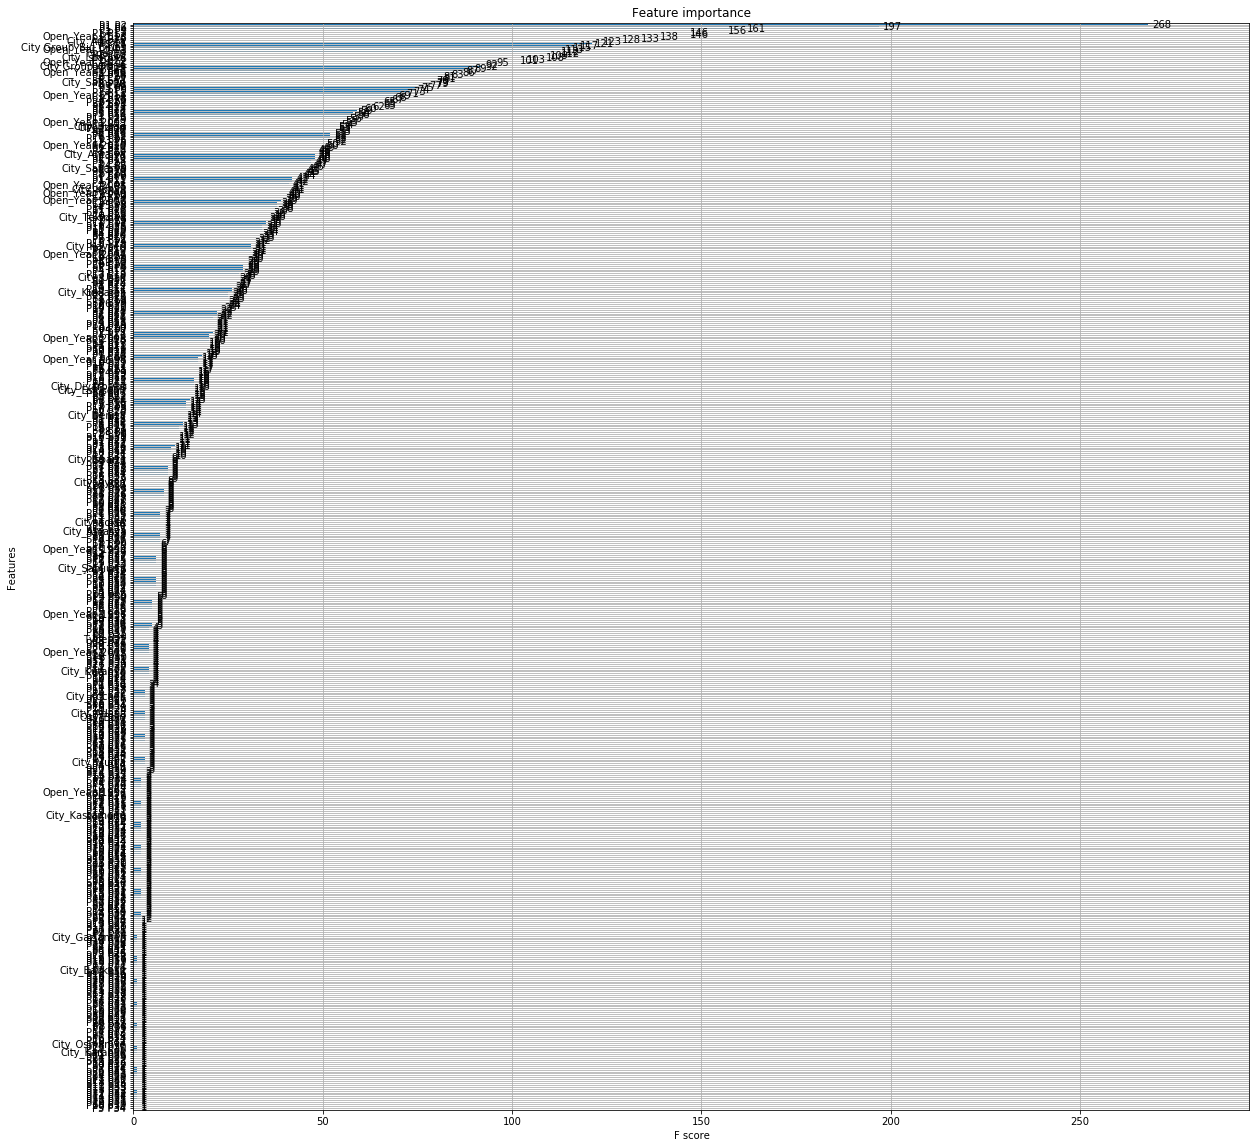

In [57]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# Prediction for Kaggle Submission

In [136]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x_drop))
xgbFinal_submission = np.square(np.exp(xgbFinal_submission))

In [137]:
## Other submission style
## Creating a Submission File to submit to Kaggle competition ##
testData = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "Id": testData["Id"],
        "Prediction": xgbFinal_submission
    })
submission.to_csv('XGboost_drop_features_interaction_testing_37th_trial.csv',header=True, index=False)

# Saving the final model

In [140]:
pickle.dump(xgbFinal, open("xgbFinal.pickle.dat", "wb"))

# Loading the final model

In [142]:
xgb_test = pickle.load(open("xgbFinal.pickle.dat", "rb"))

In [143]:
# Re-forecast the prediction to verify the model
xgb_test_p = xgb_test.predict(xgb.DMatrix(test_rf_x))
xgb_test_p = np.exp(xgb_test_p)

In [150]:
verify_model = (xgbFinal_submission == xgb_test_p)
verify_model.sum()

100000